In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import plugins

In [2]:
df= pd.read_excel('full_data.xlsx')
coordinates = pd.read_excel('coordinates_edited.xlsx')
people_year_born = pd.read_excel('people_year_born.xlsx')

In [3]:
pd.to_numeric(df['from_latitude'])
pd.to_numeric(df['from_longitude'])
pd.to_numeric(df['to_latitude'])
pd.to_numeric(df['to_latitude'])

0       49.238800
1       49.238800
2       49.238800
3       49.238800
4       49.238800
          ...    
1338    53.961200
1339    53.961200
1340    52.230105
1341    56.005200
1342    56.005200
Name: to_latitude, Length: 1343, dtype: float64

Построим графики плотности по годам для каждого географического объекта.

In [4]:
def explode_func(x, y):
    years = []
    for i in range(x, y + 1):
        years.append(i)
    return years

Приток населения.

<ipython-input-5-a8ac04d5ee8c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_df['year'] = years_all


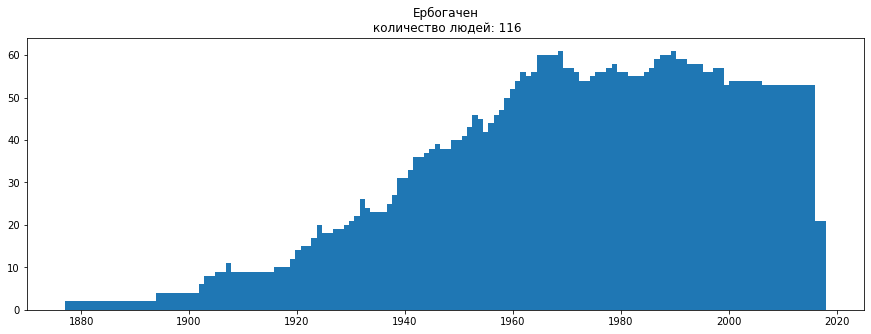

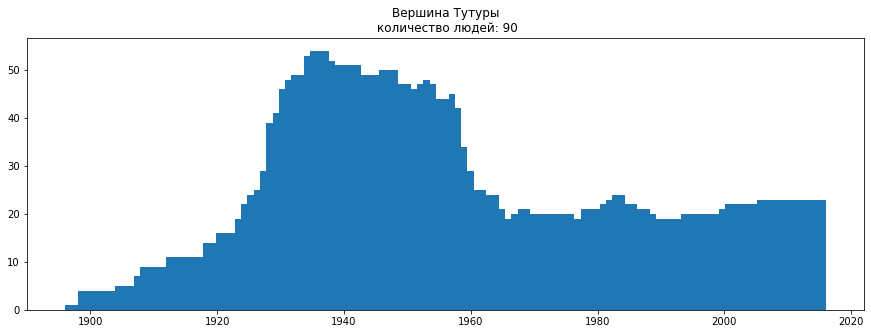

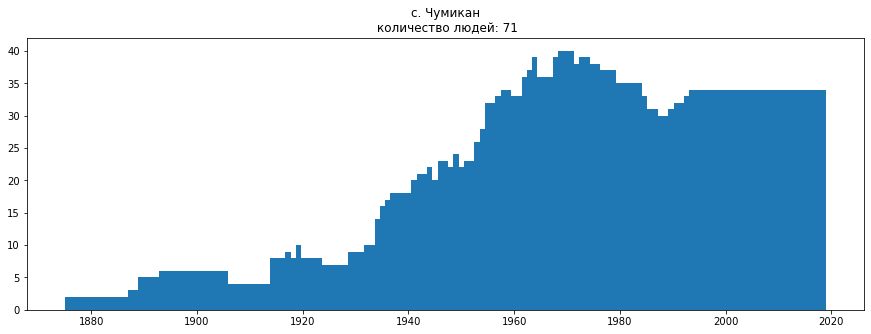

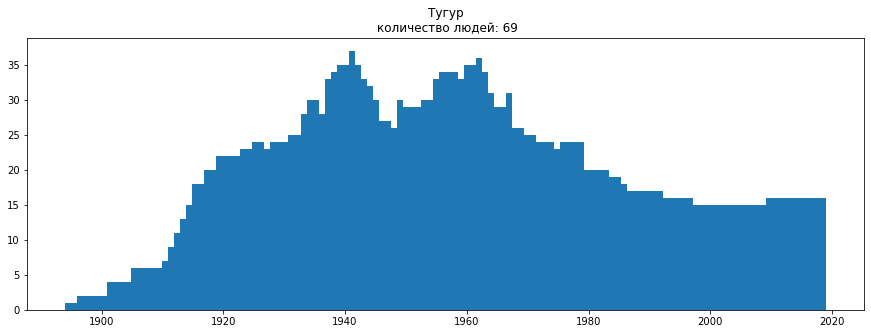

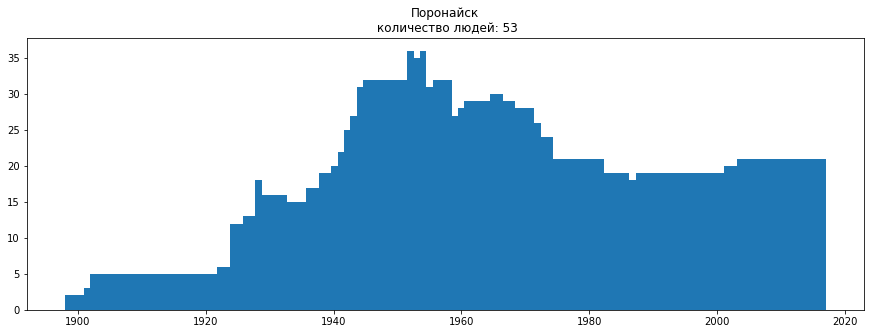

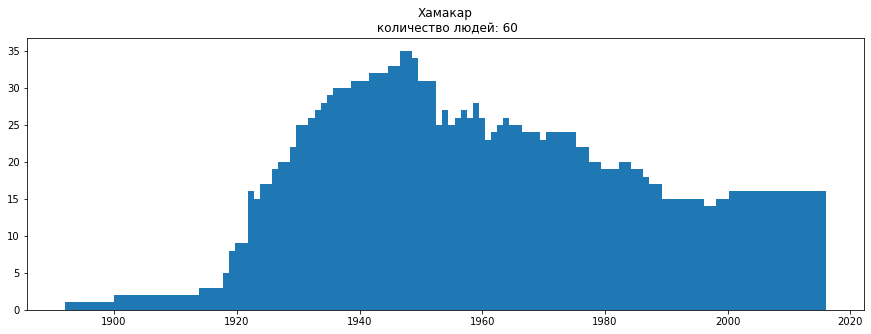

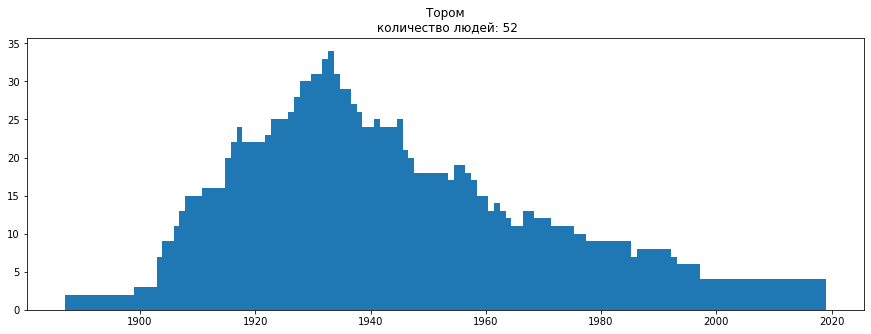

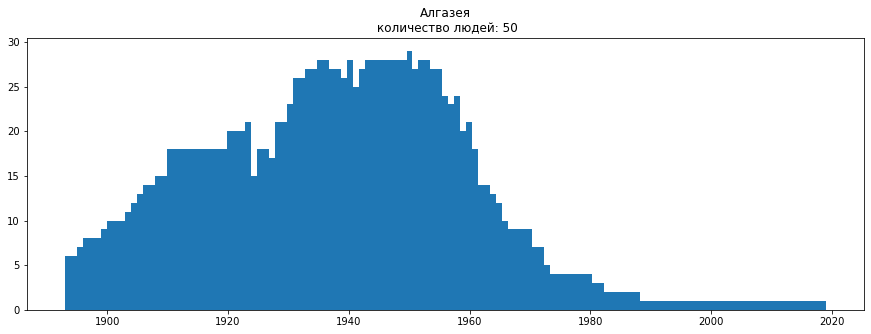

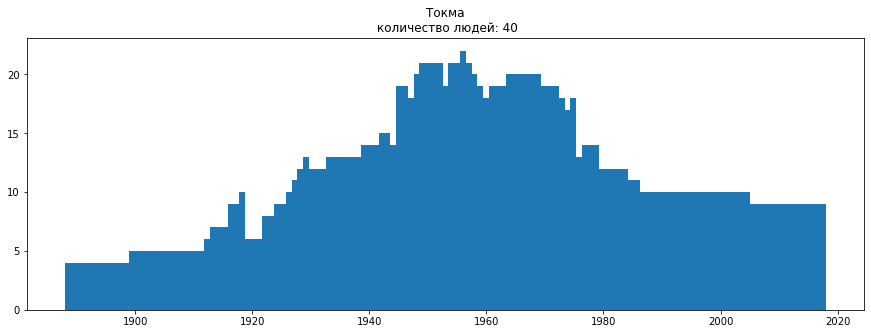

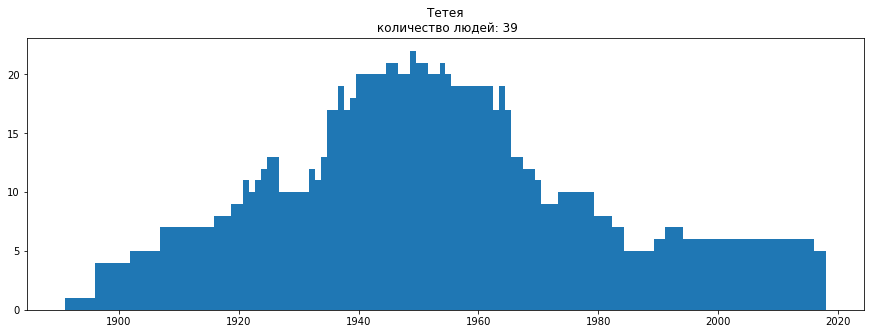

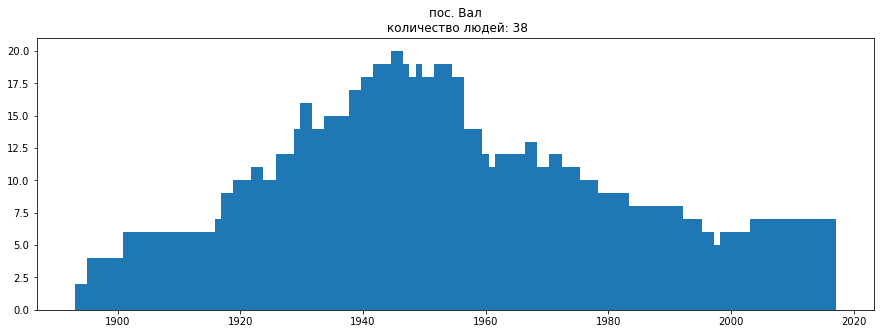

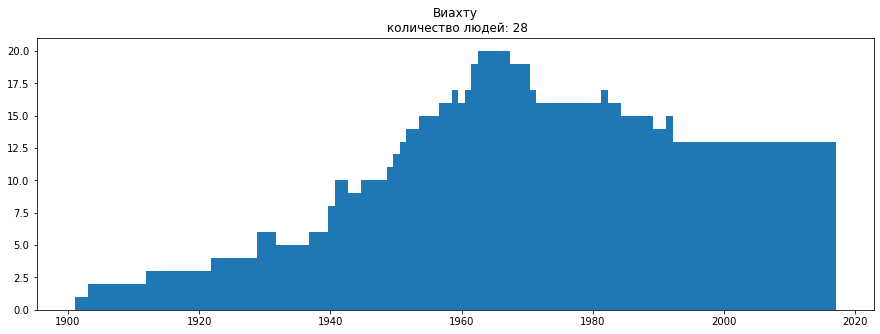

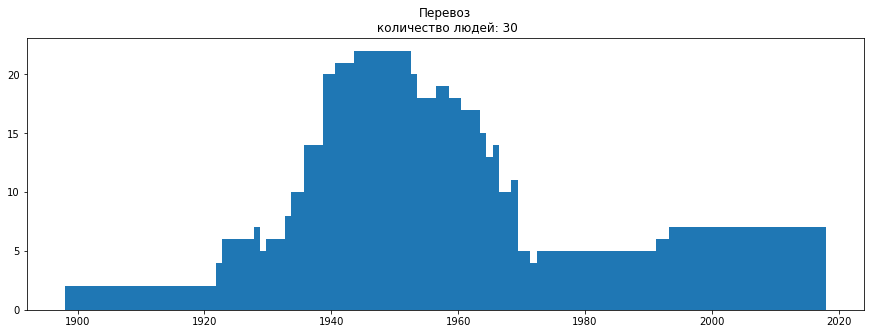

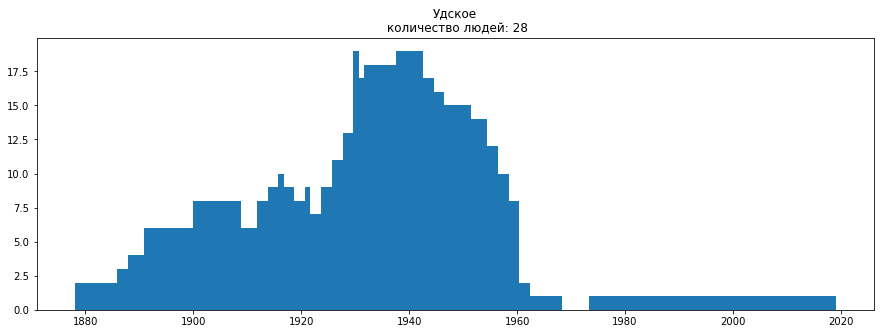

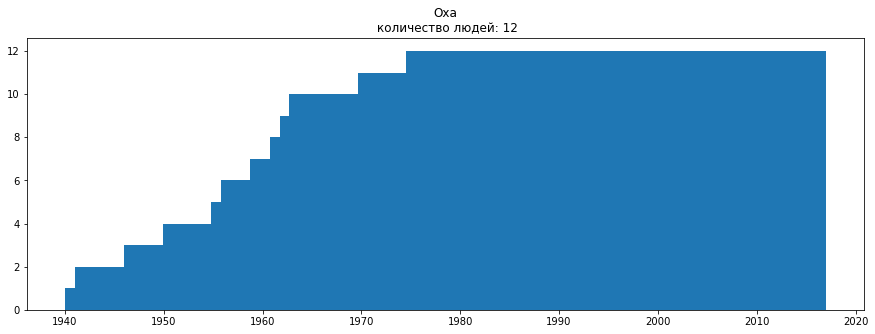

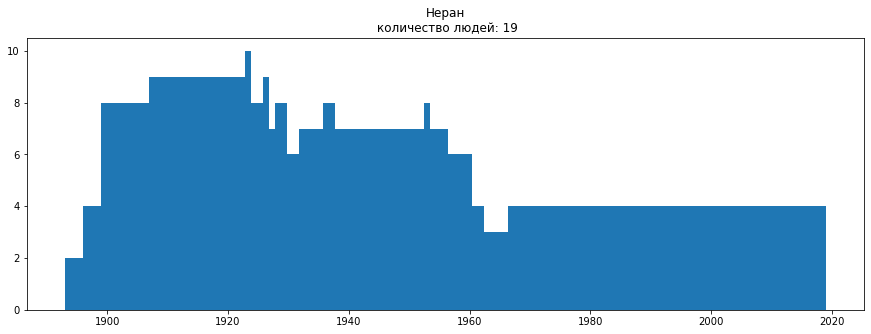

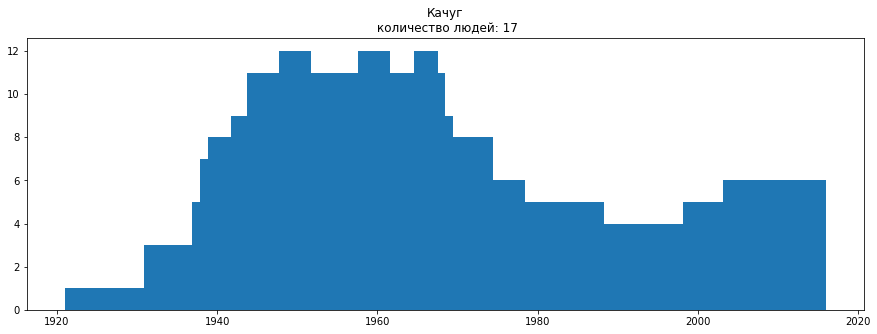

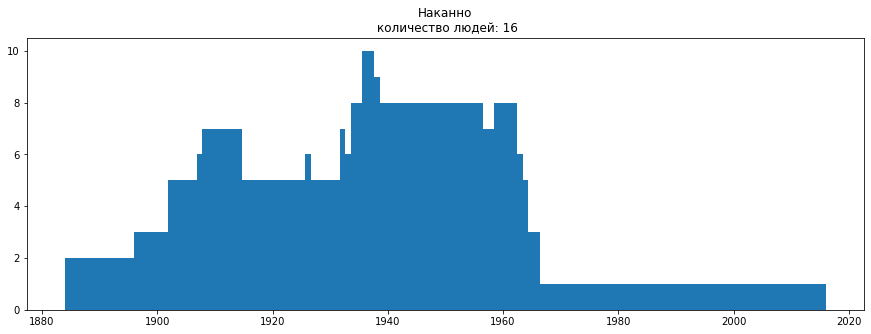

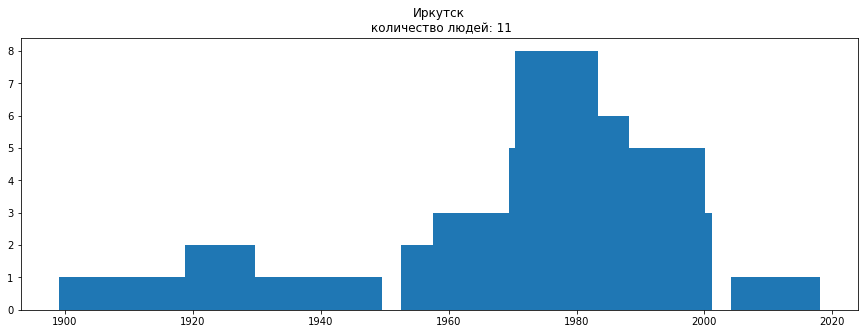

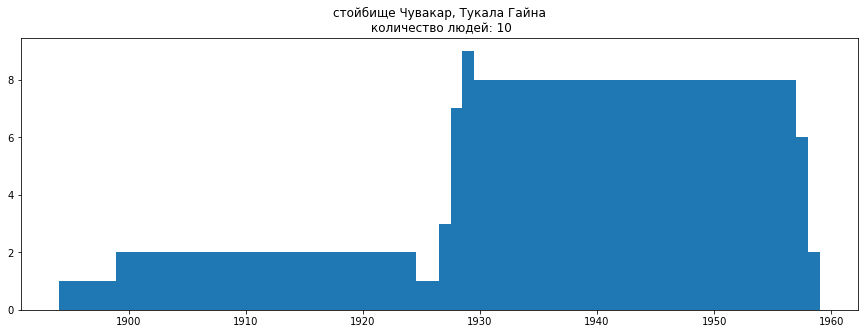

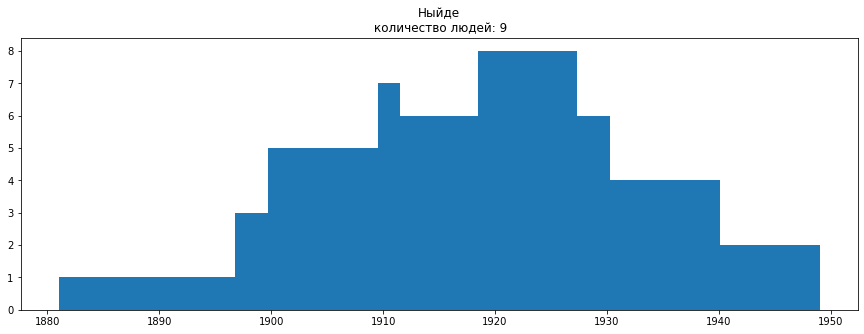

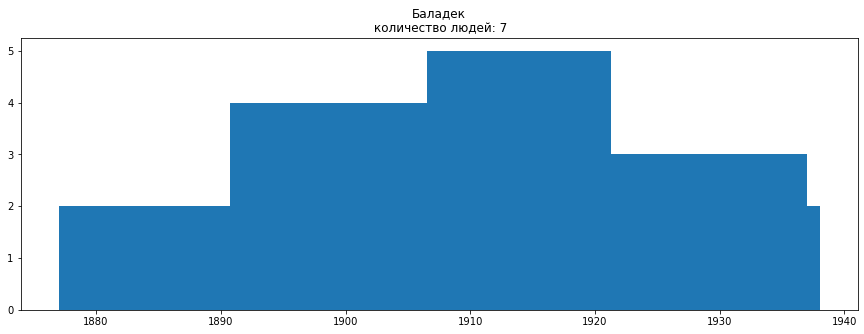

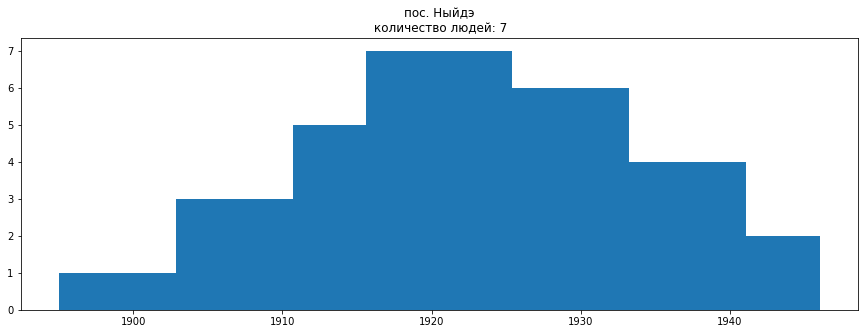

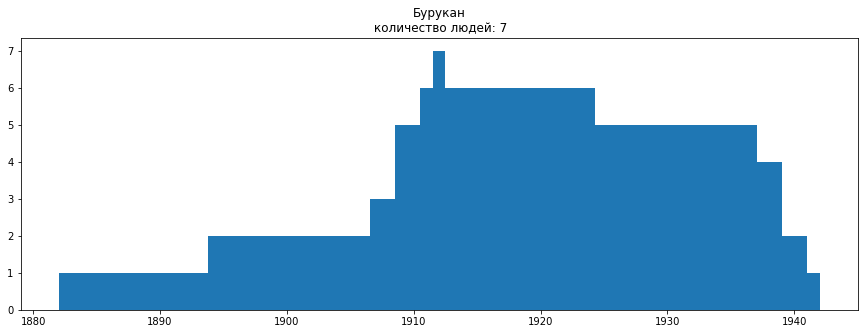

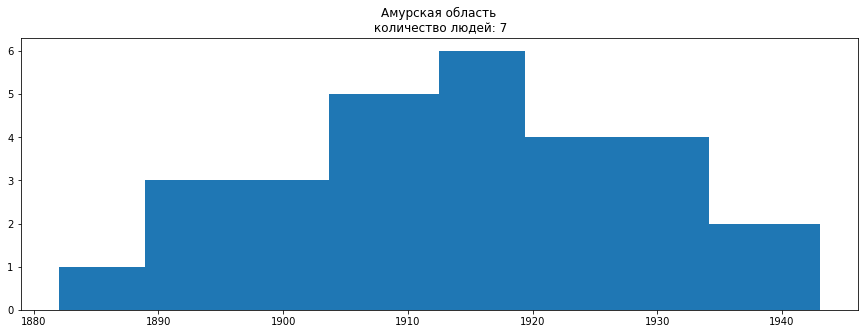

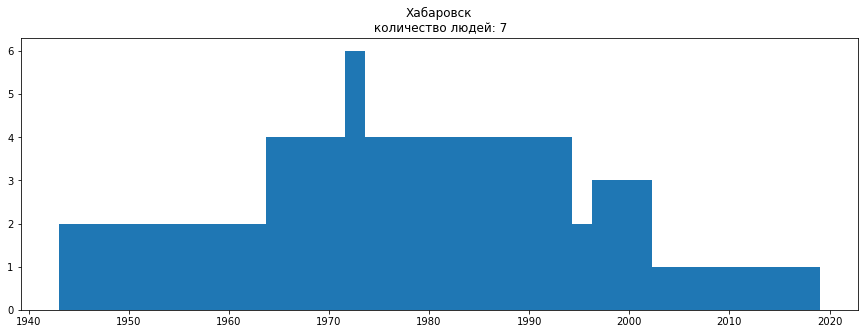

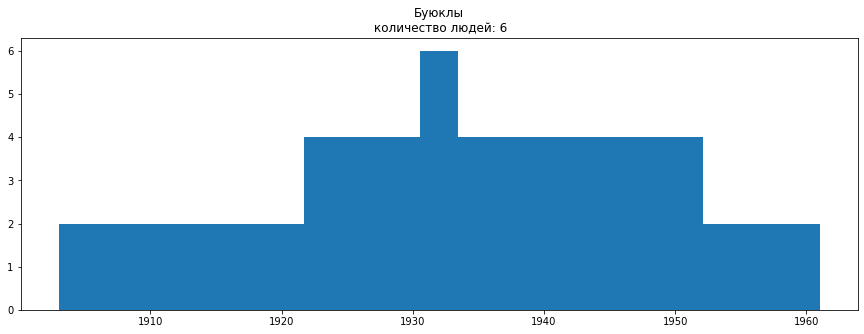

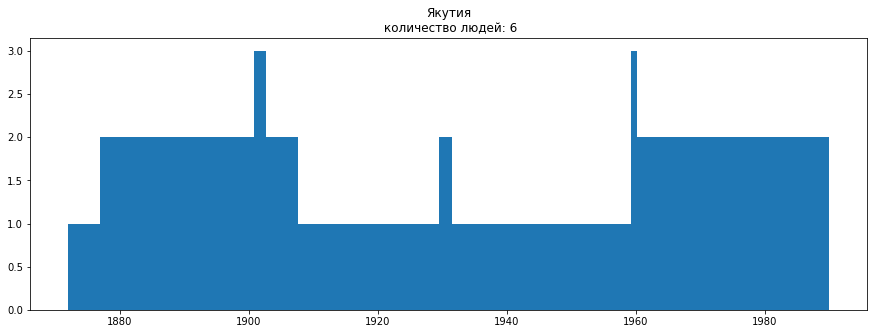

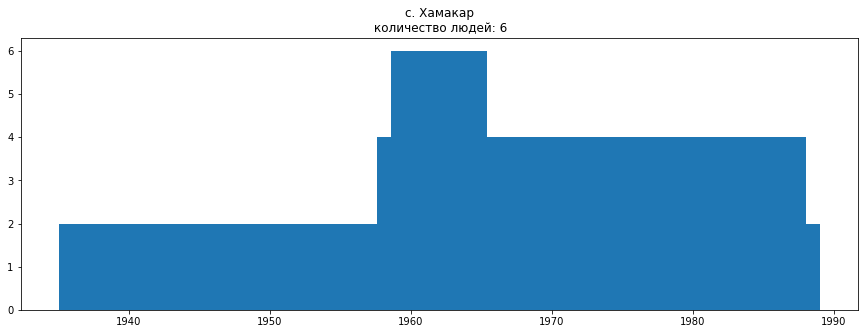

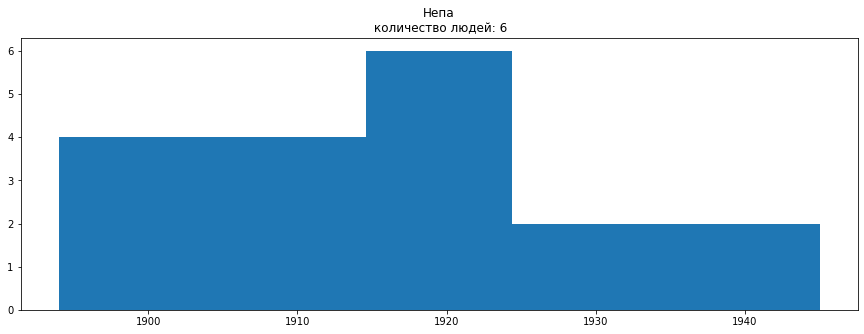

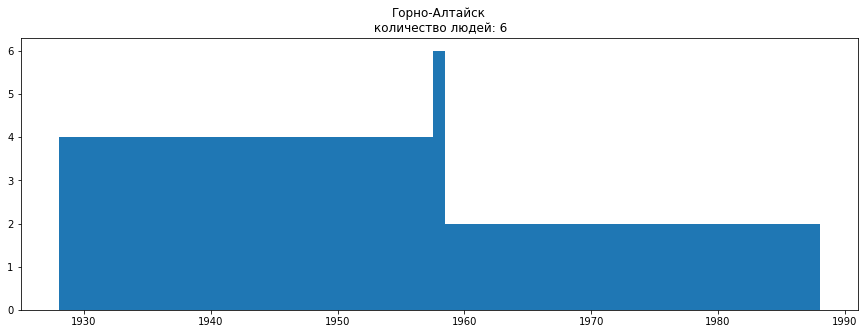

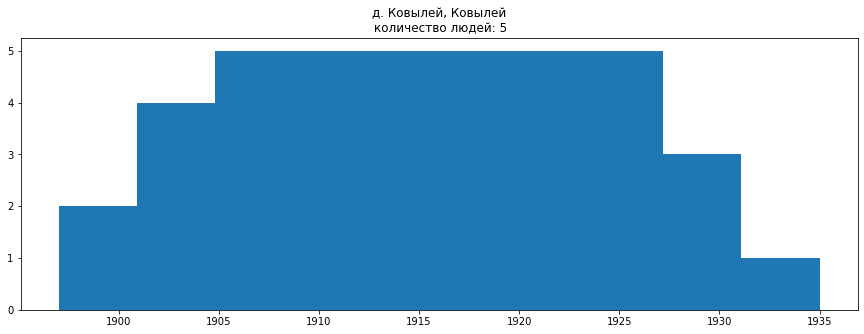

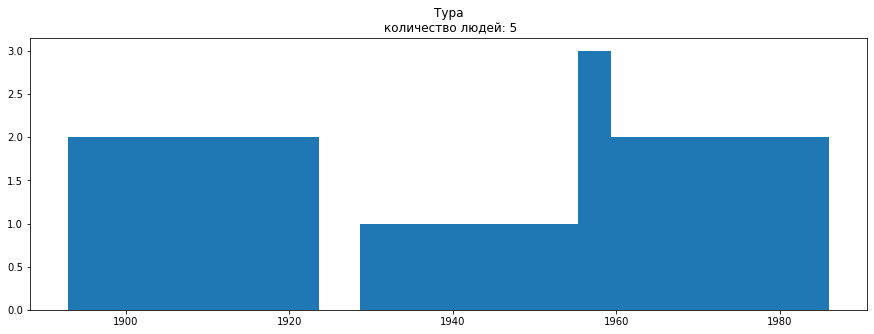

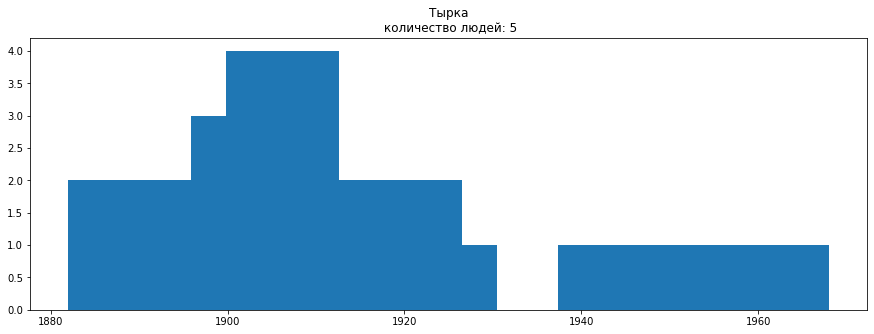

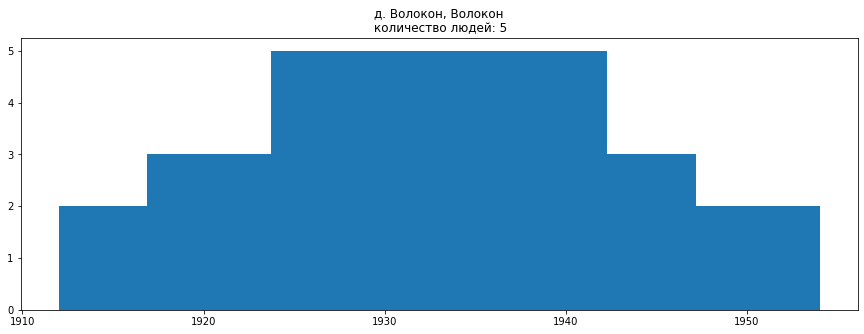

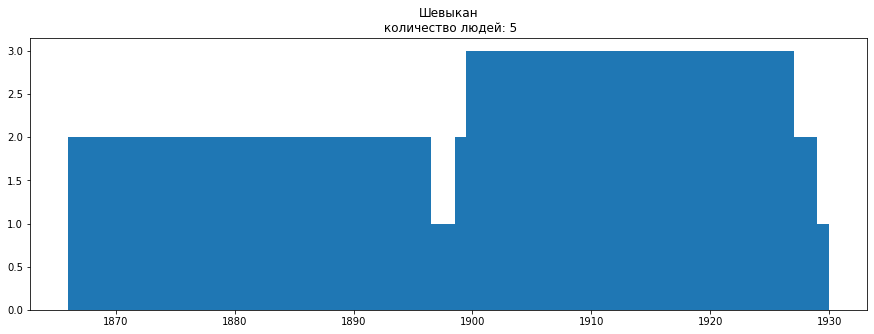

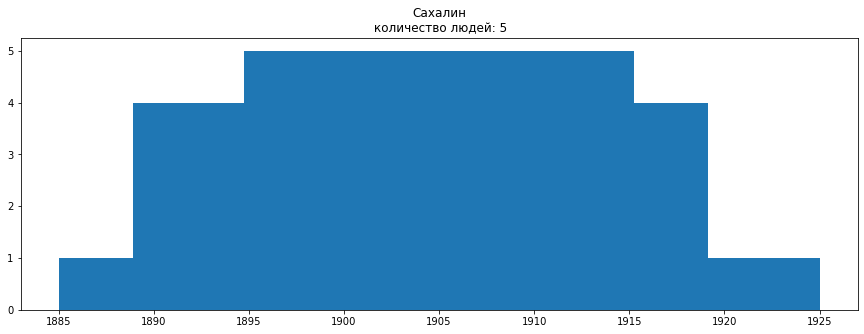

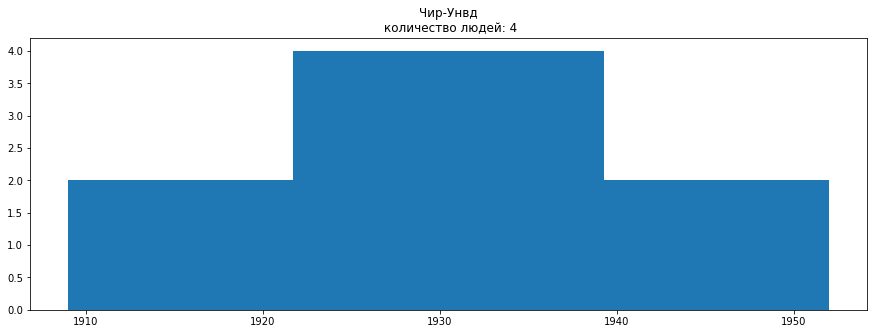

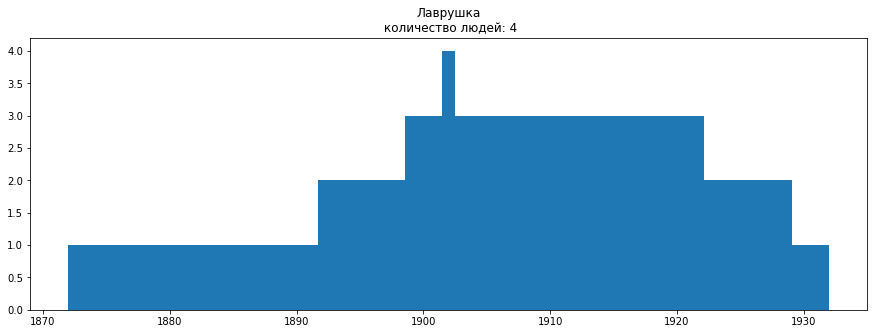

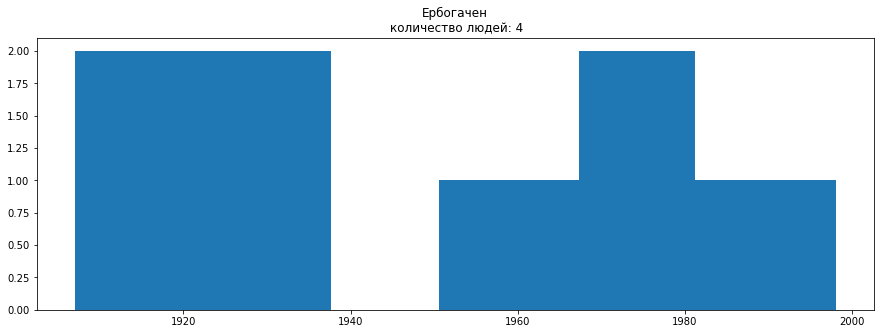

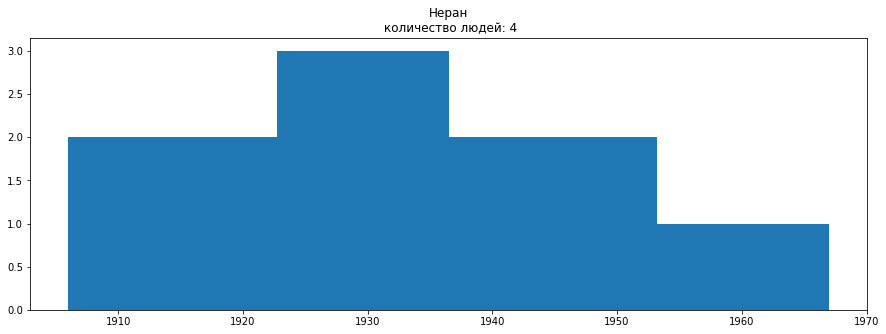

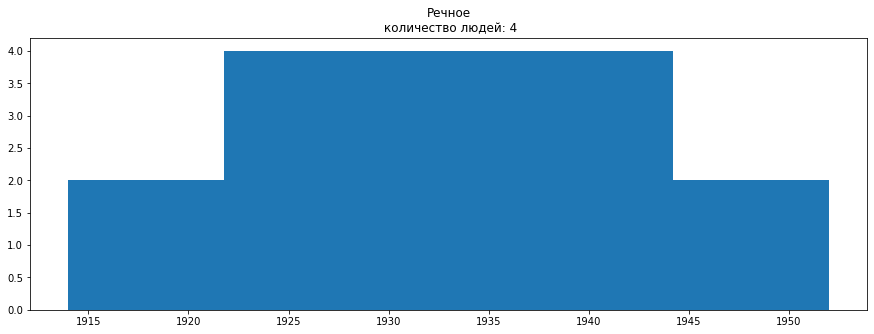

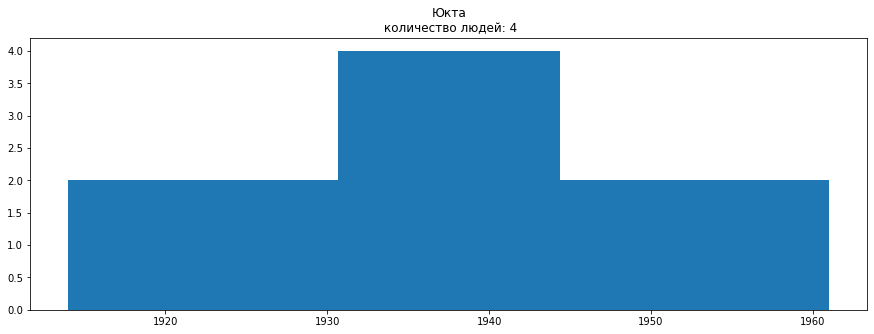

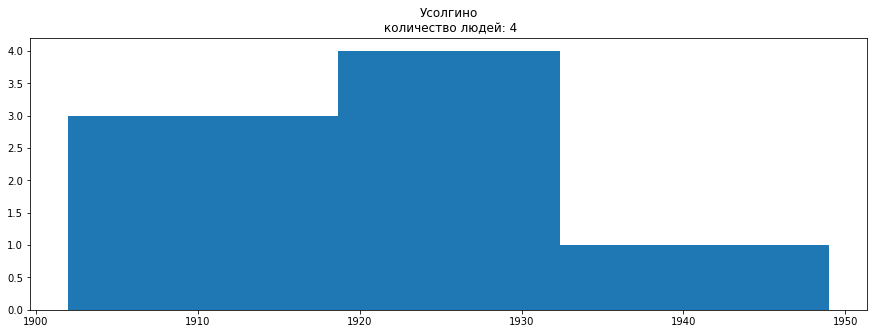

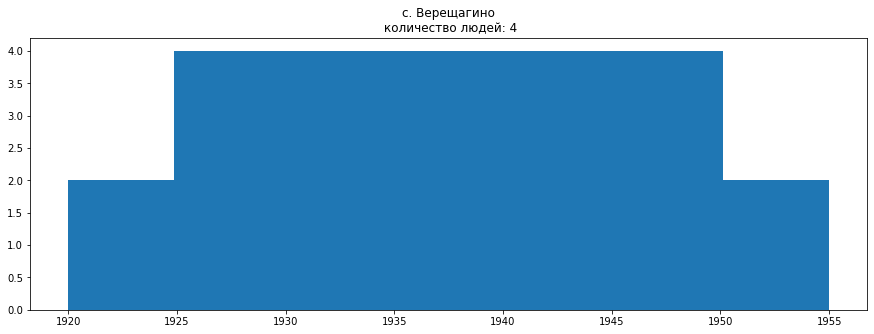

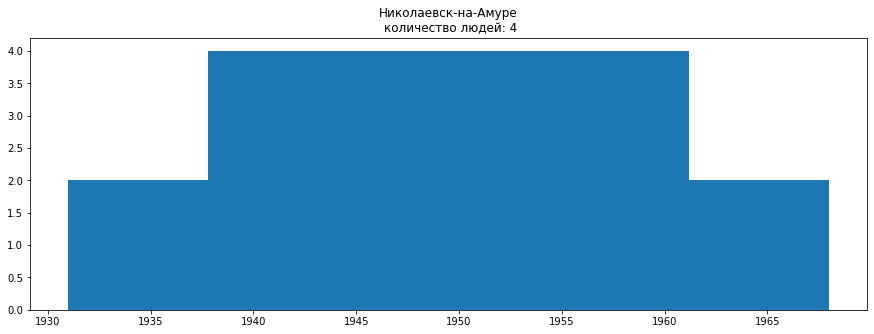

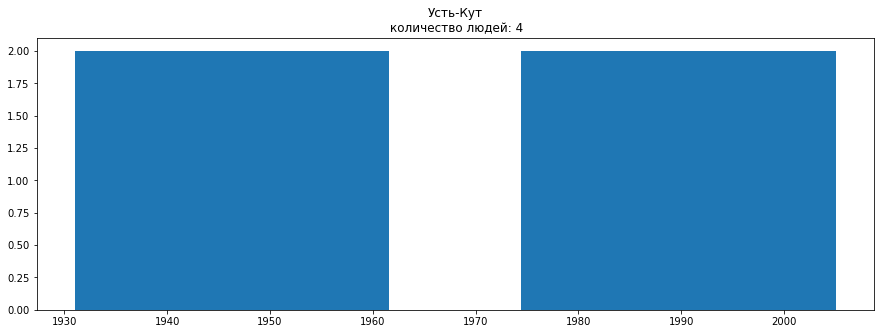

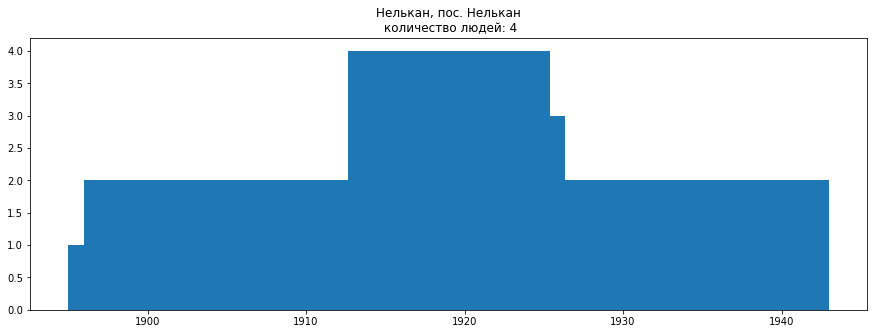

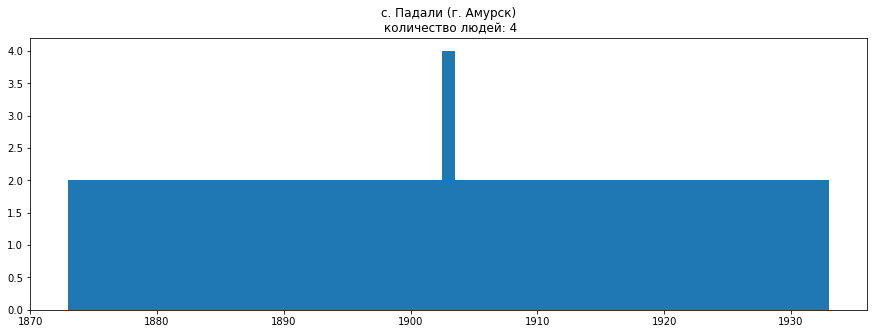

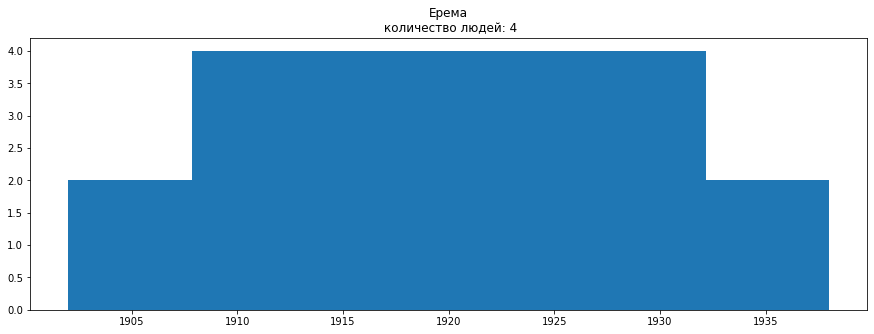

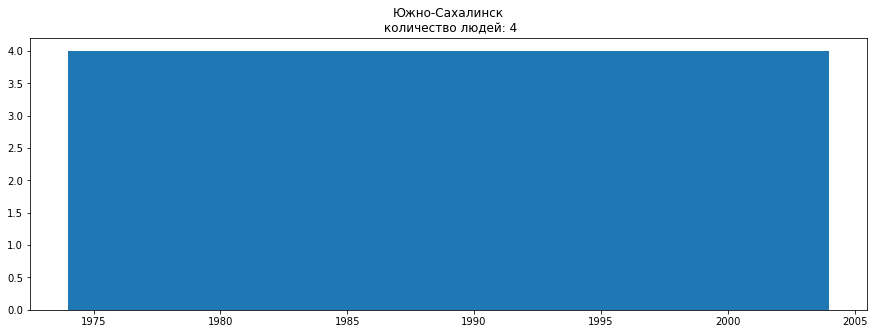

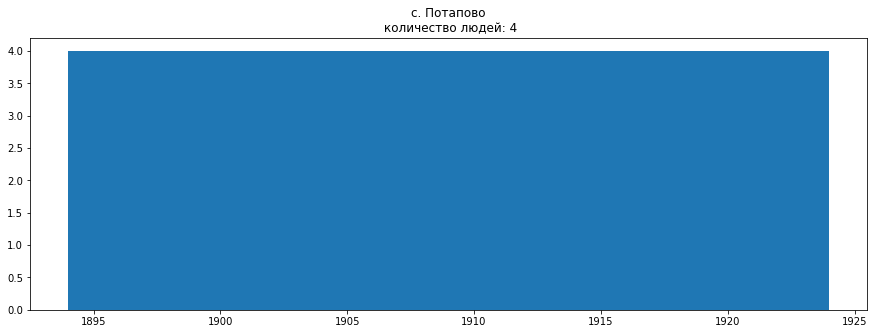

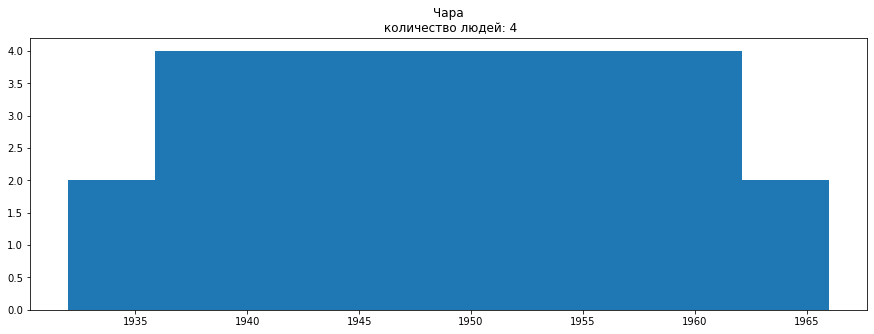

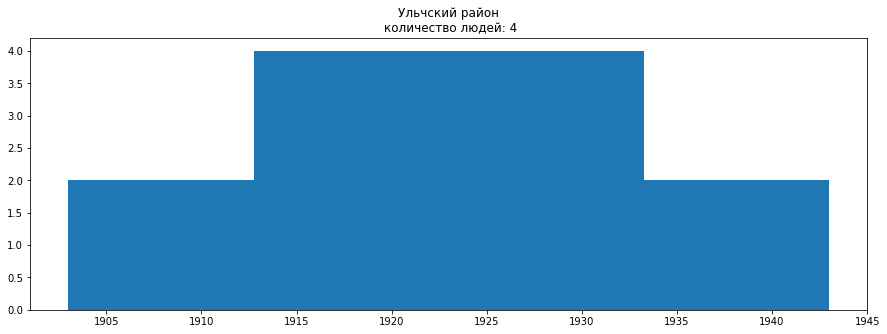

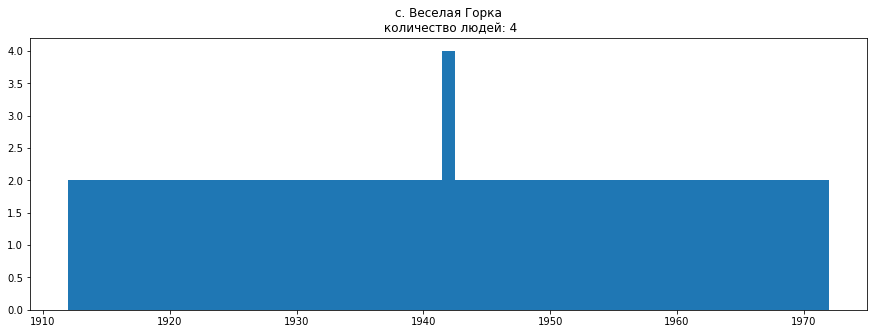

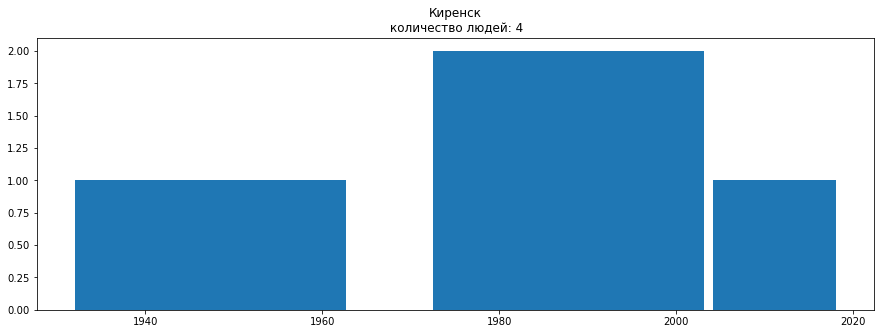

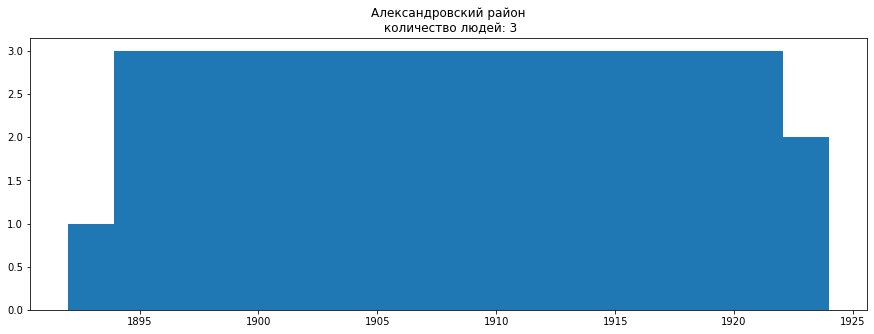

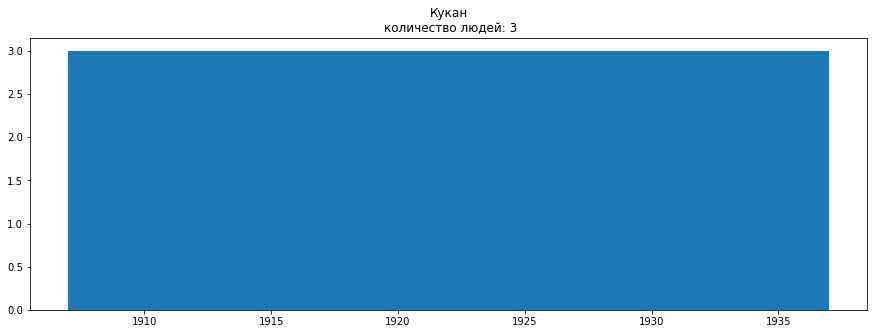

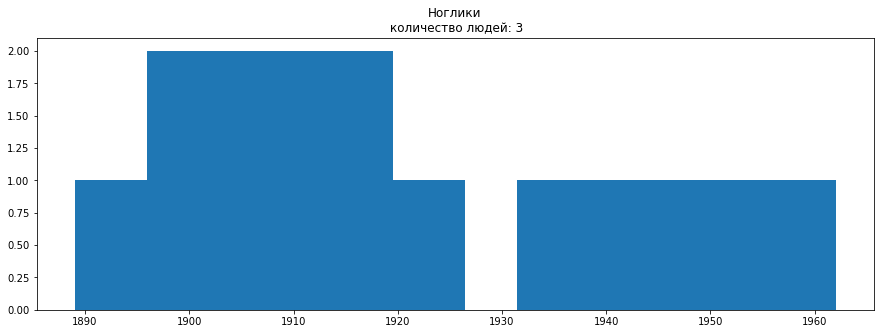

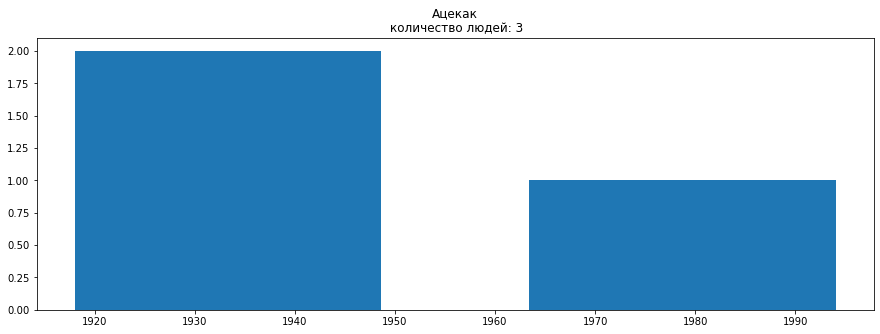

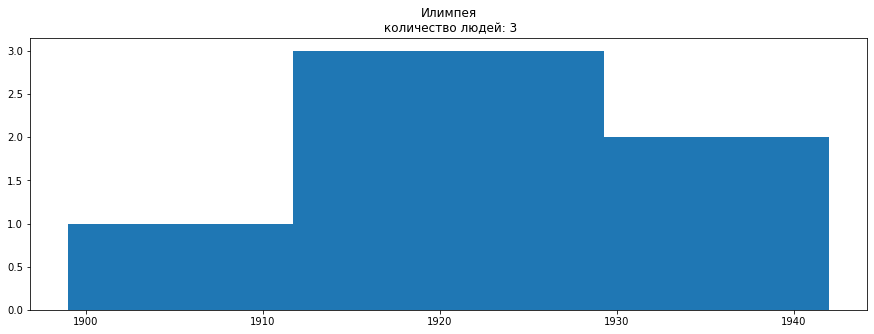

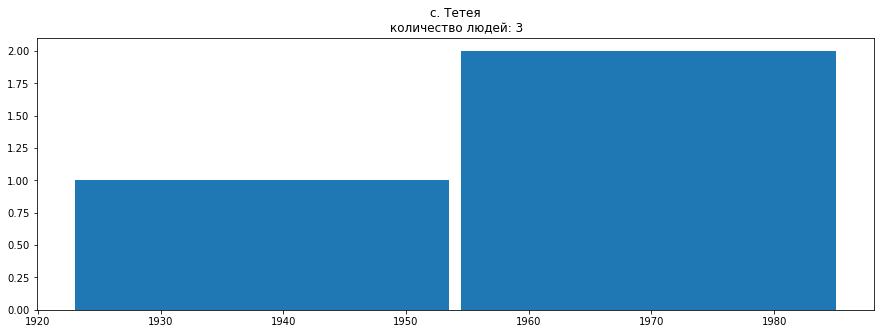

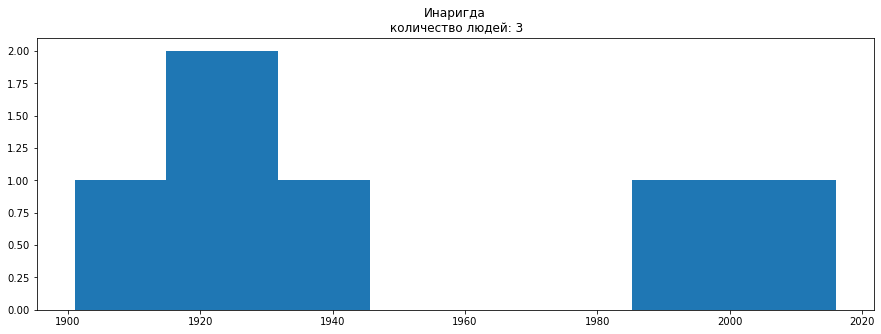

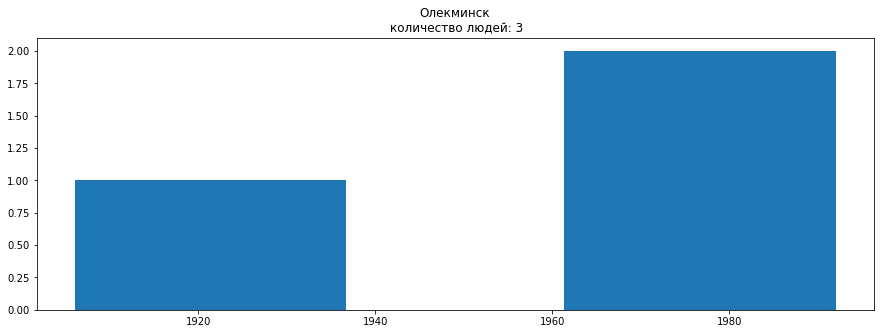

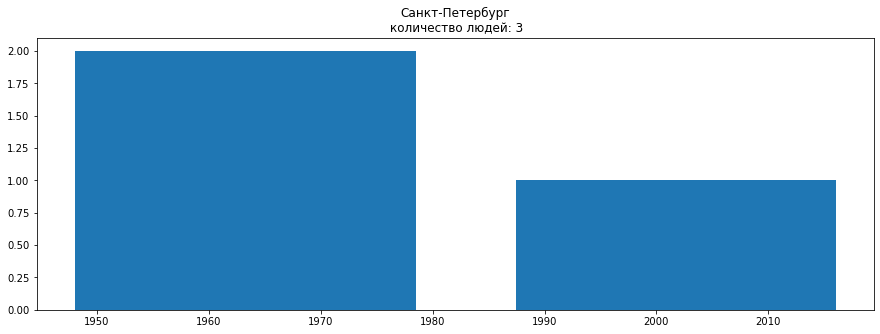

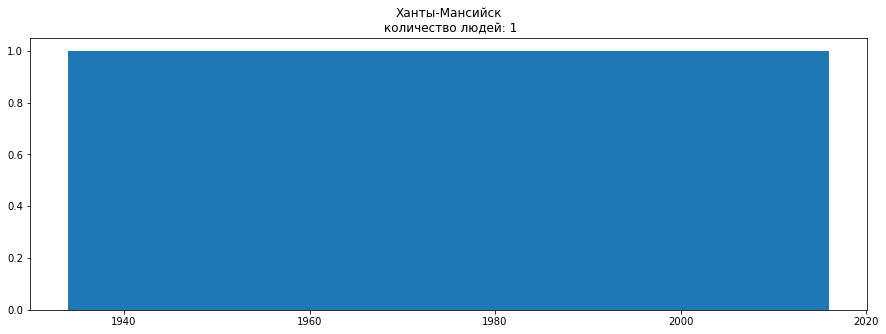

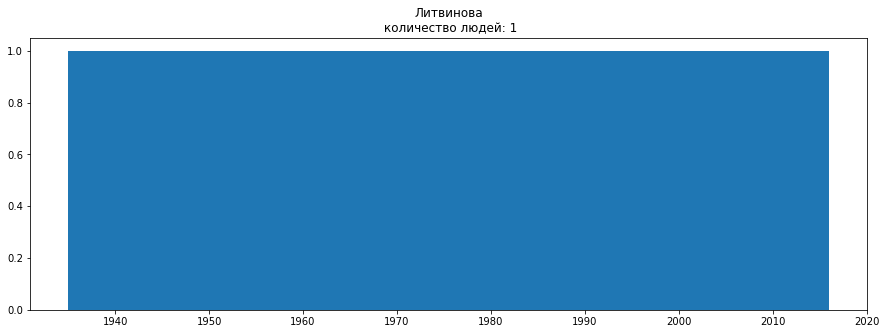

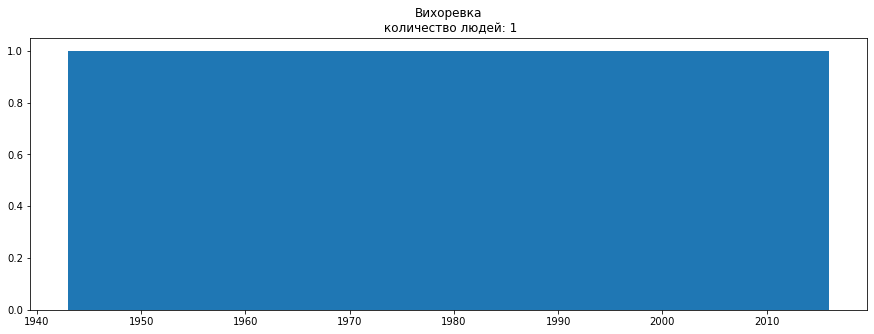

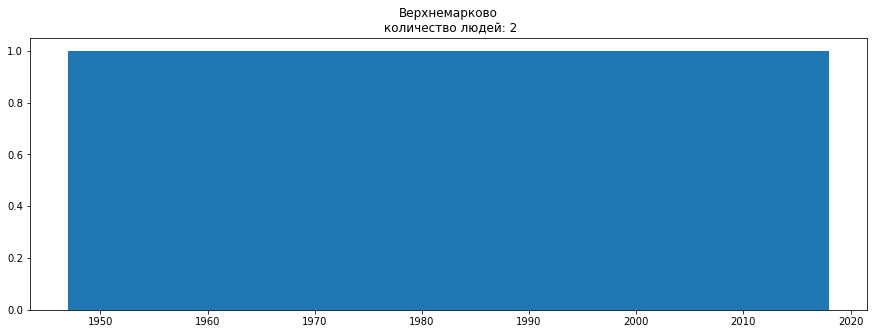

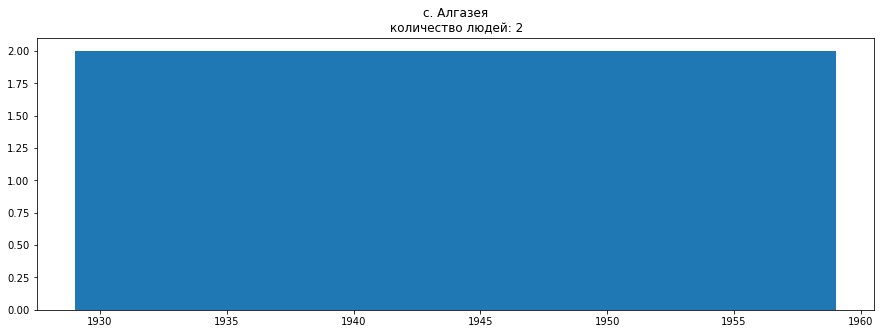

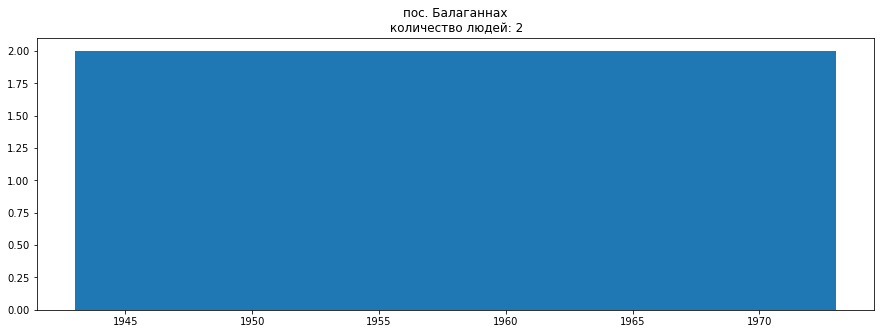

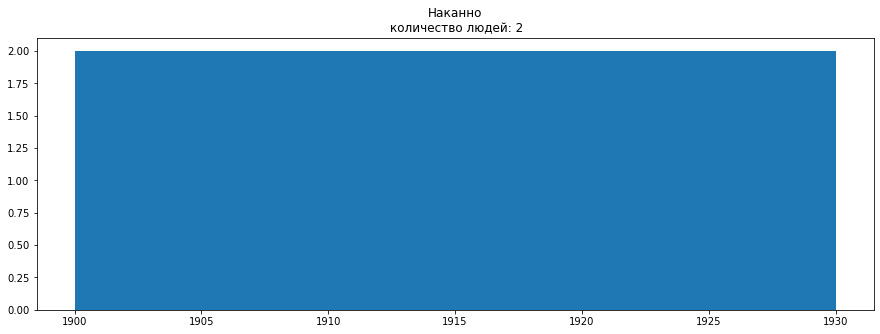

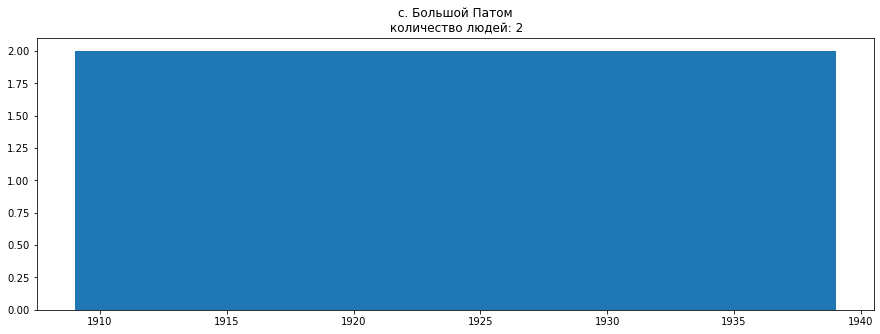

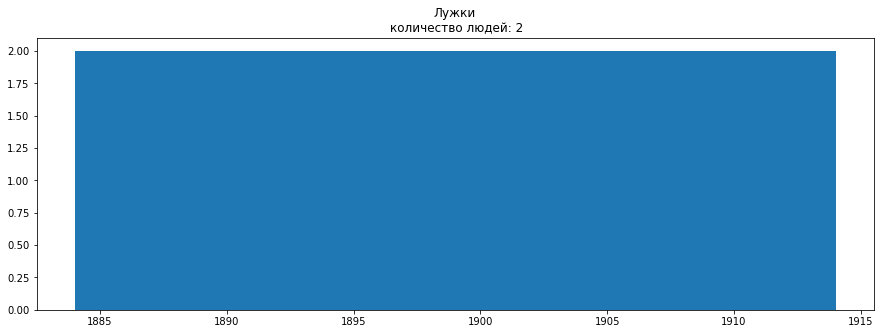

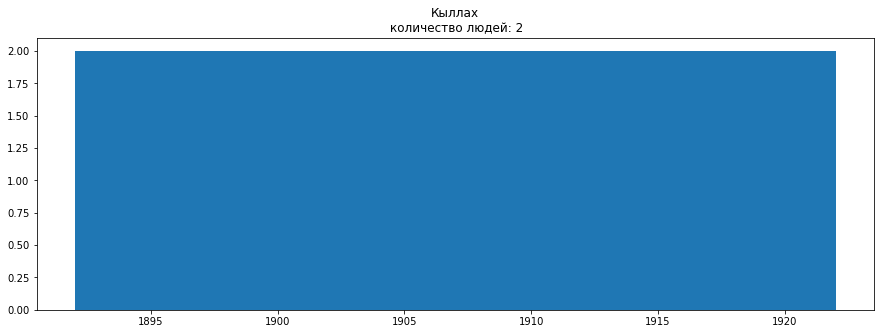

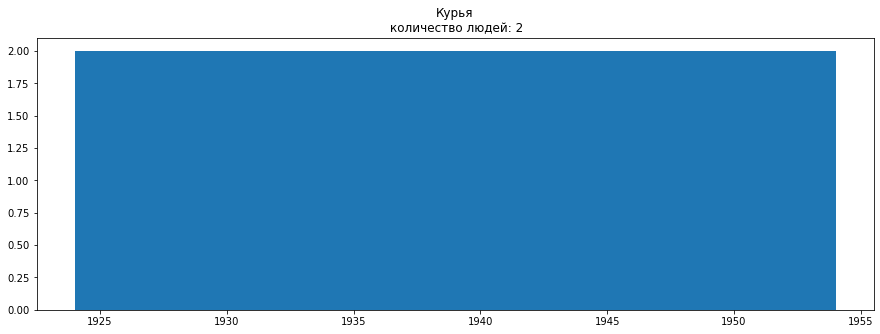

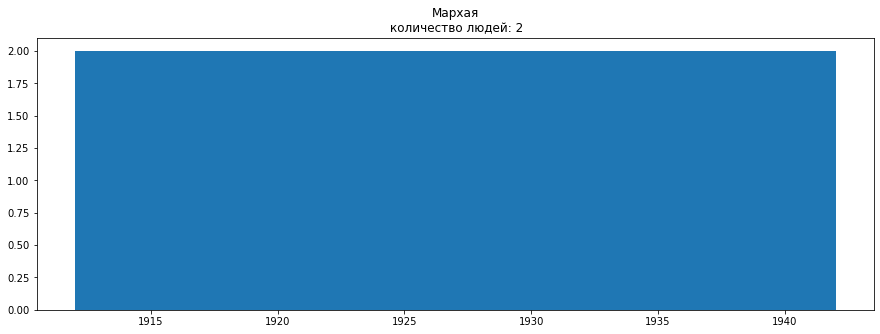

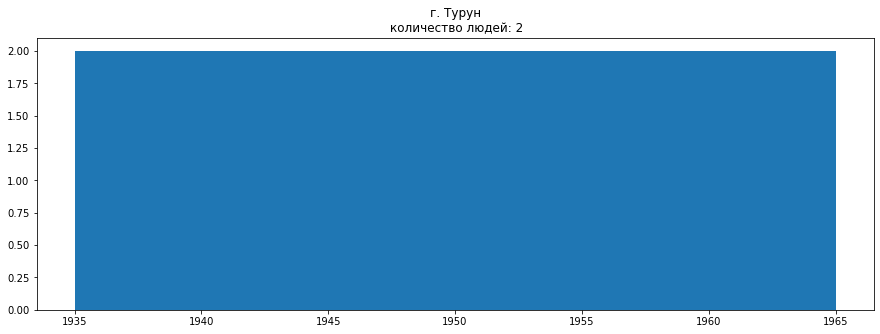

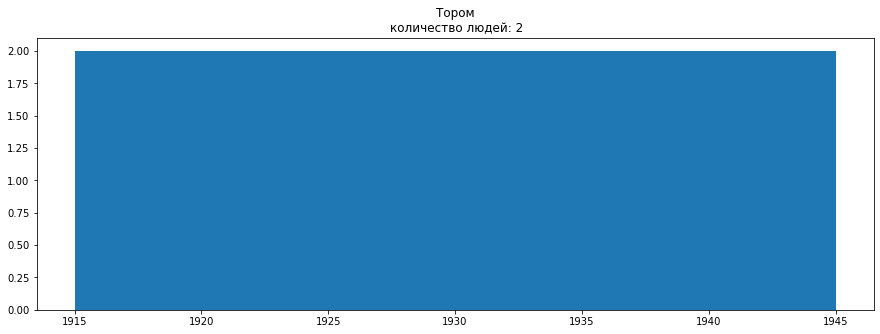

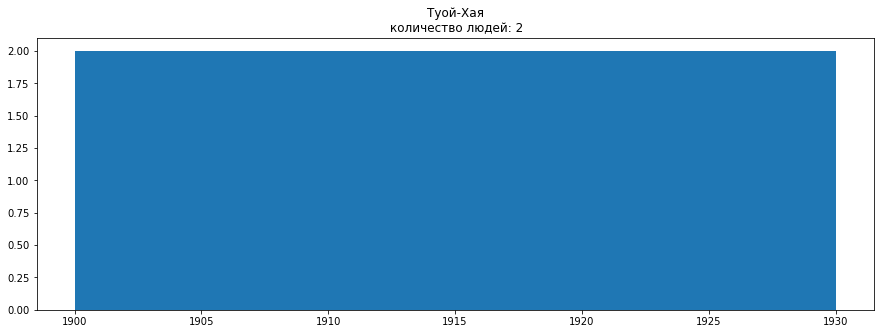

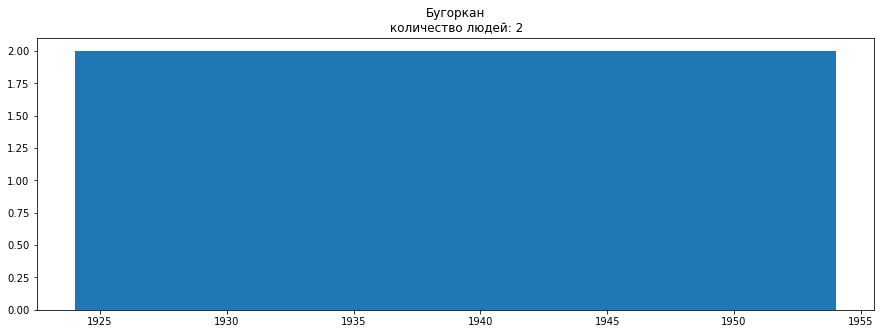

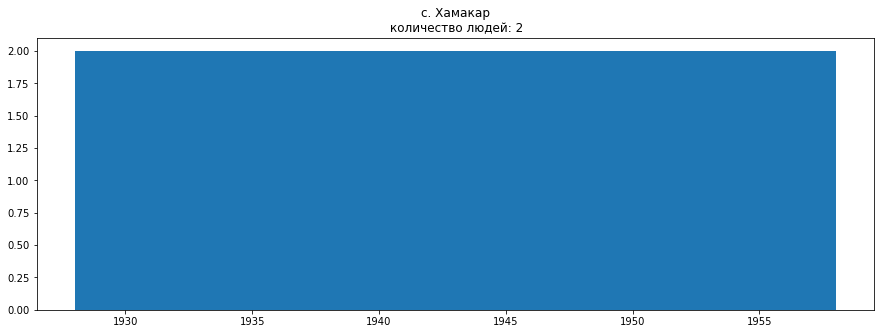

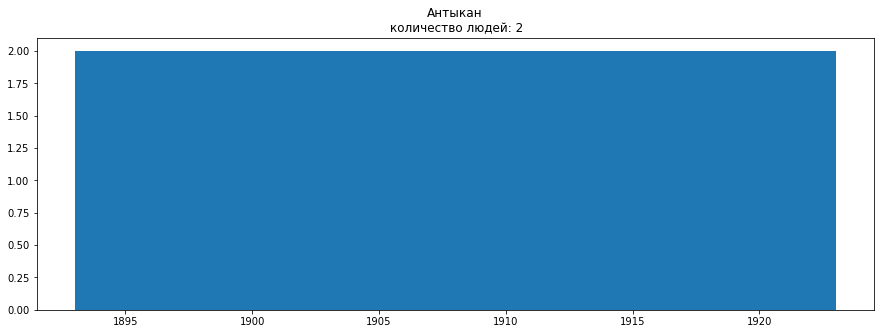

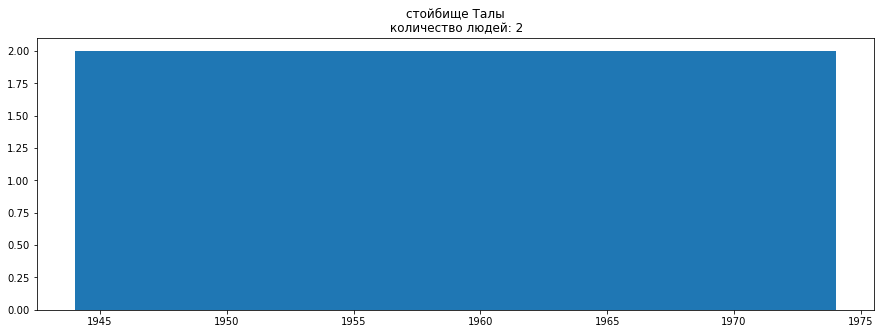

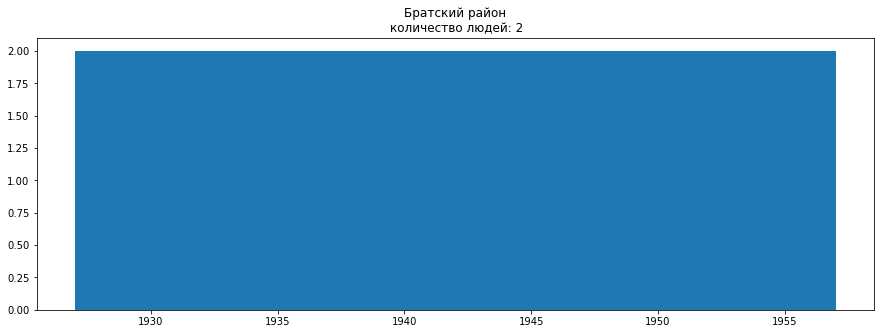

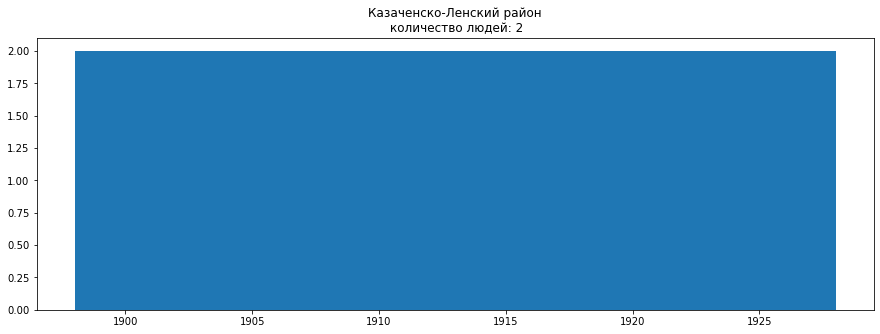

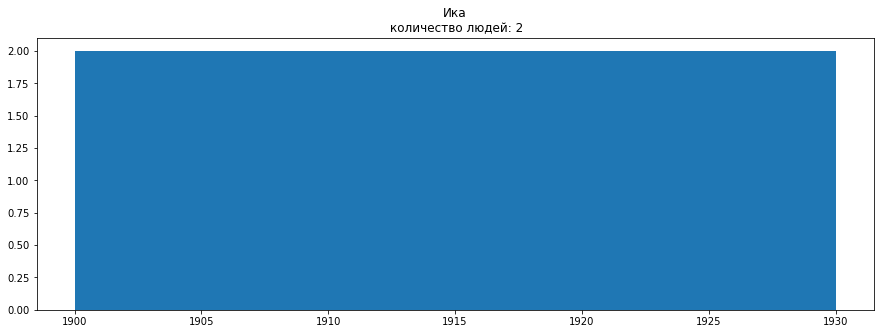

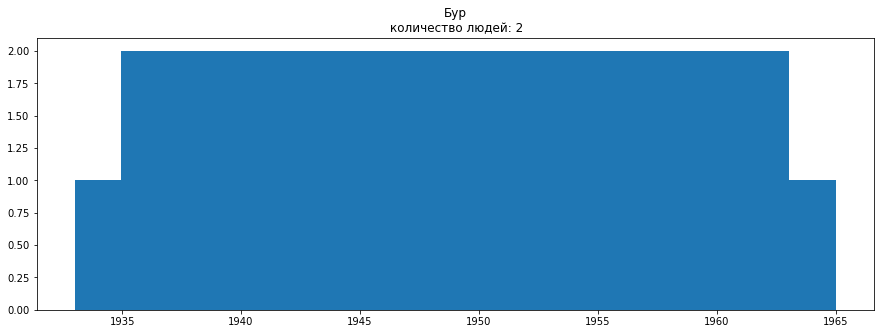

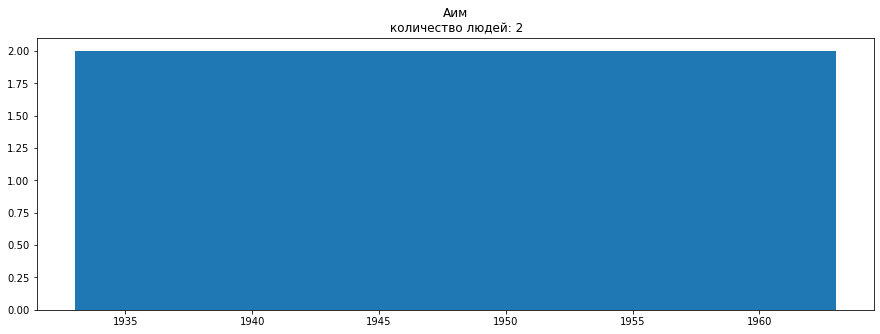

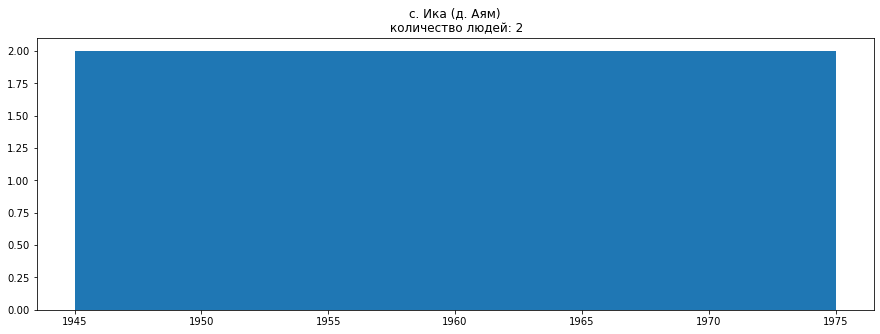

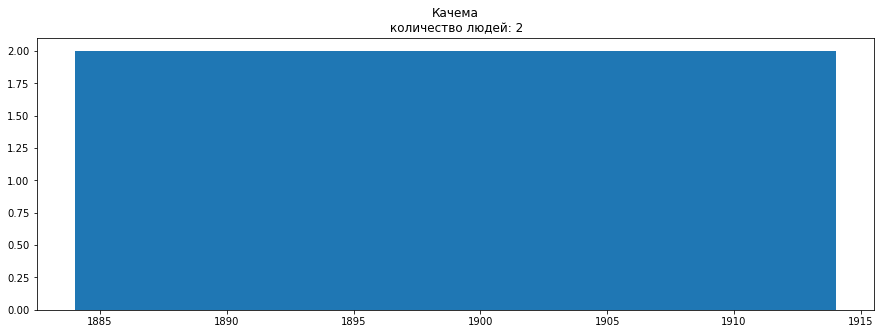

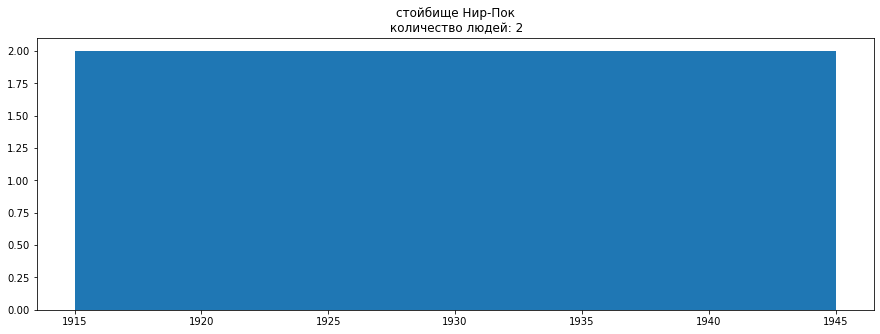

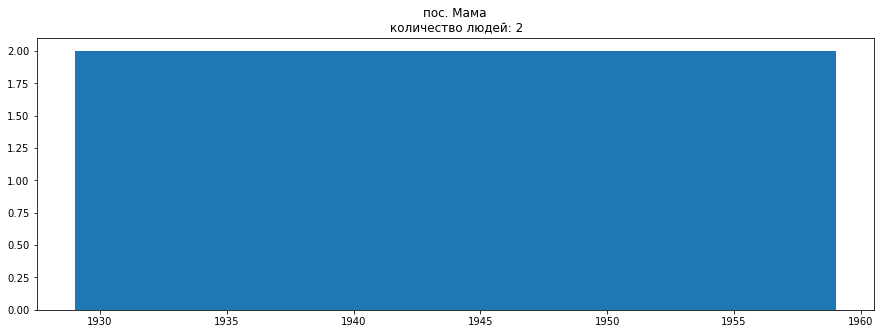

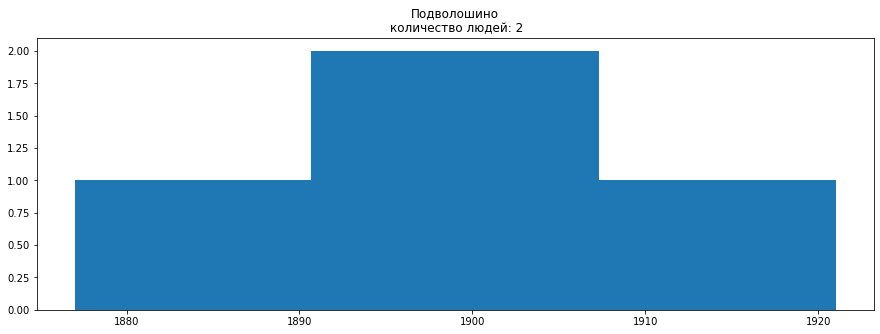

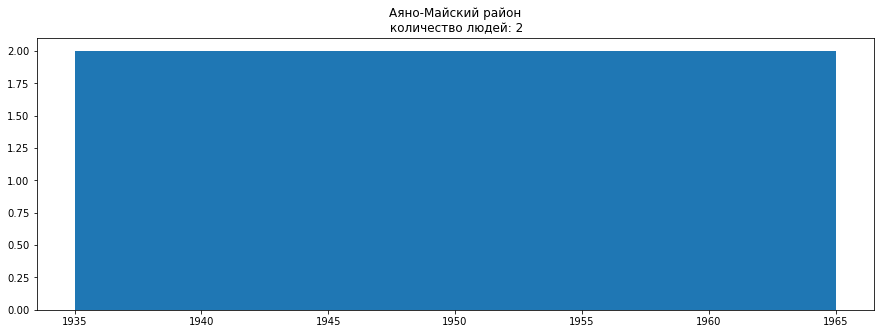

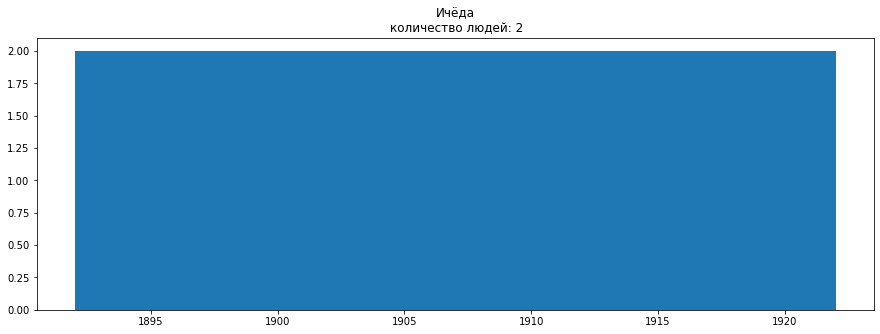

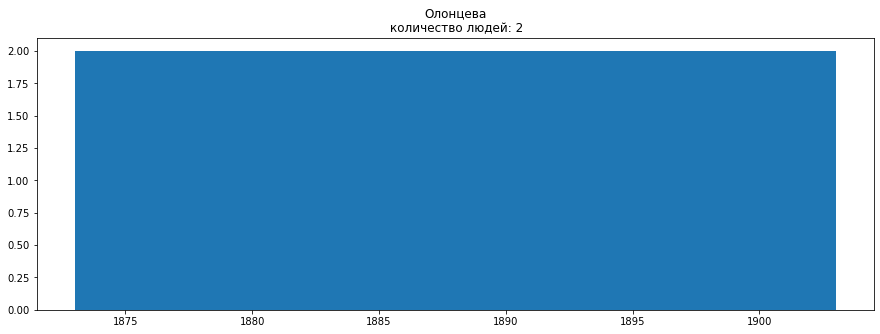

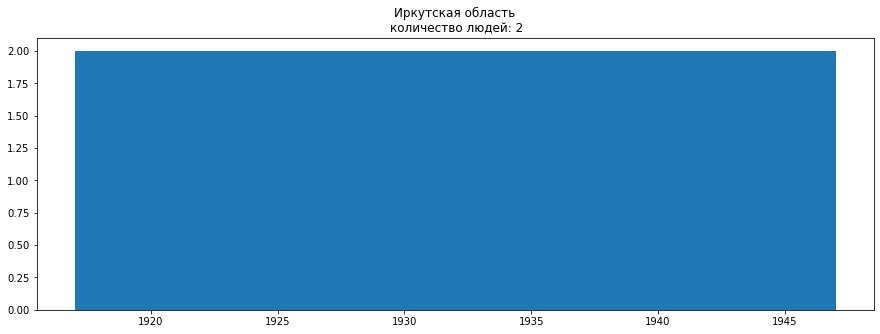

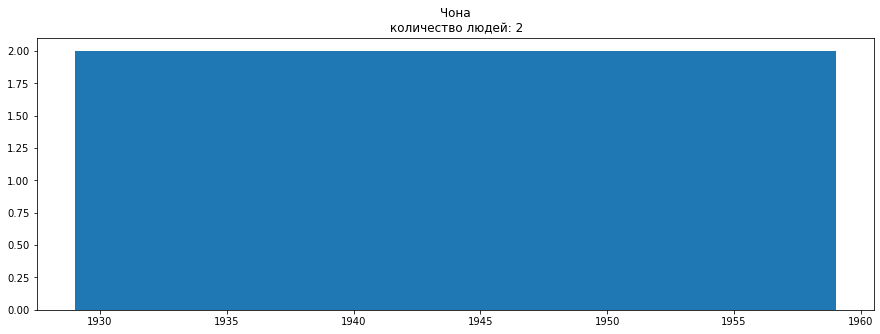

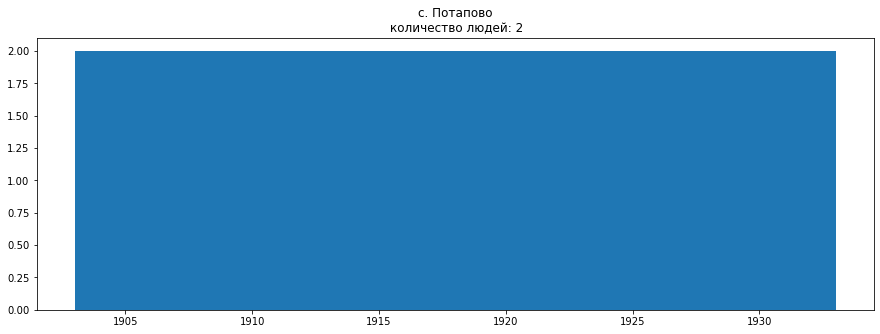

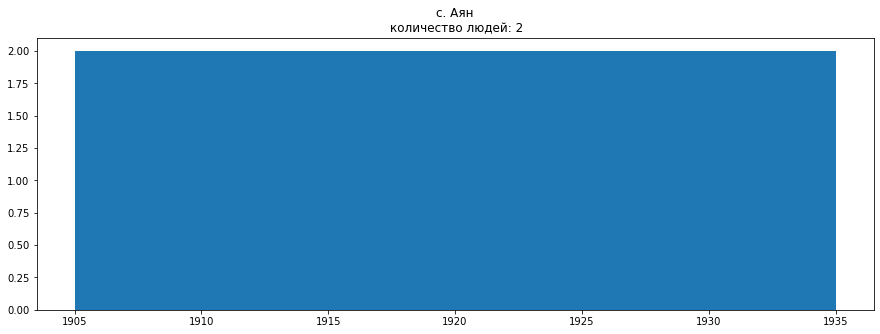

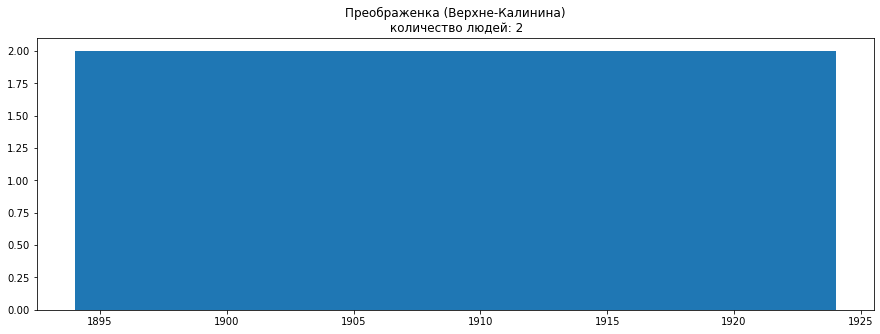

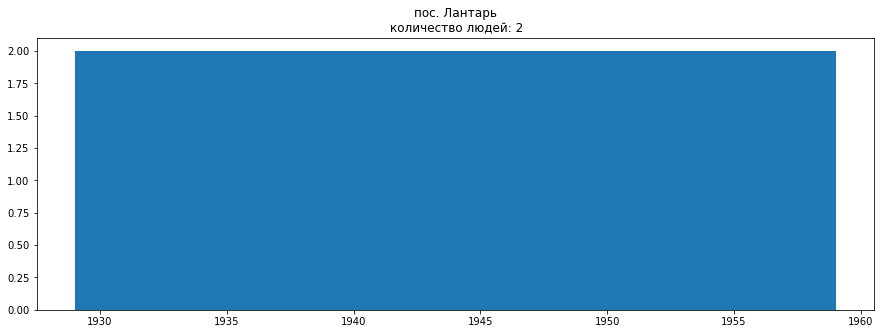

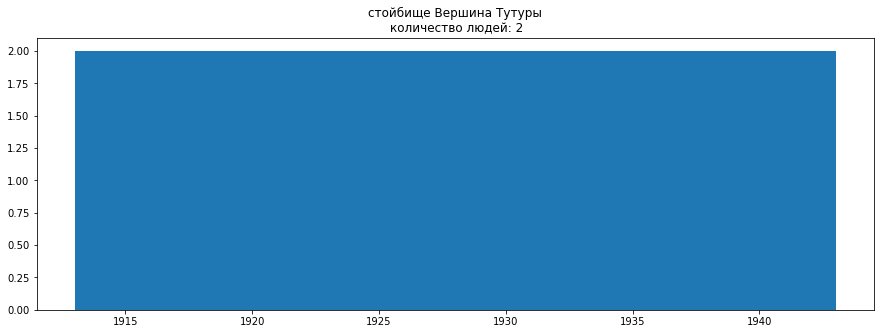

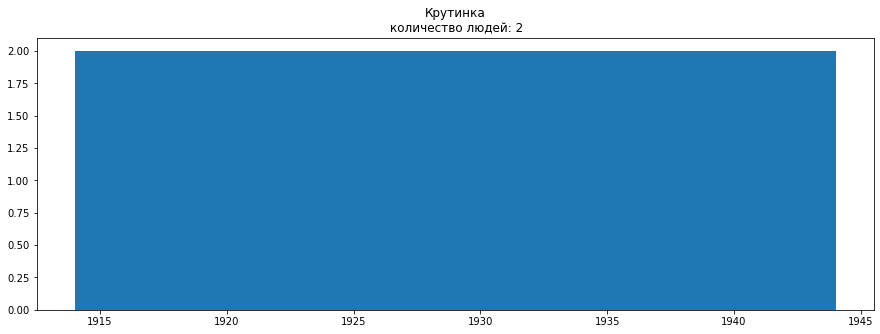

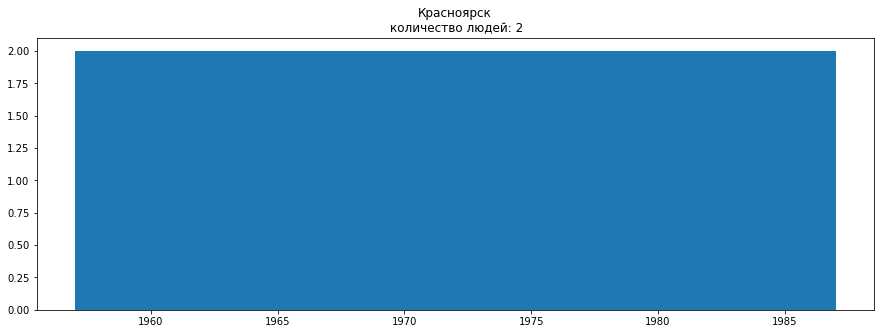

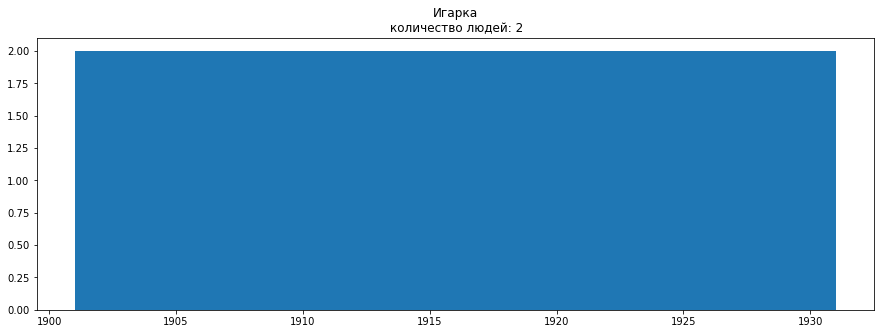

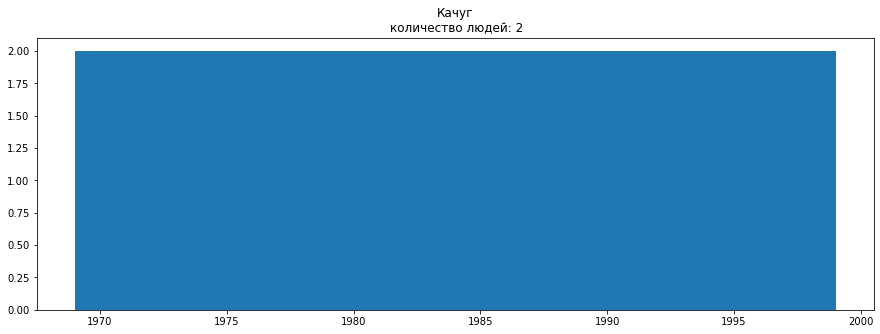

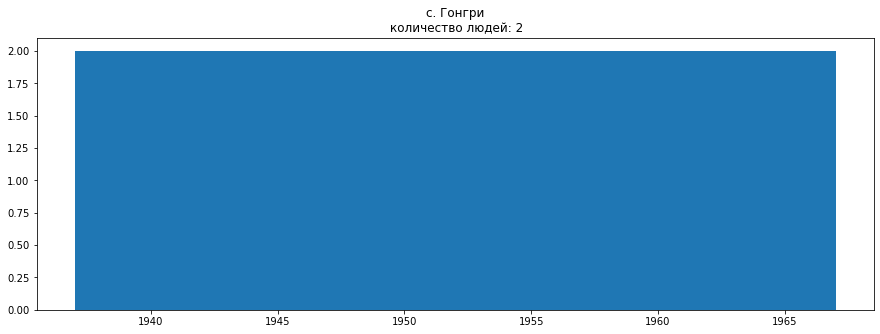

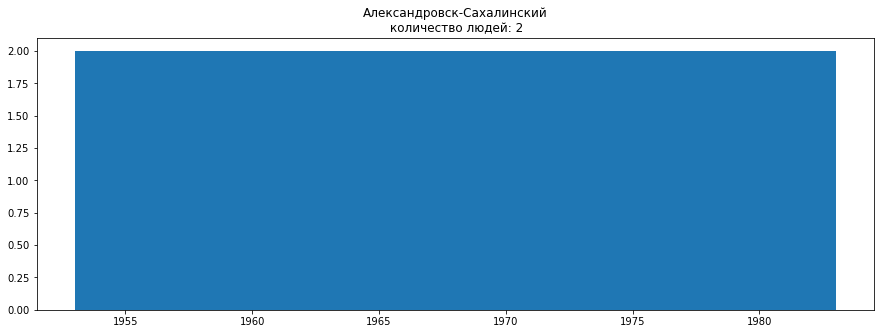

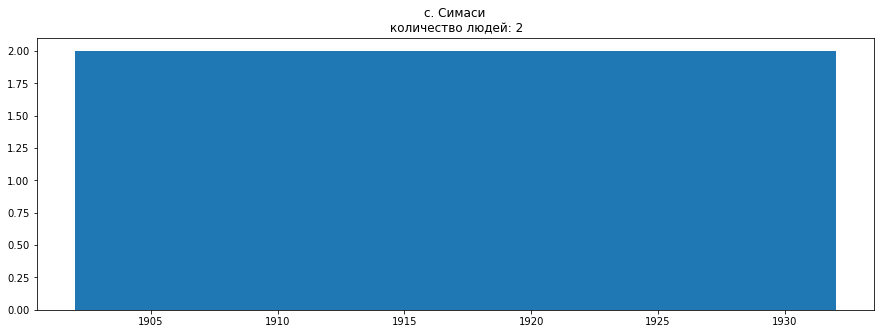

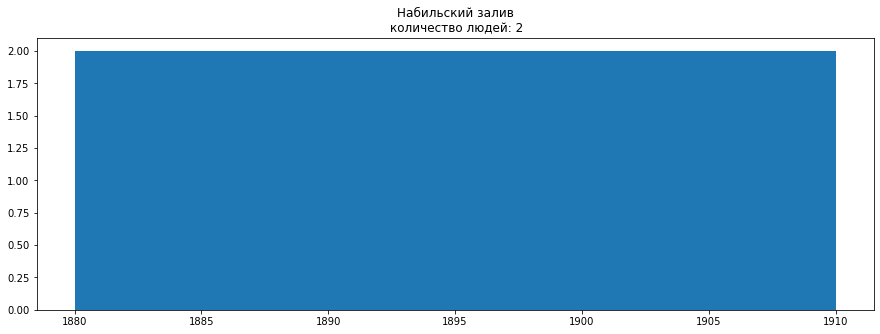

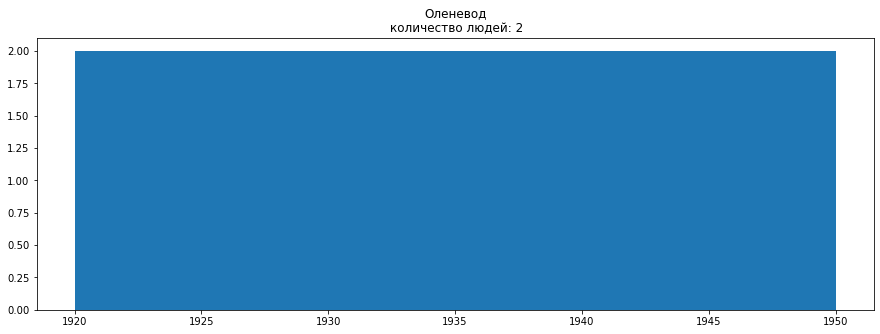

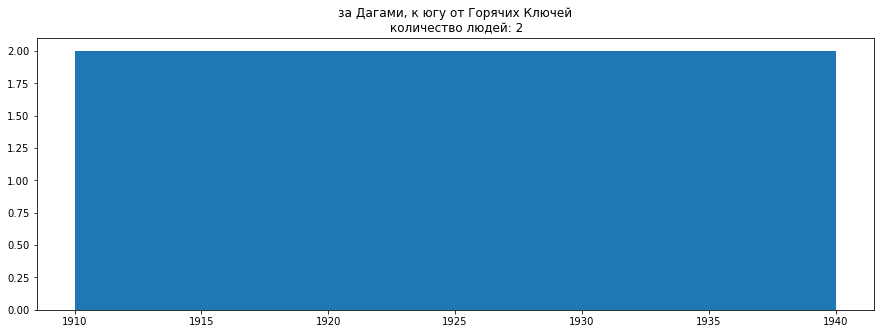

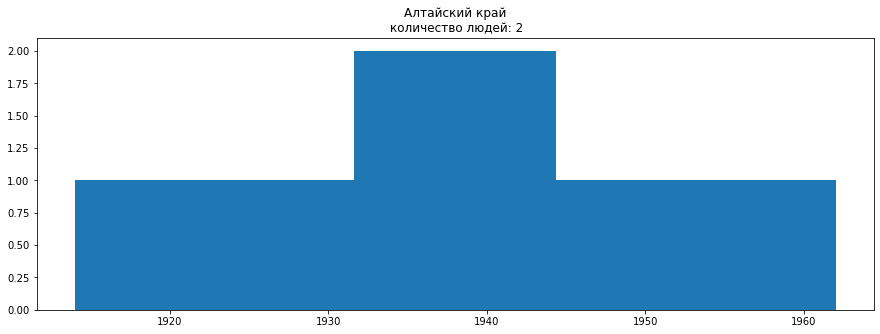

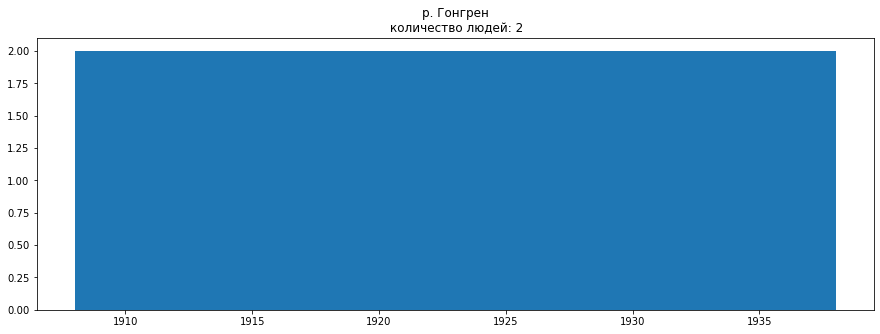

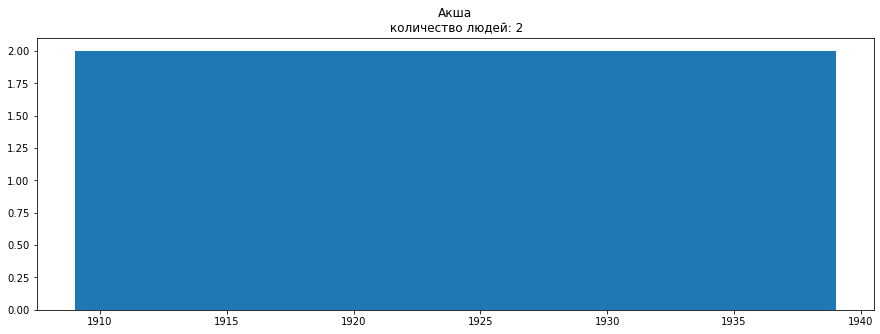

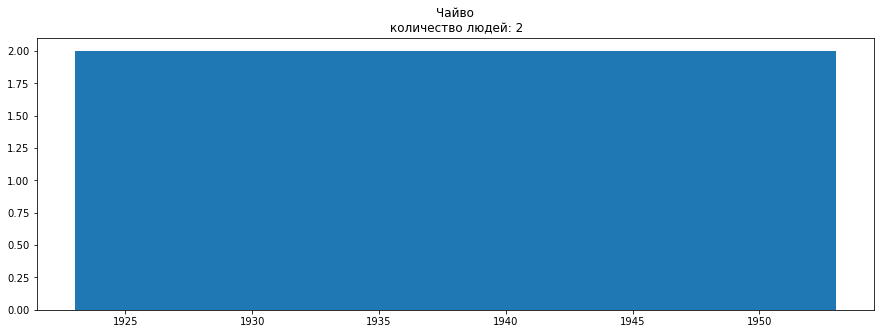

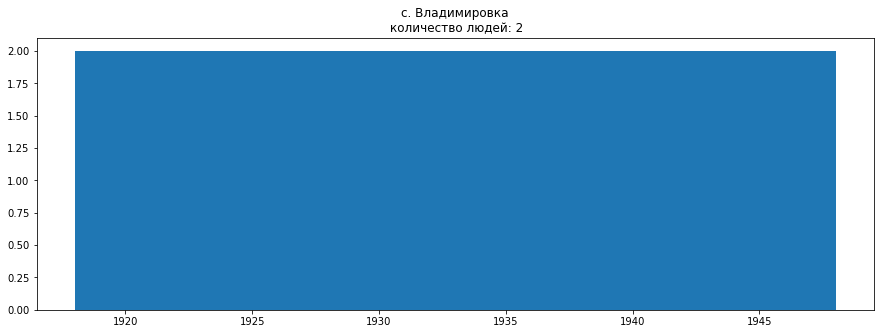

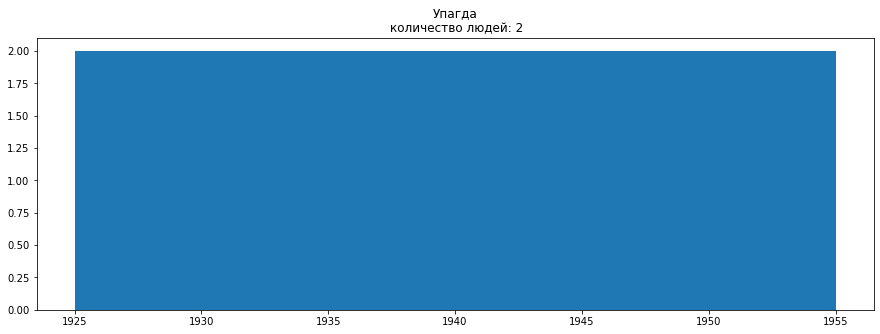

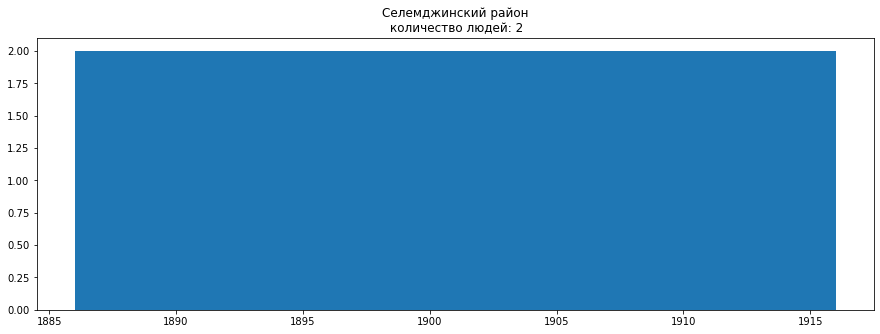

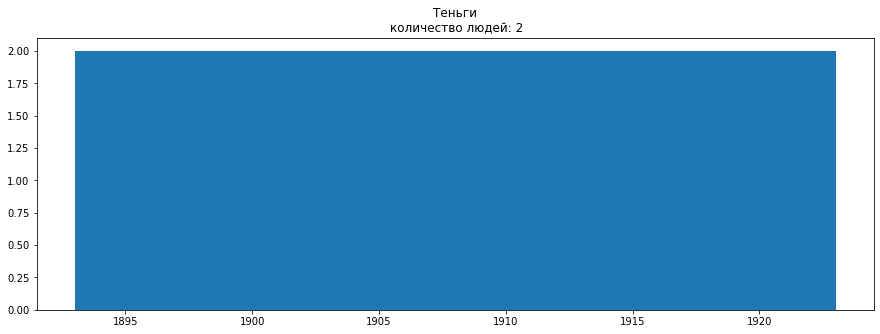

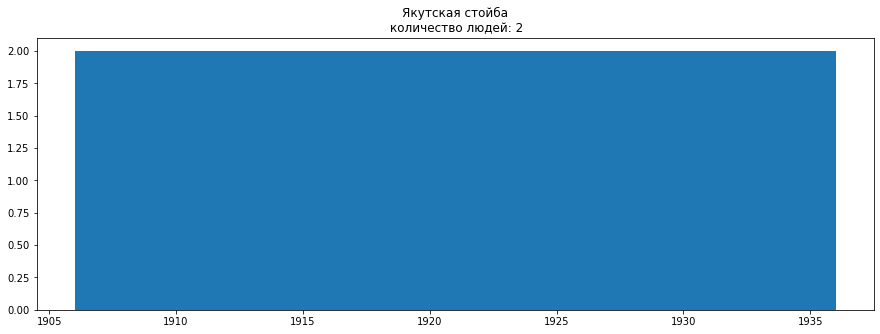

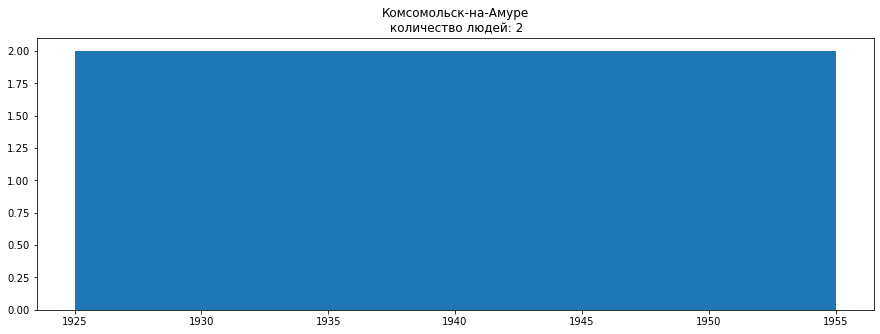

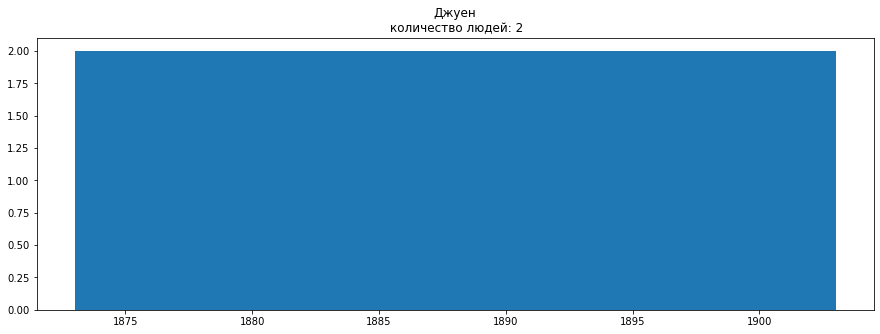

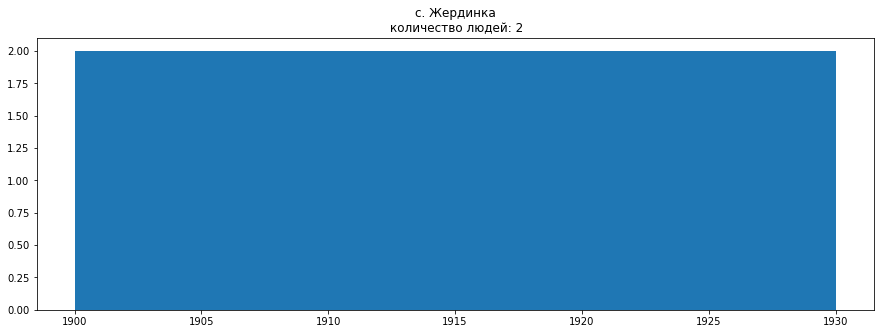

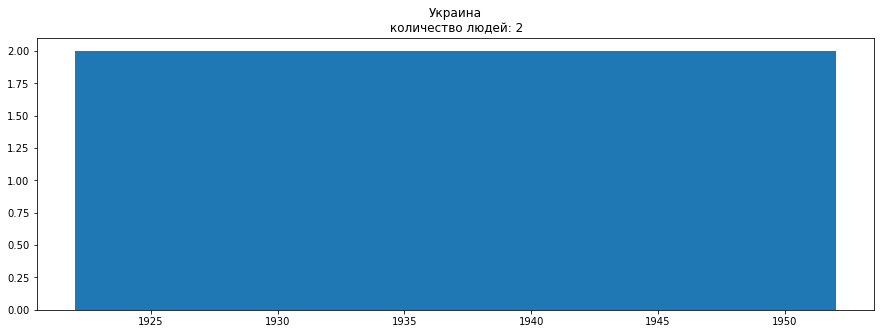

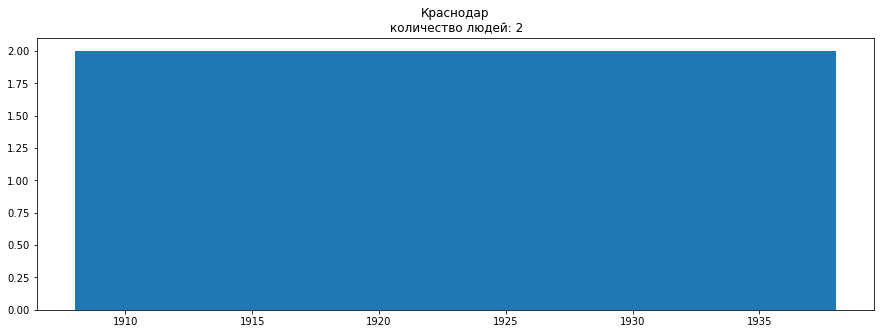

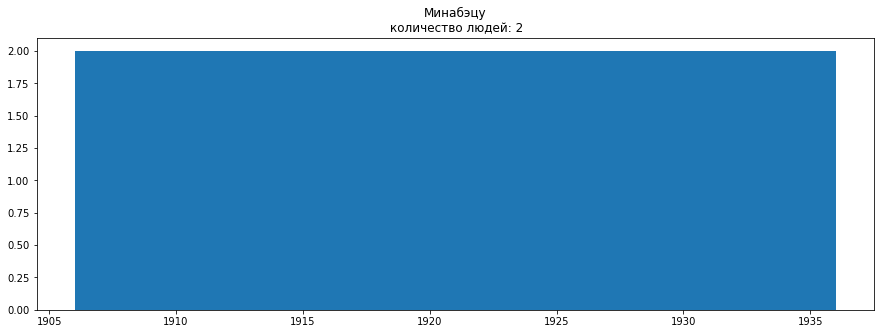

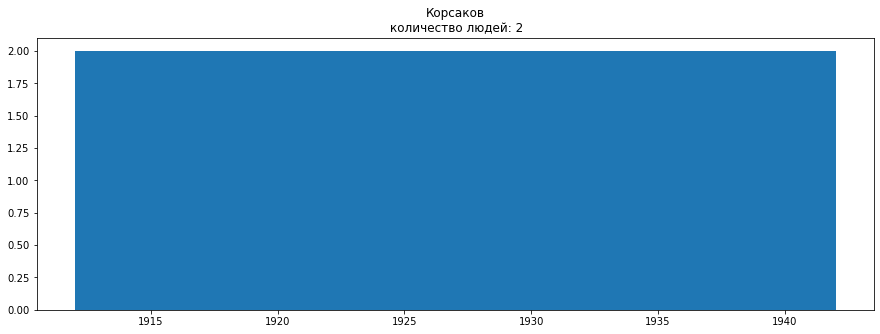

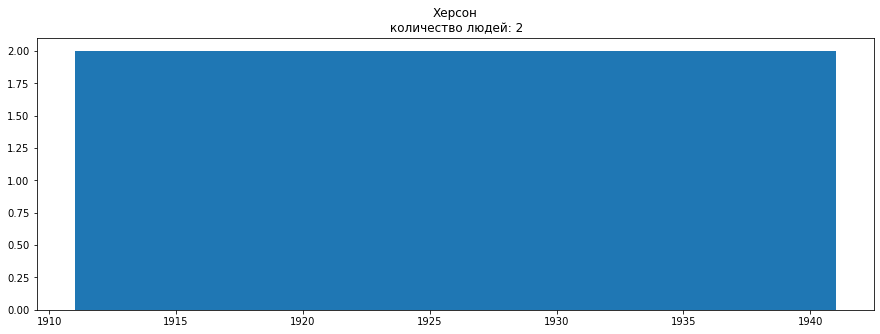

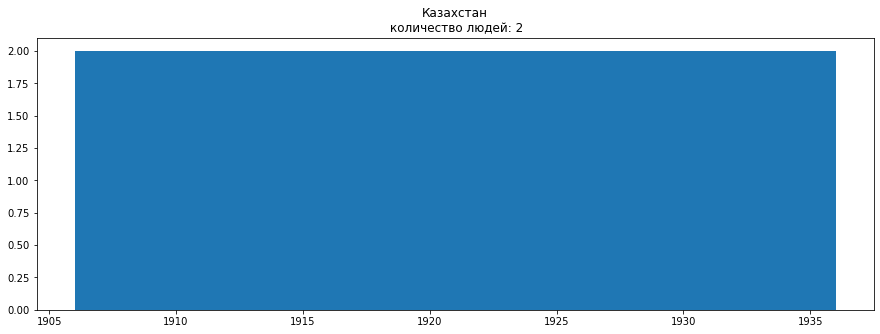

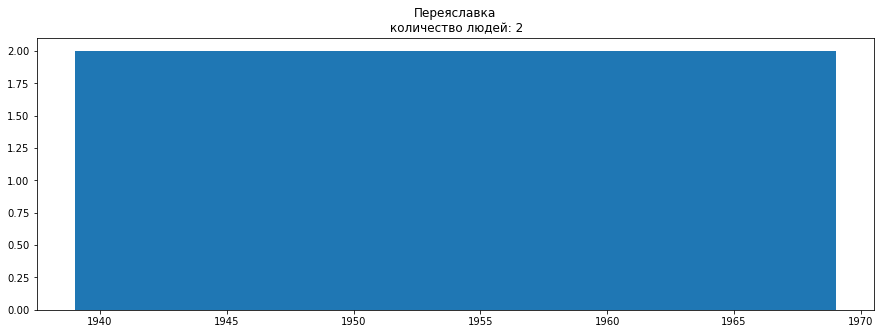

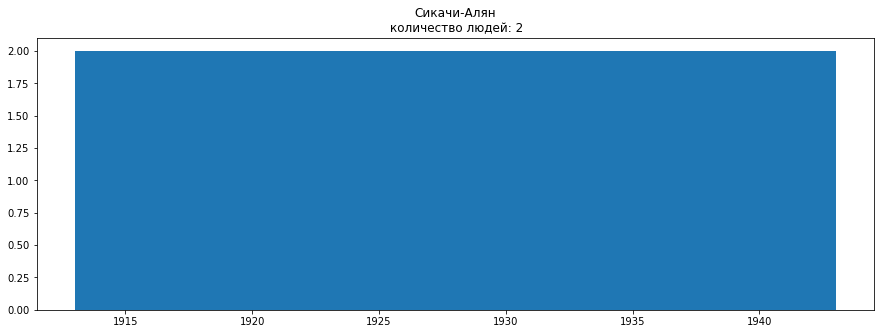

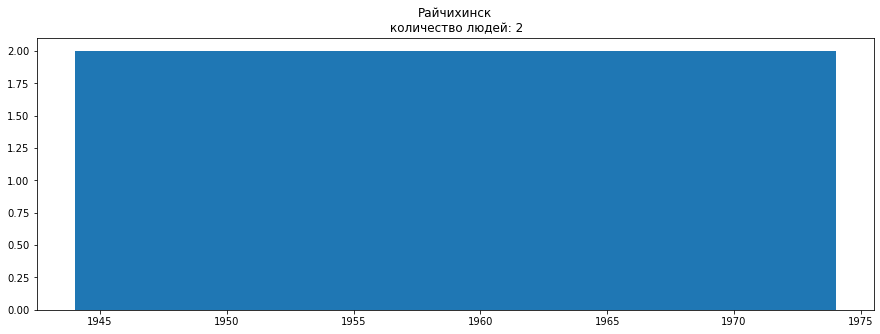

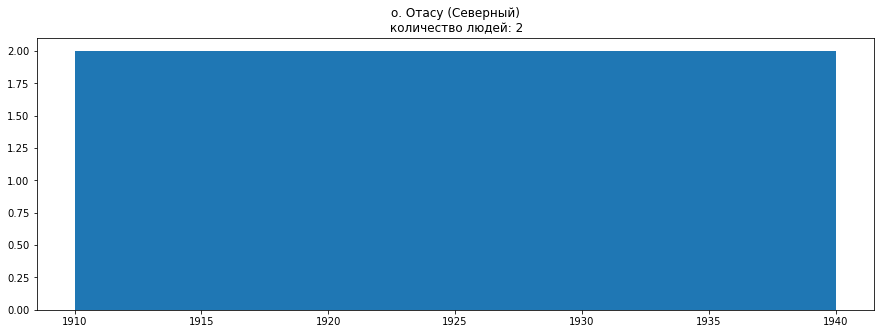

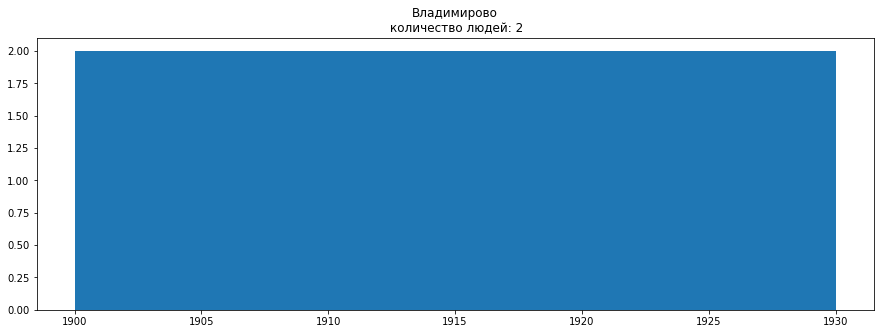

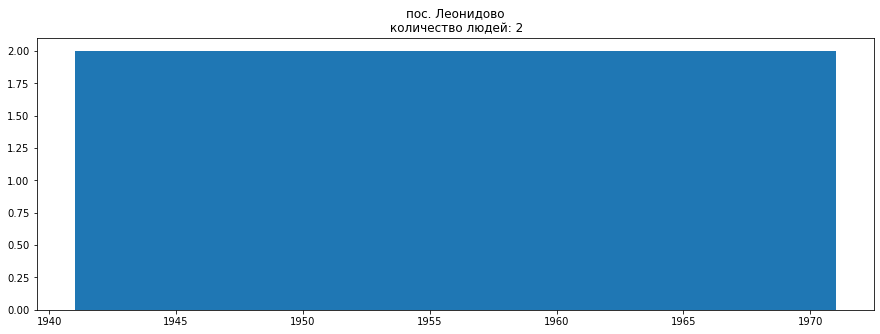

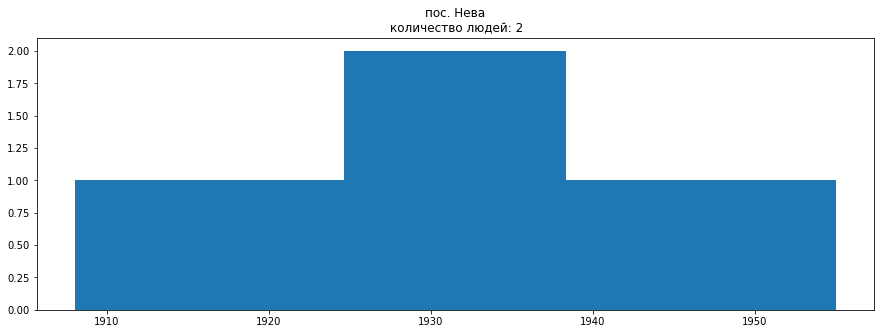

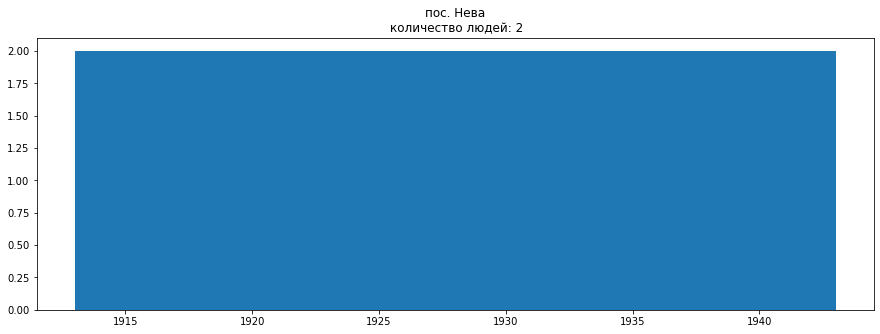

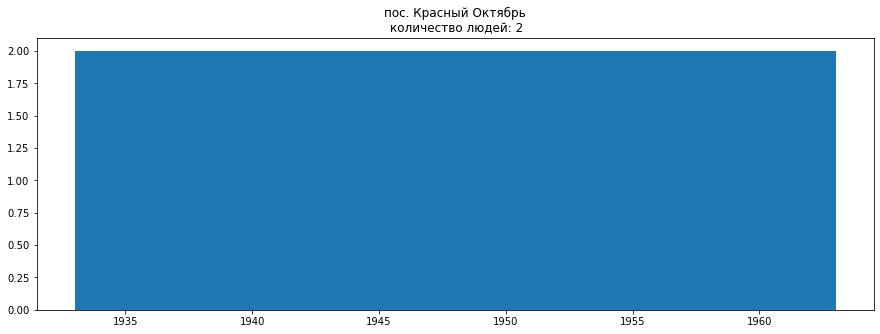

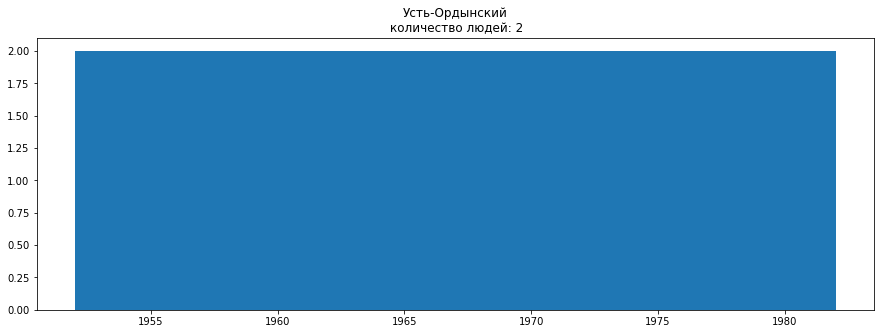

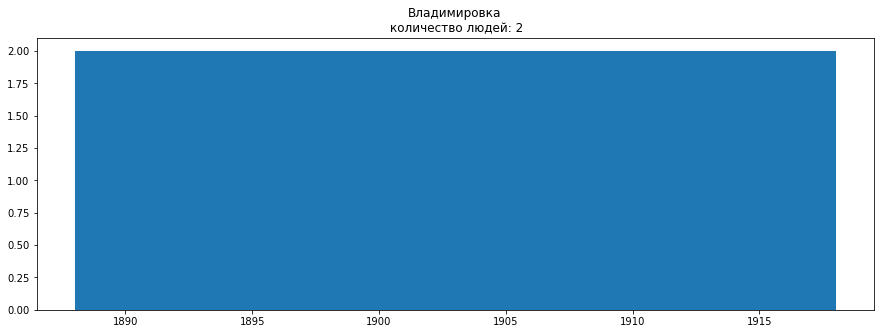

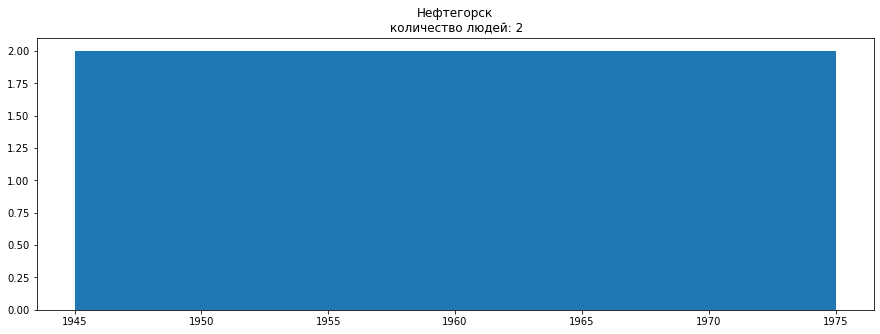

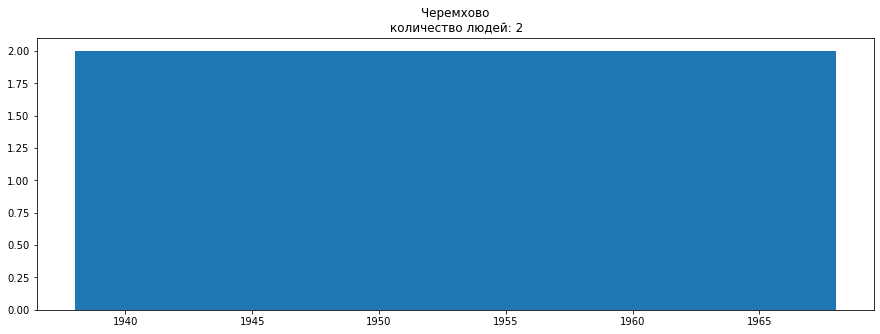

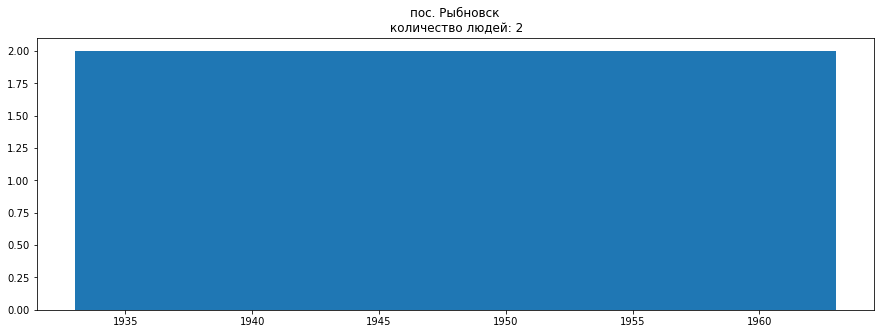

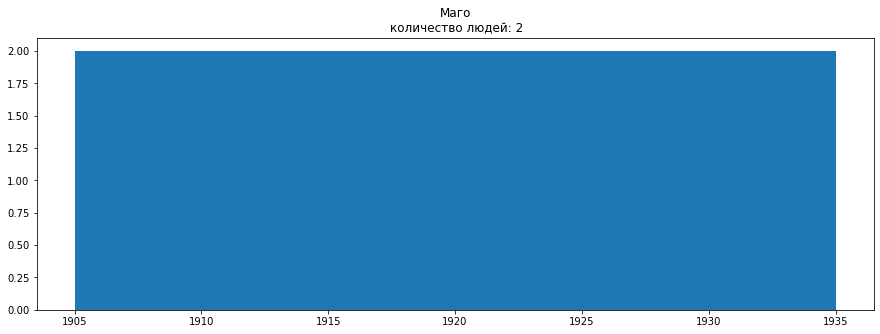

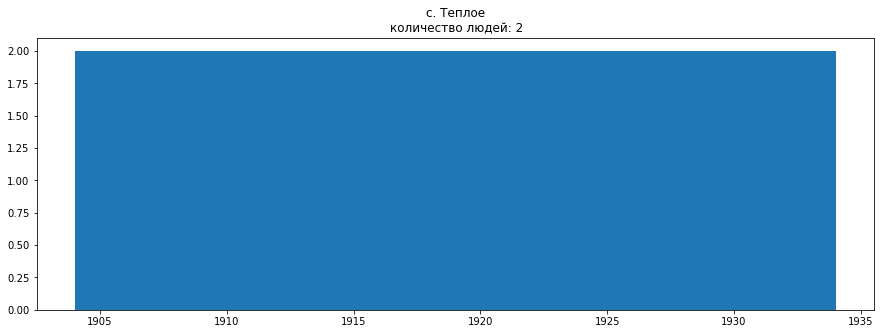

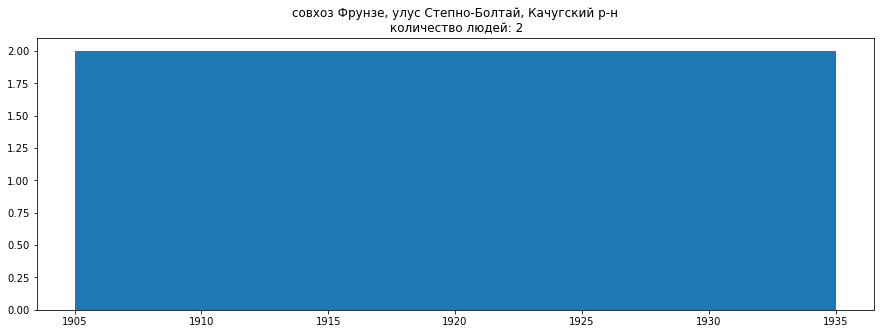

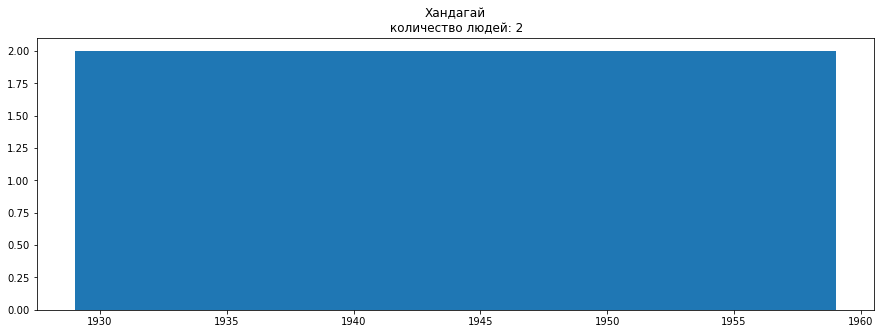

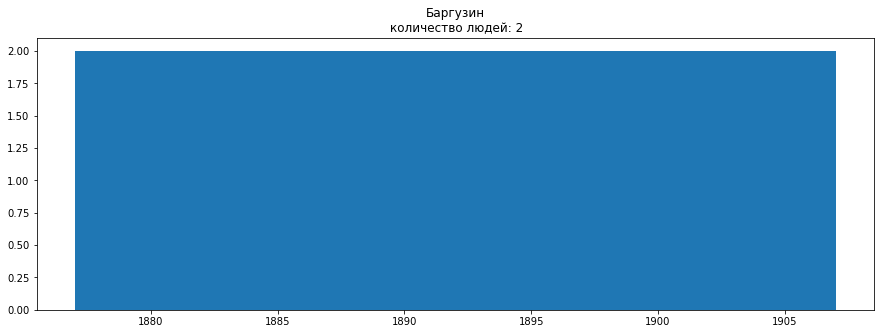

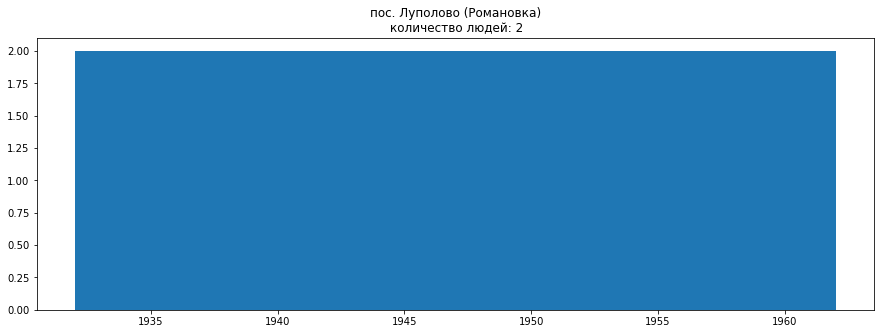

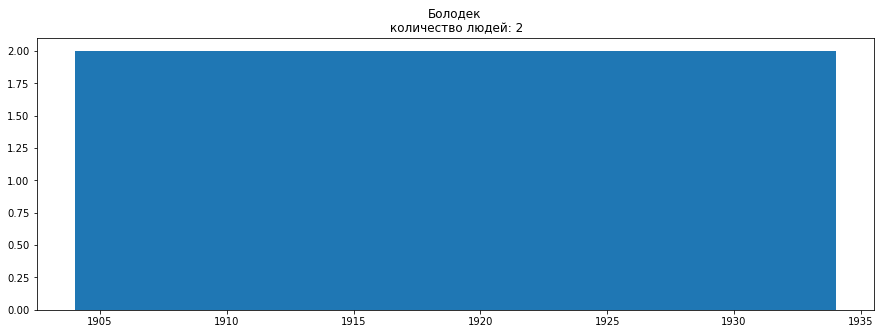

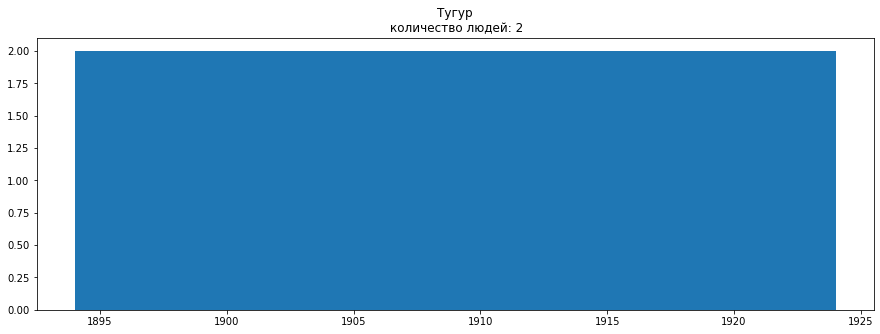

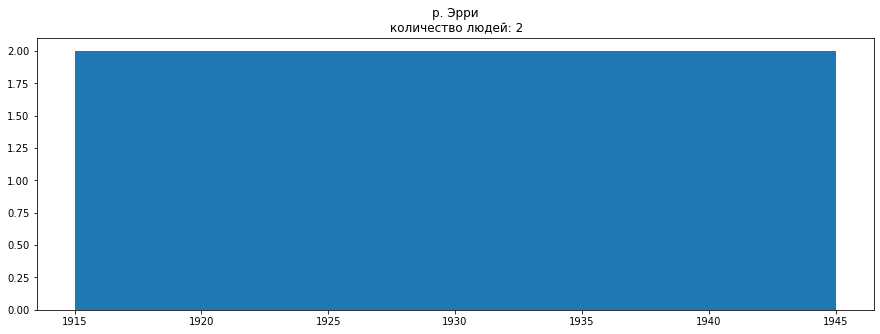

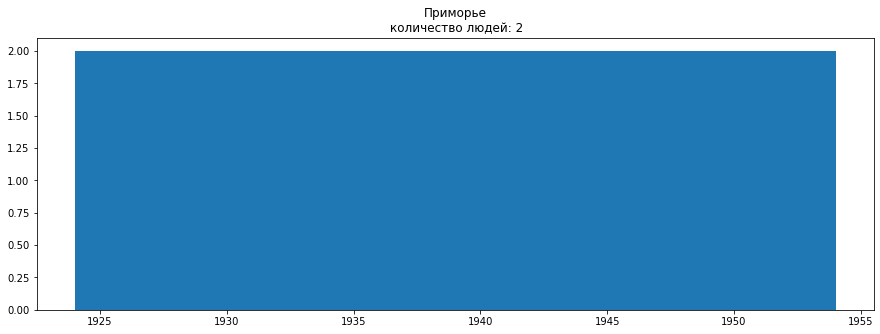

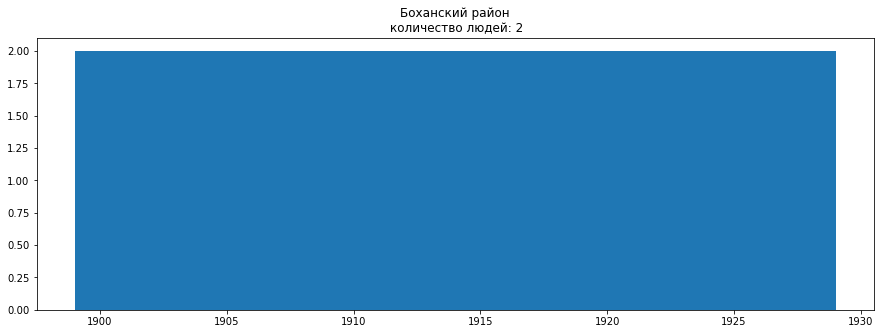

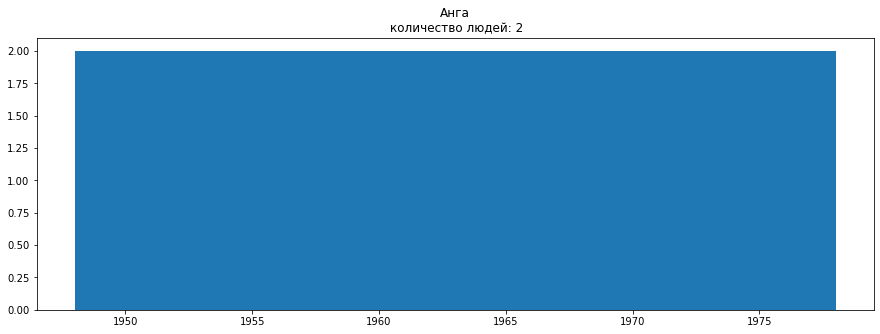

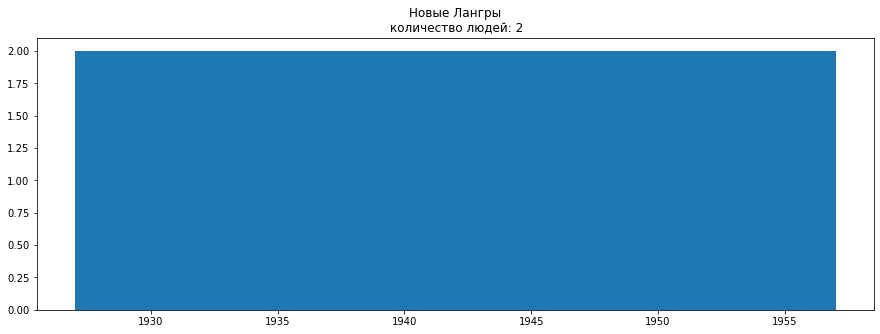

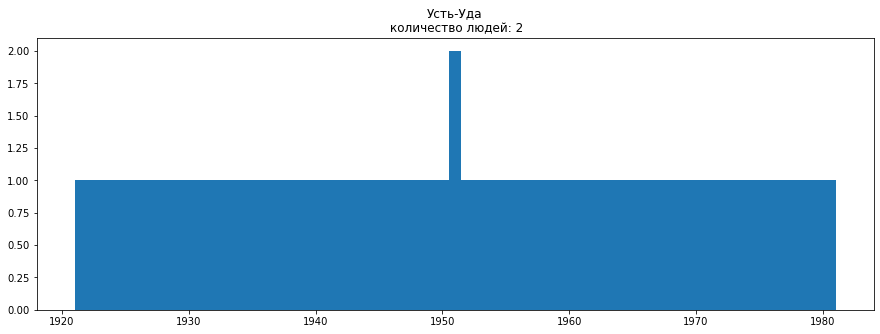

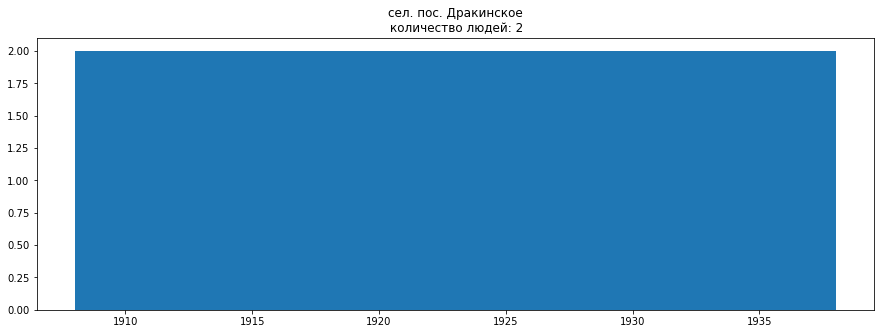

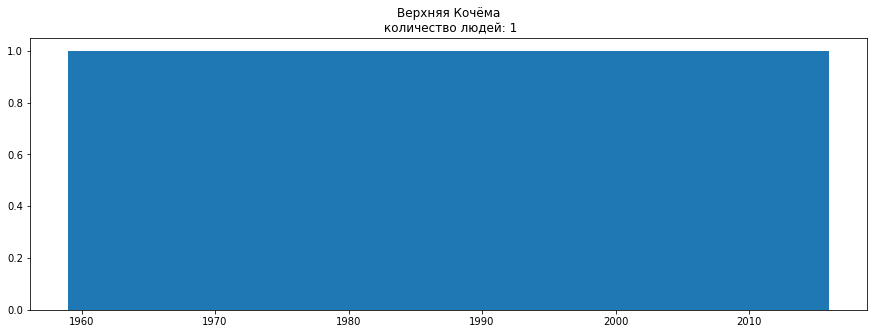

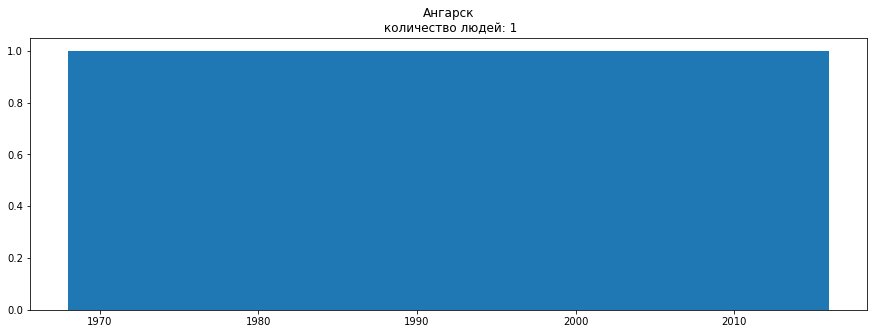

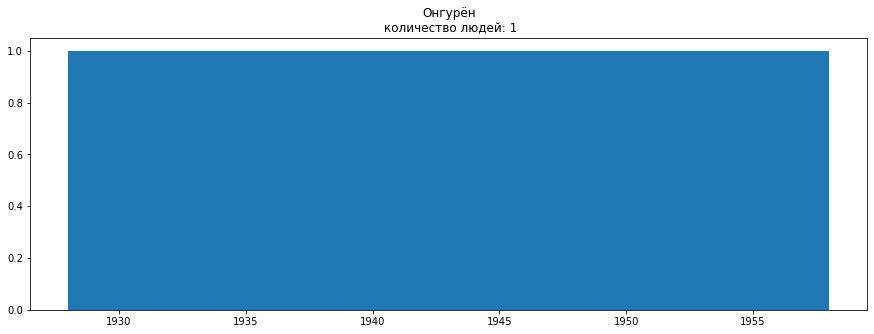

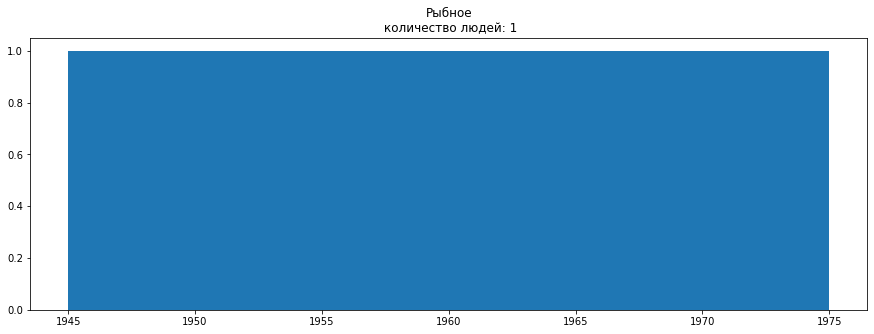

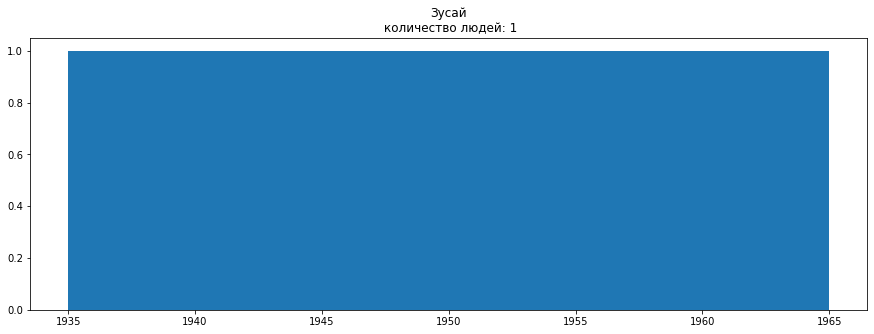

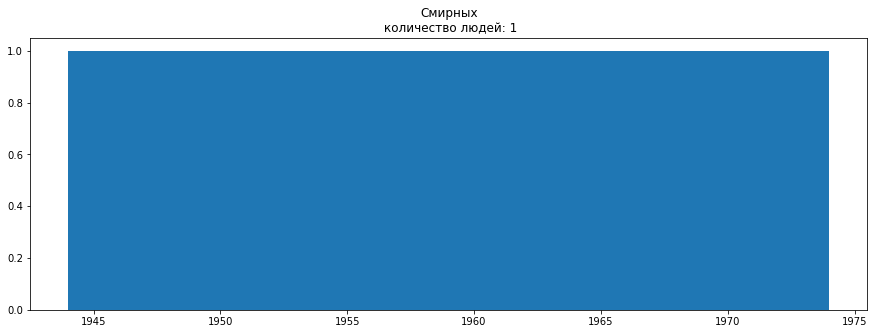

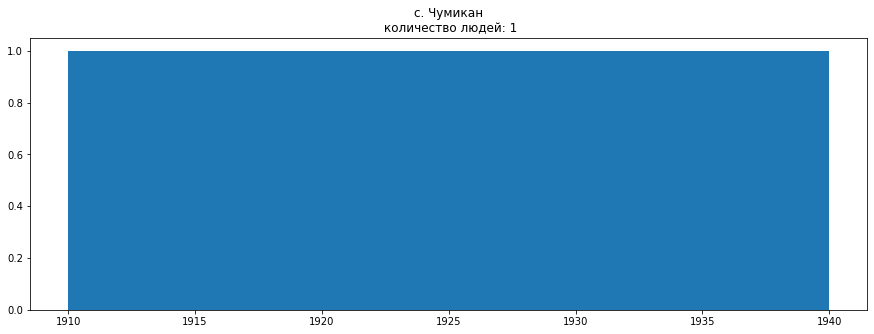

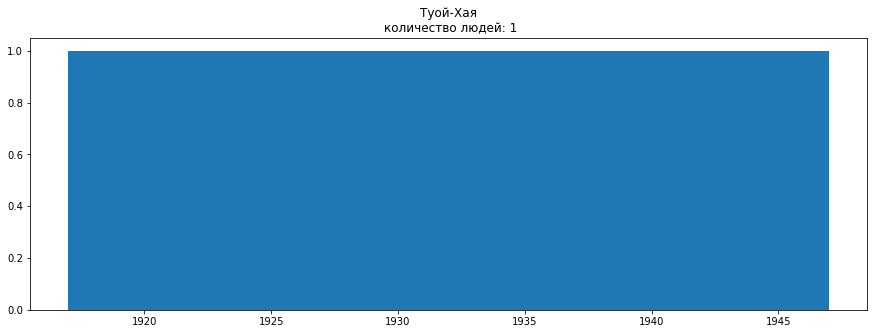

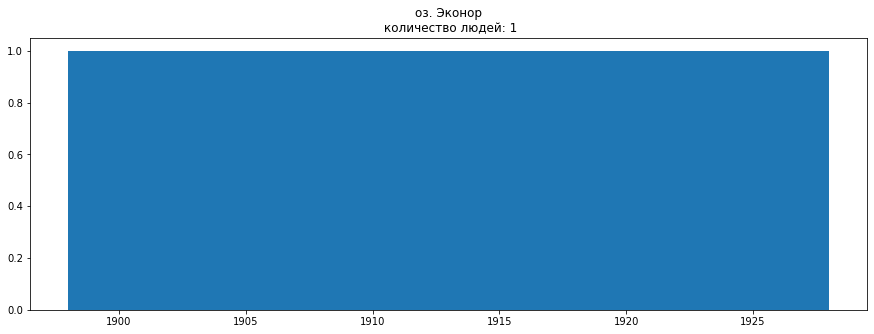

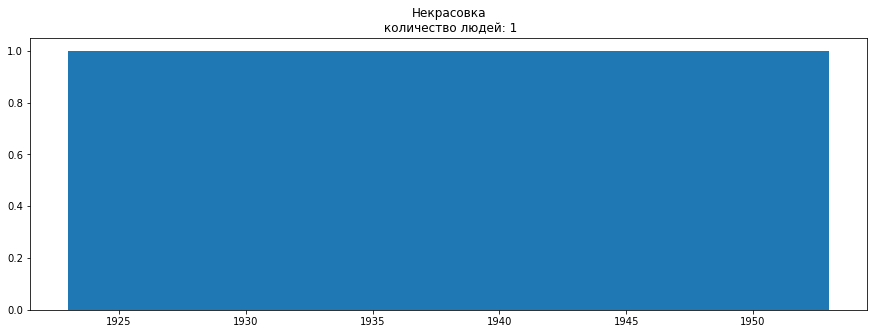

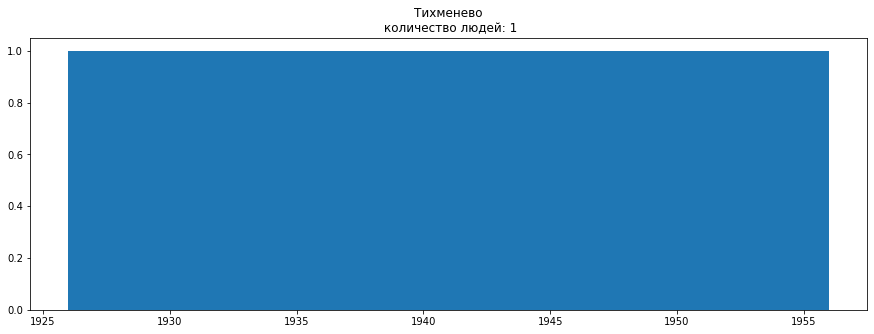

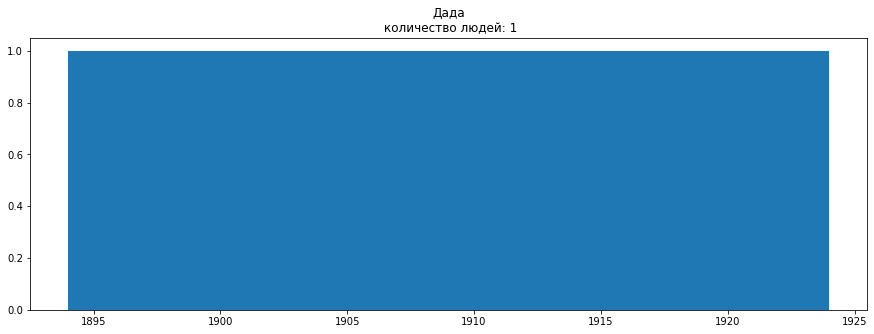

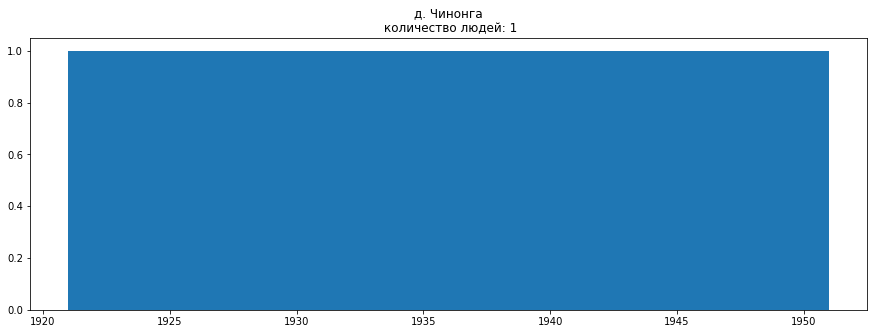

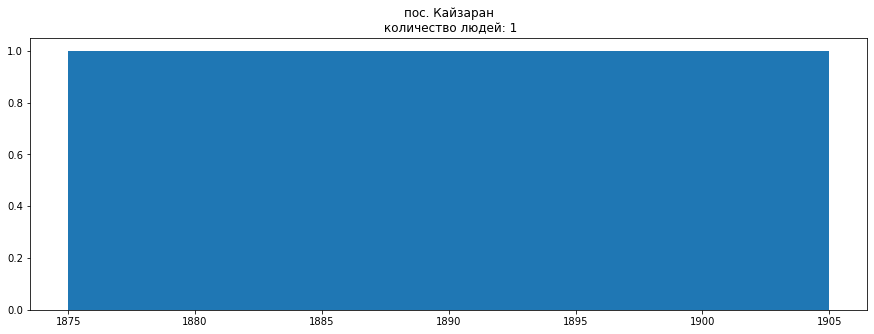

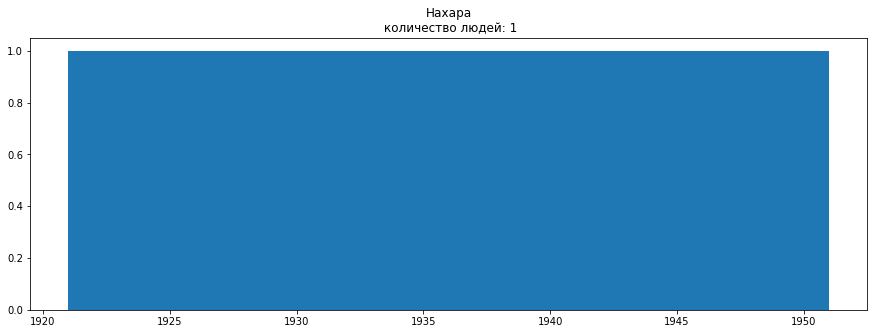

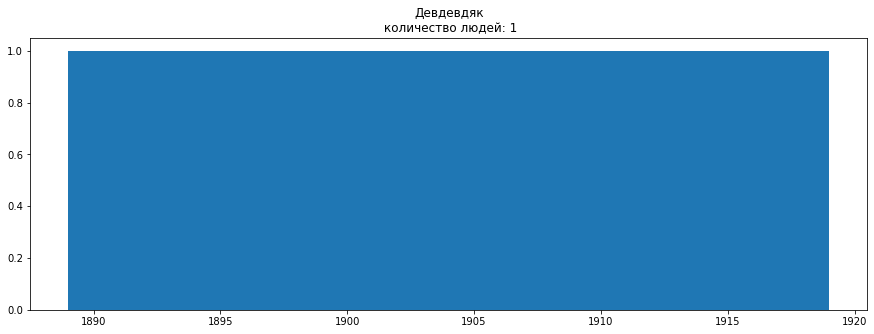

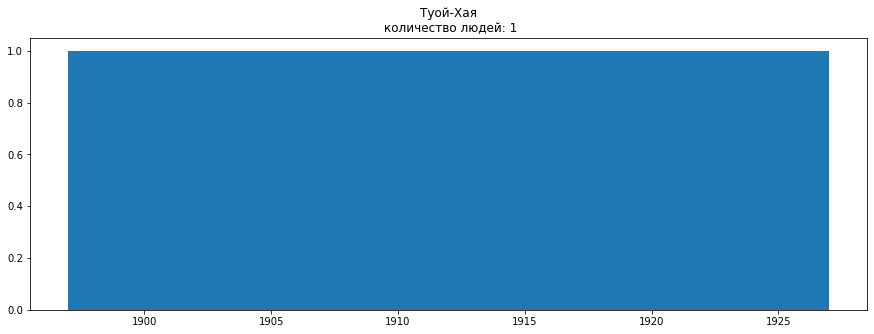

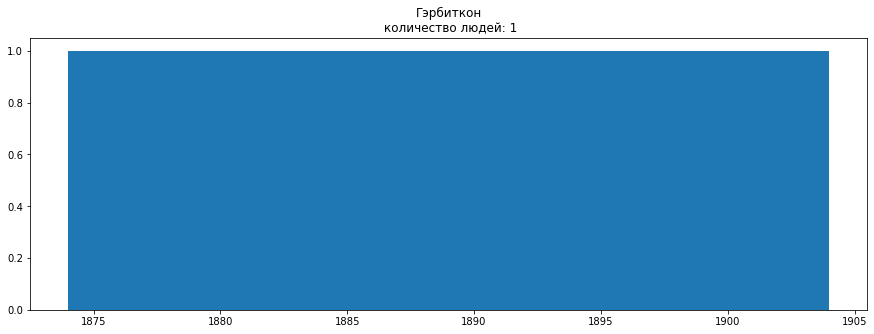

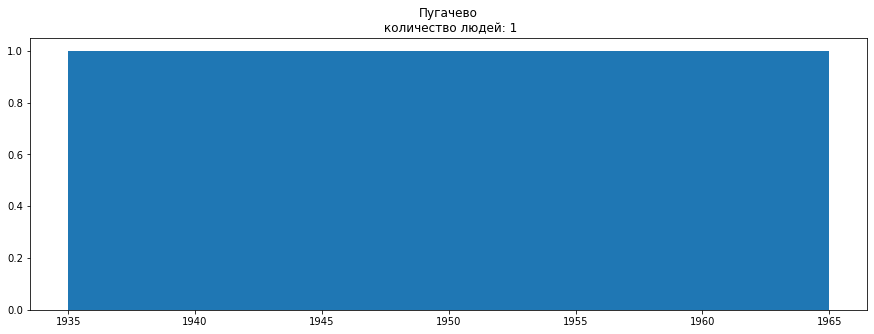

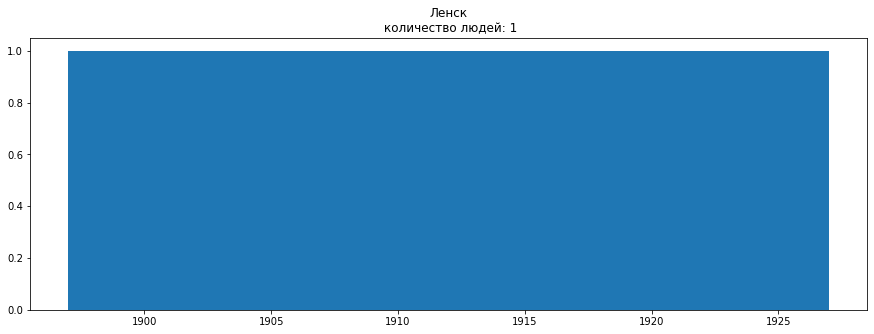

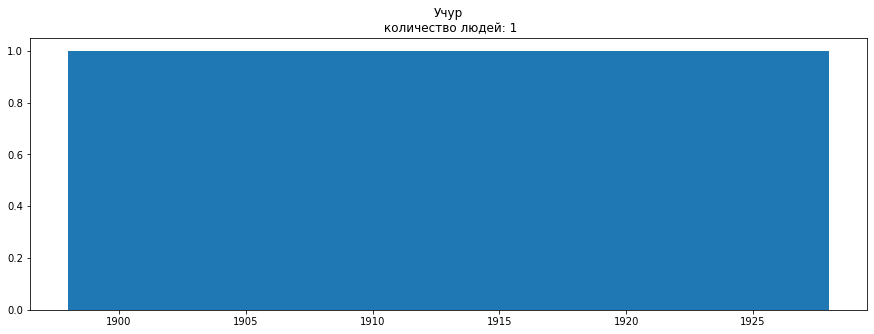

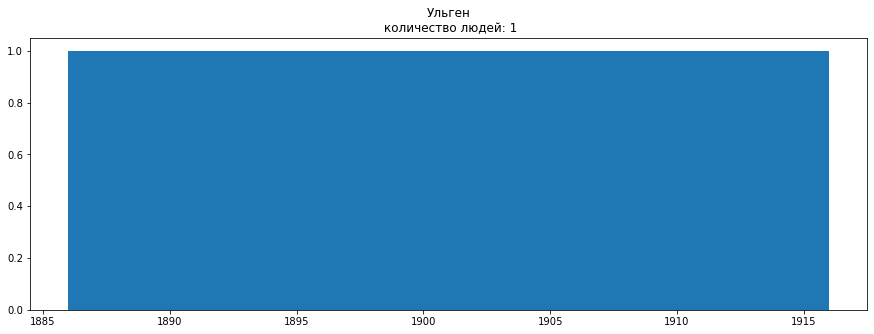

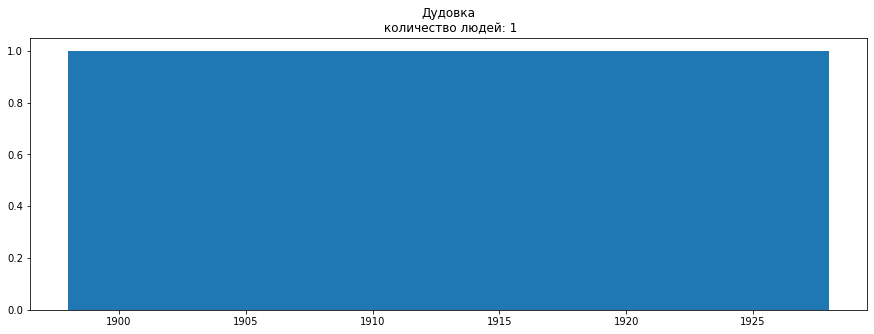

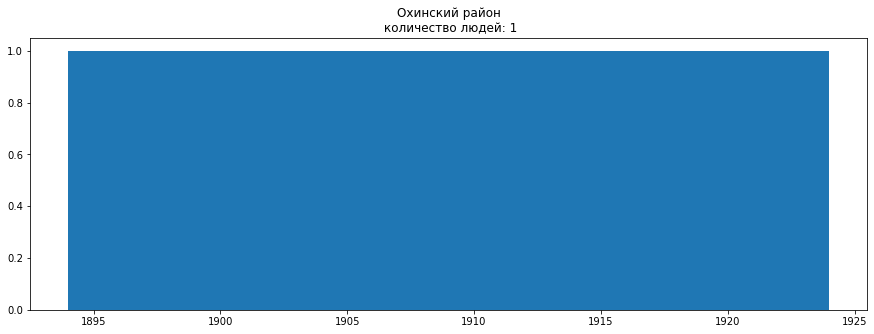

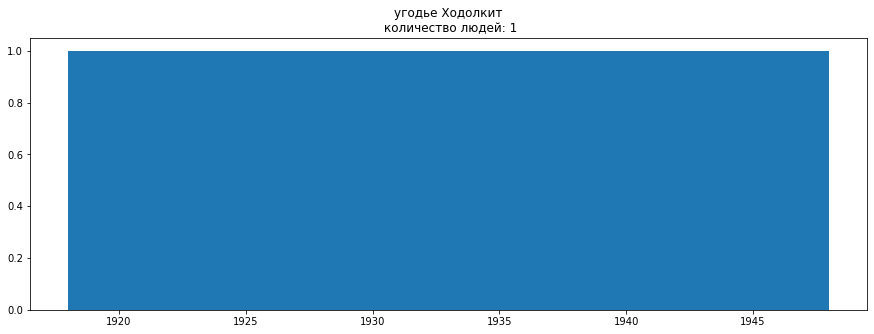

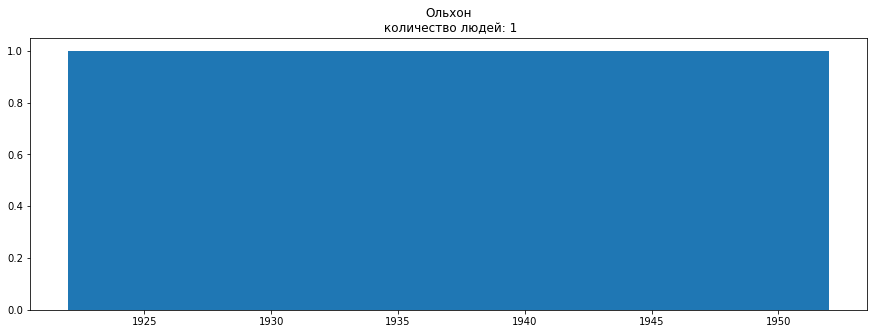

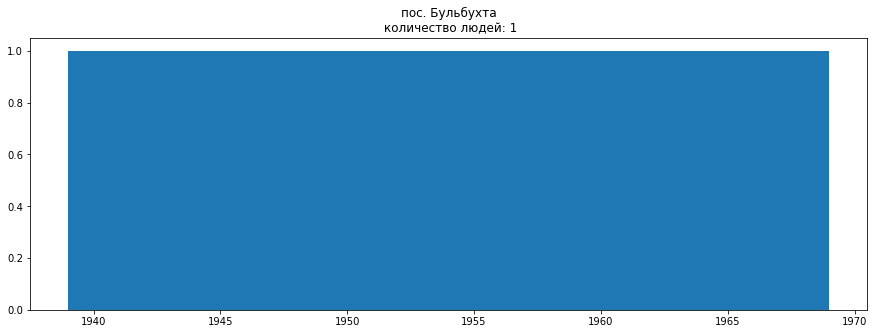

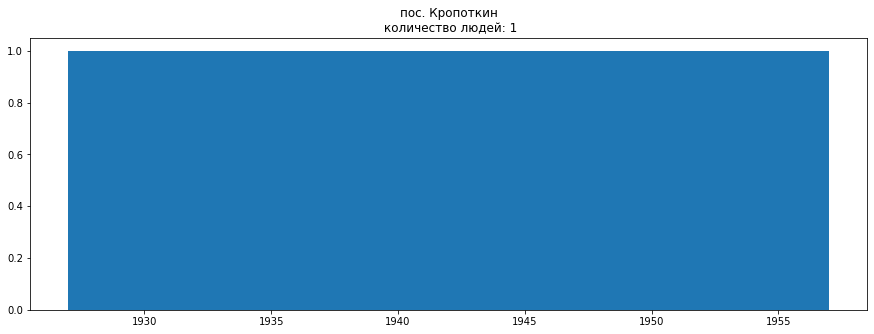

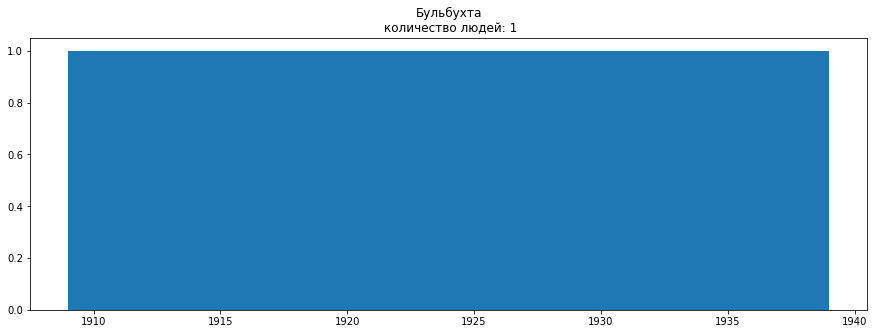

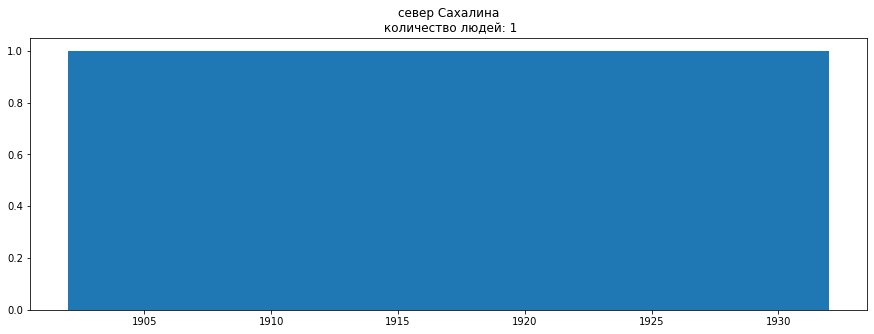

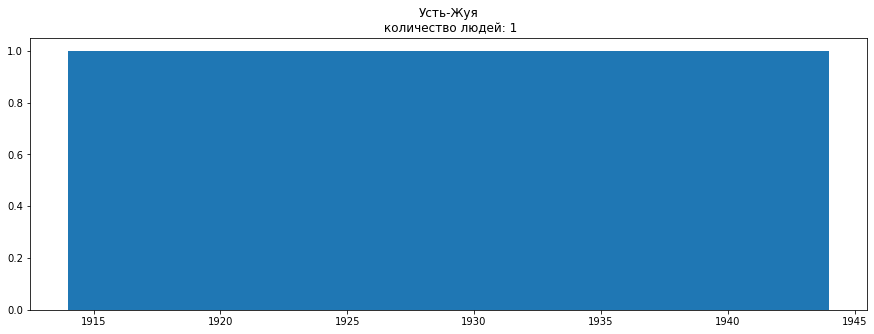

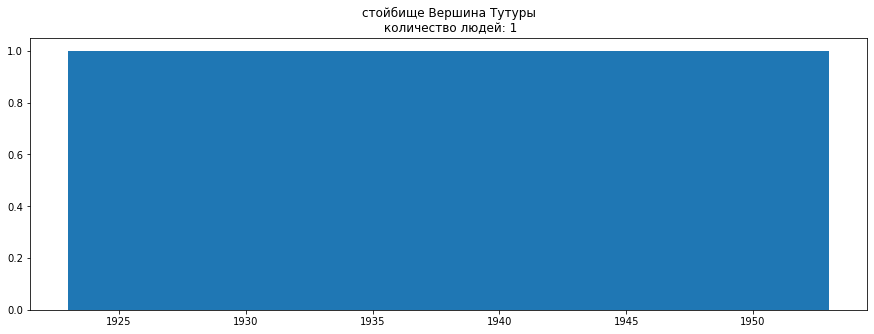

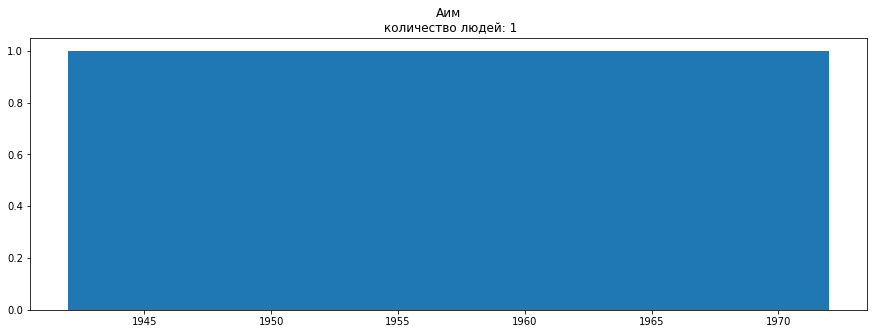

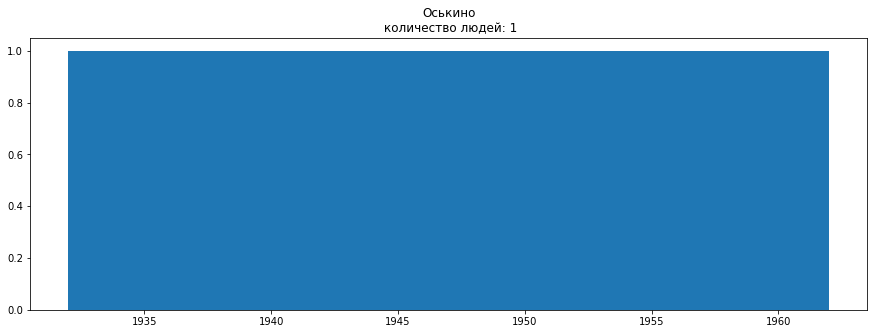

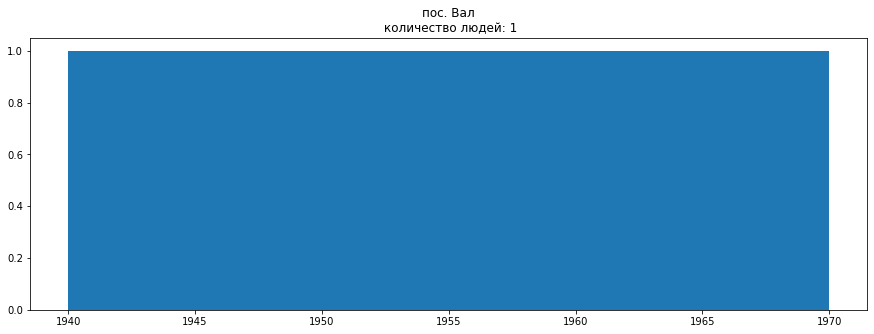

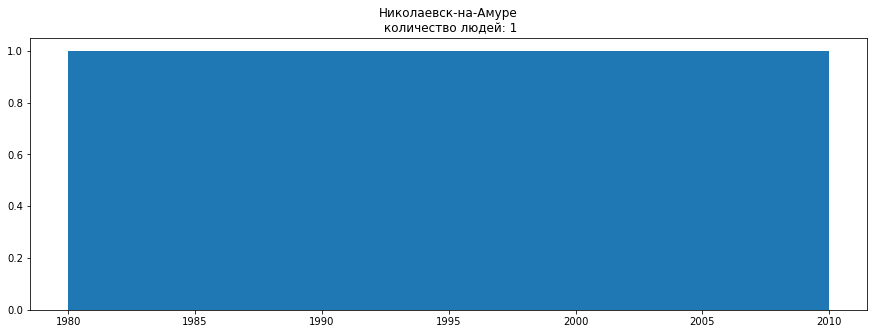

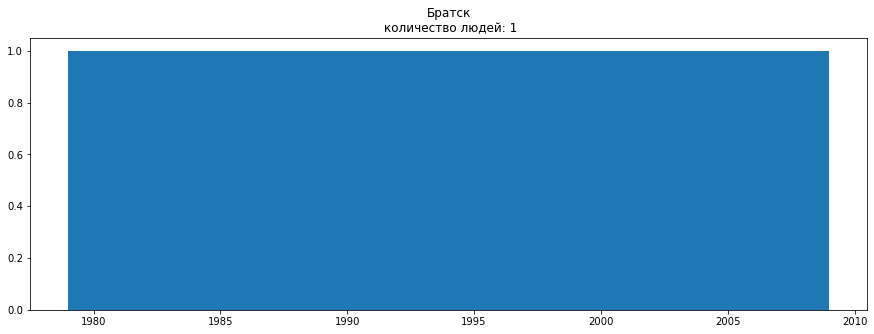

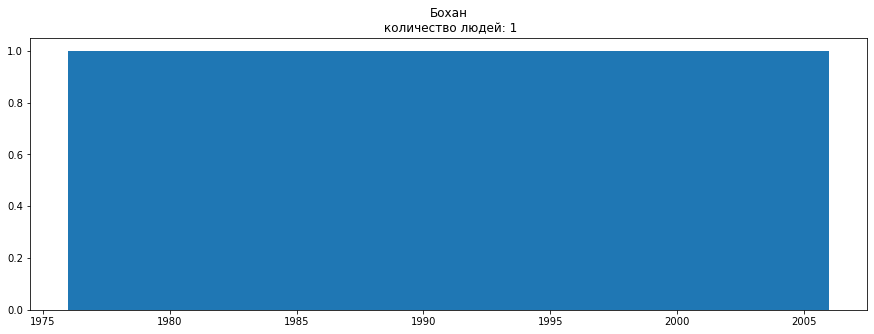

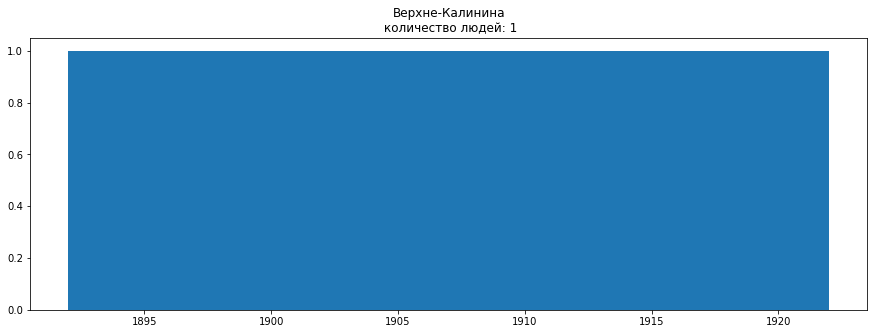

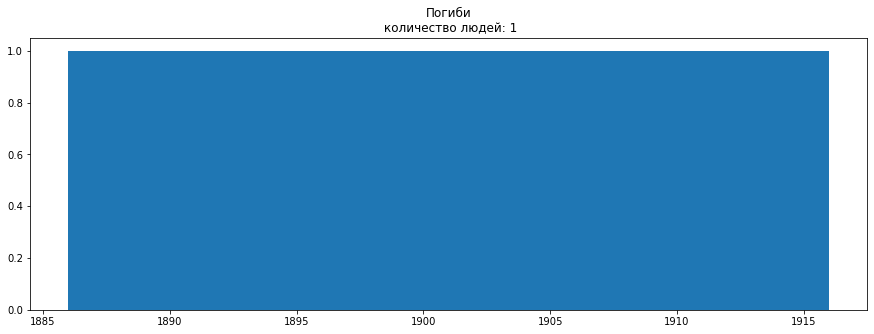

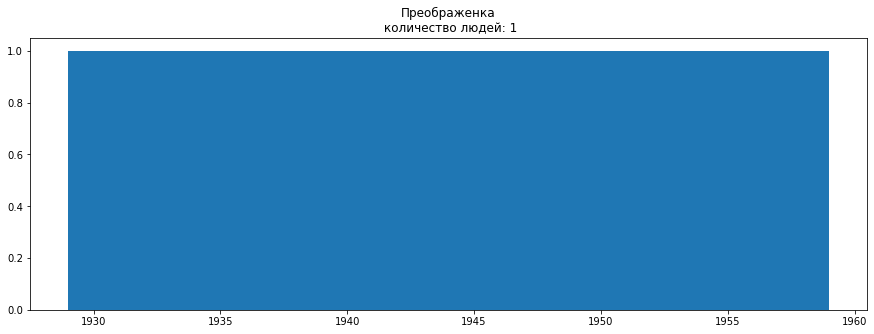

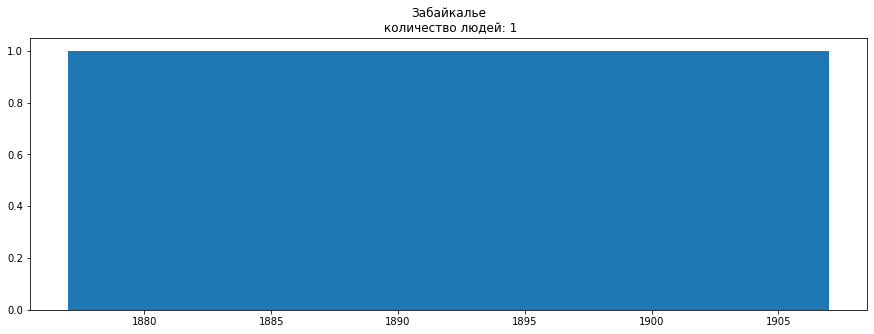

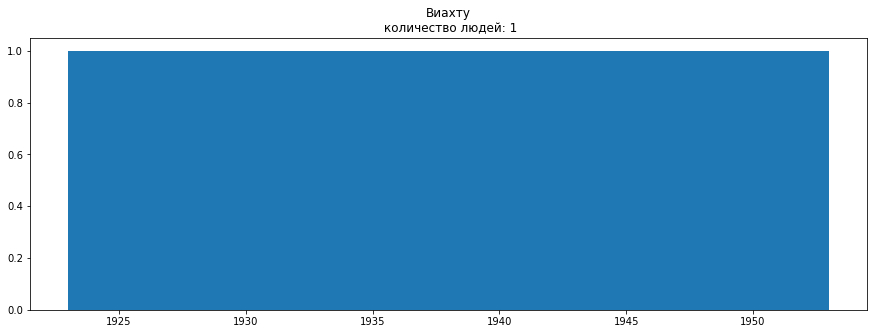

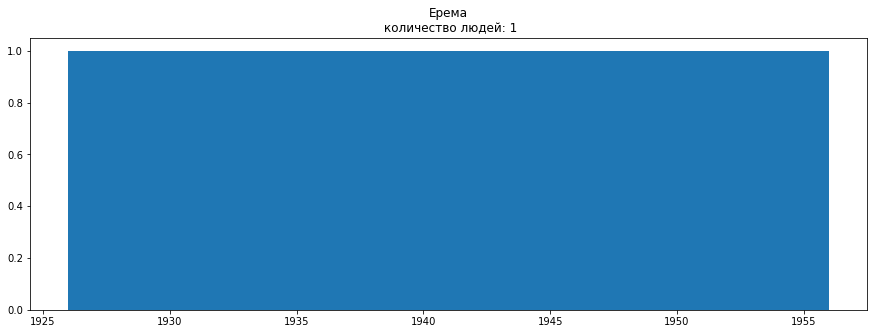

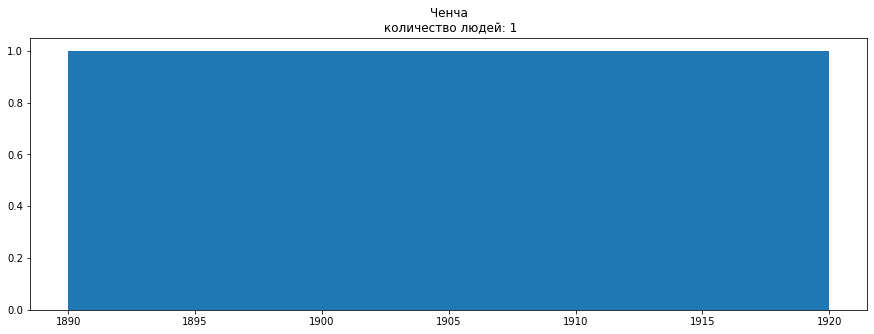

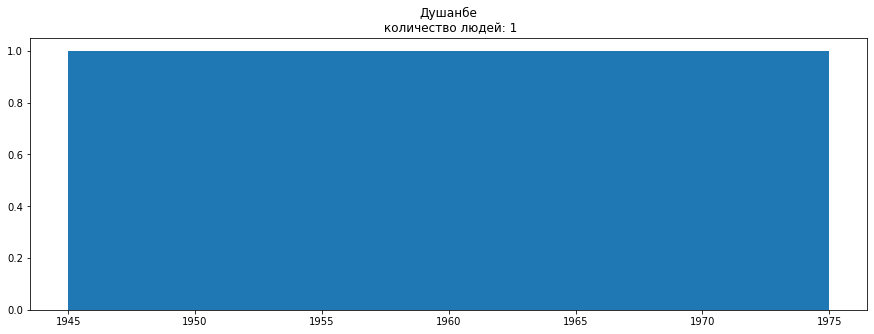

In [5]:
to_df = df[['to_place', 'to_place_name', 'to_latitude', 'to_longitude', 'from_year', 'to_year']]
years_all = []
for num, row in to_df.iterrows():
    years = explode_func(row['from_year'], row['to_year'])
    years_all.append(years)
to_df['year'] = years_all
to_df = to_df.explode('year')
agg_to_df = to_df.groupby(['to_latitude', 'to_longitude']).count().sort_values('year', ascending=False)
latitude_longitude = agg_to_df.index.tolist()
for latitude, longitude in latitude_longitude:
    graph = to_df[(to_df['to_latitude']  == latitude)&(to_df['to_longitude']  == longitude)]
    place_name = ', '.join(graph['to_place_name'].unique().tolist())
    years = sorted(graph['year'].tolist())
    number_of_people = df[(df['to_latitude'] == latitude)&
        (df['to_longitude'] == longitude)].shape[0]
    plt.figure(figsize=(15,5))
    plt.hist(years, bins=(max(years)-min(years) + 1))
    plt.title(place_name + '\n количество людей: ' + str(number_of_people))
    plt.show()

Отток населения.

<ipython-input-6-dc668e96c68a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from_df['year'] = years_all


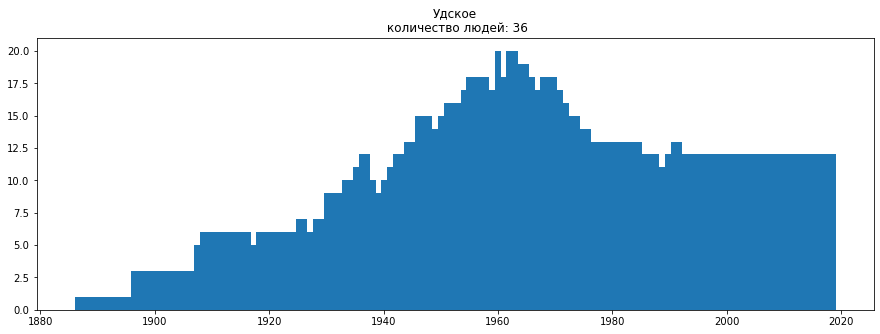

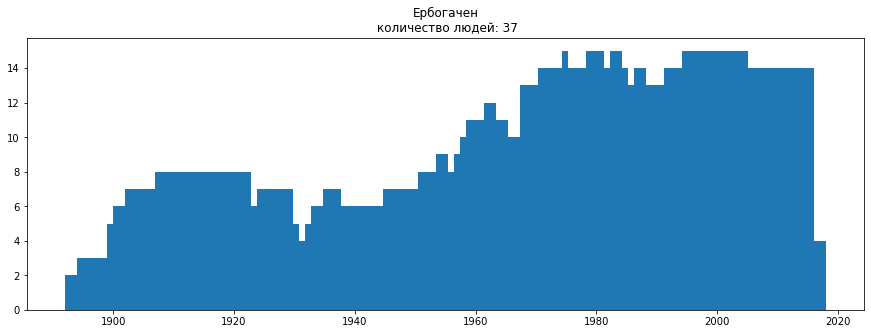

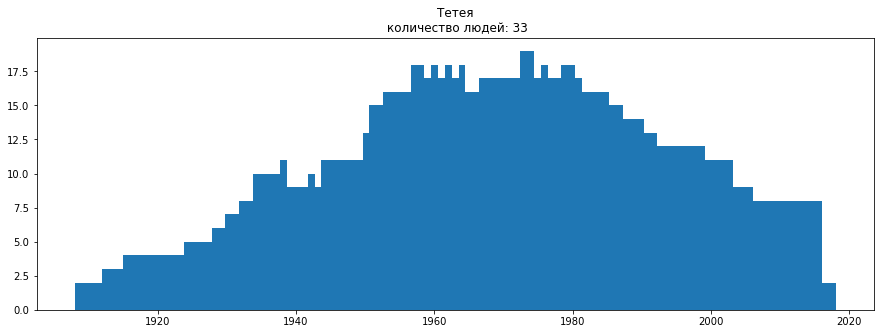

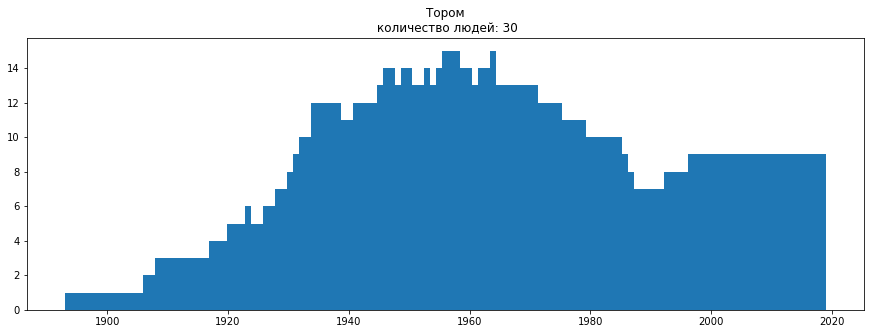

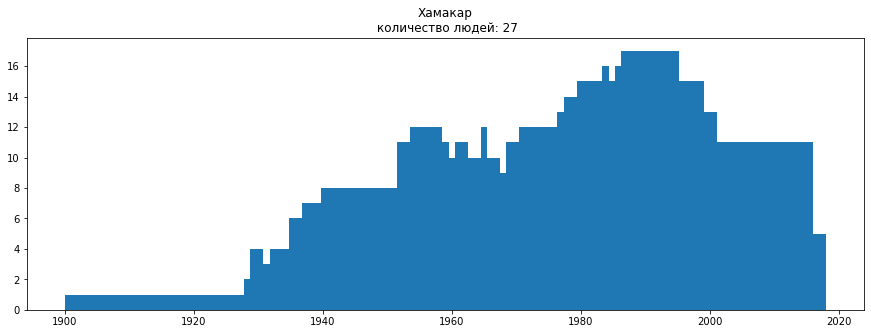

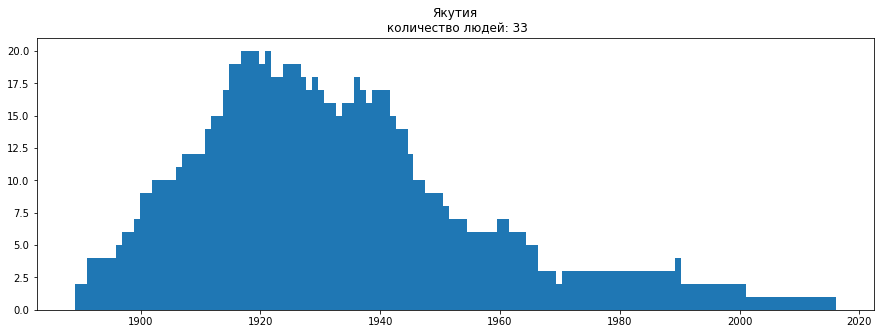

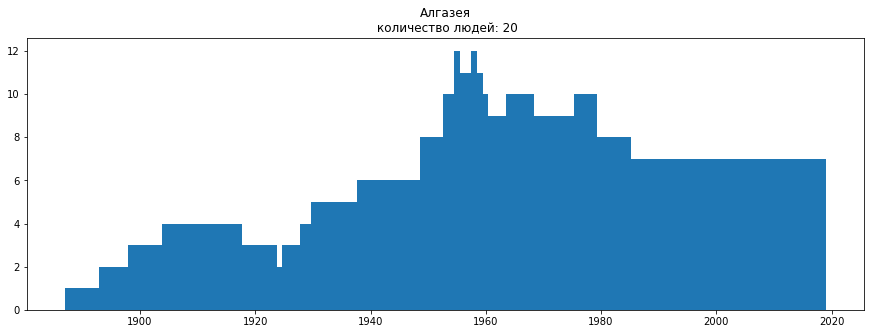

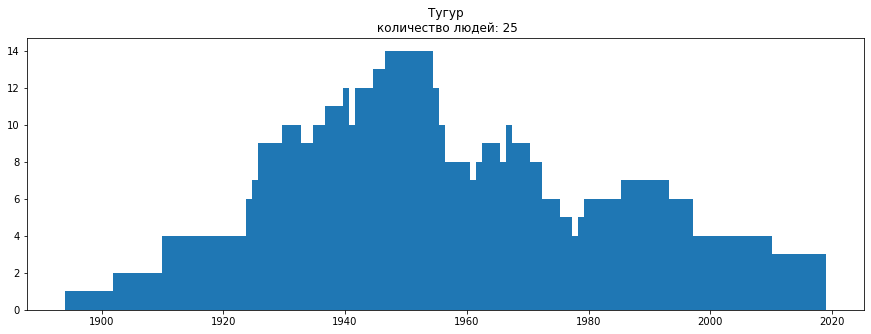

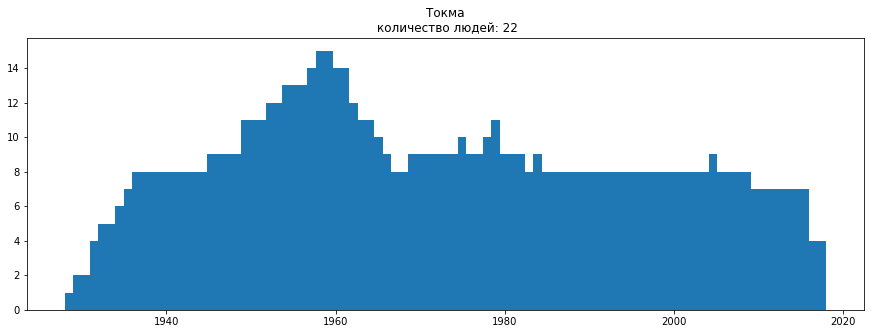

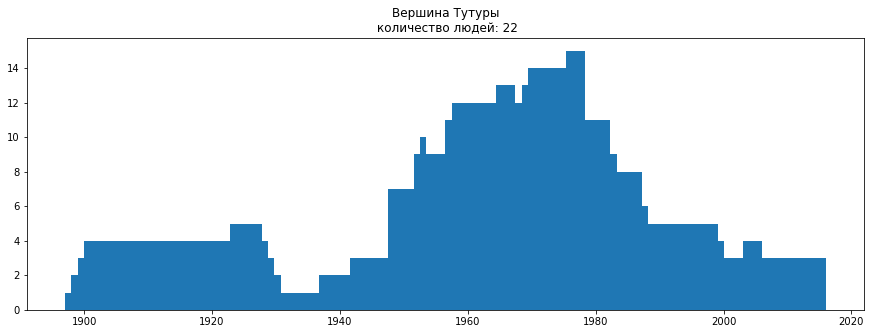

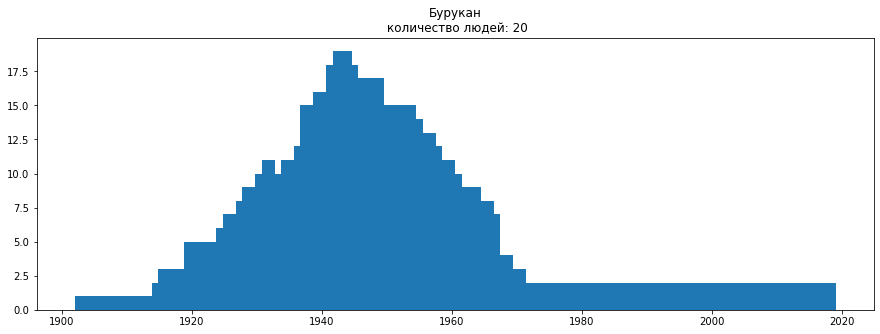

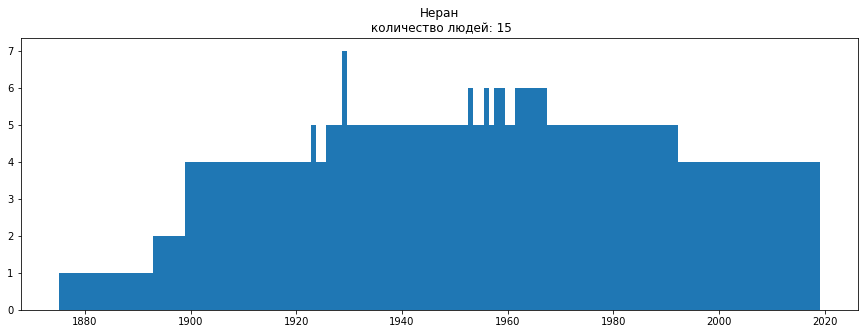

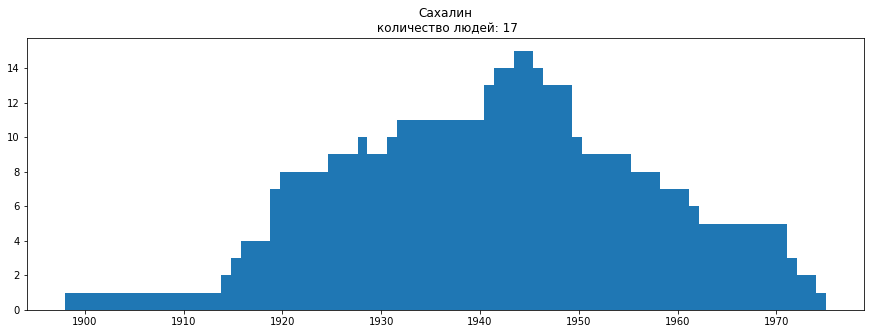

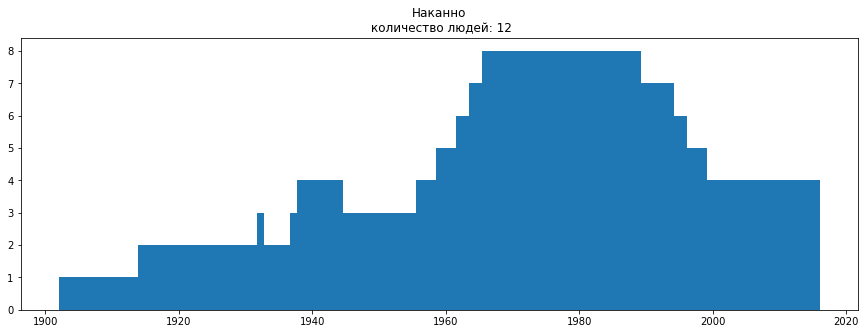

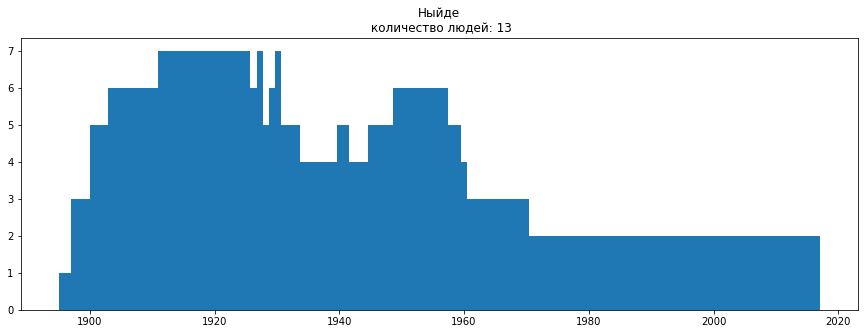

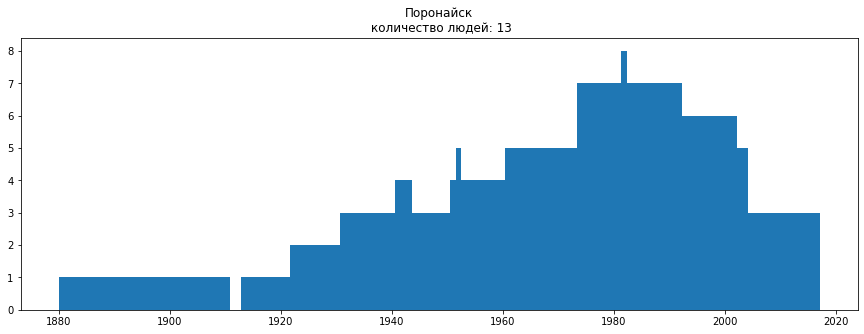

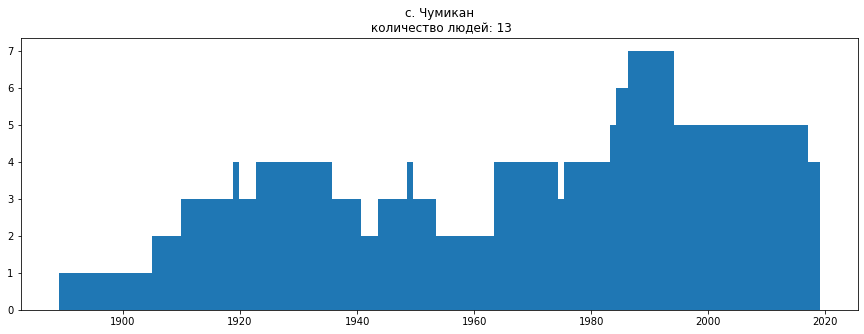

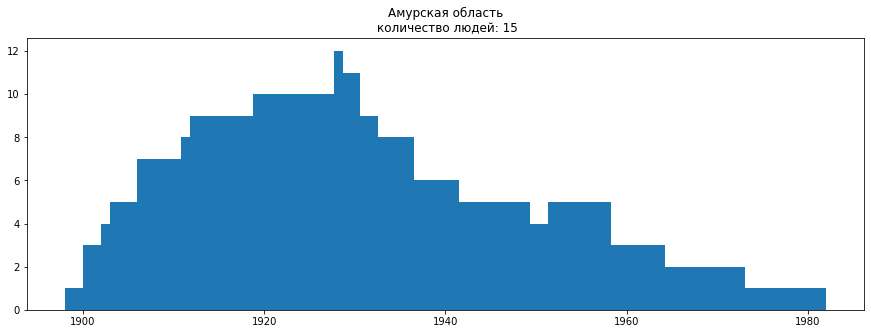

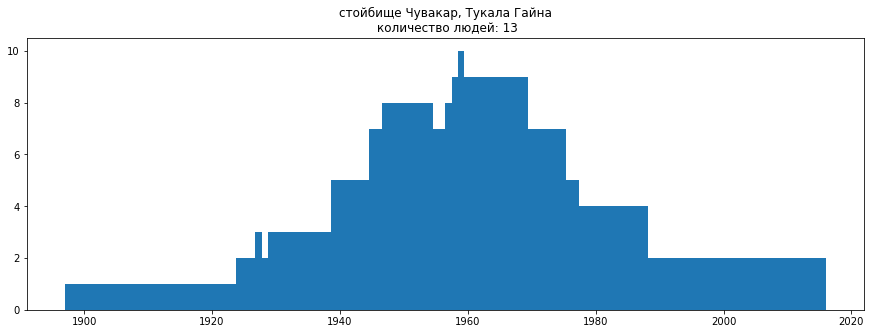

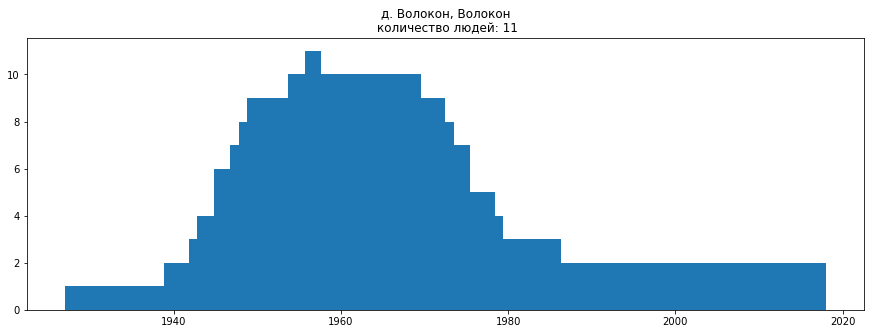

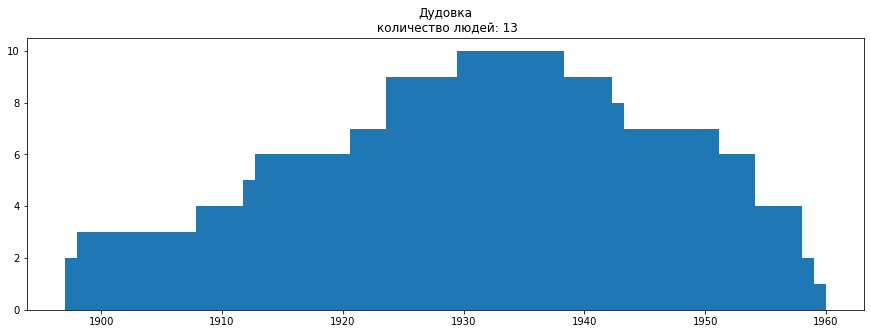

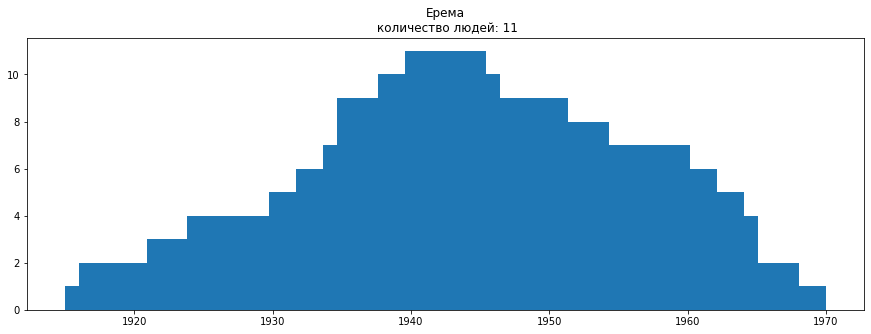

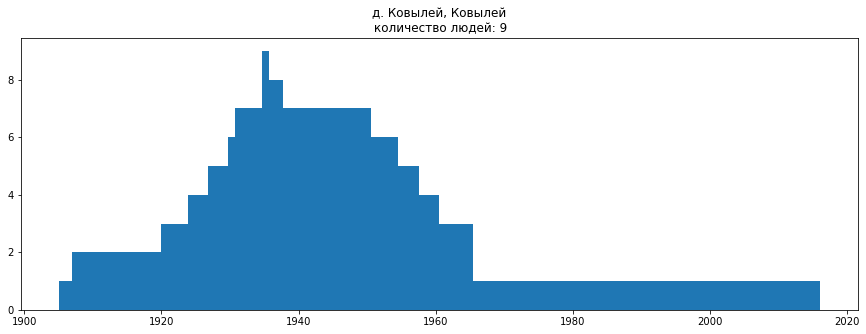

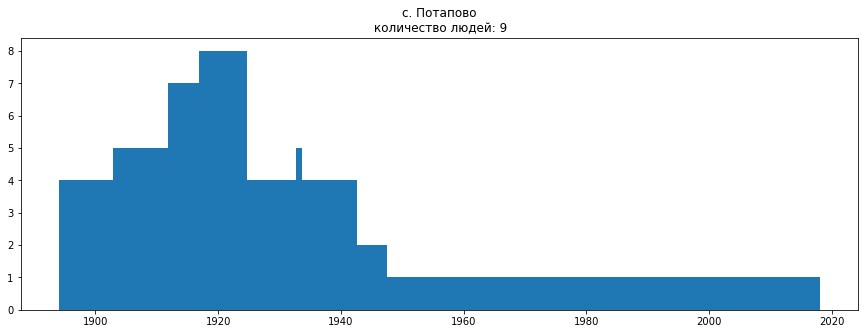

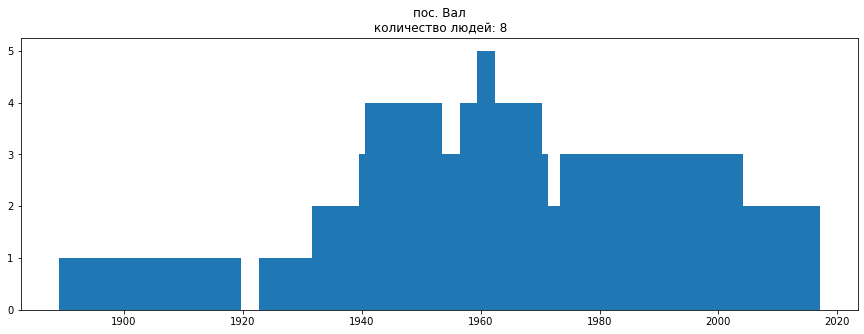

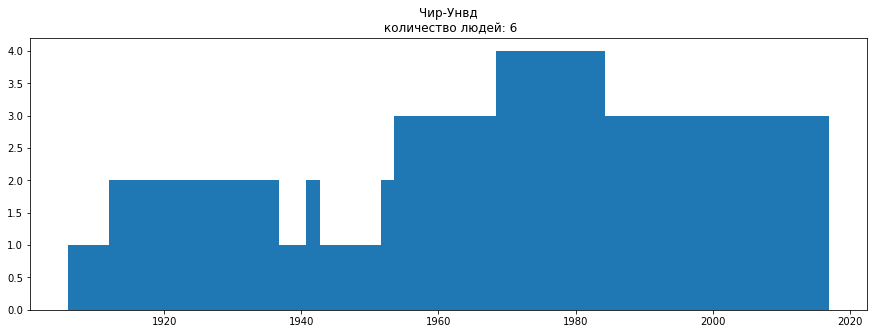

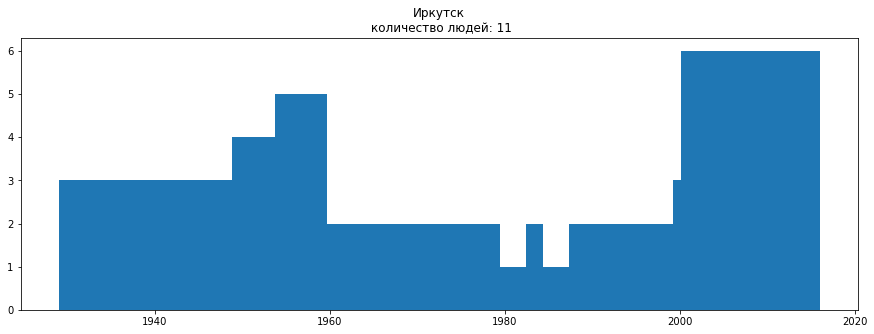

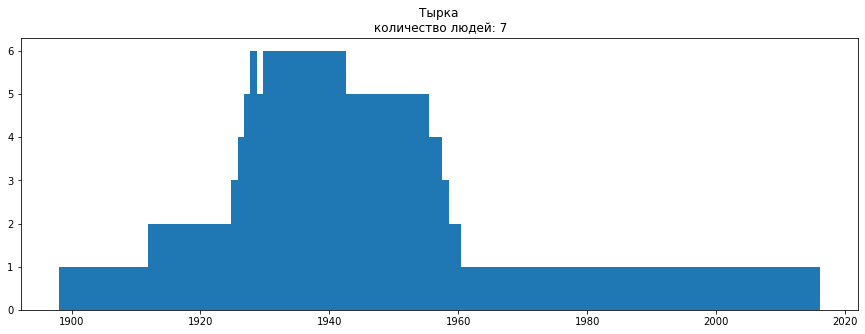

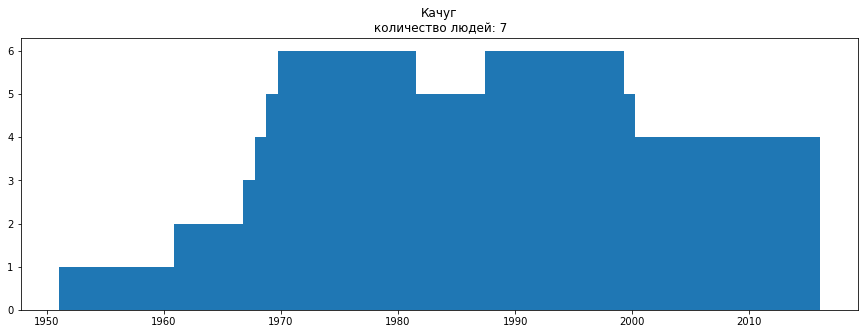

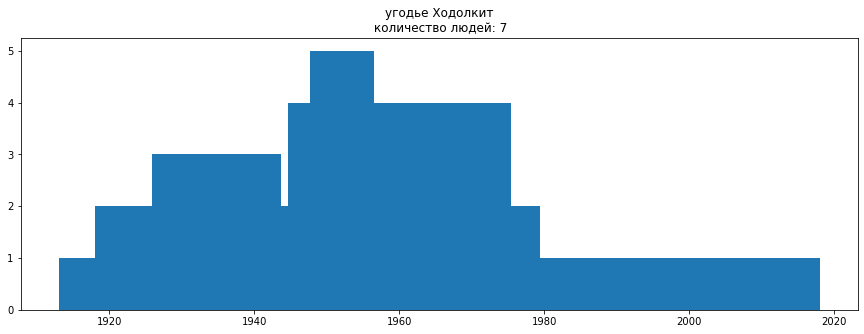

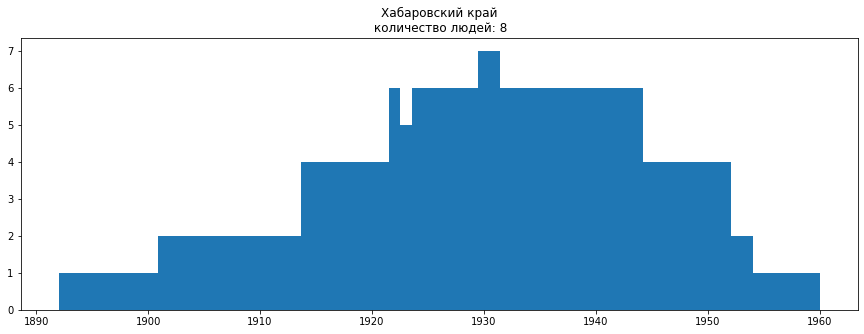

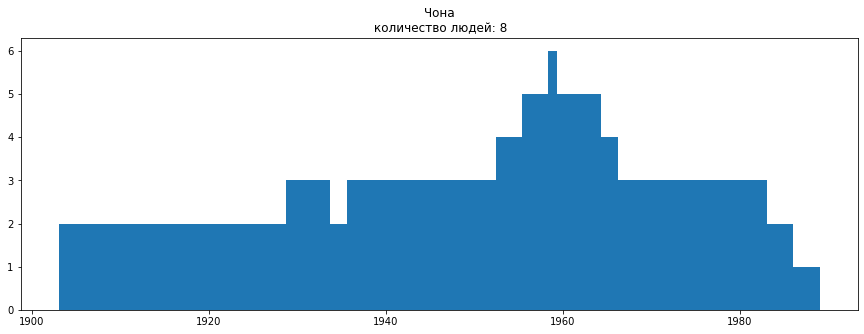

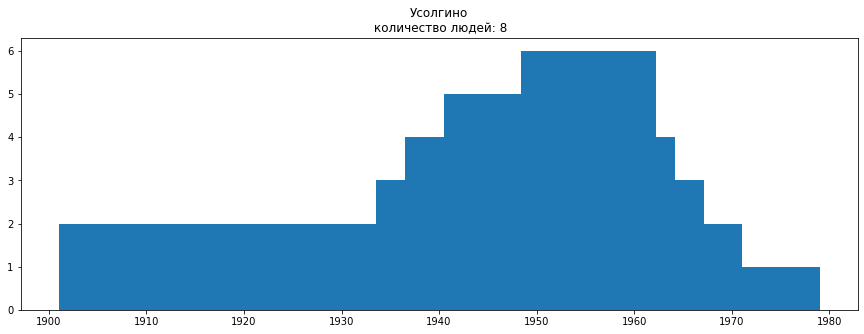

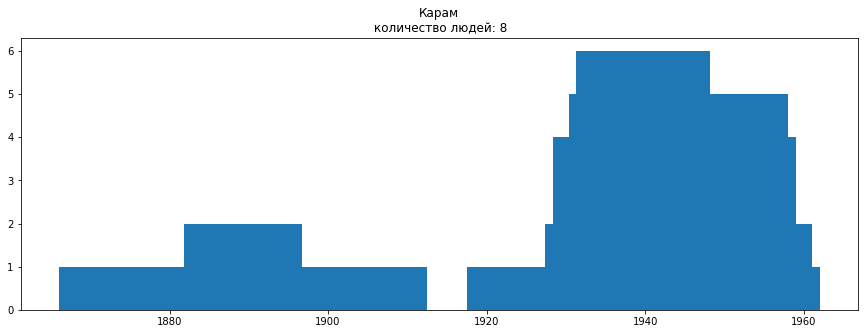

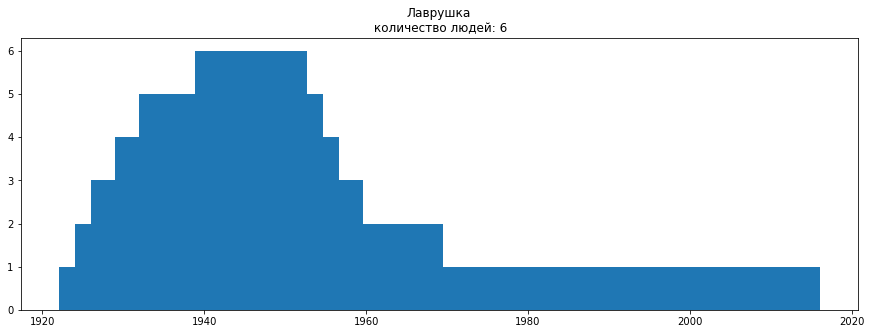

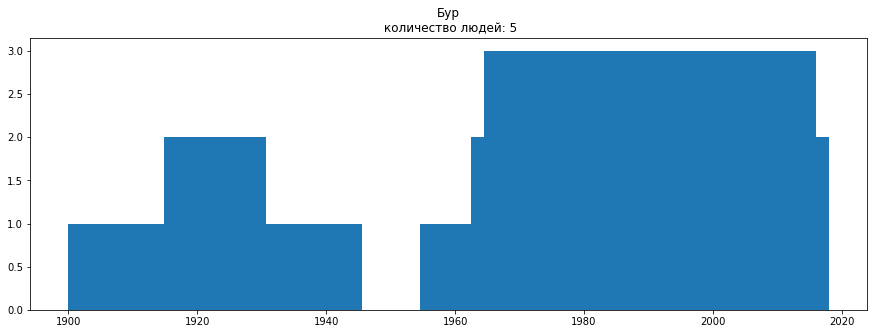

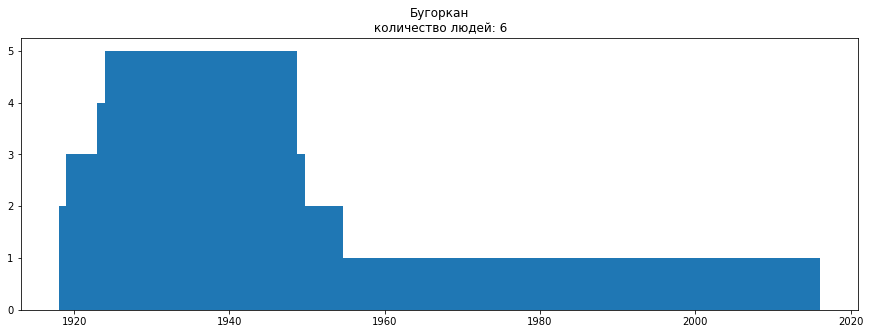

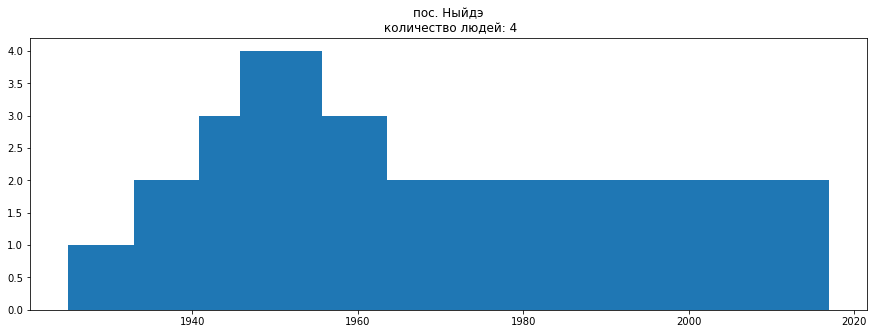

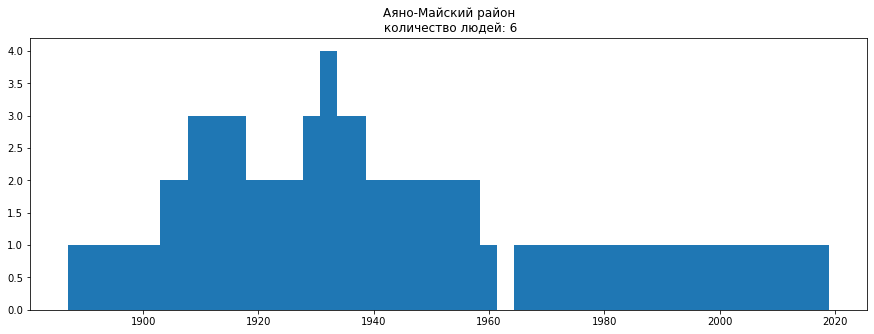

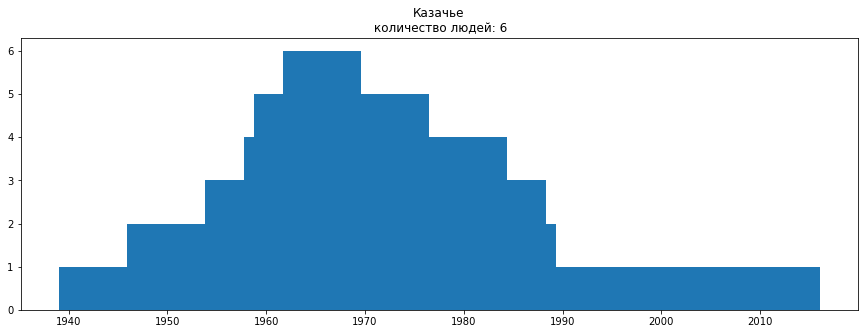

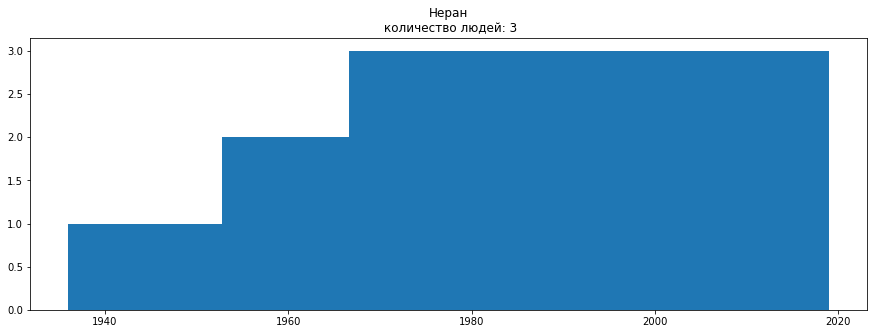

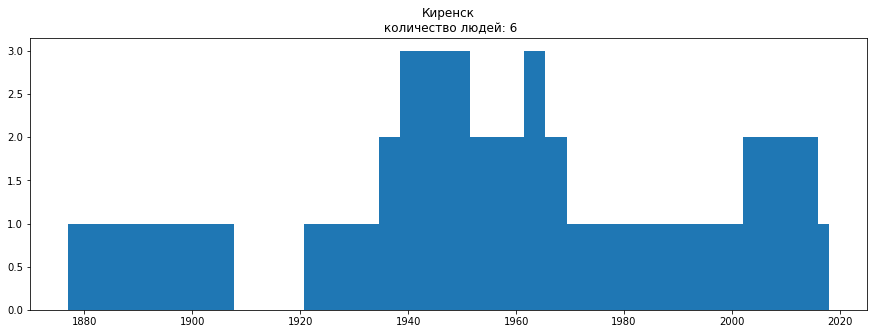

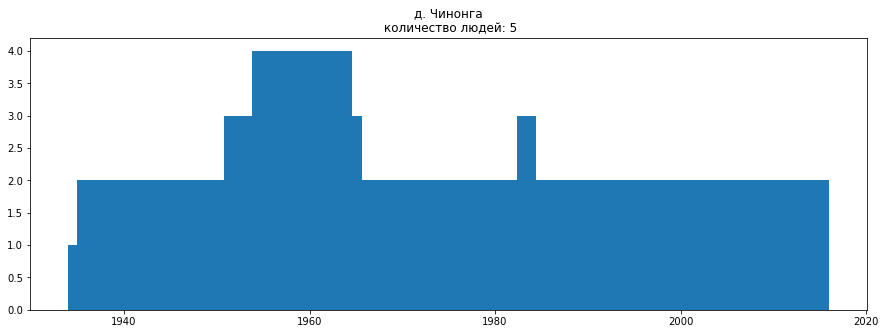

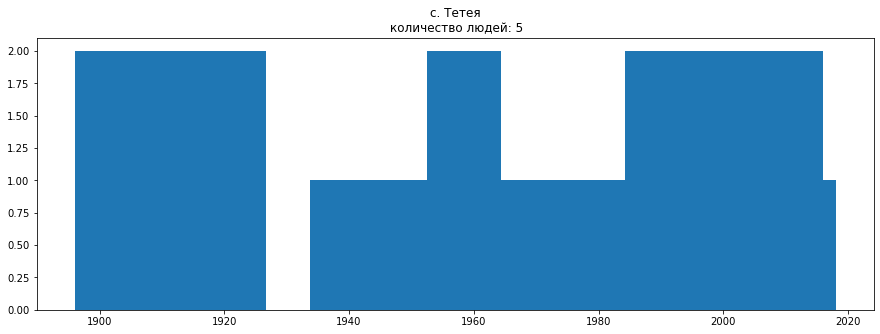

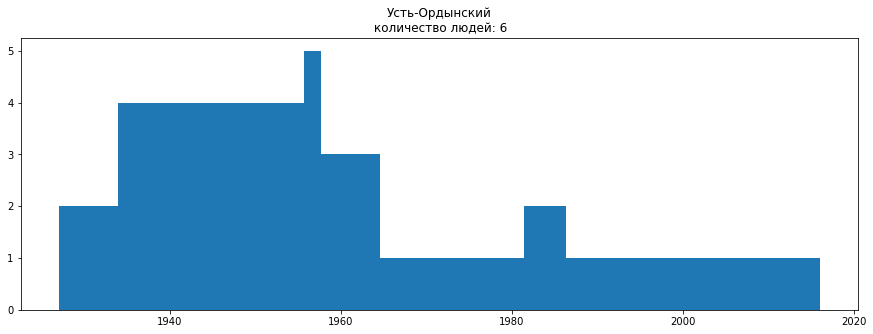

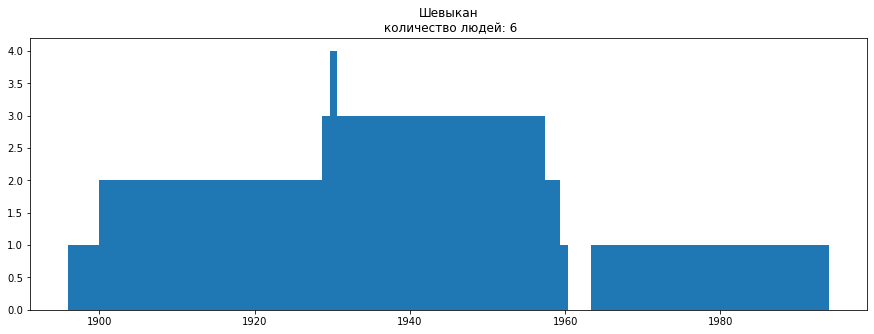

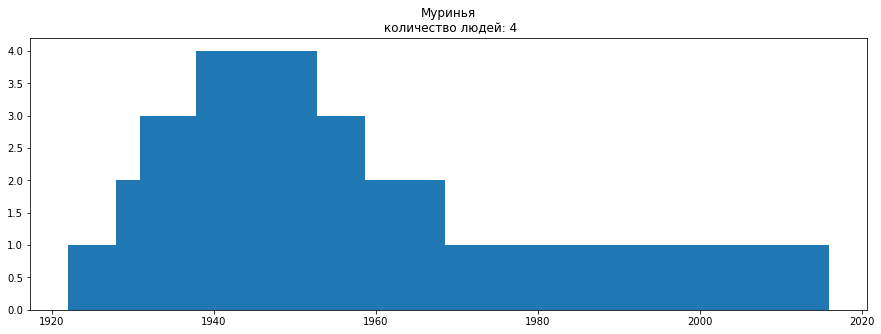

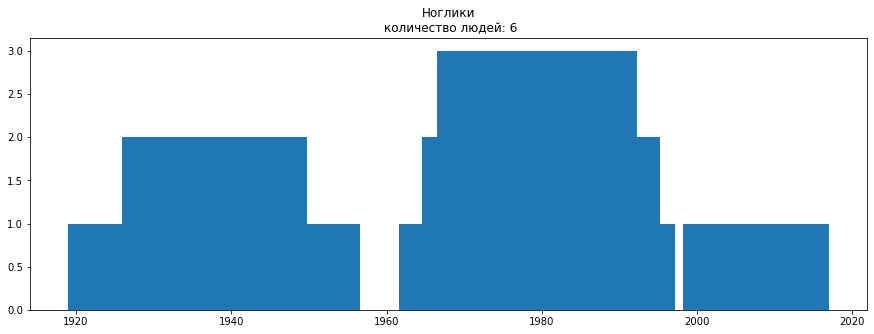

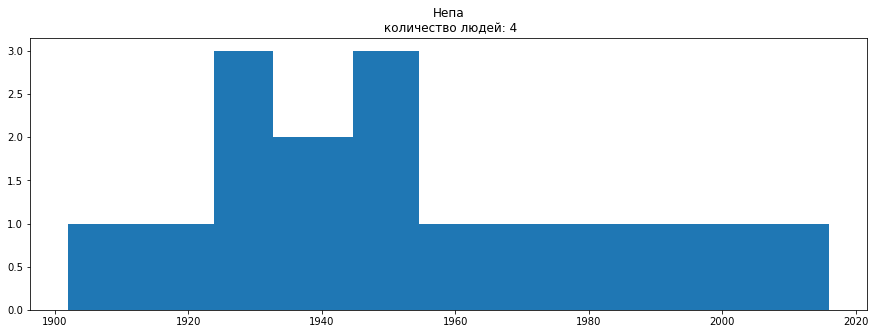

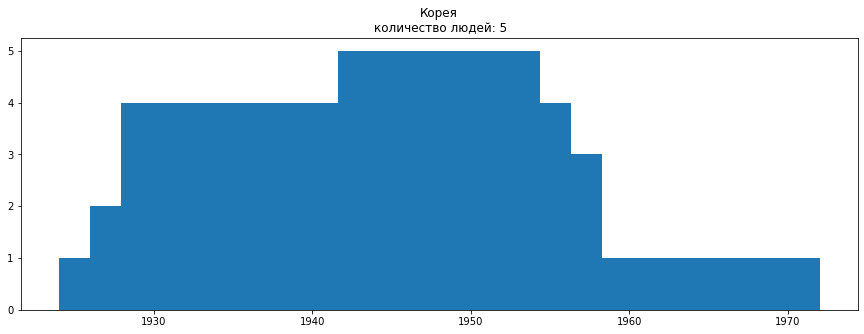

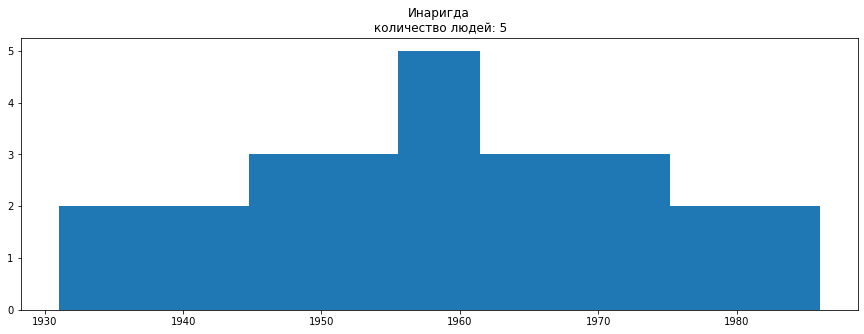

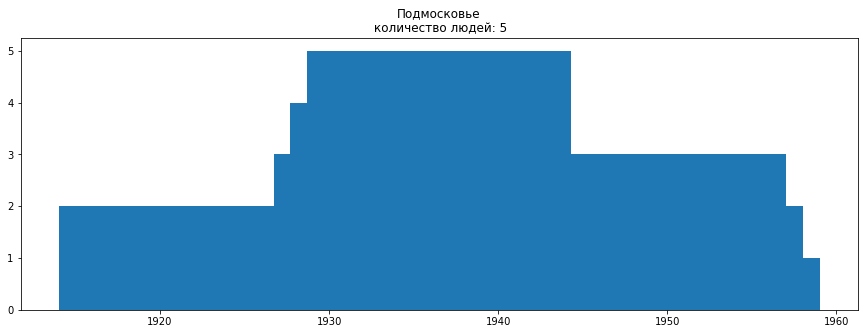

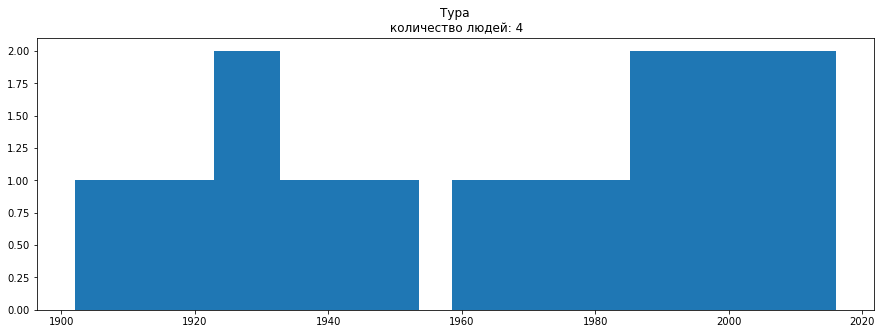

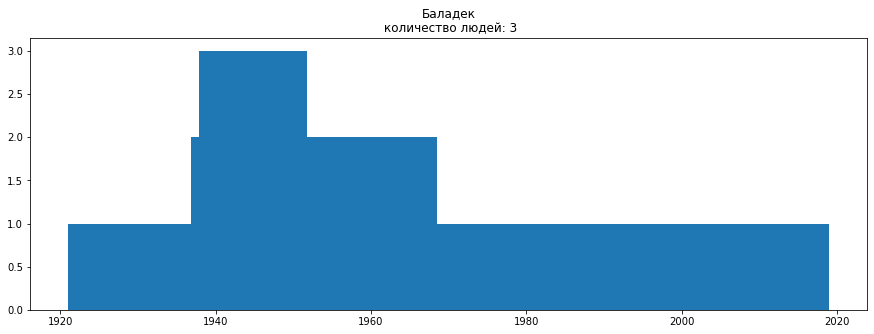

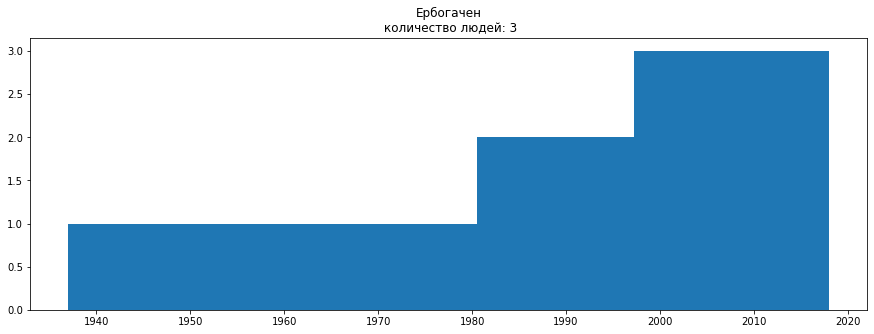

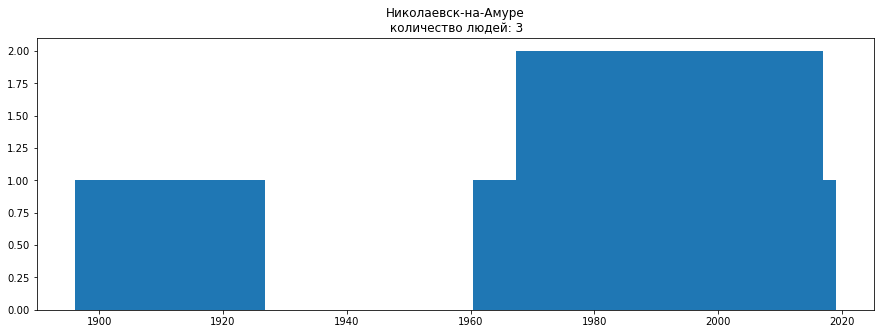

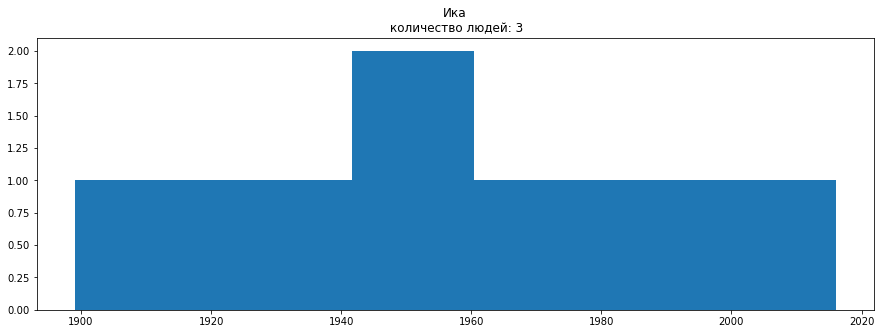

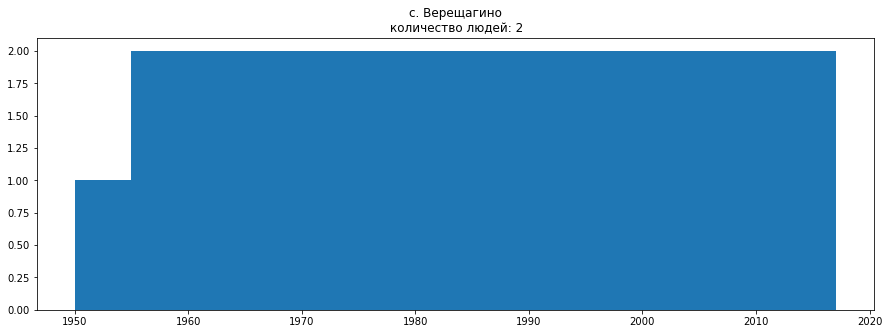

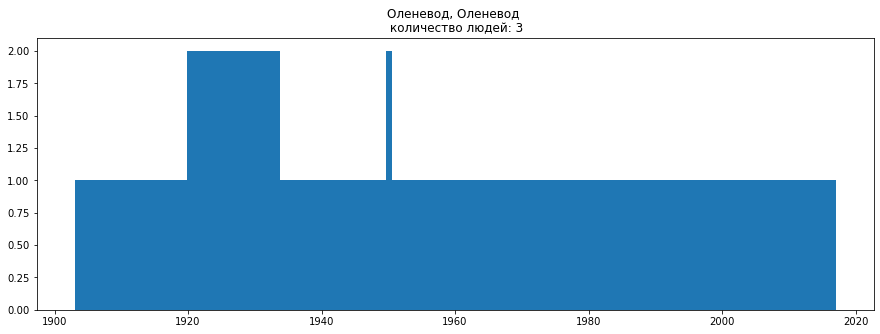

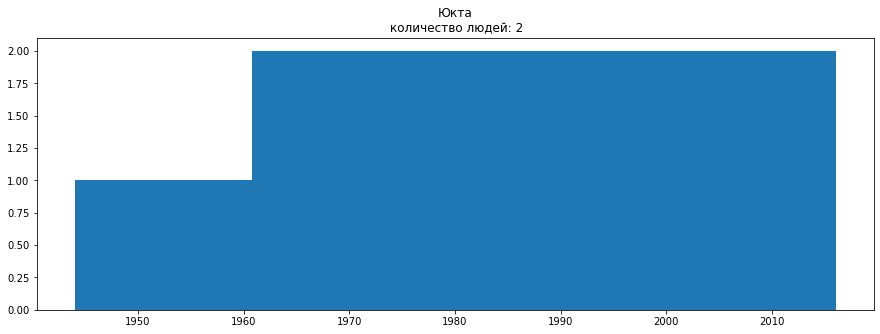

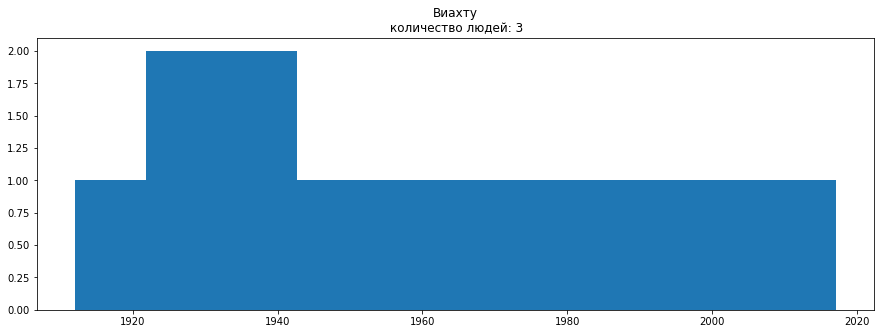

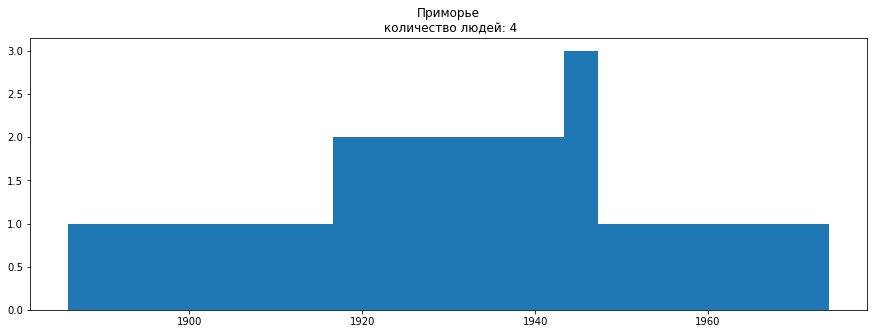

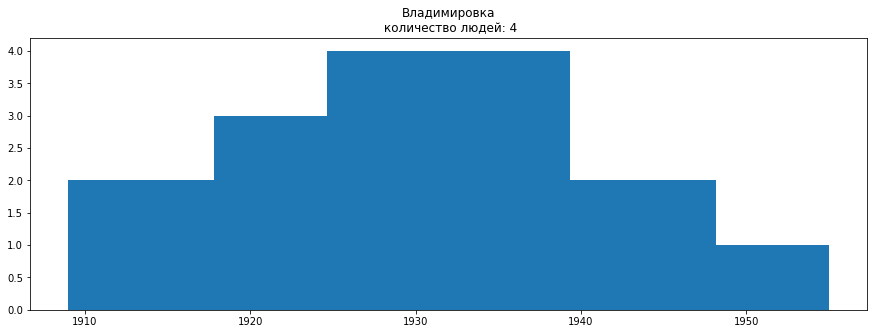

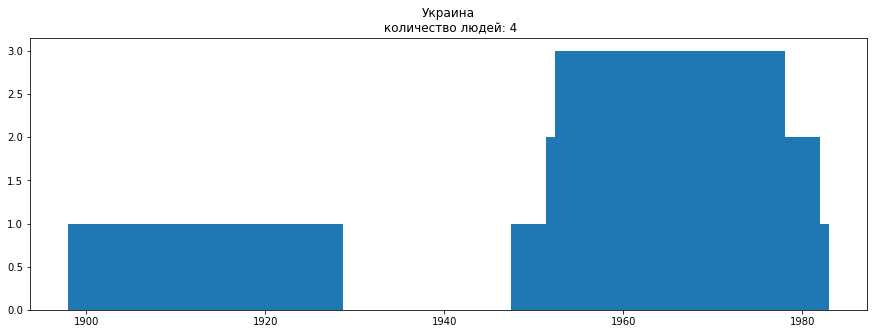

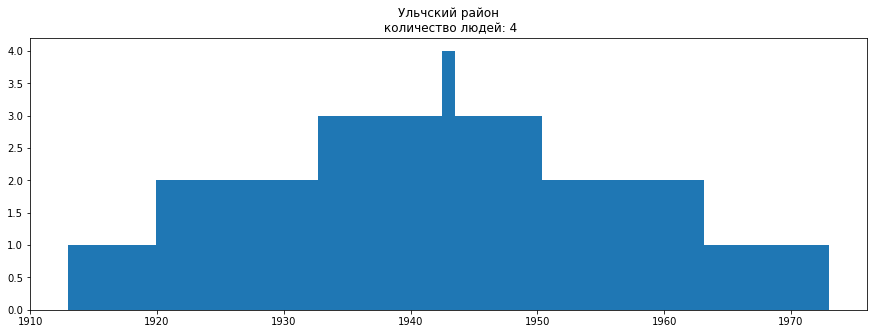

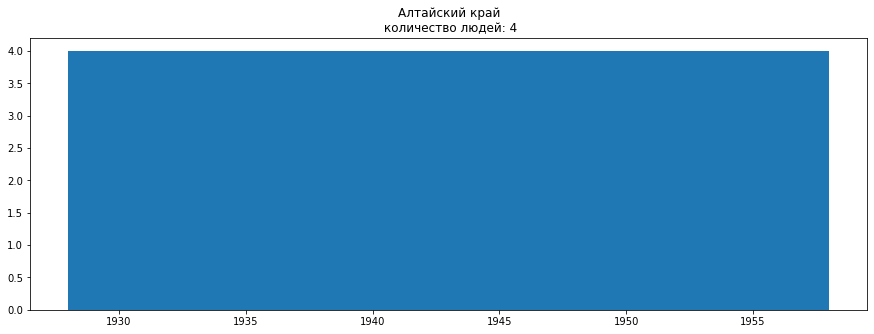

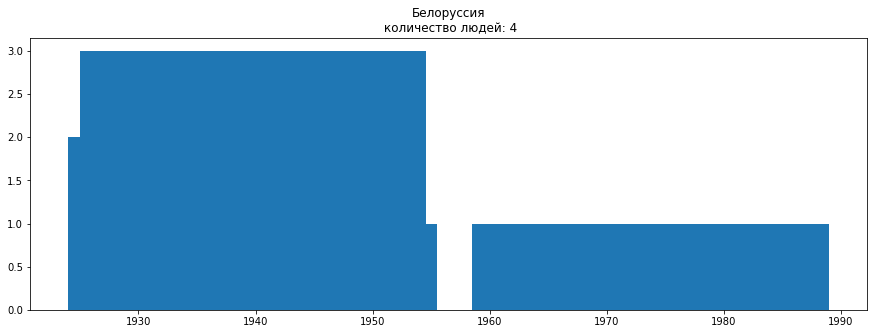

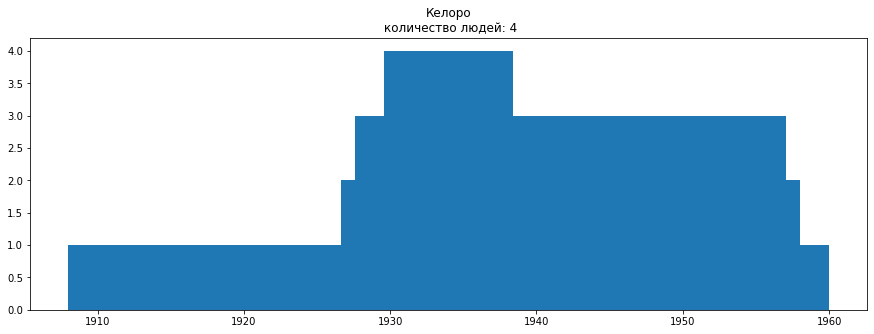

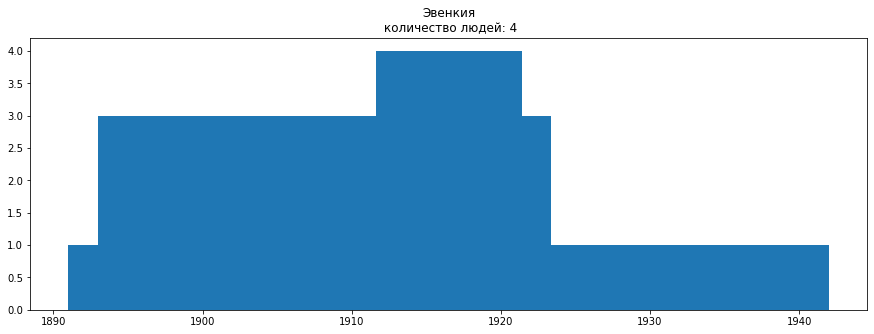

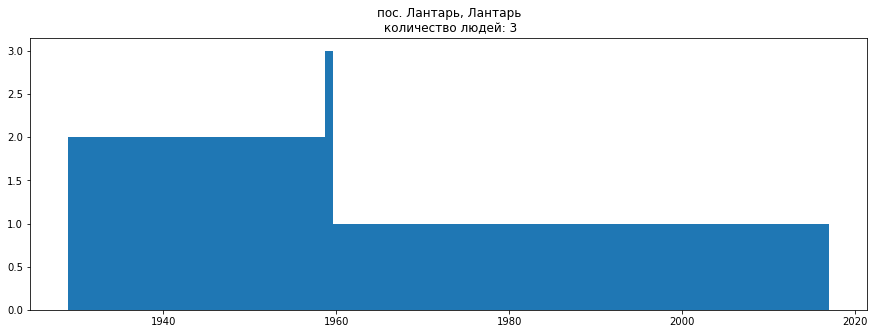

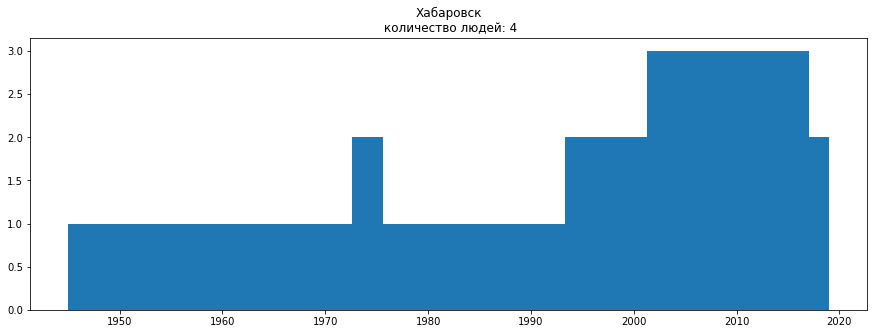

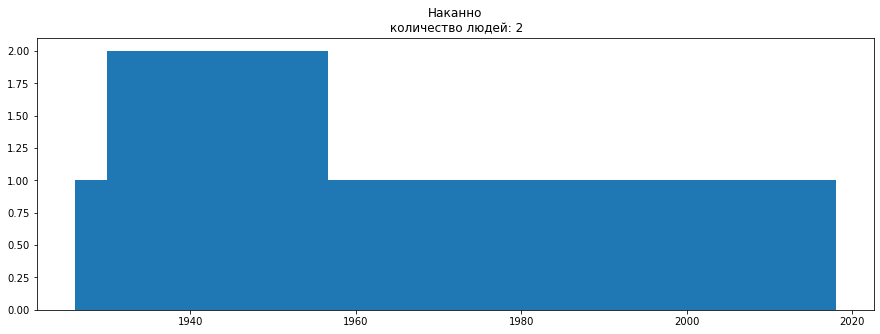

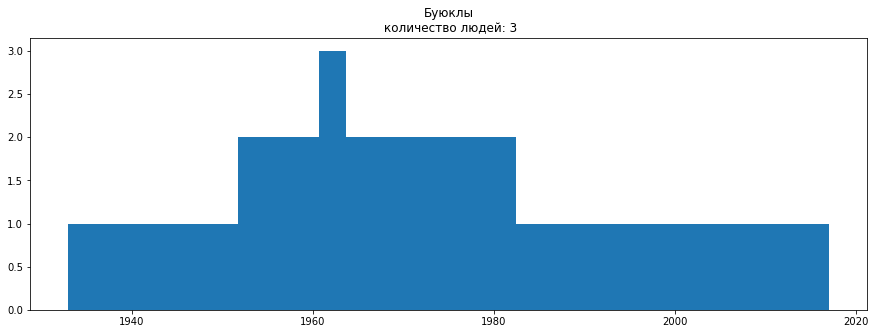

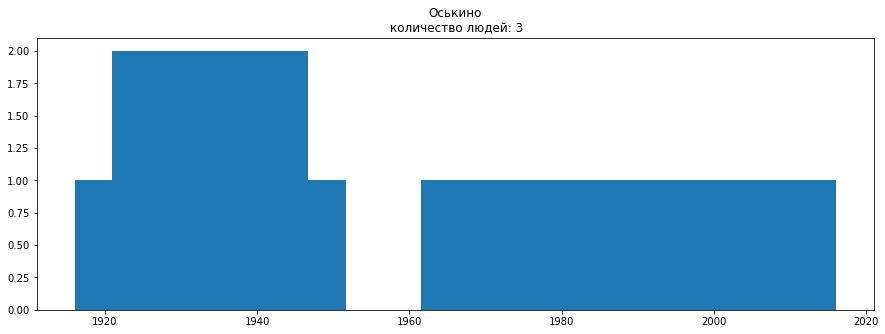

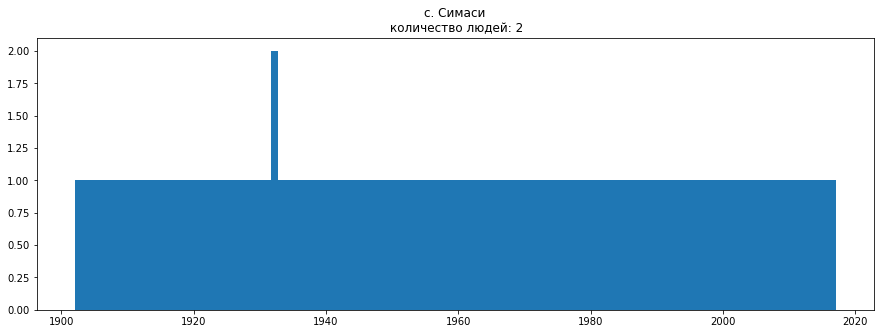

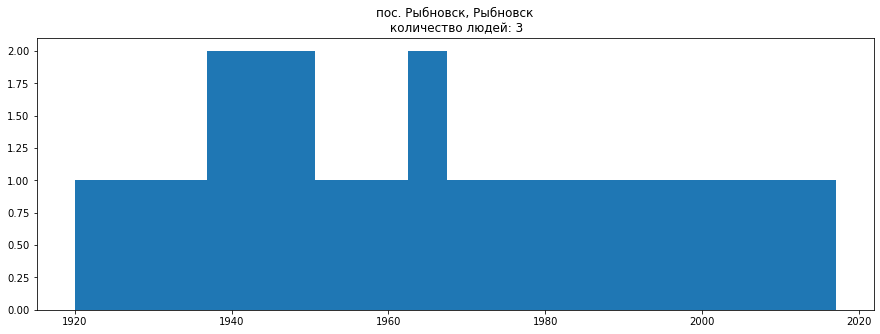

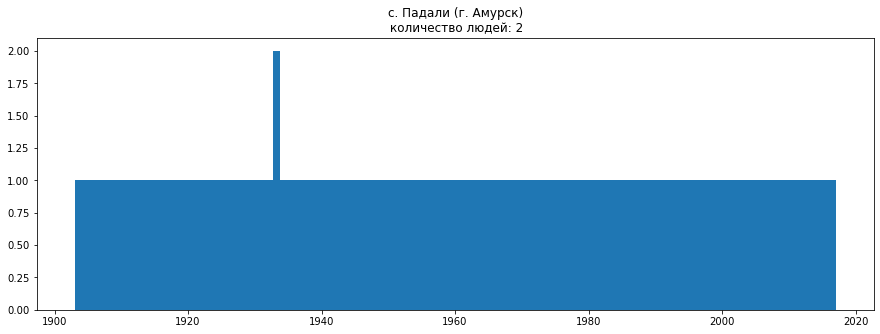

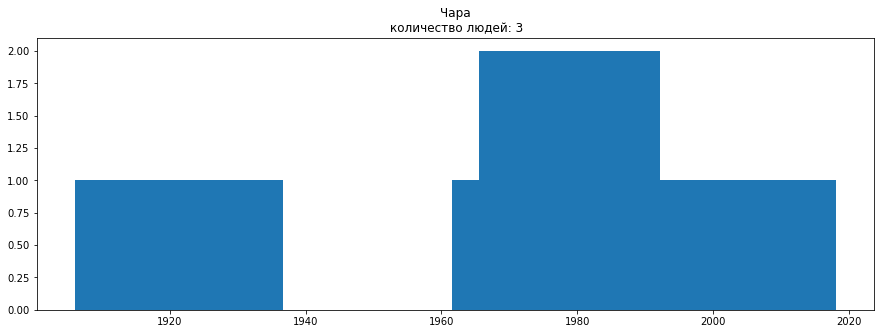

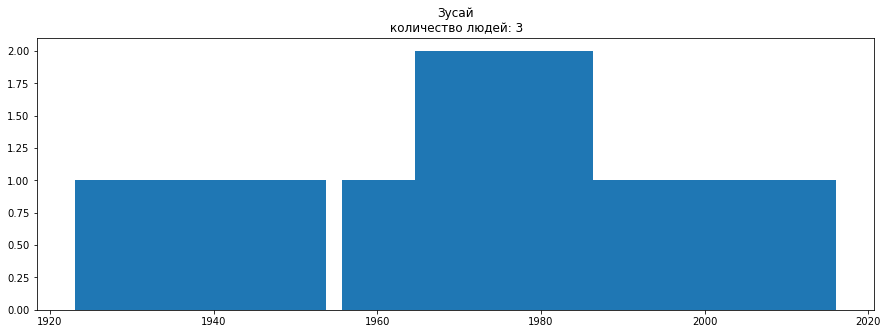

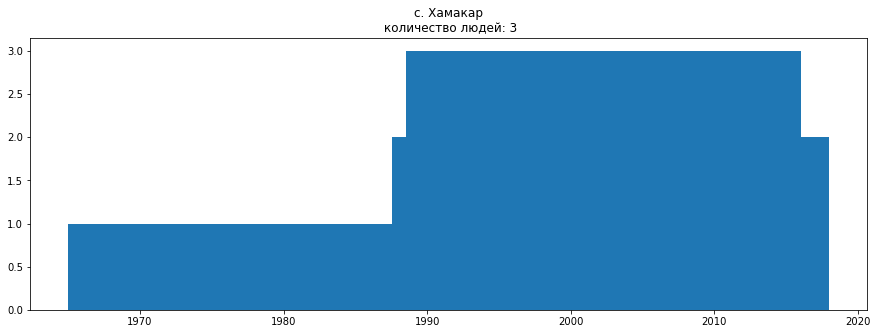

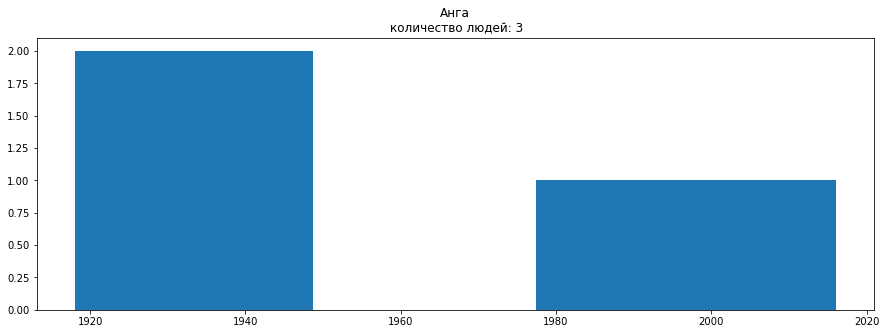

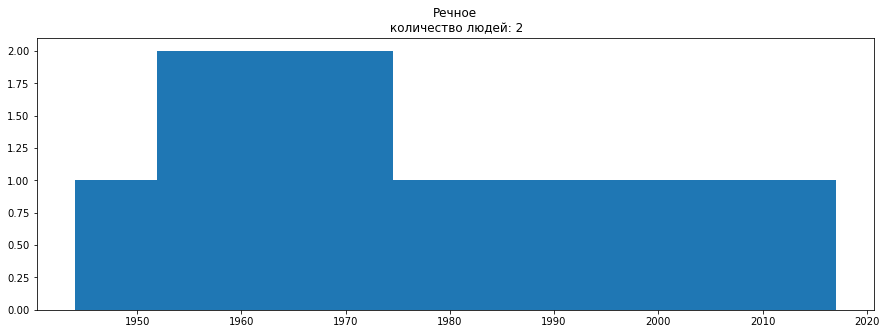

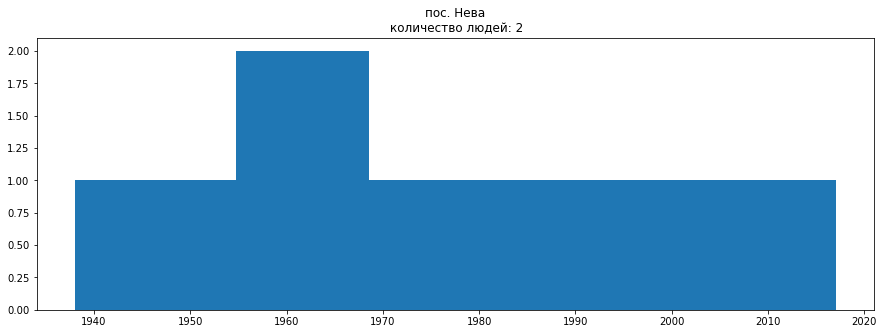

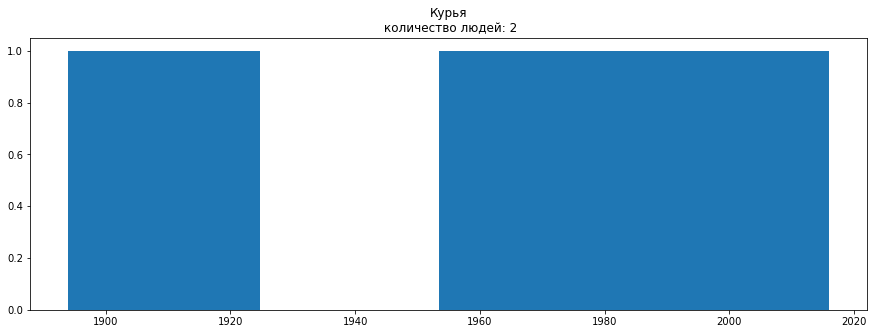

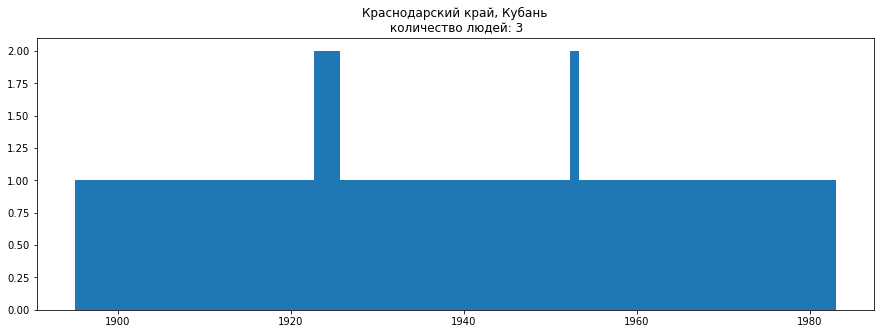

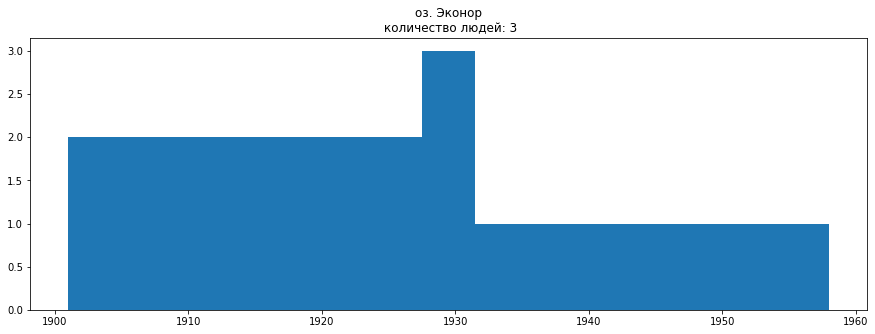

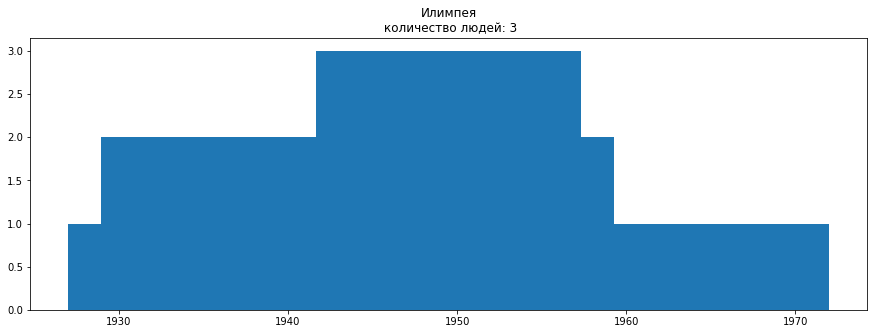

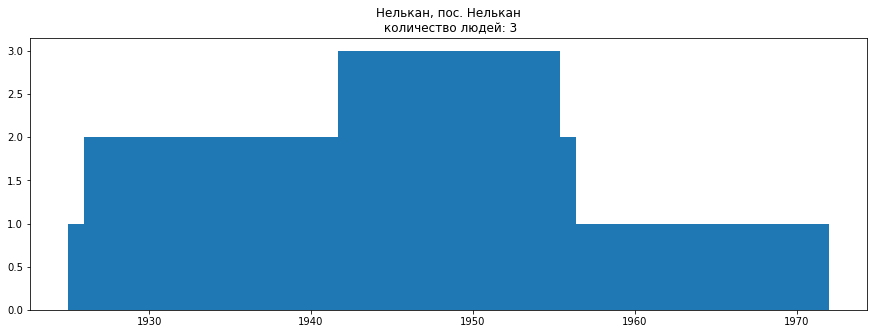

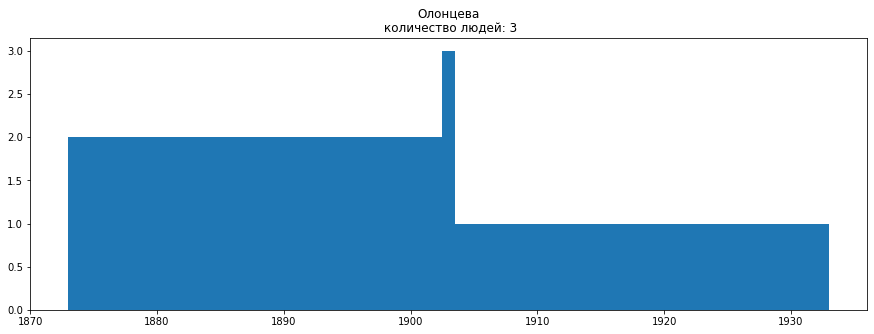

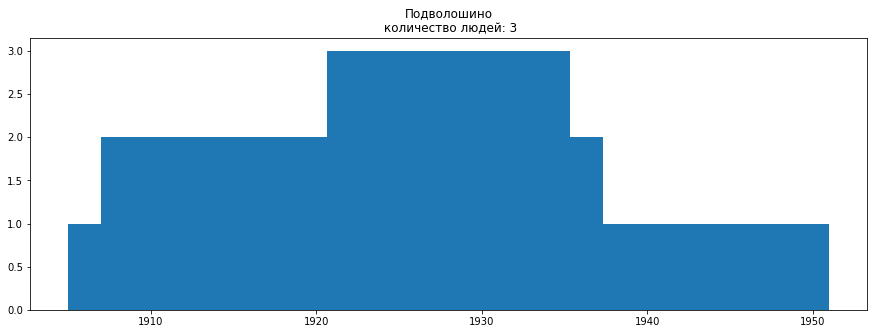

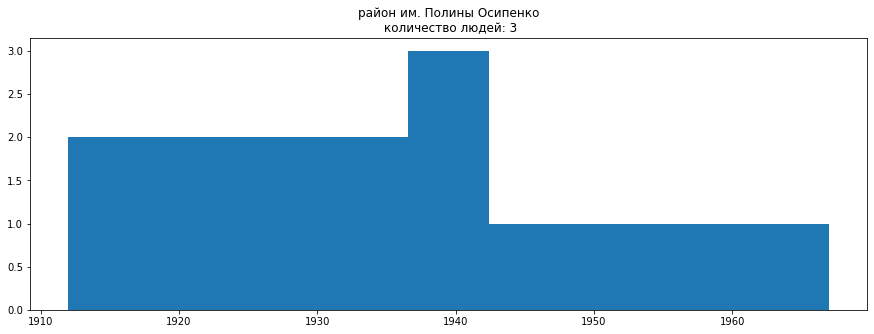

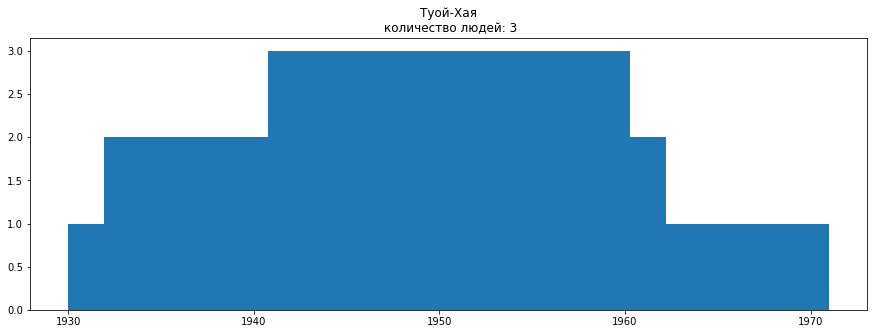

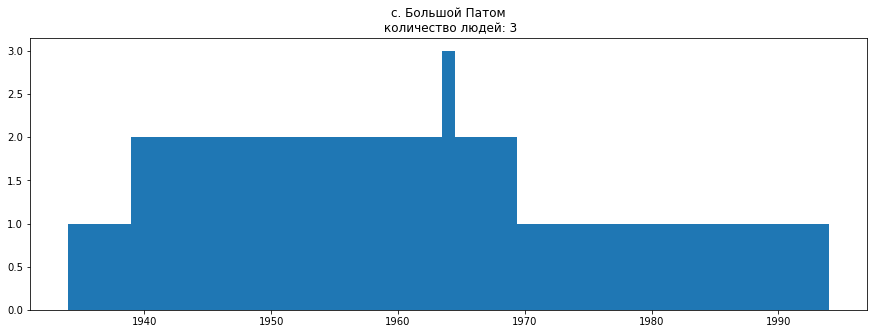

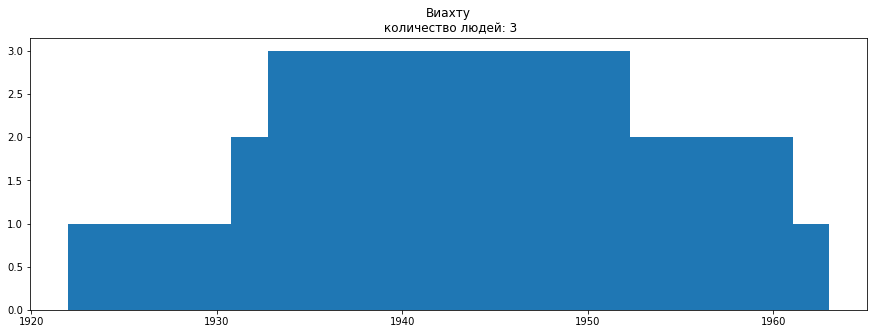

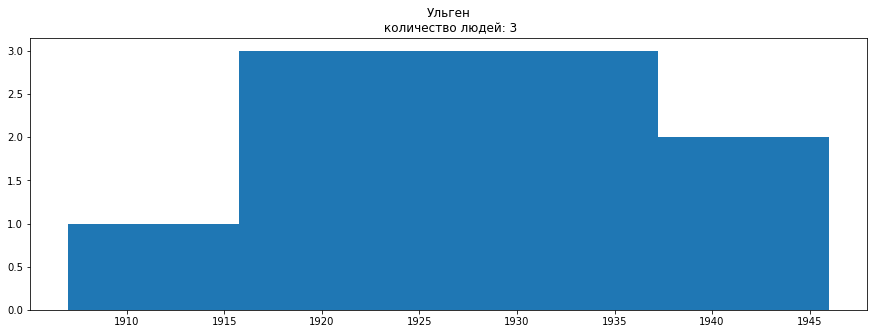

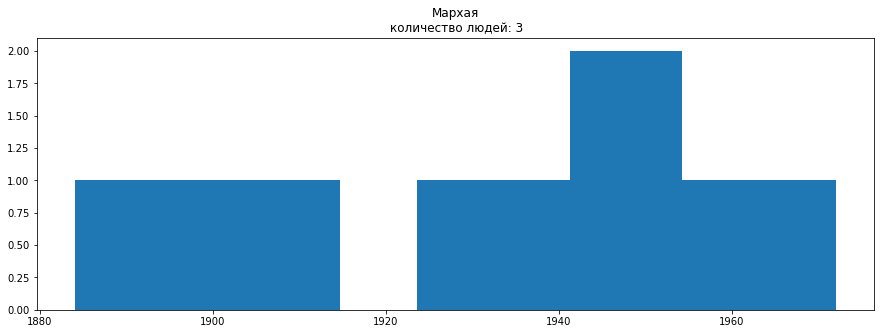

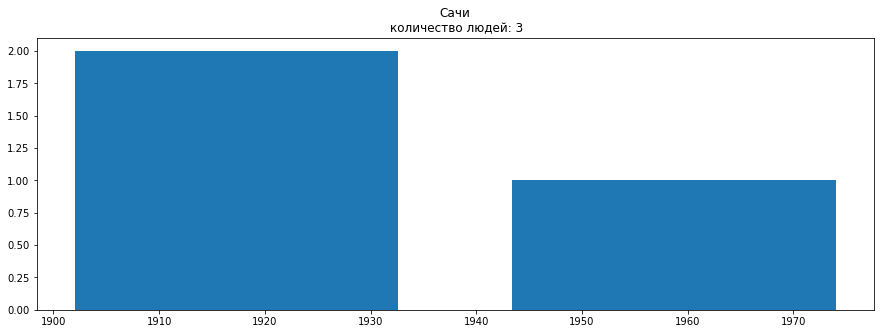

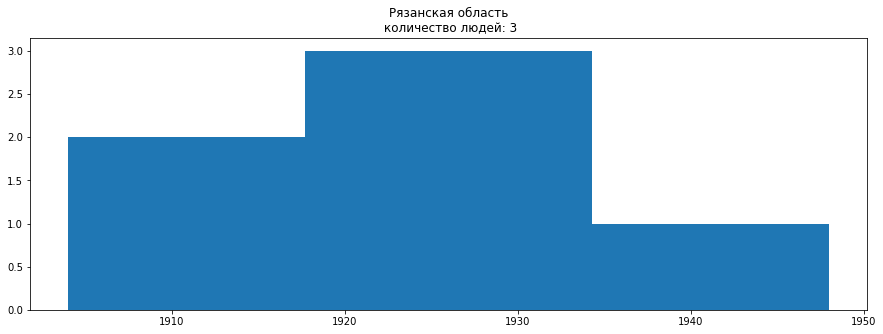

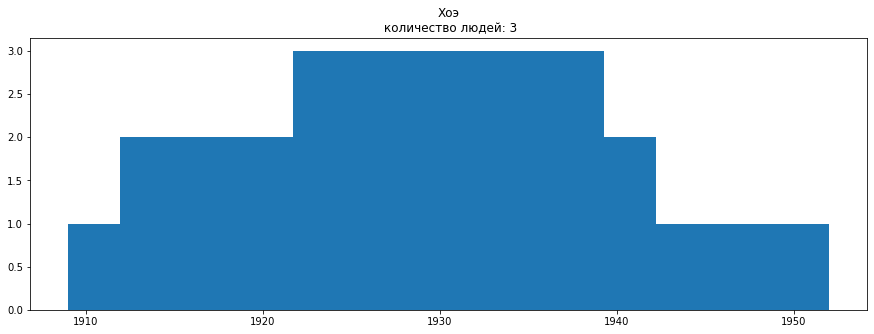

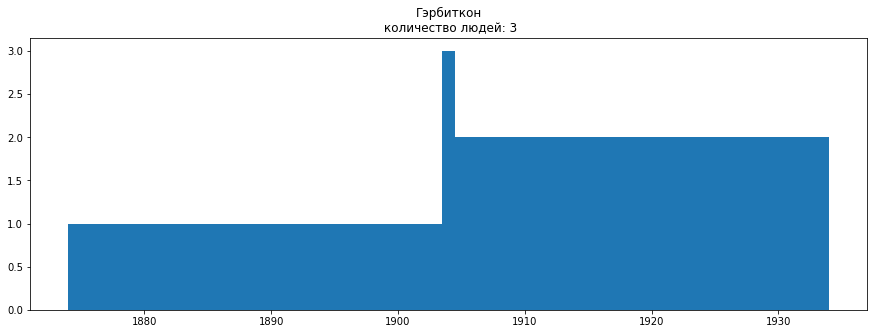

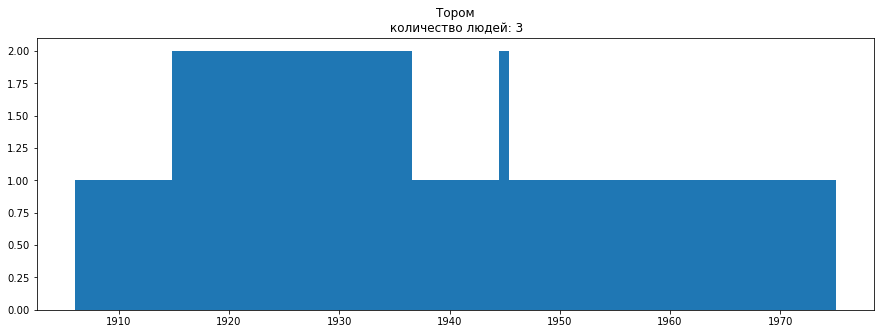

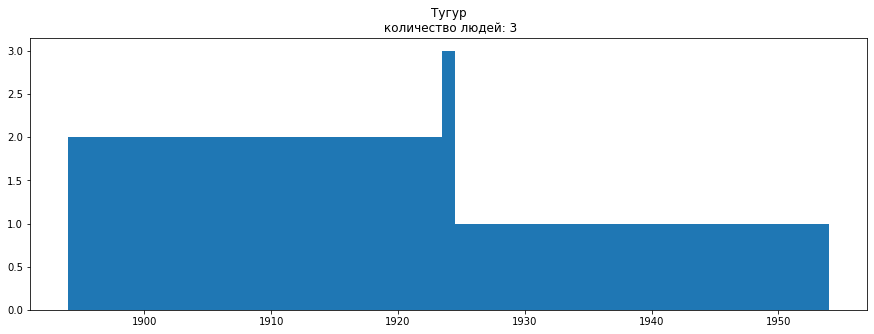

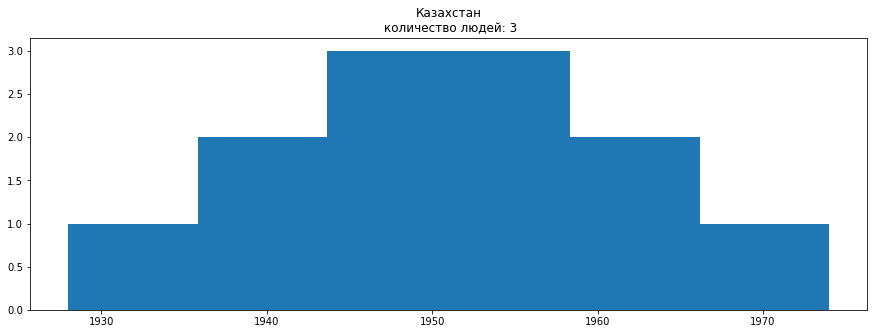

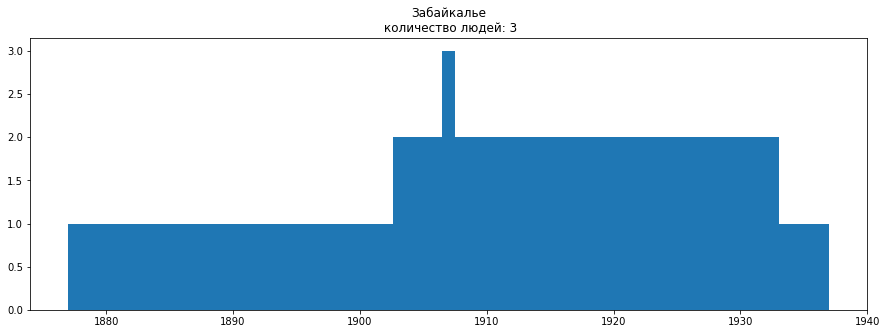

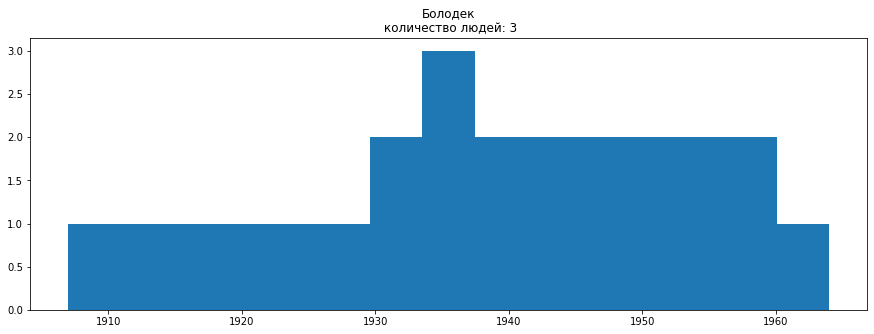

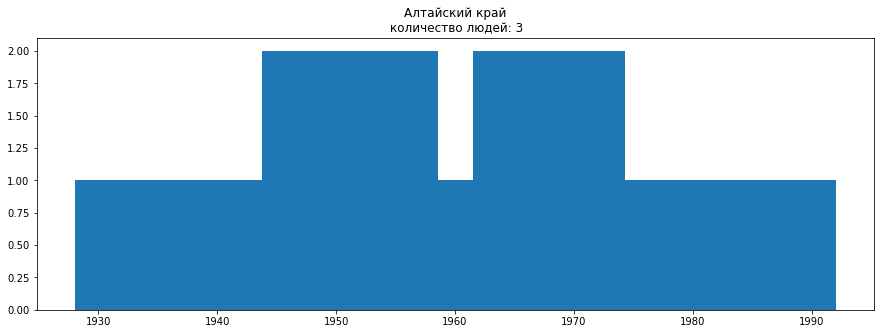

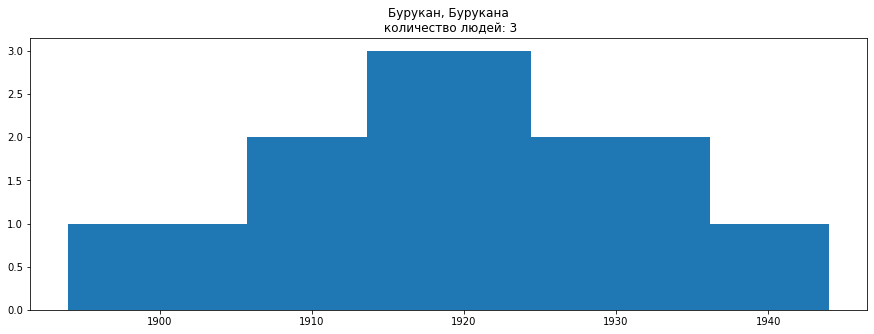

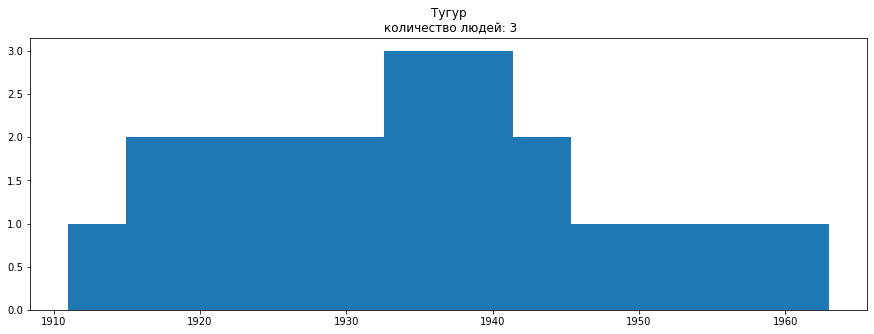

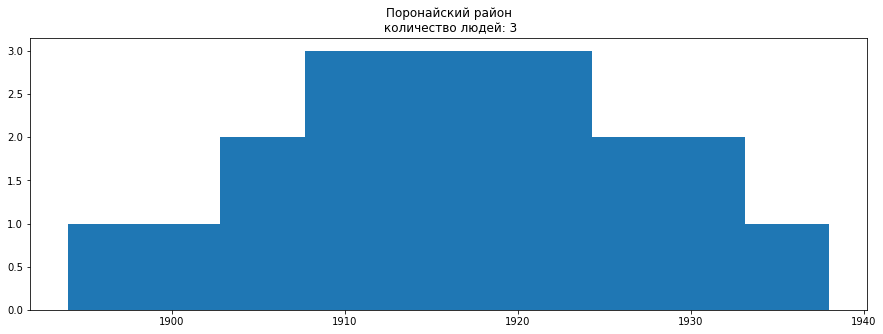

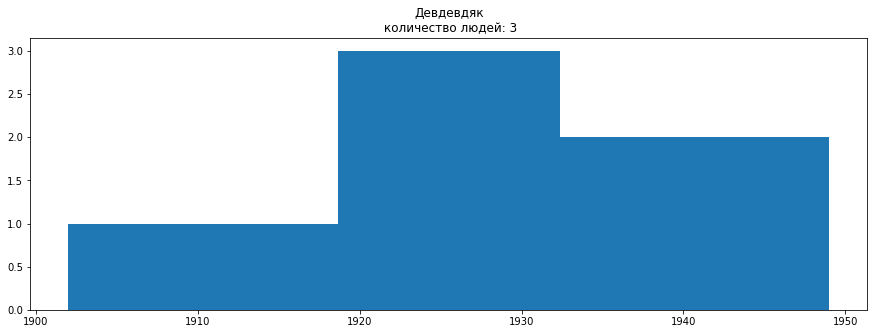

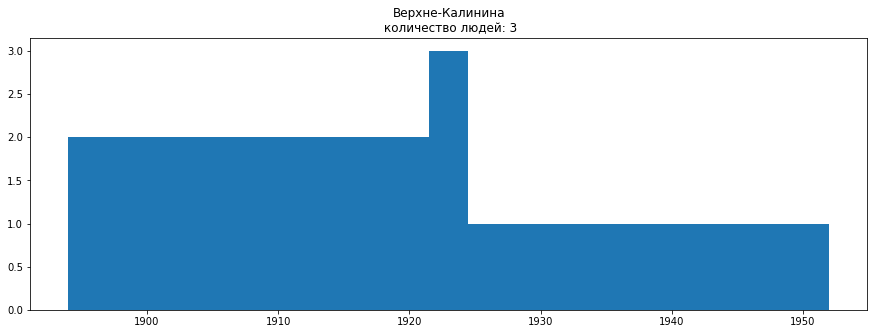

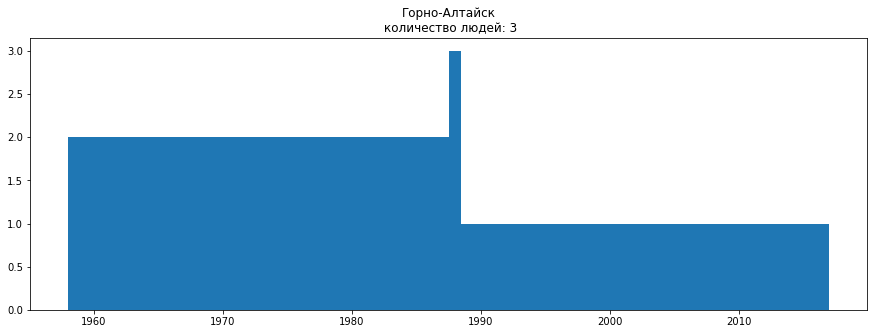

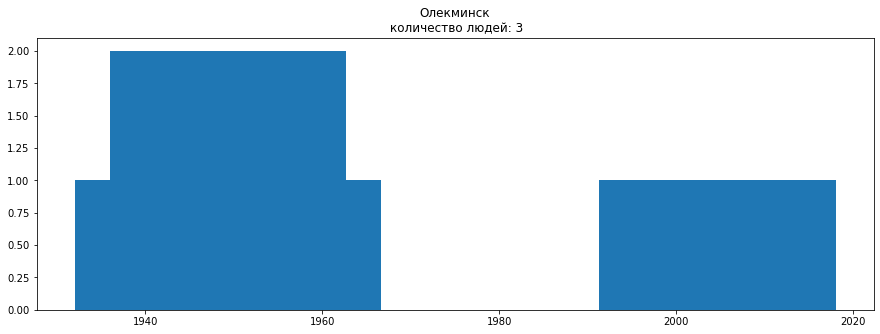

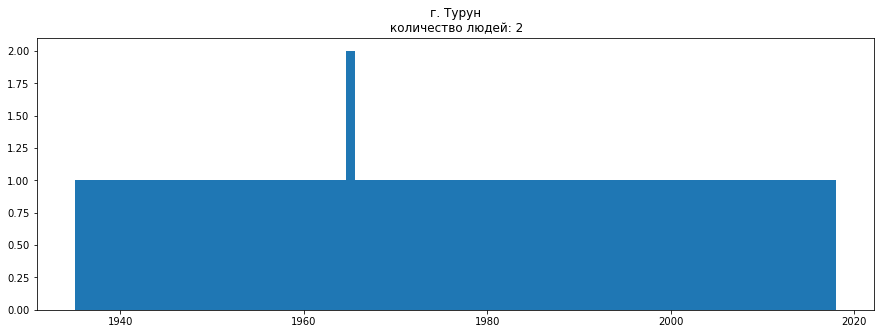

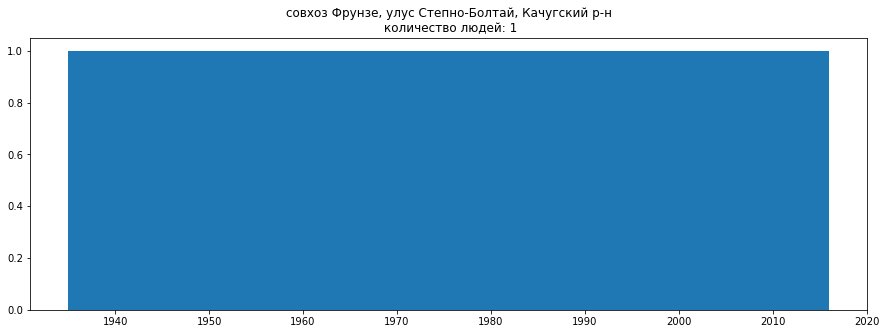

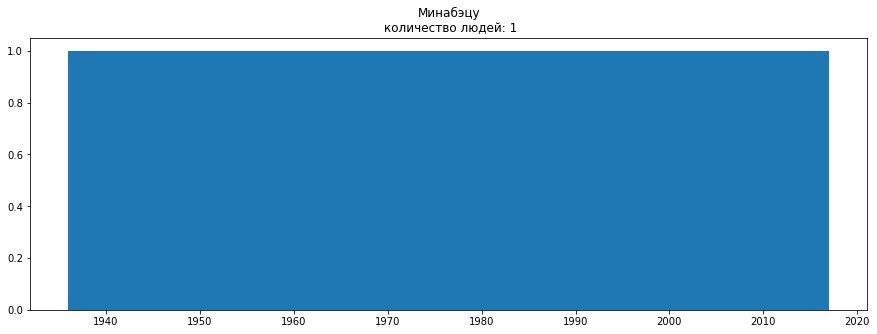

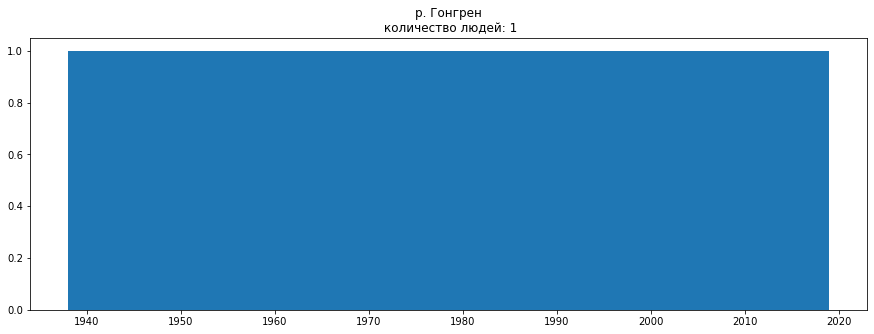

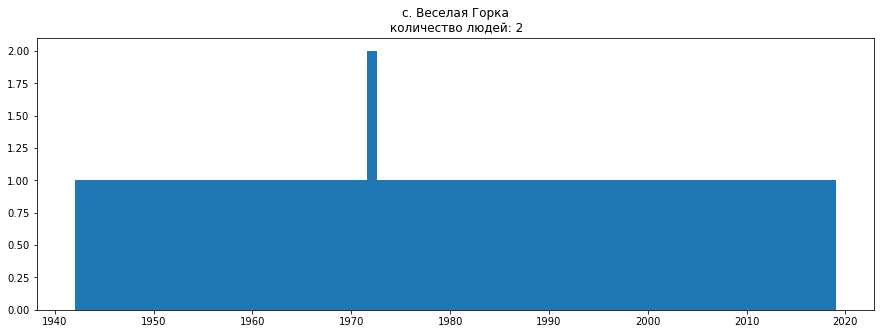

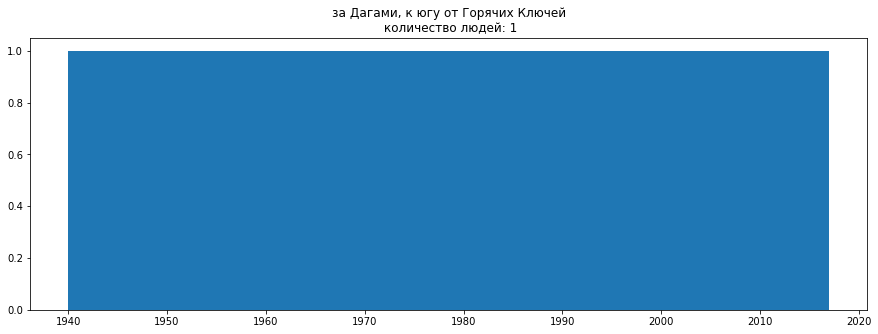

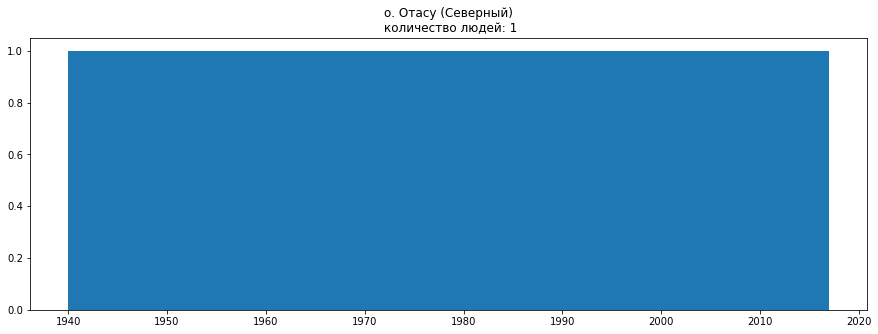

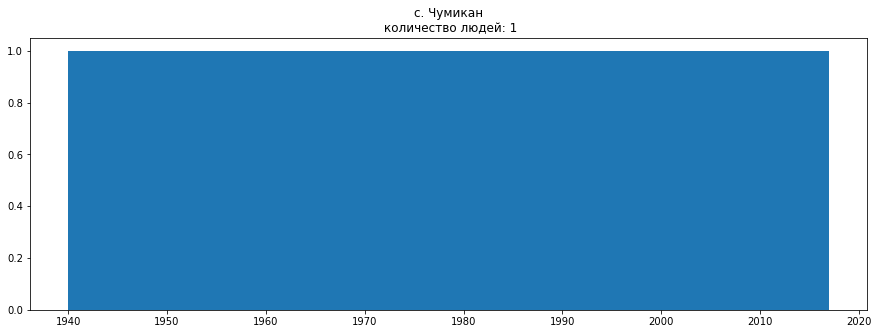

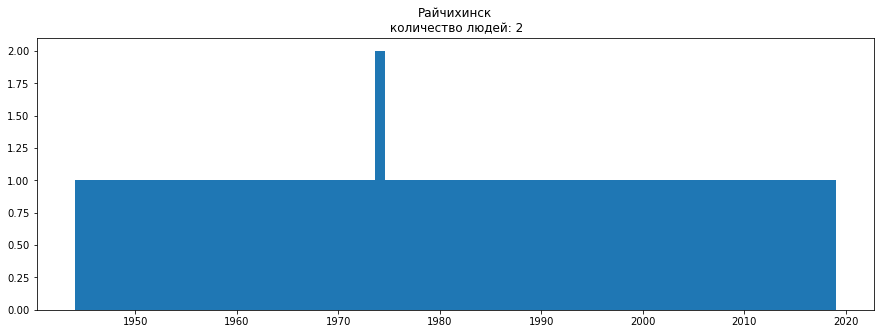

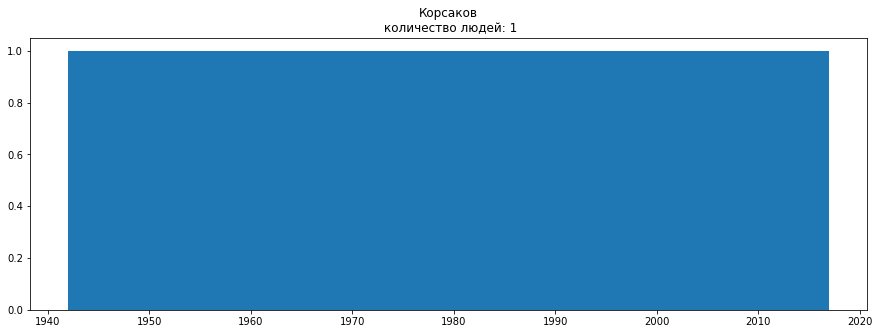

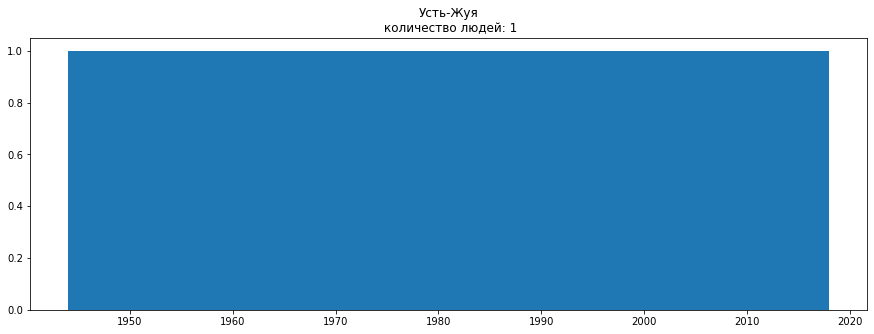

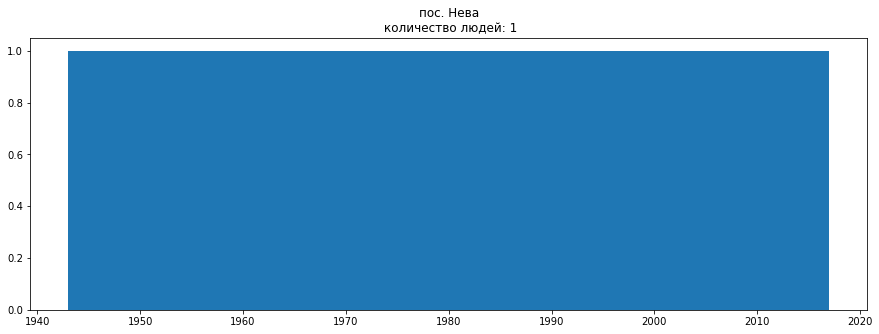

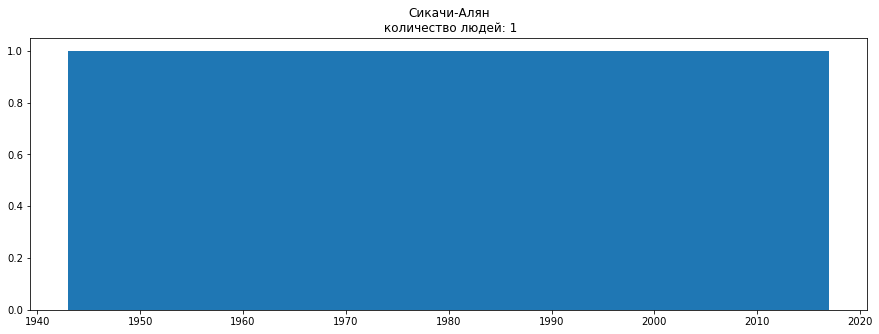

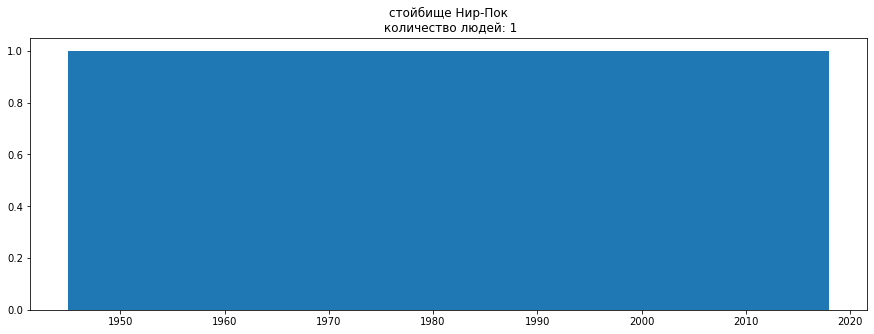

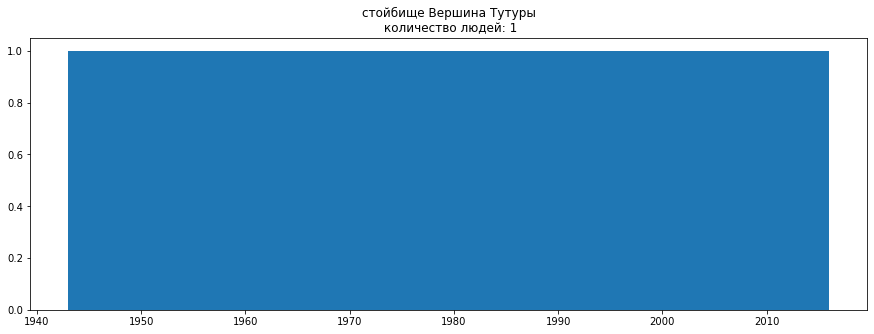

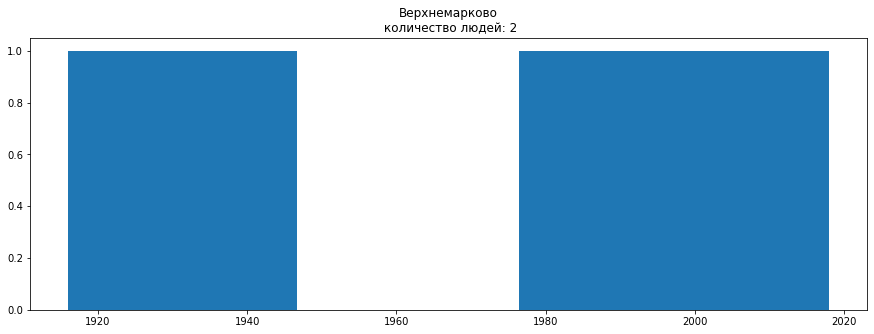

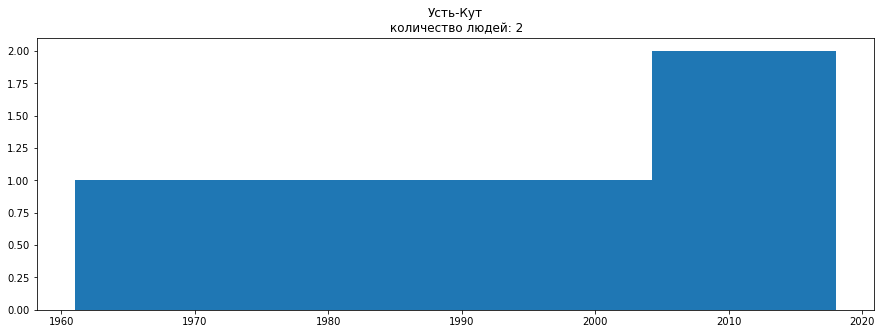

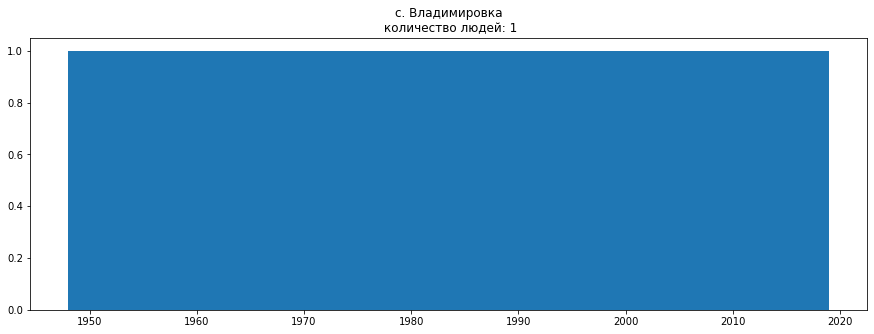

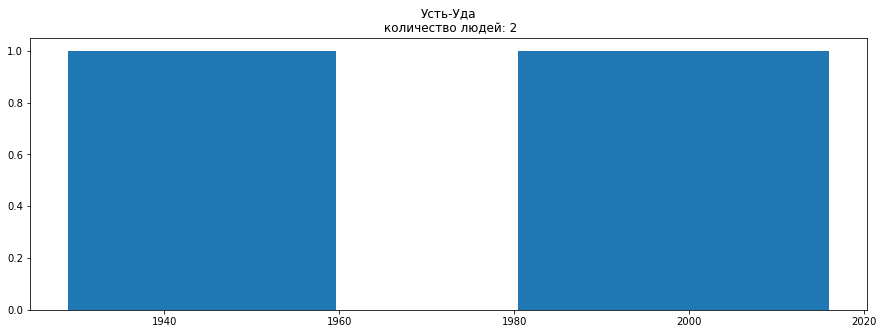

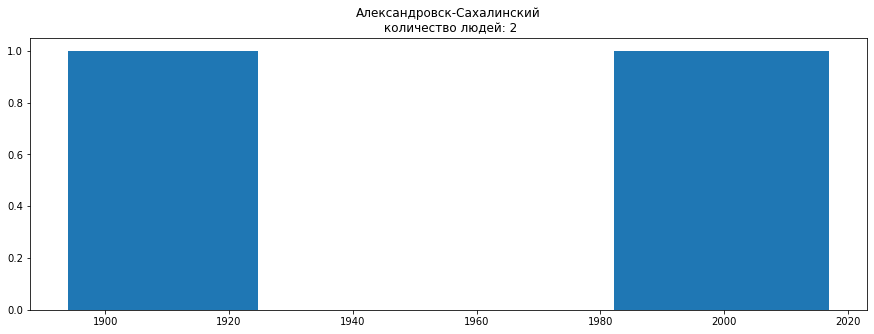

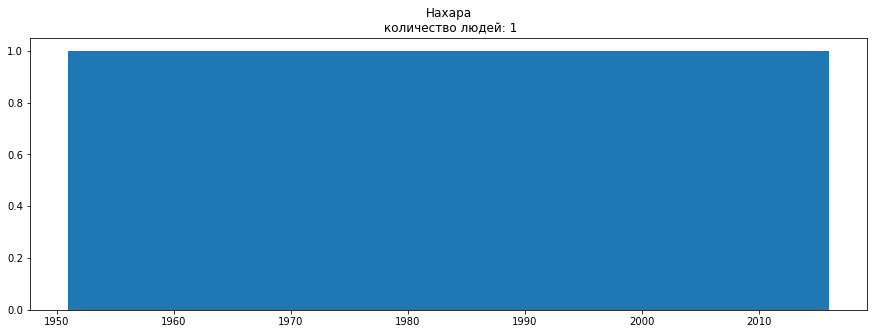

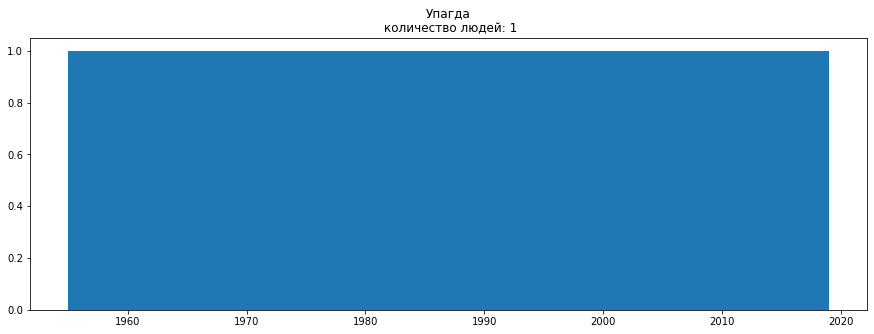

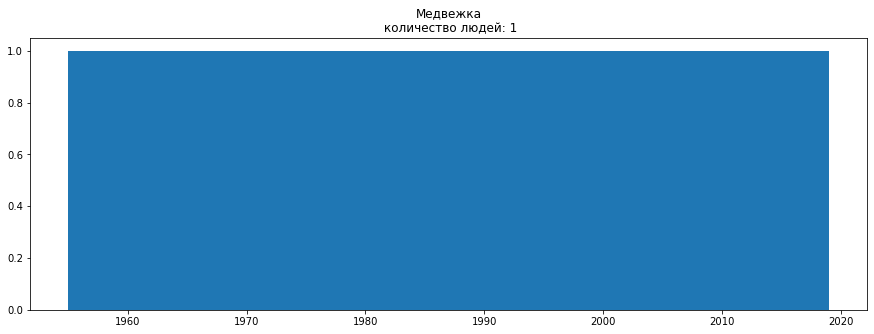

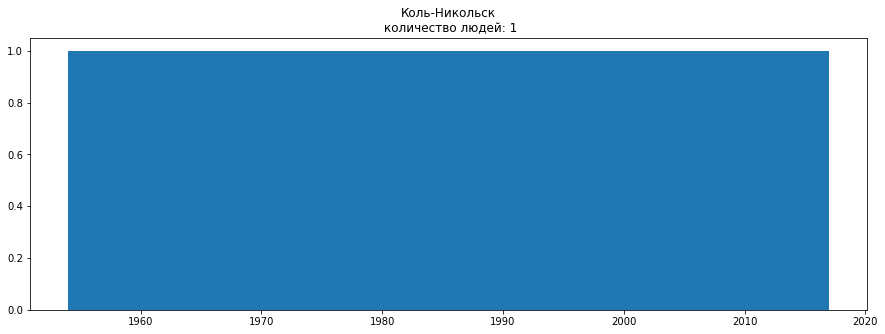

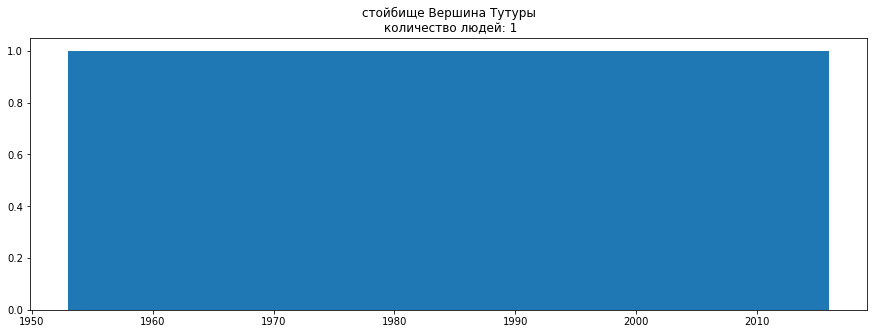

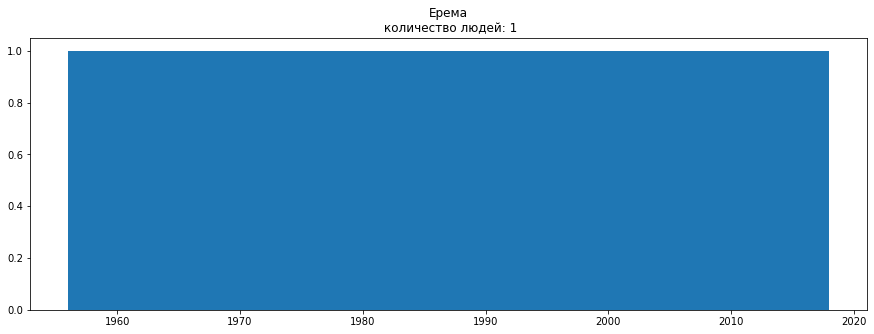

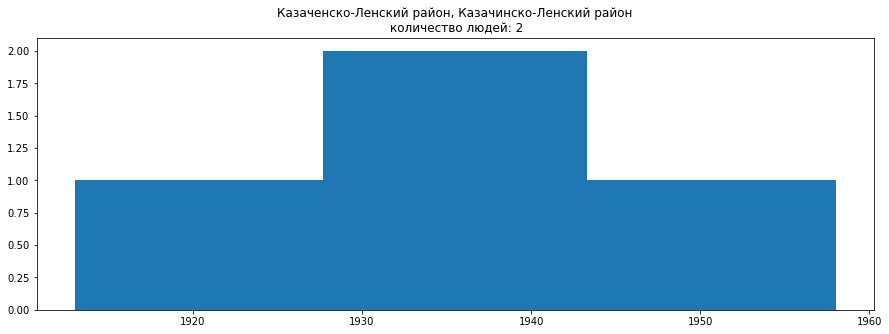

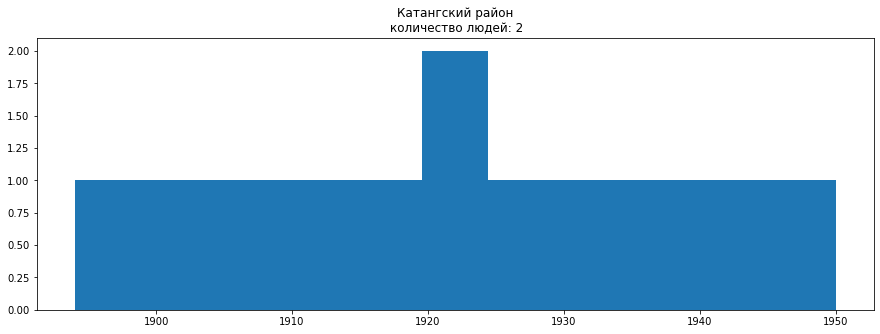

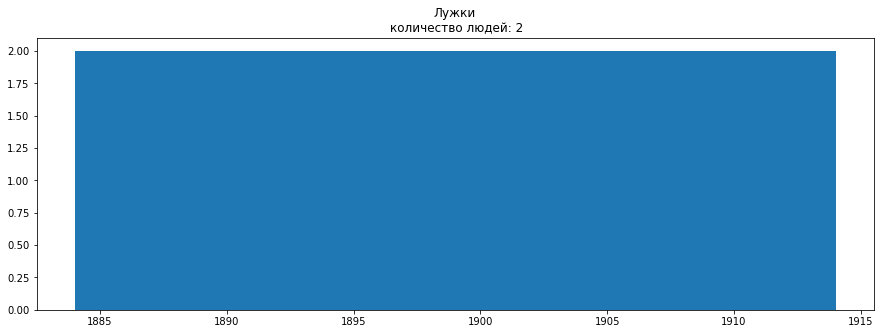

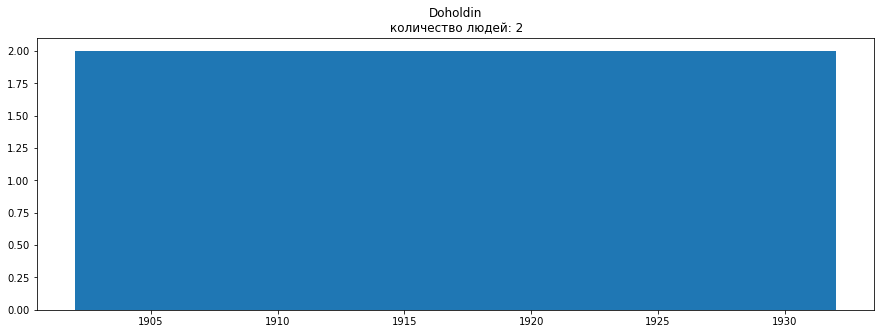

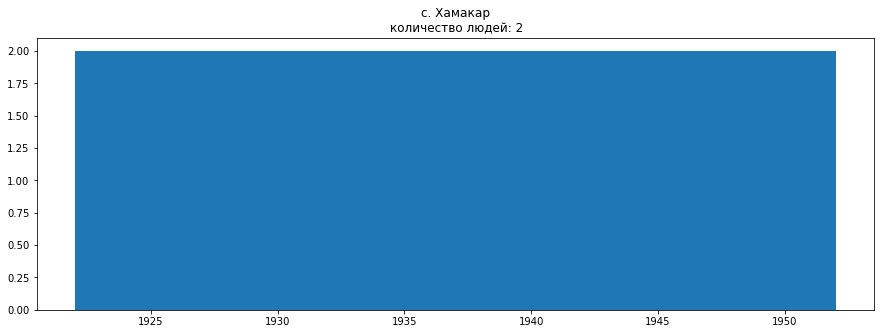

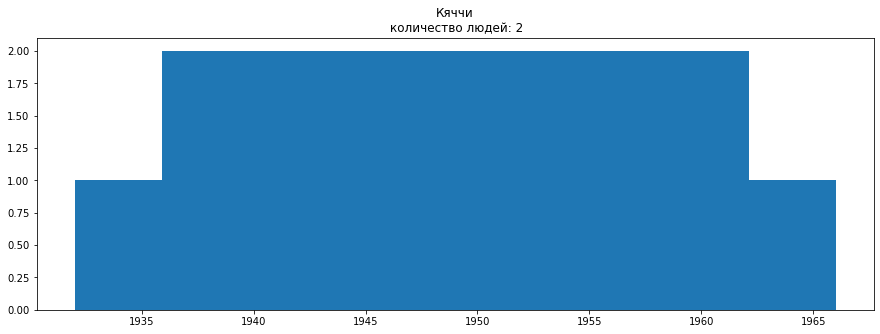

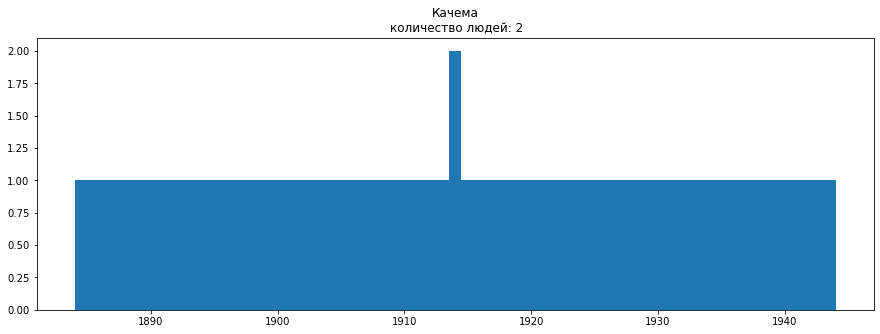

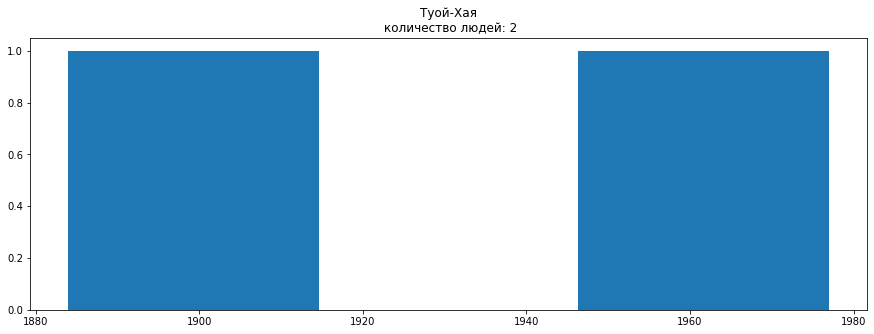

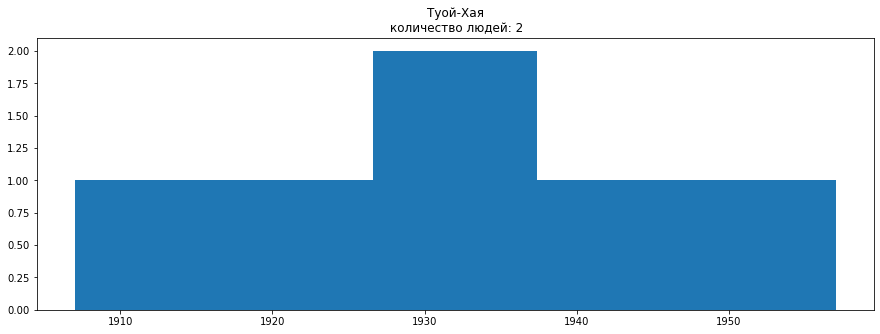

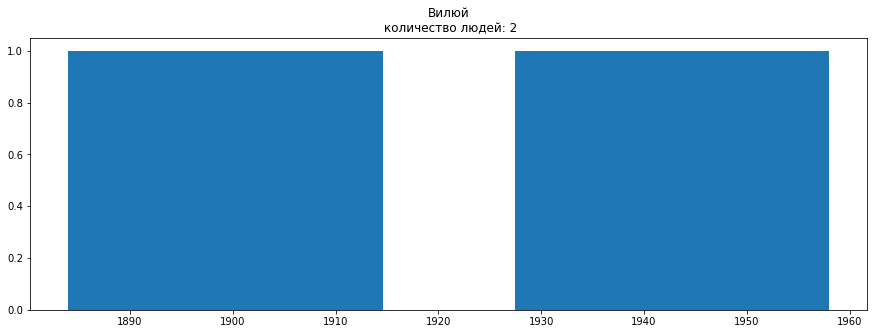

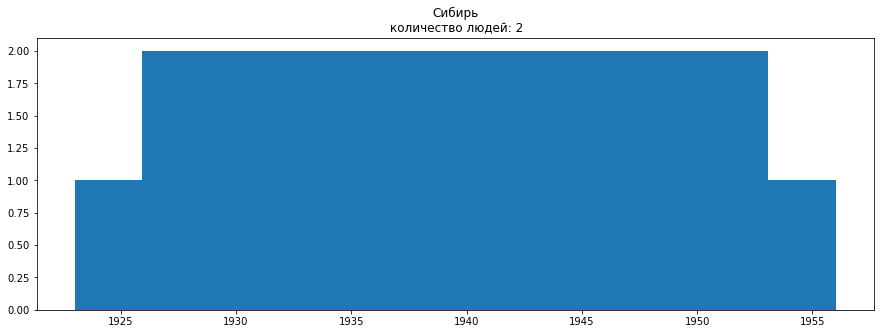

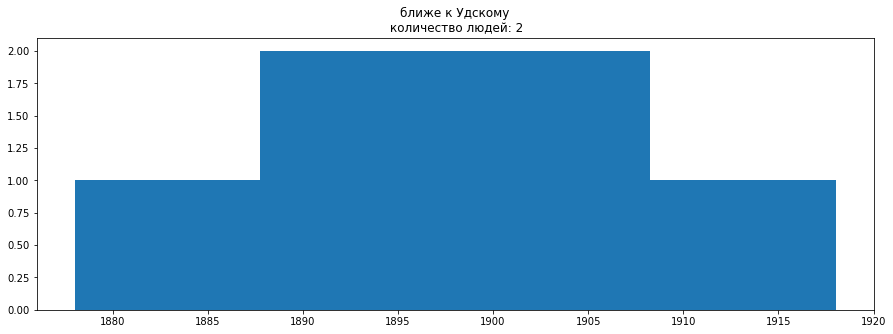

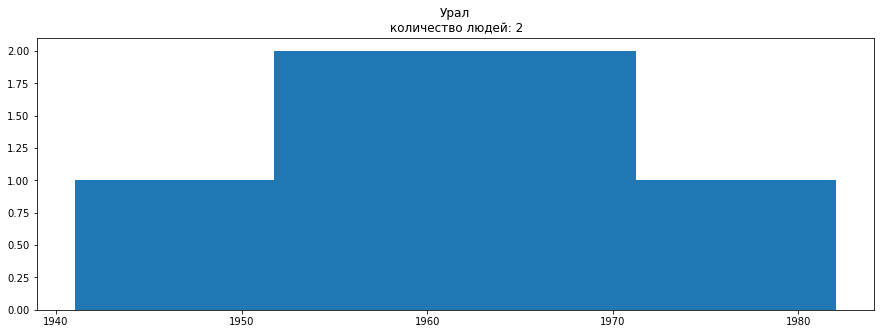

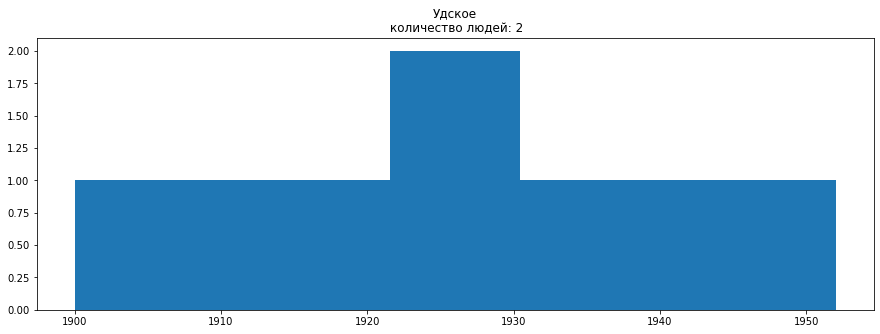

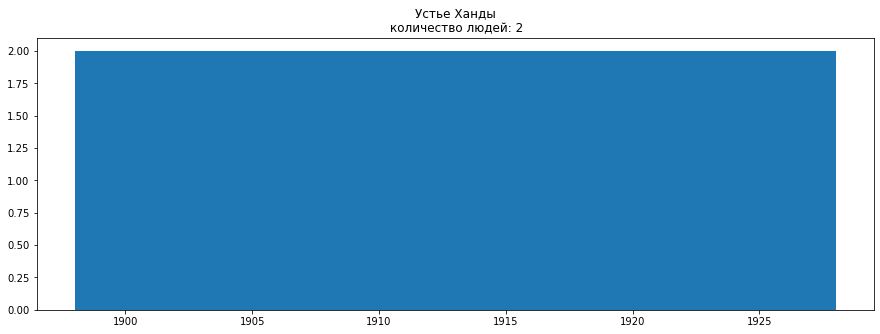

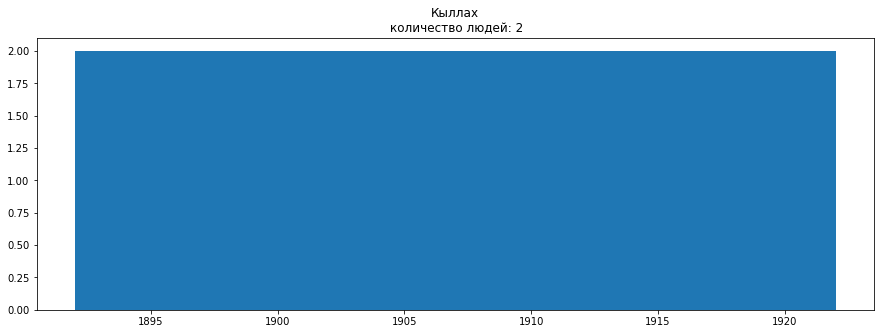

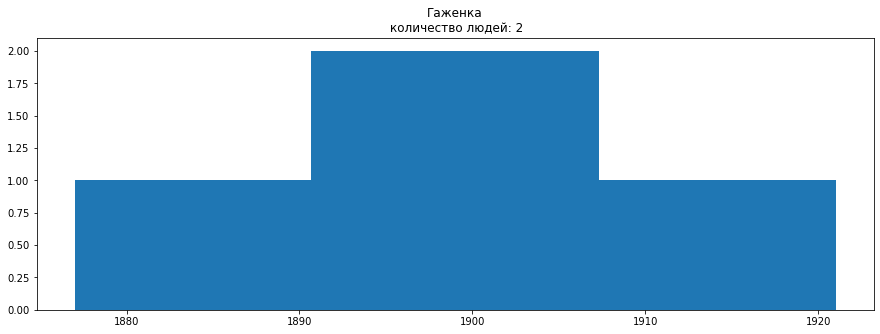

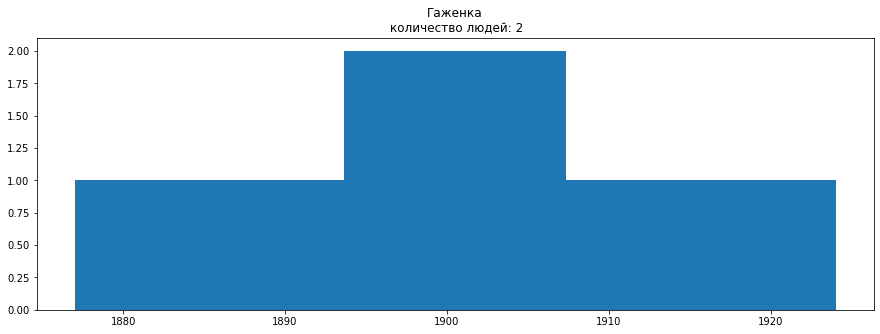

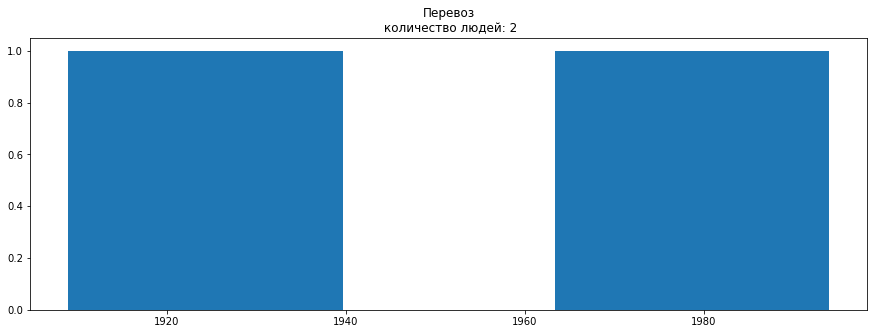

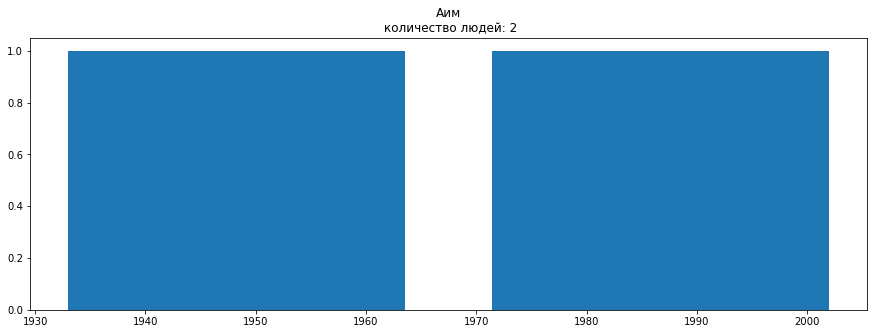

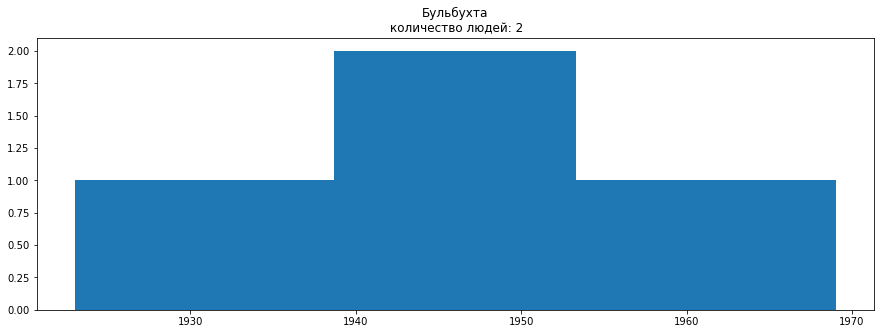

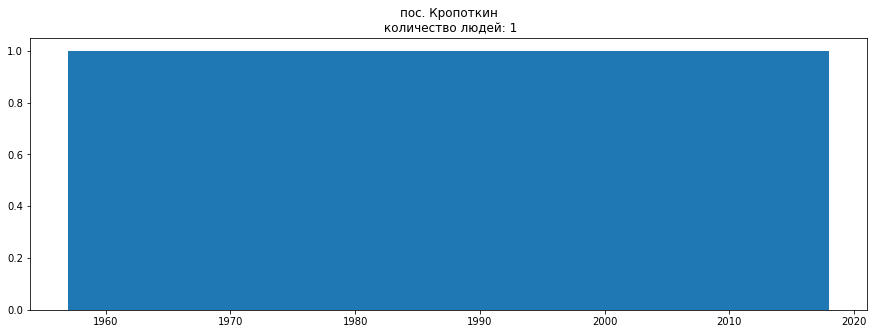

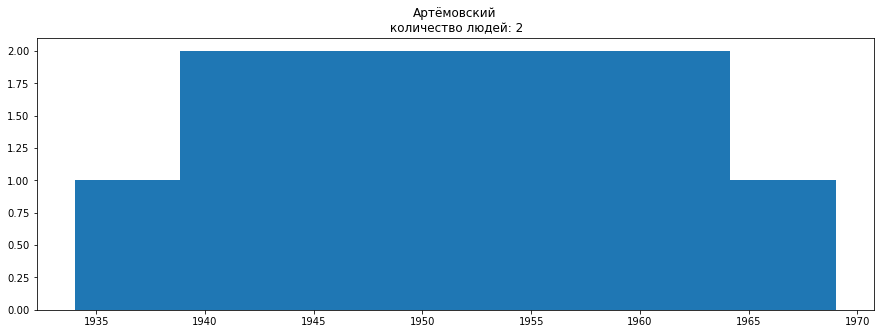

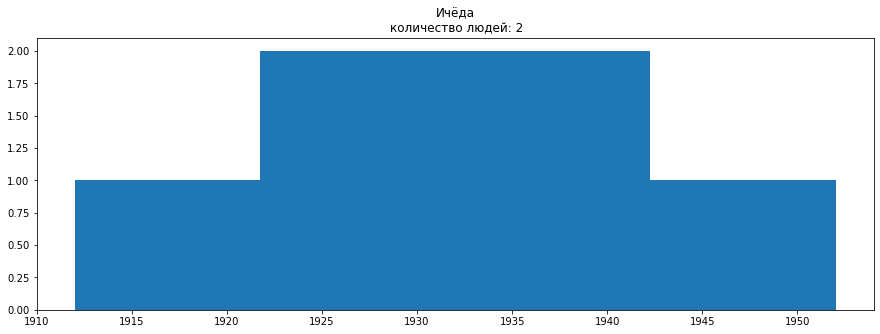

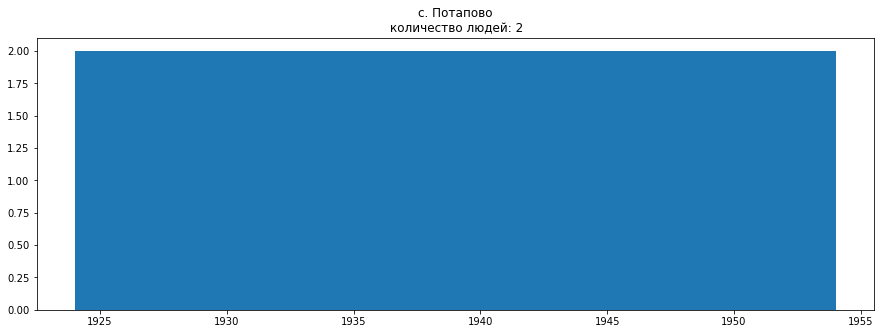

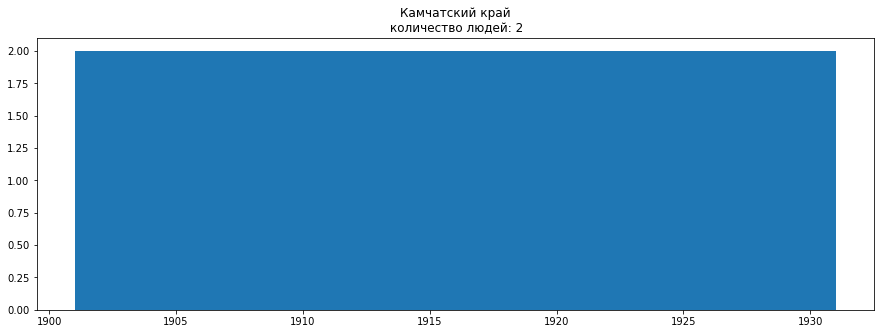

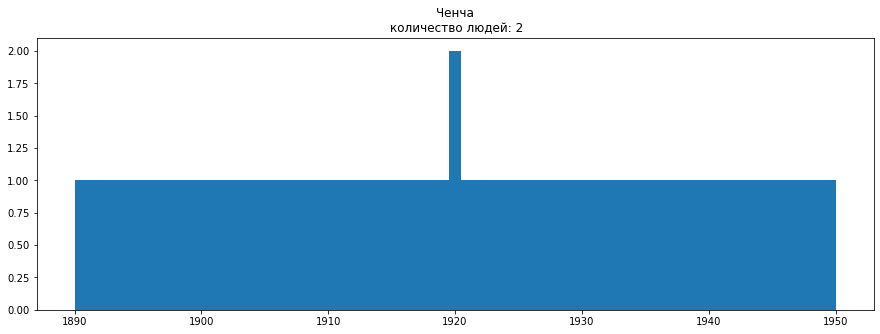

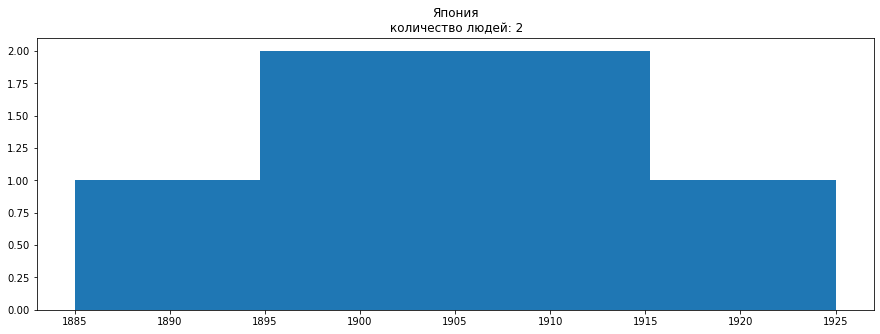

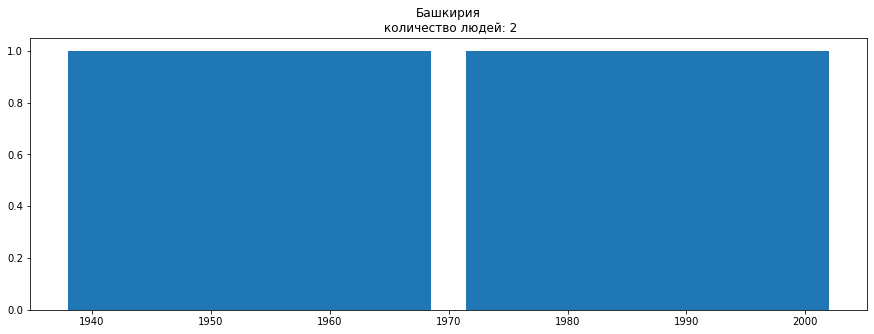

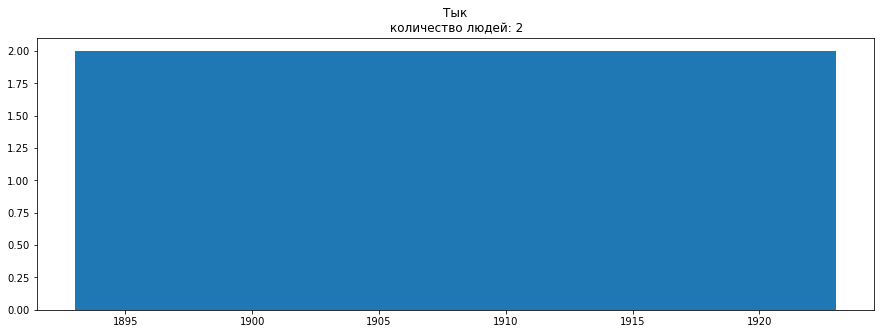

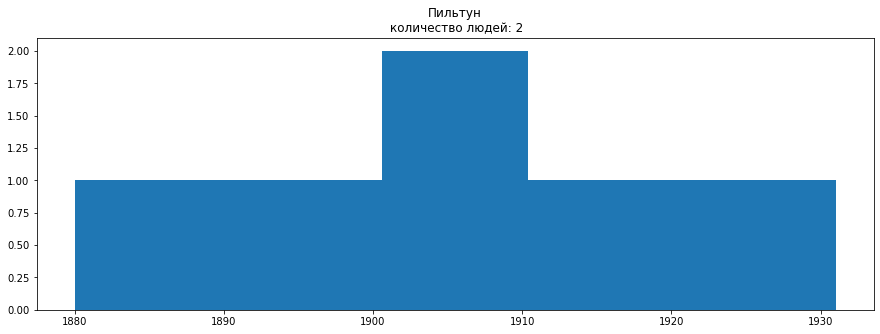

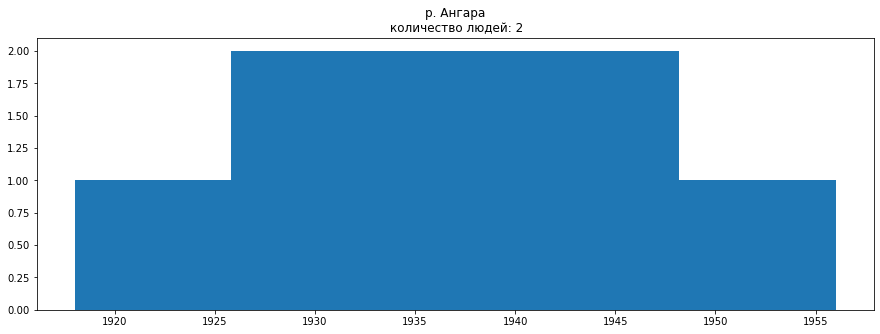

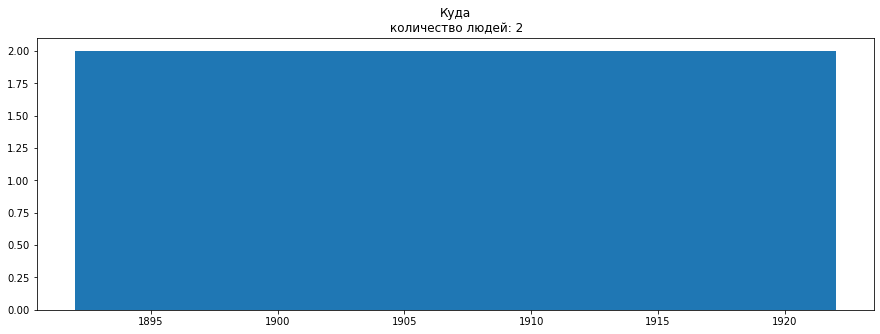

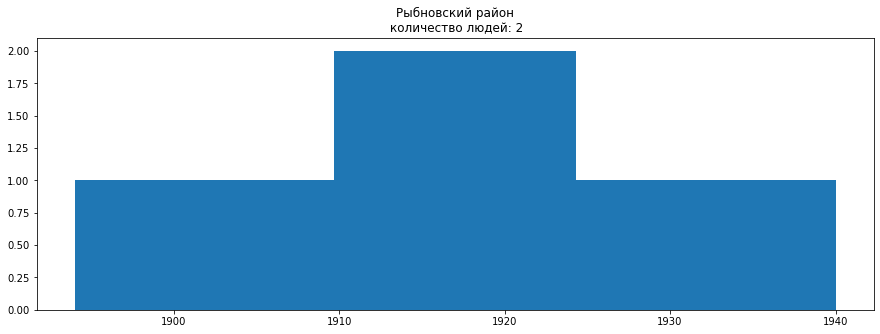

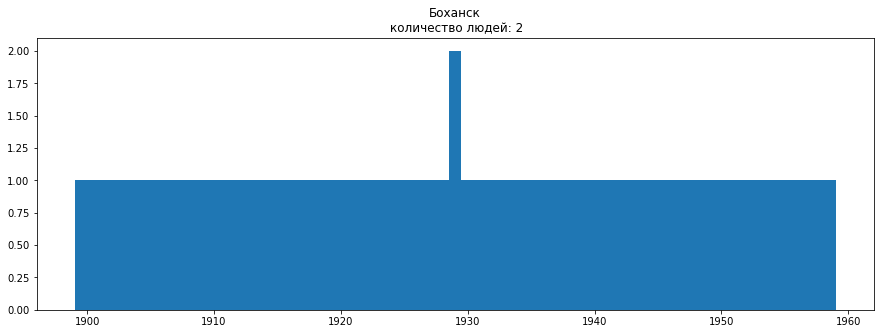

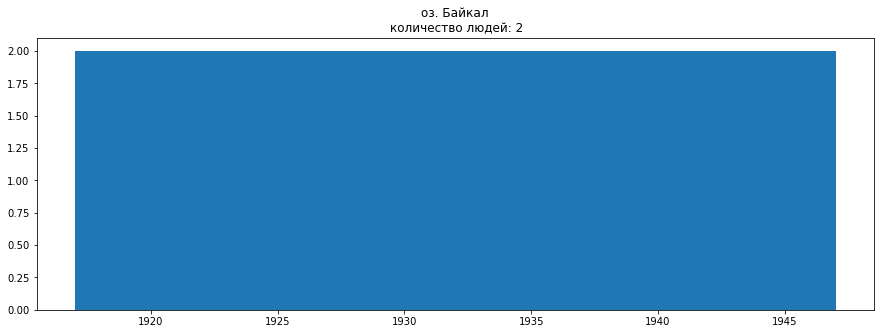

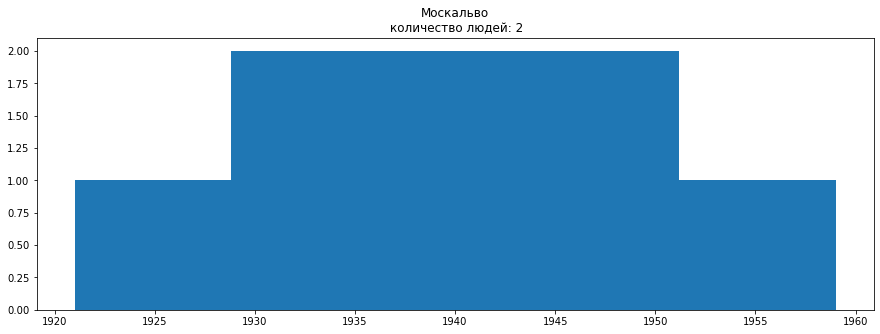

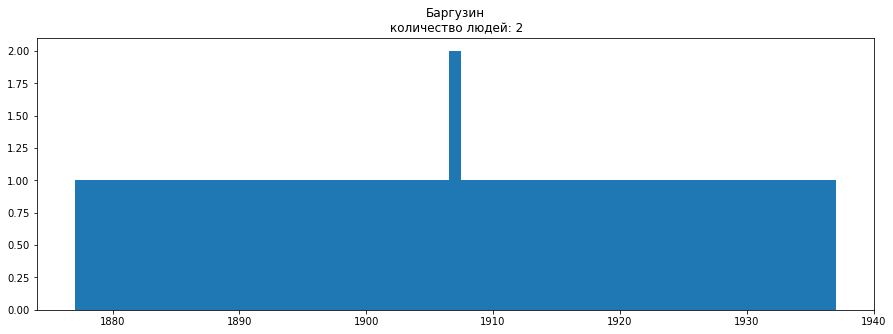

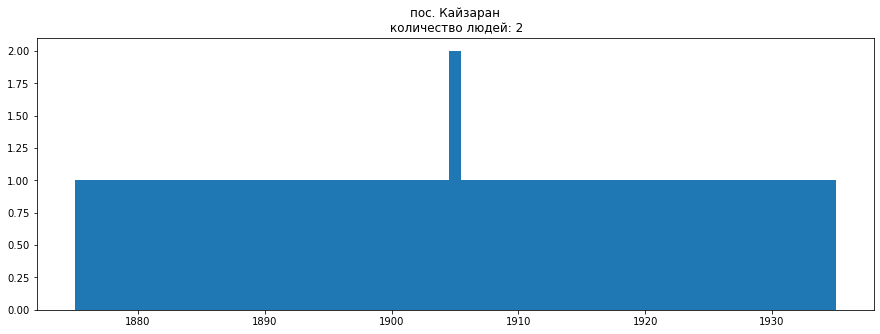

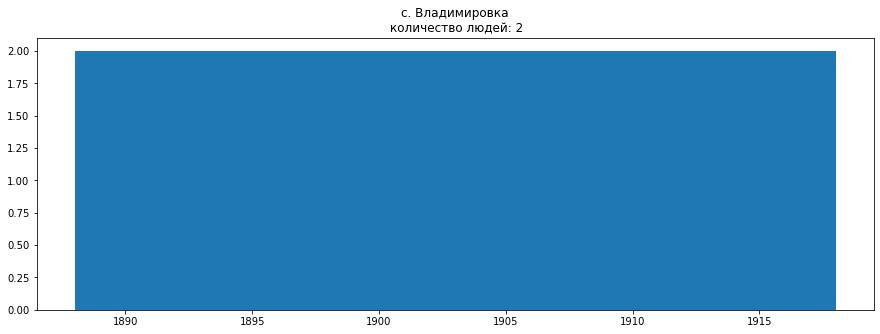

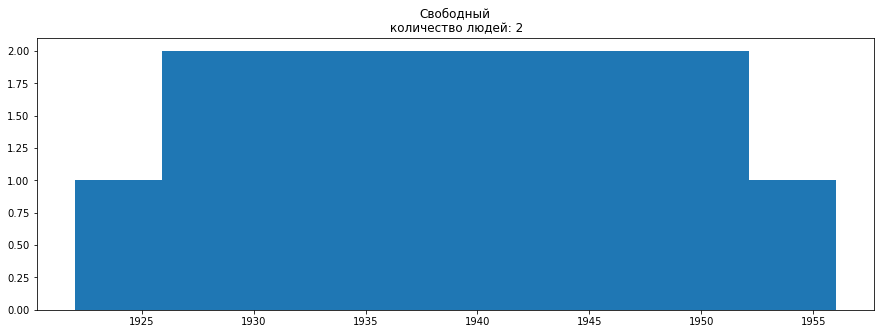

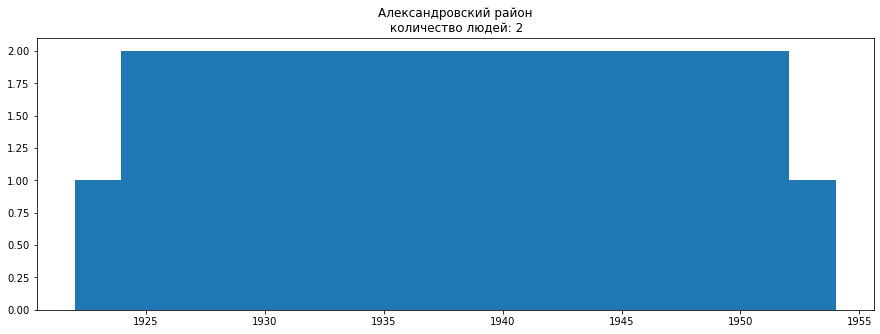

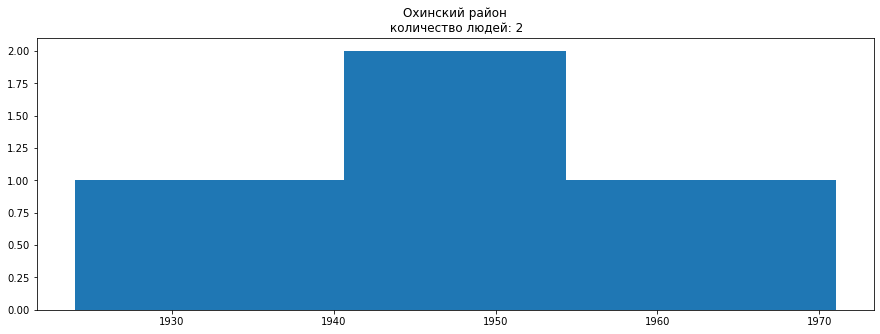

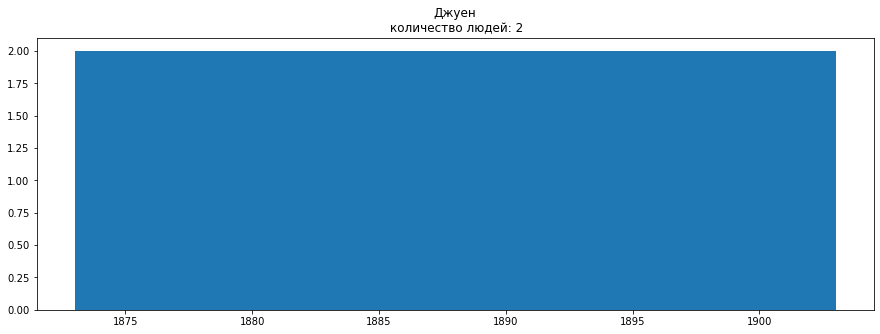

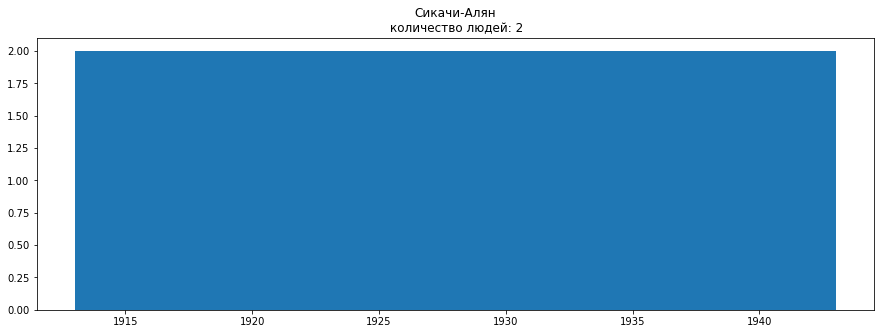

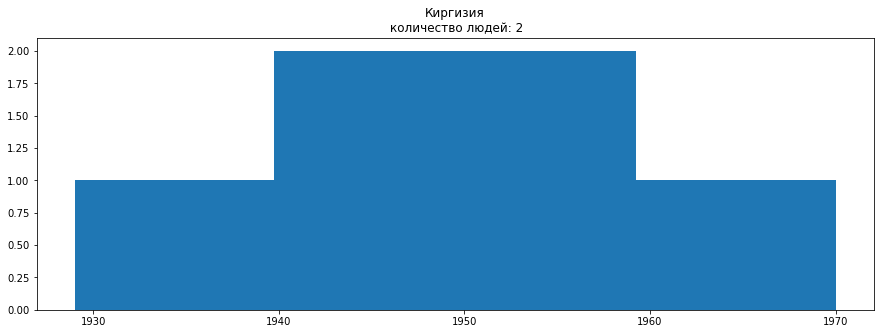

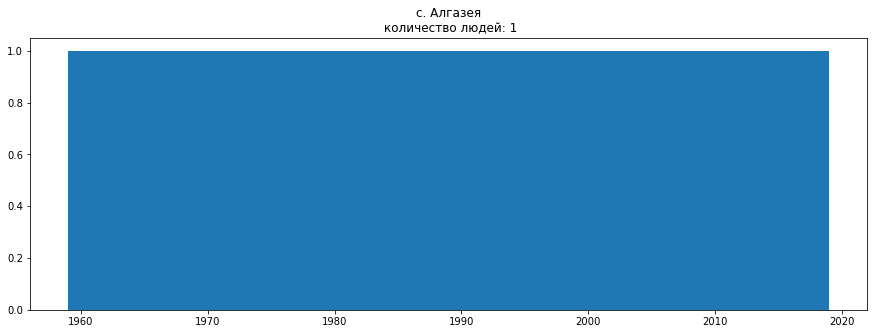

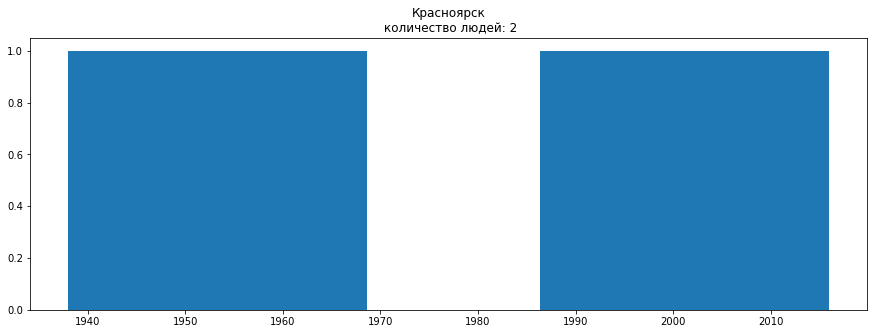

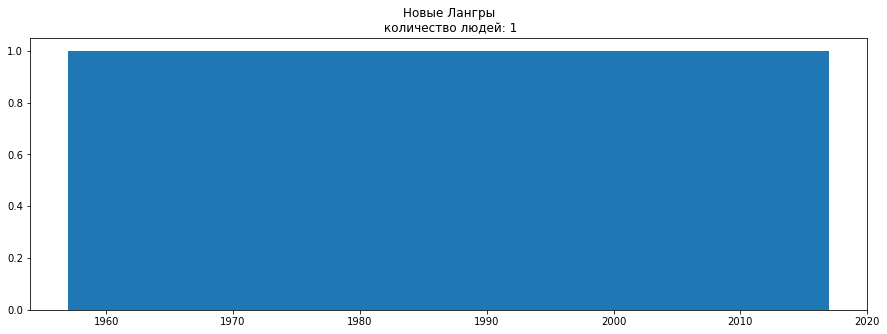

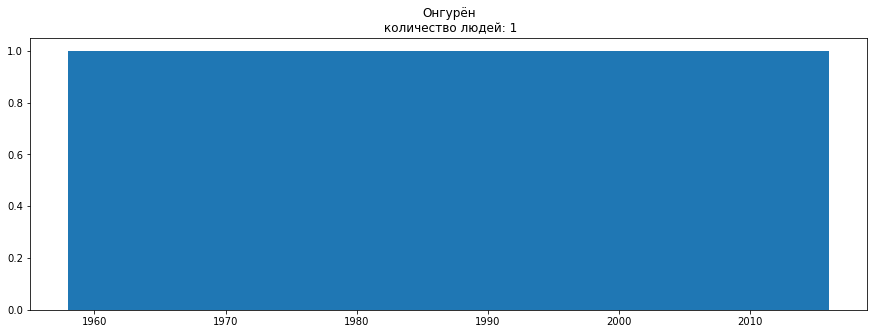

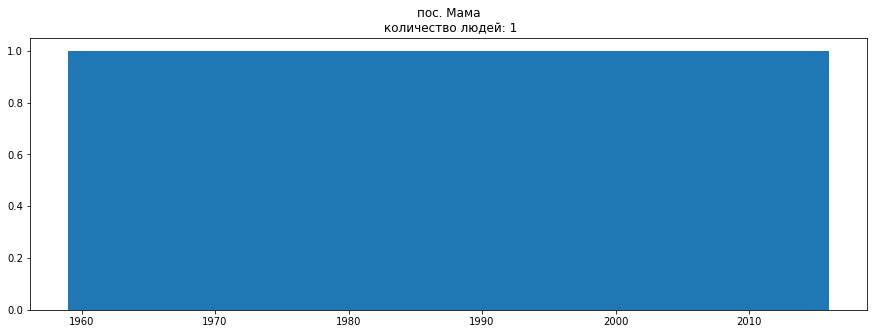

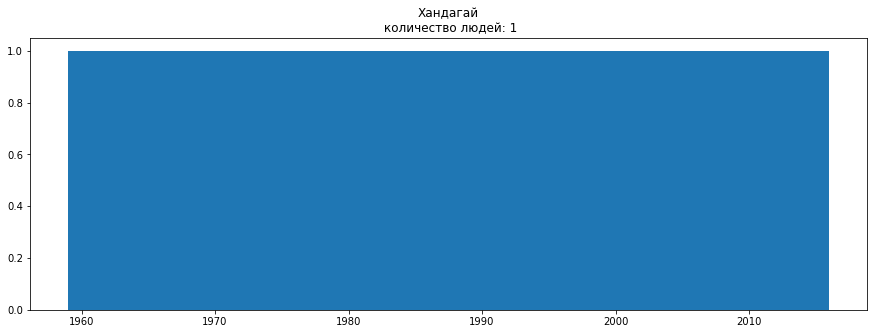

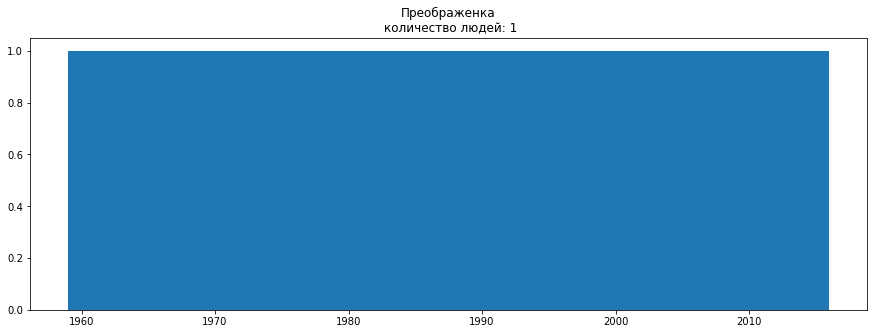

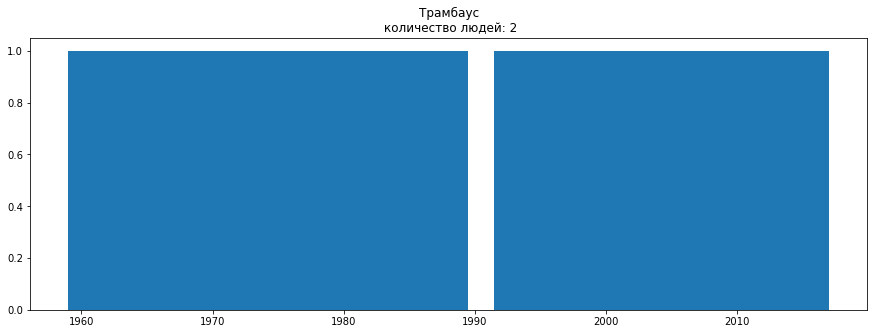

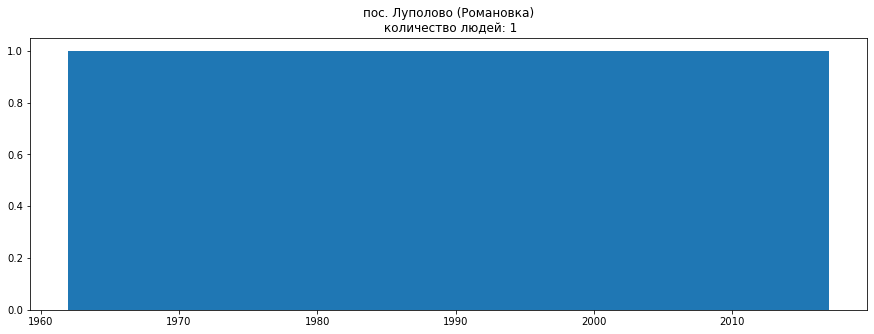

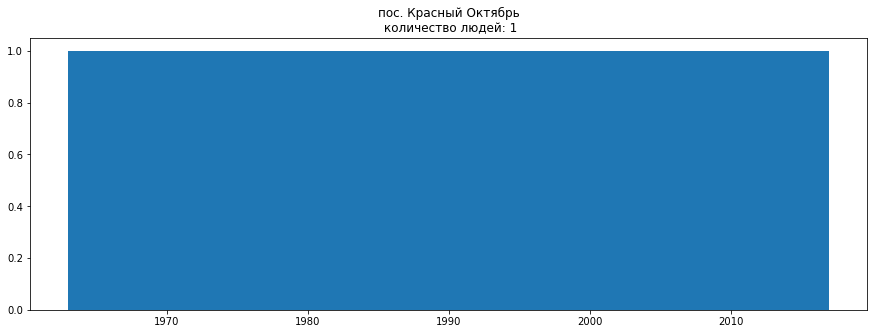

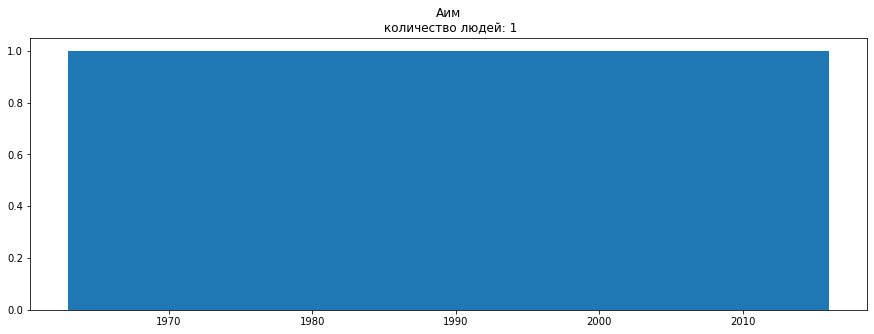

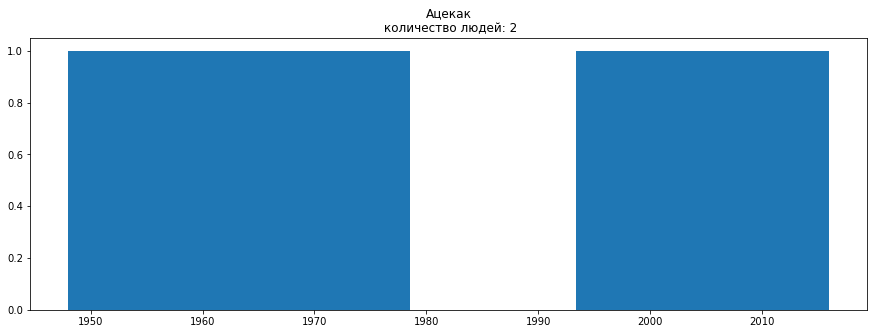

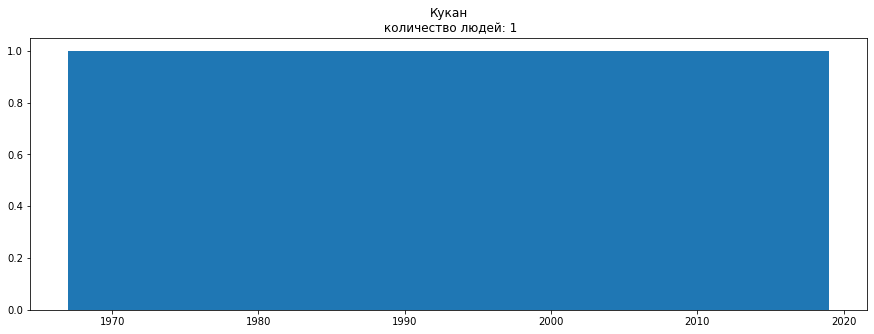

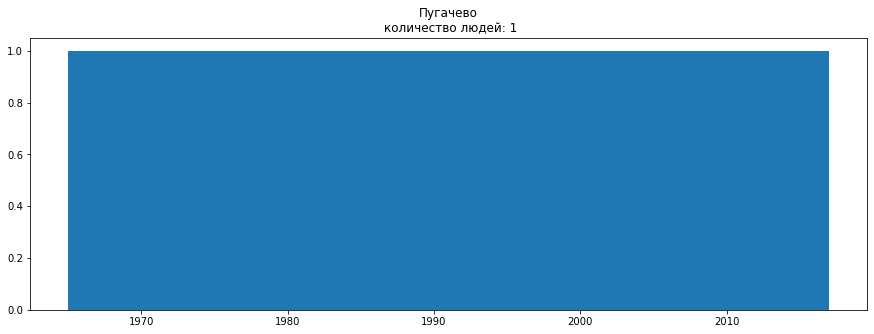

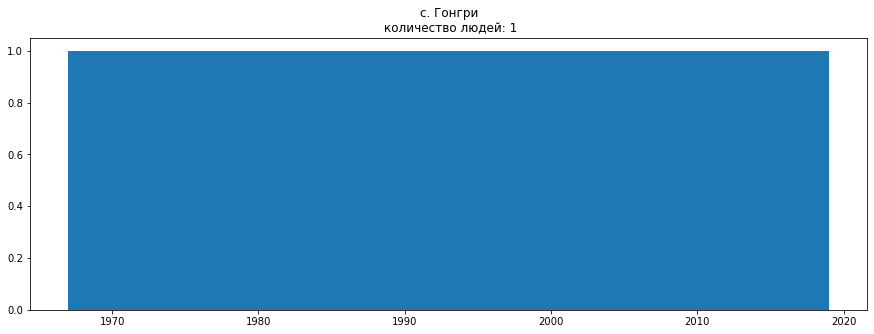

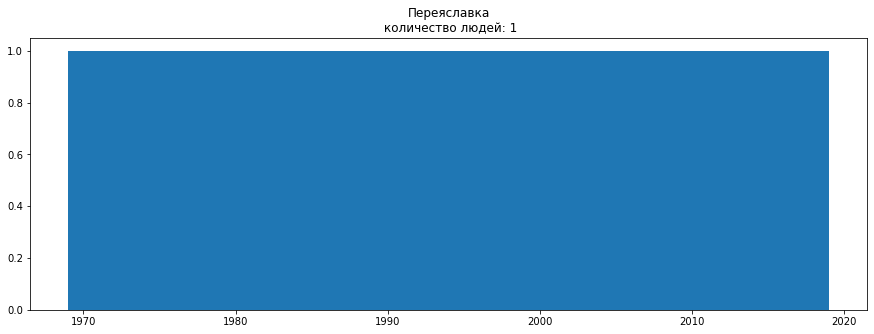

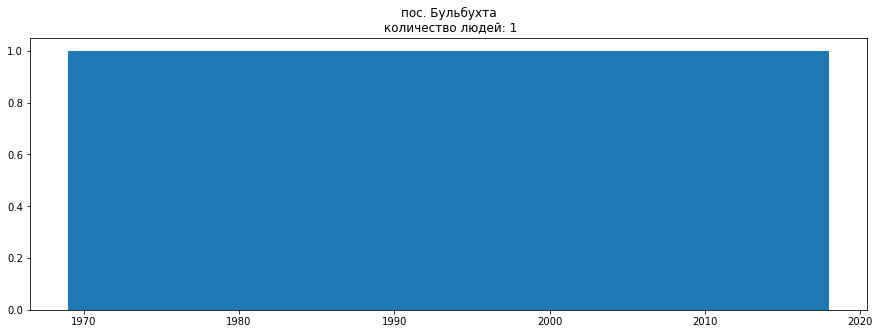

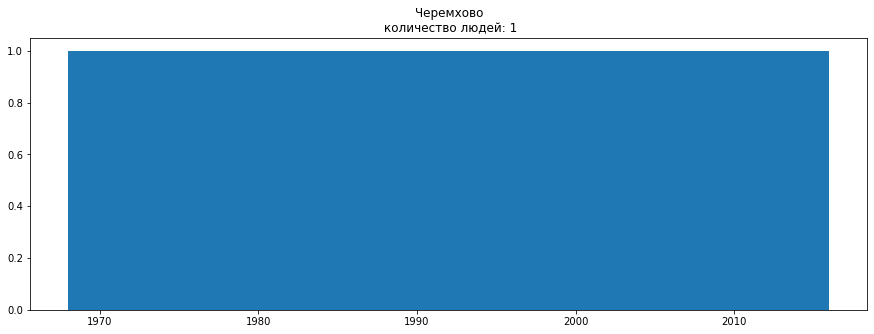

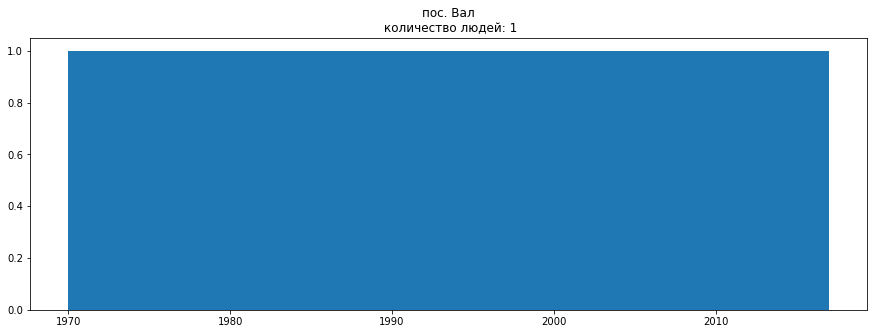

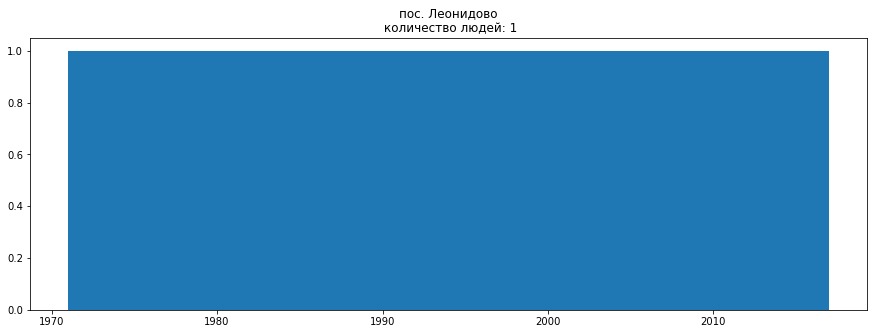

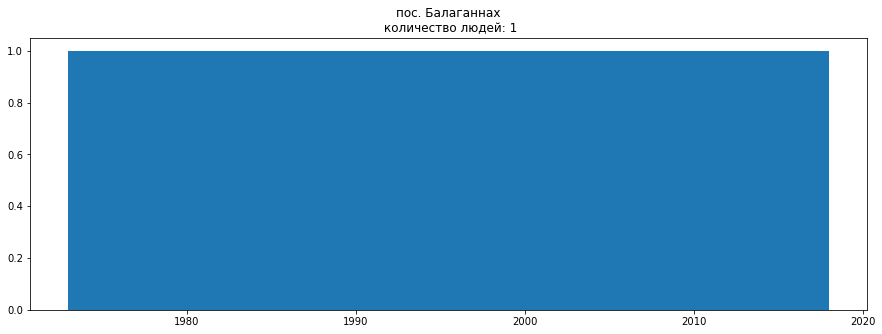

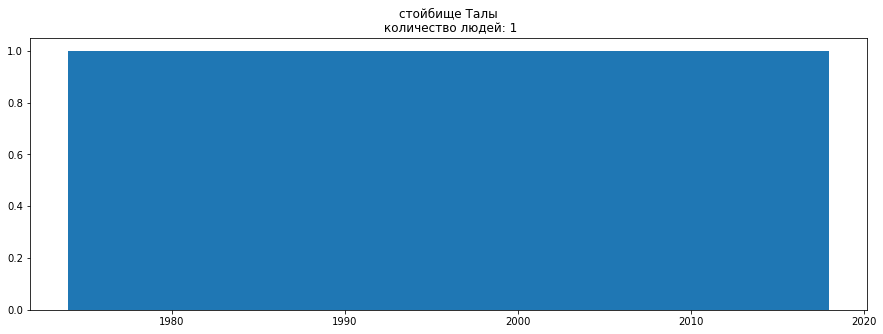

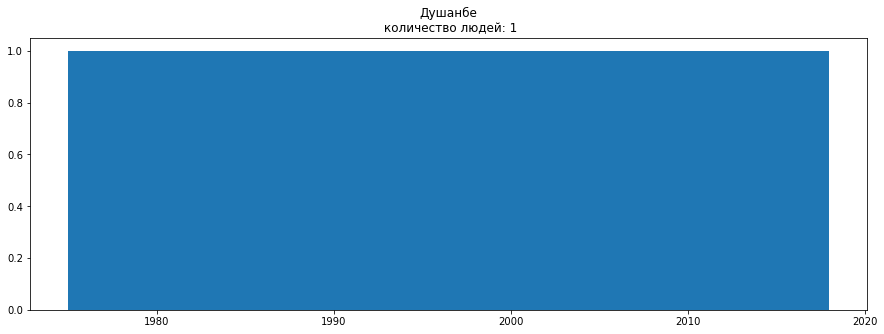

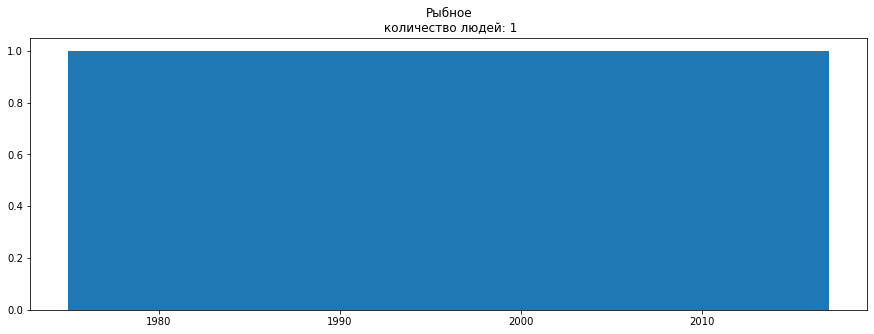

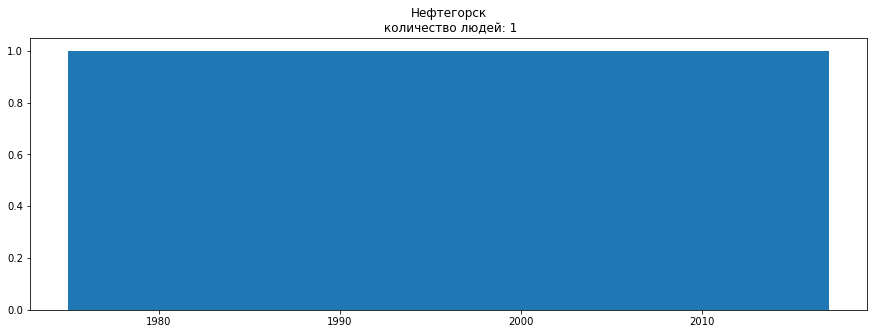

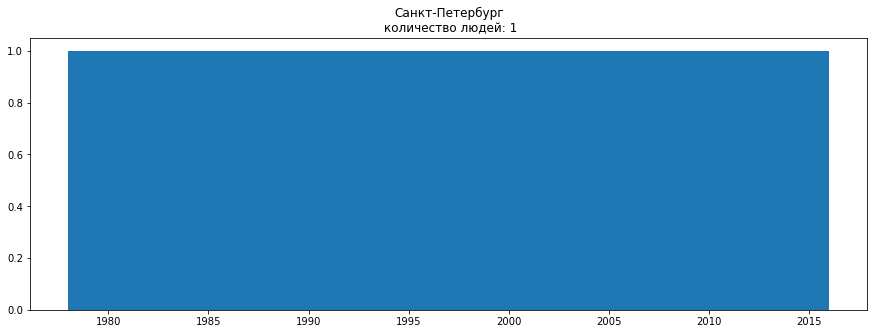

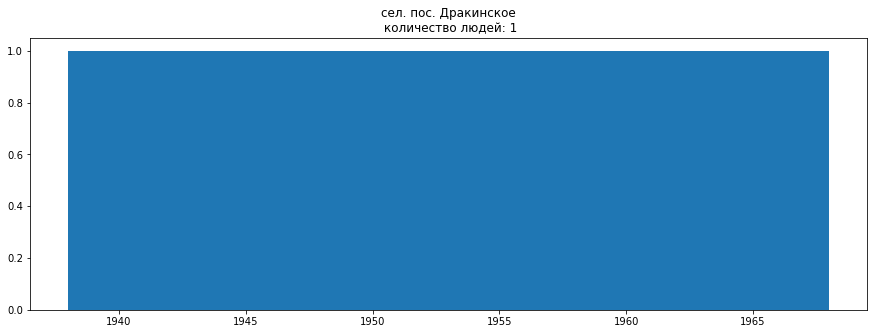

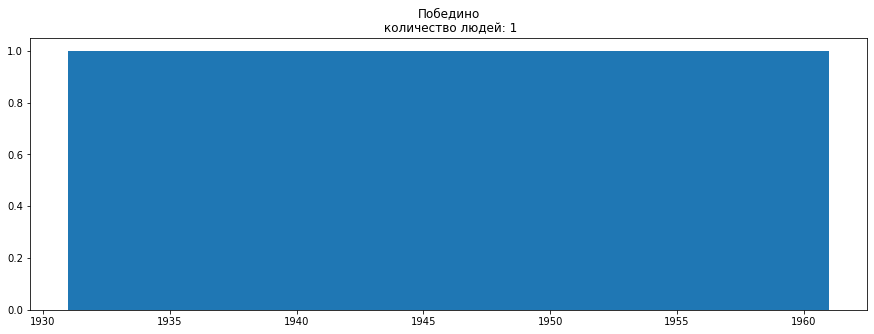

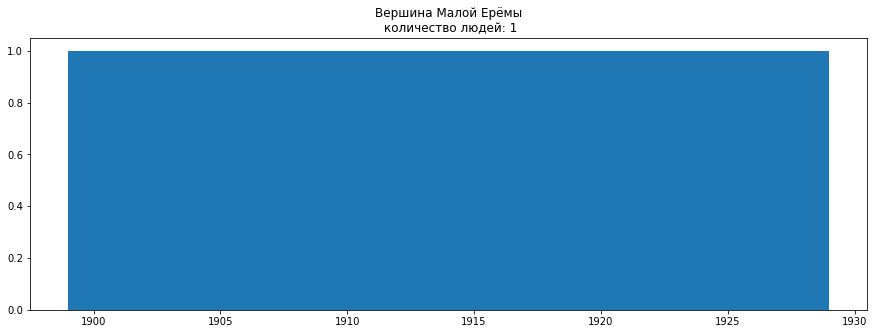

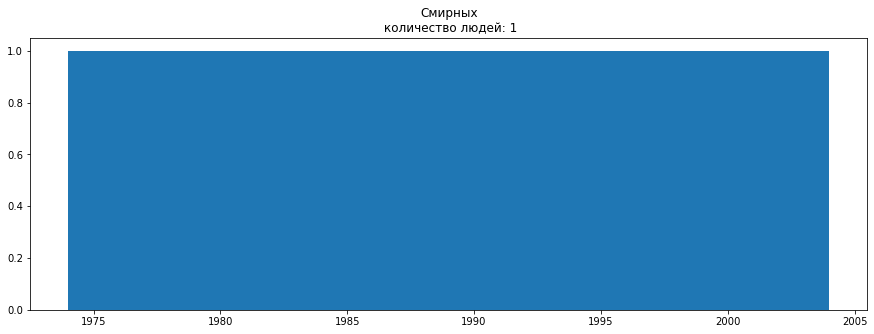

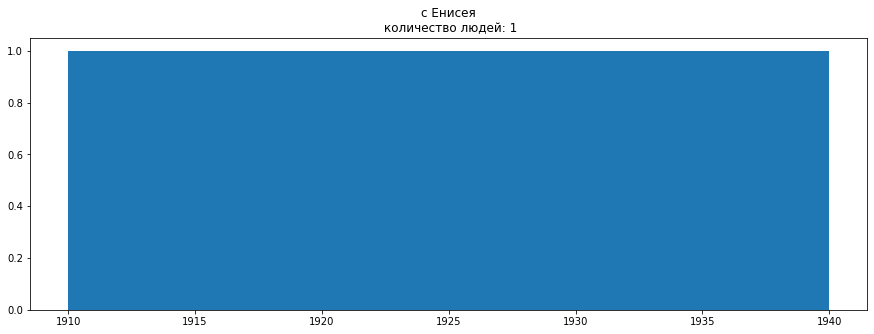

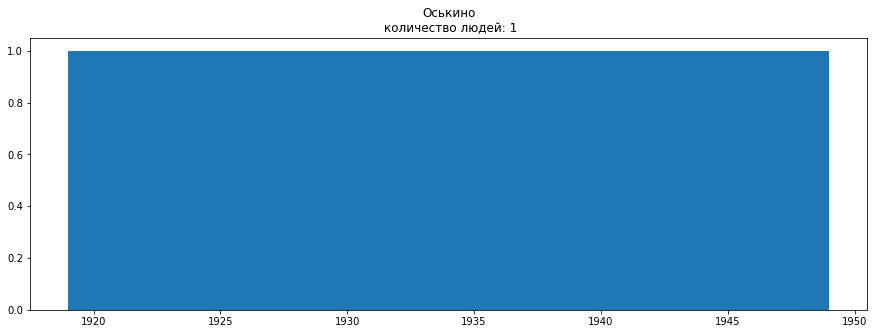

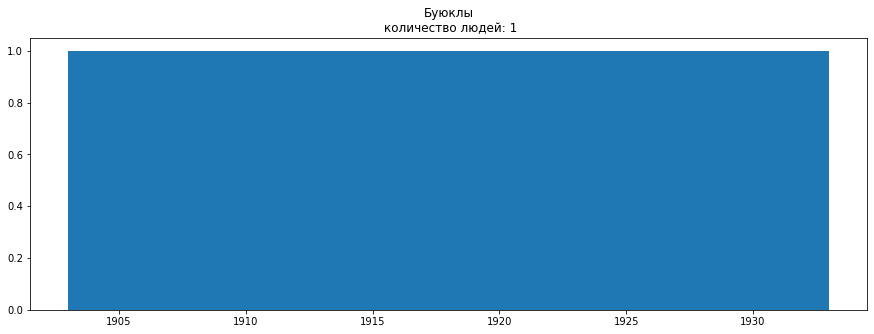

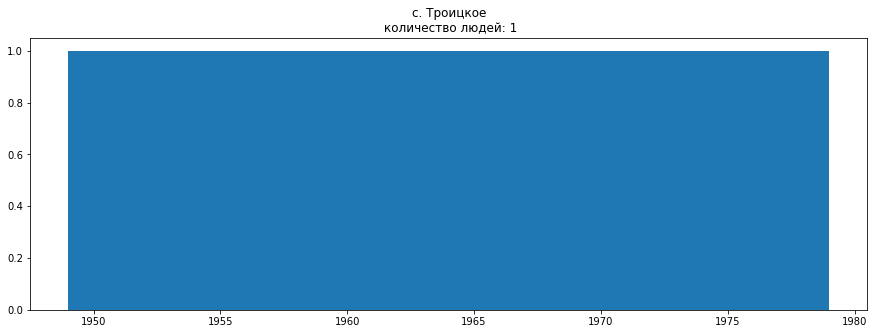

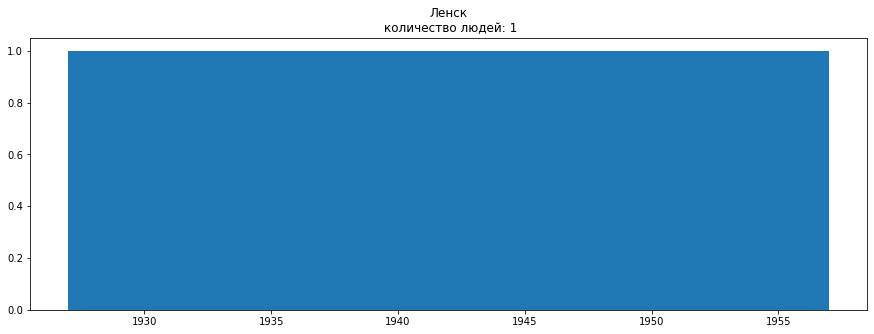

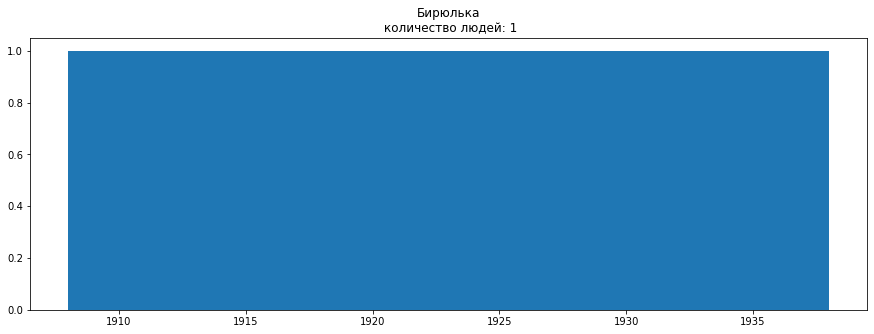

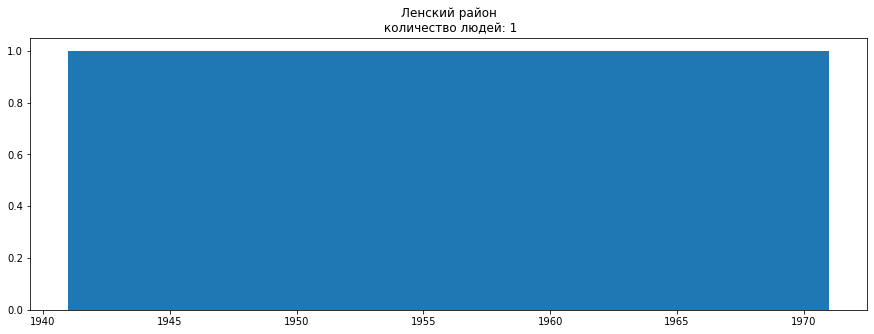

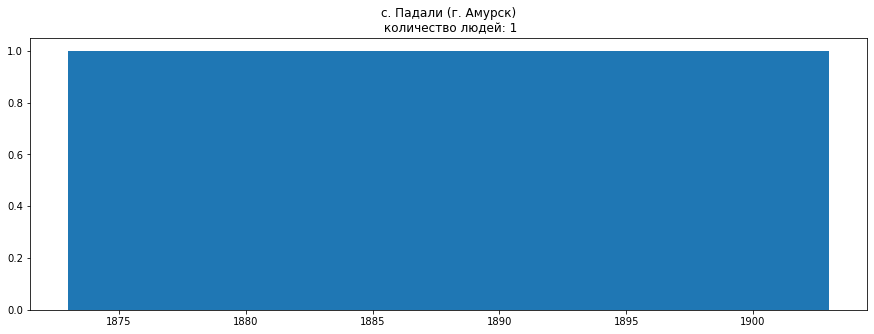

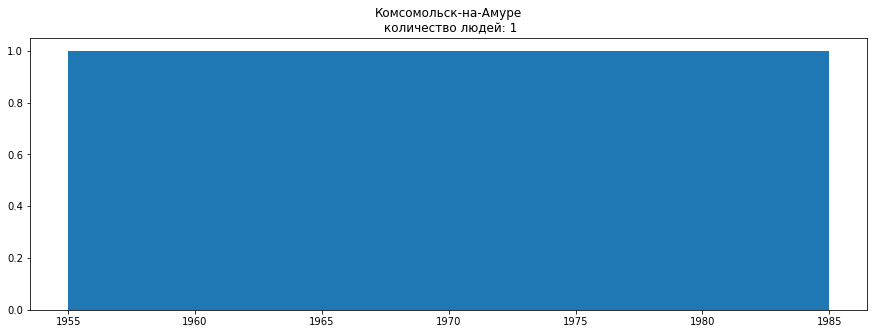

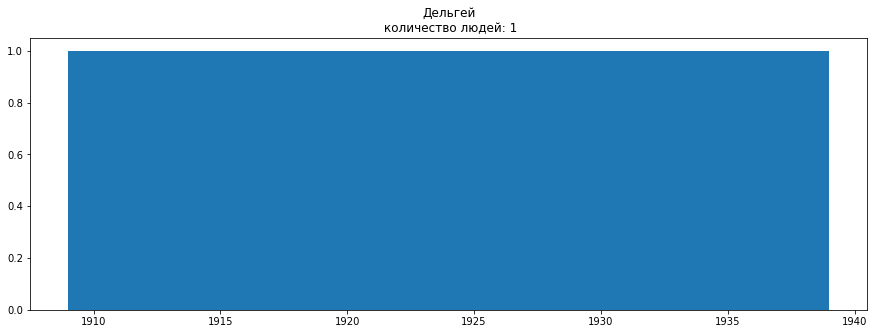

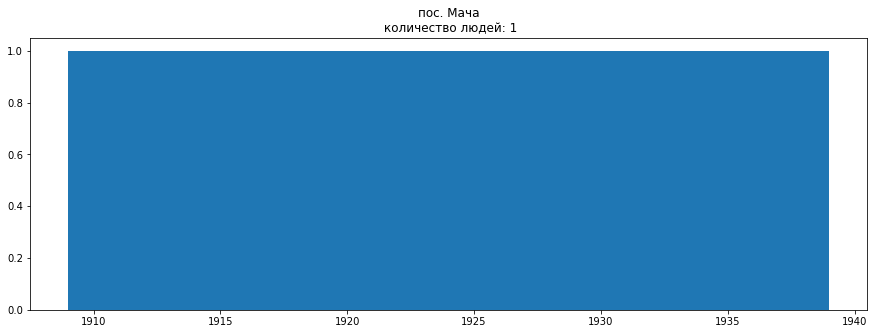

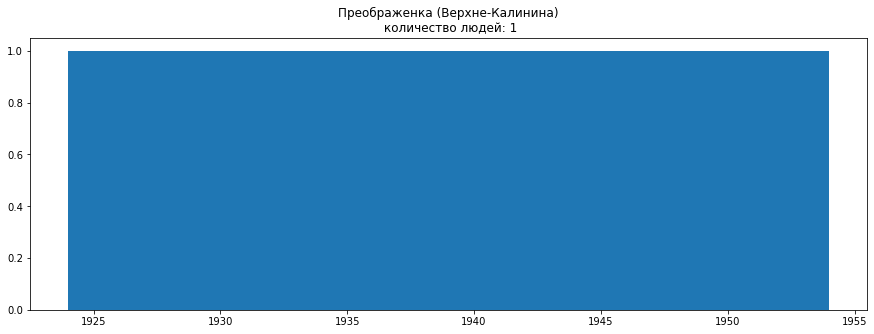

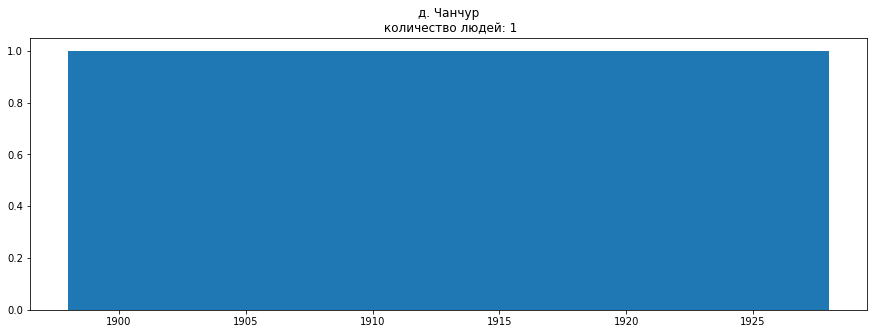

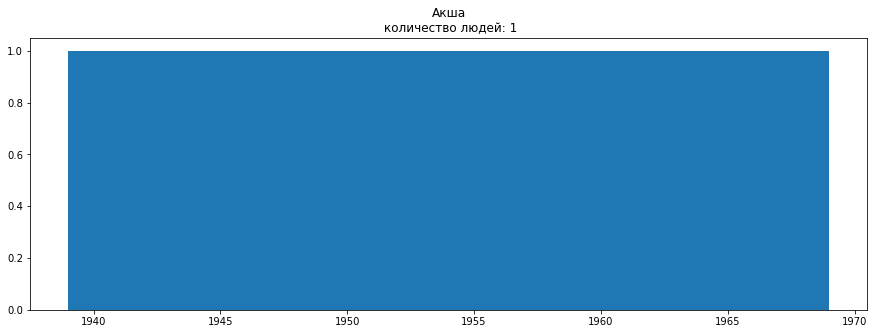

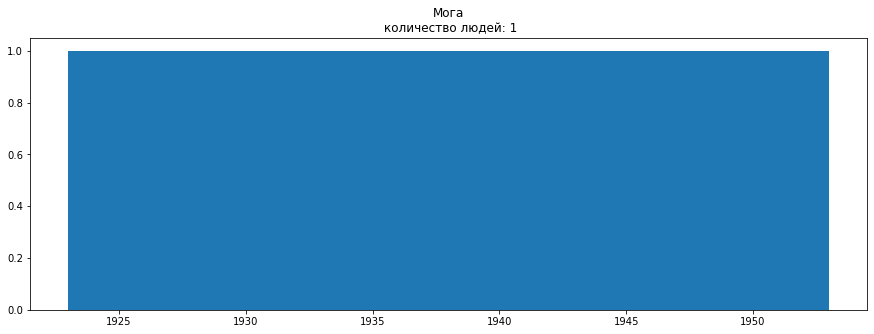

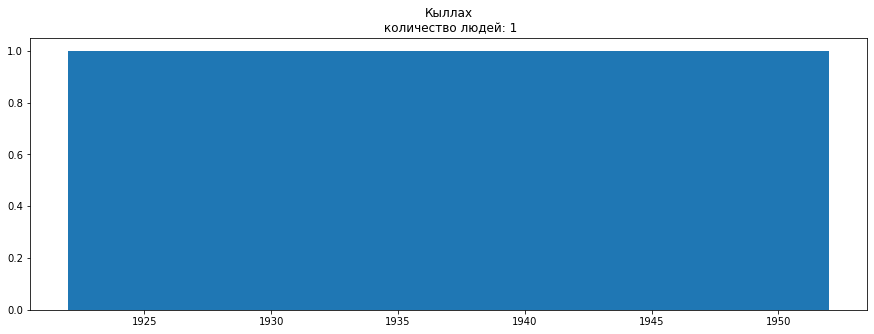

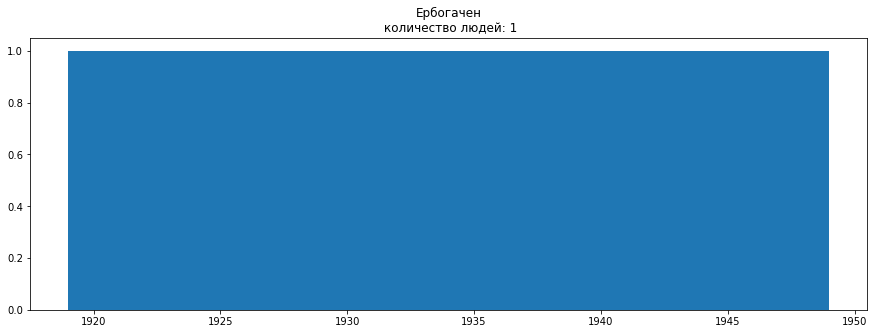

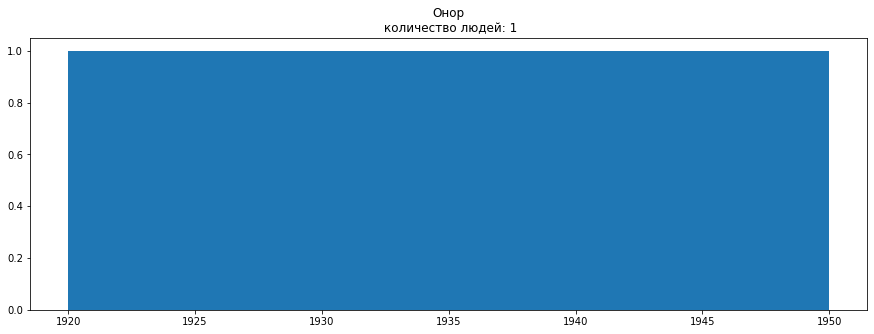

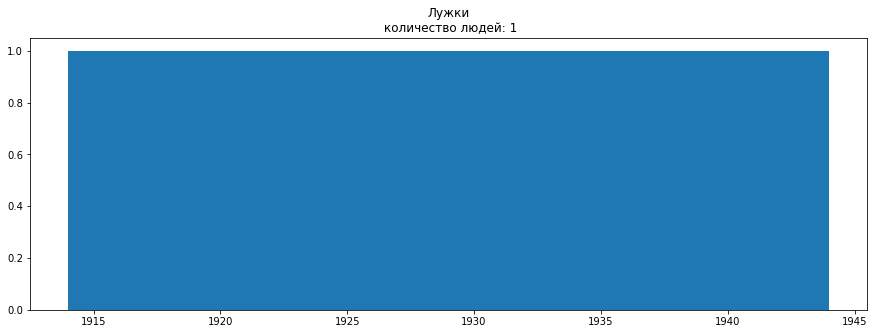

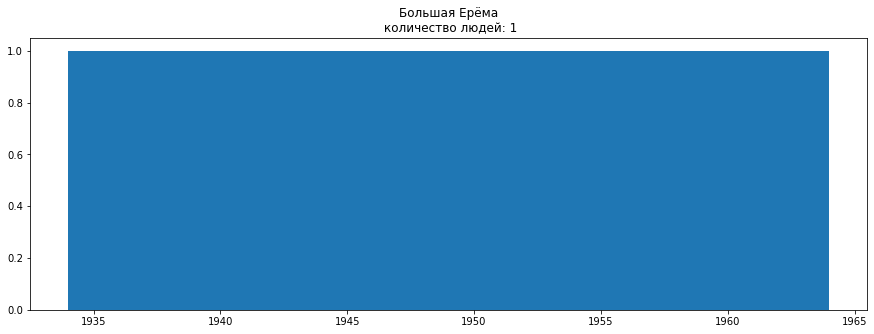

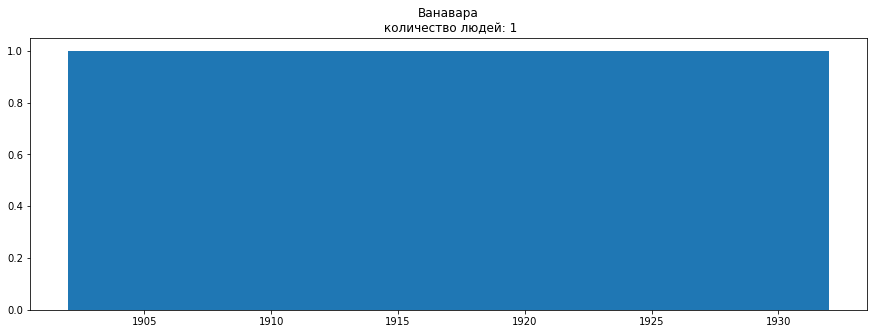

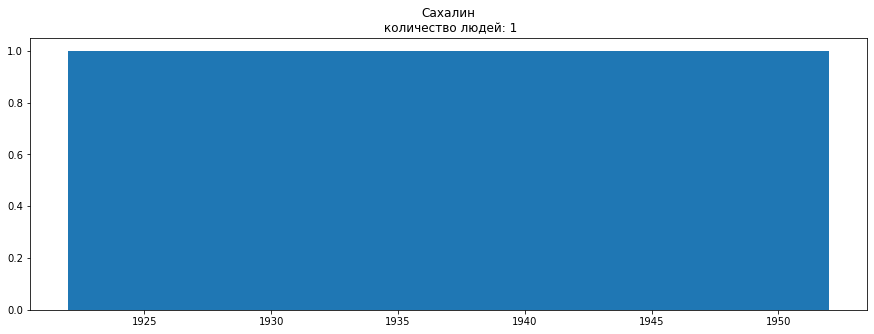

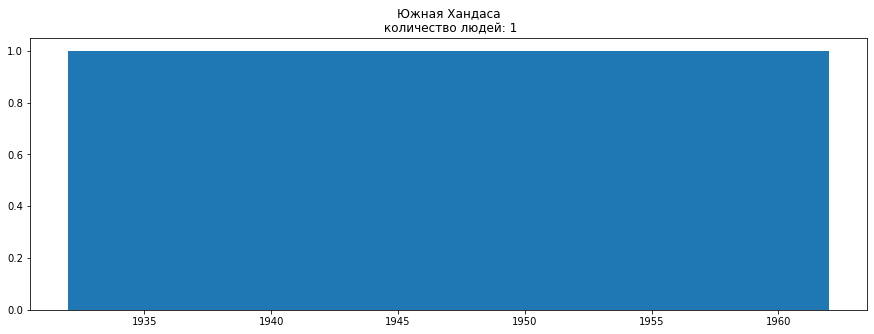

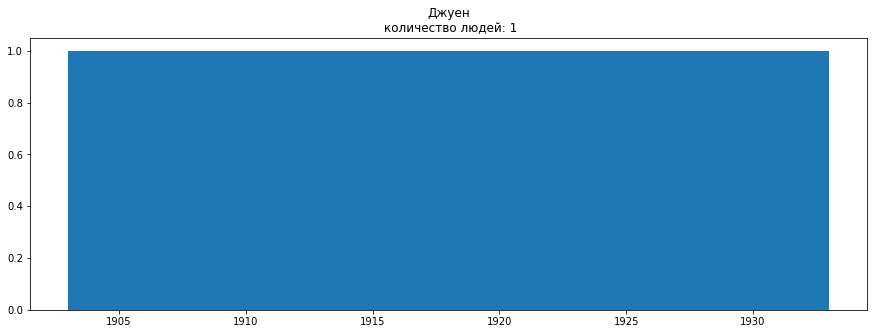

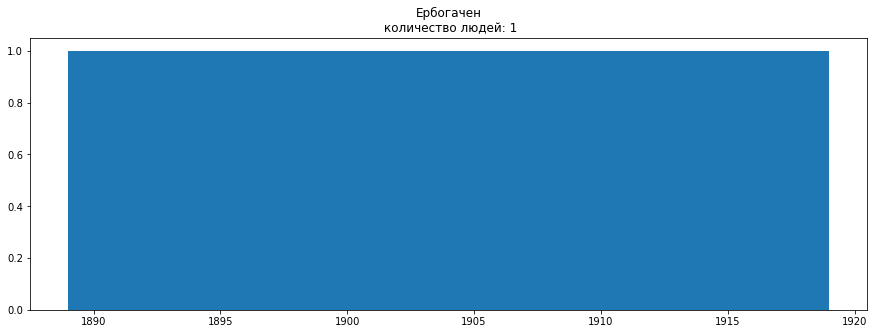

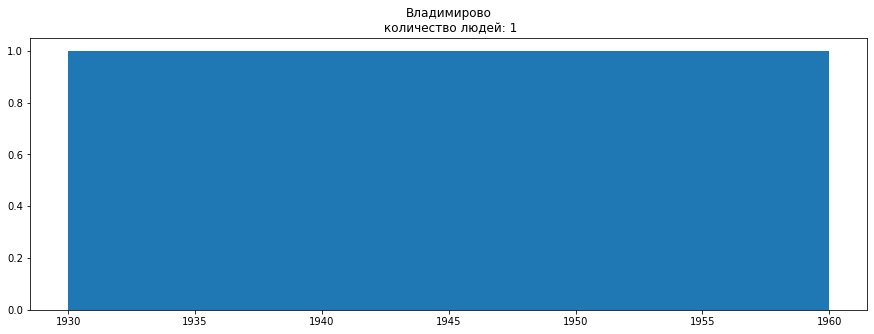

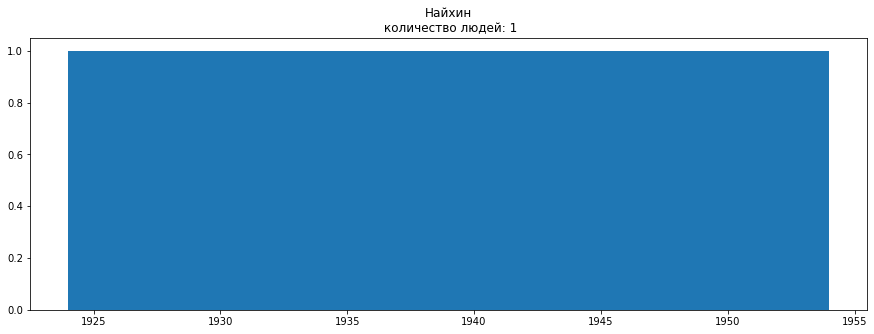

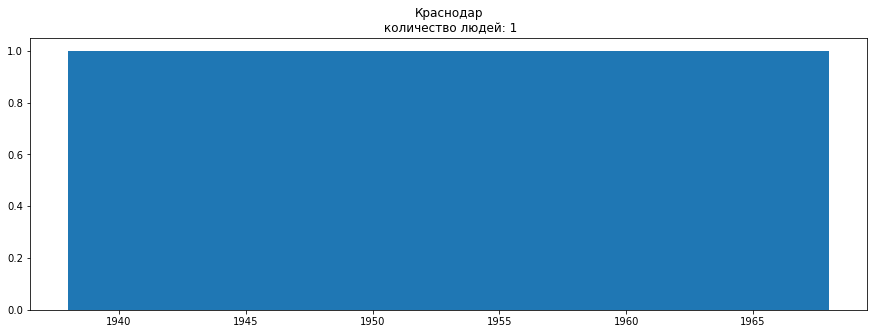

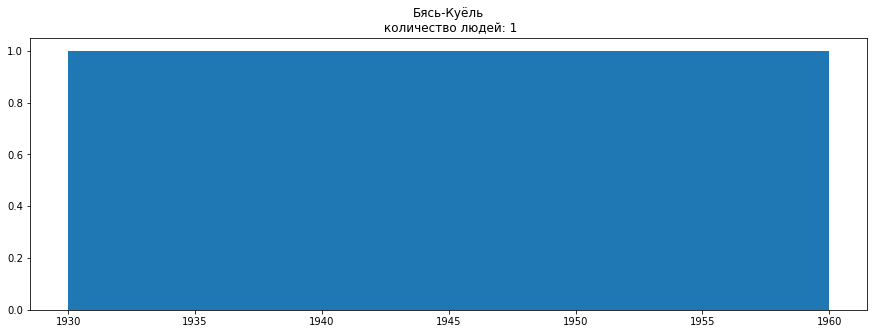

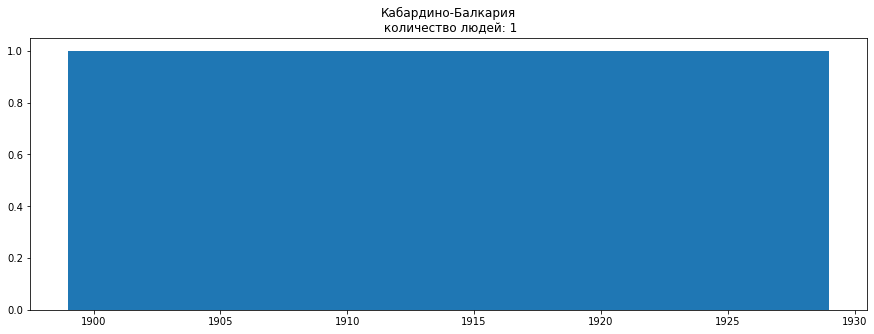

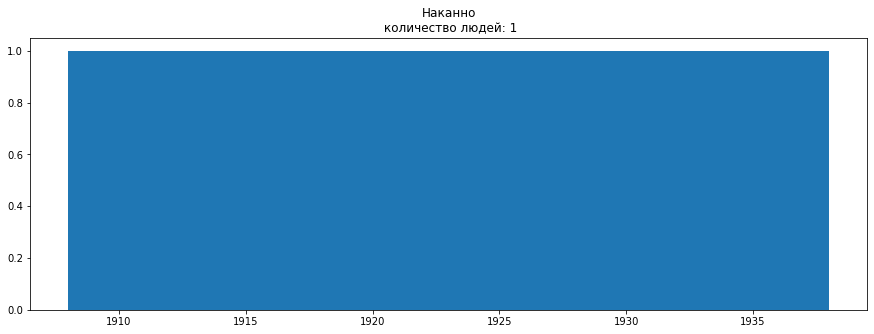

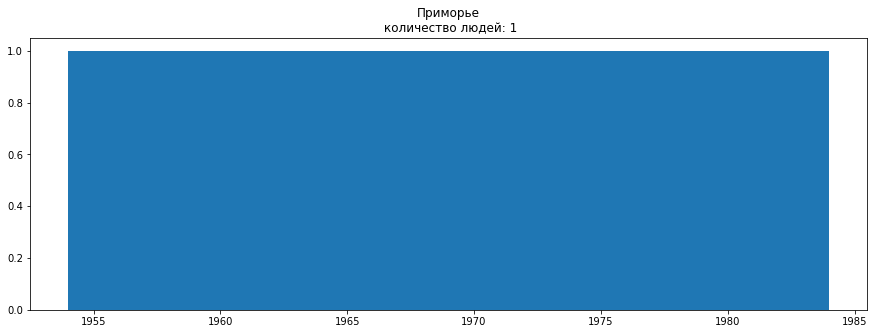

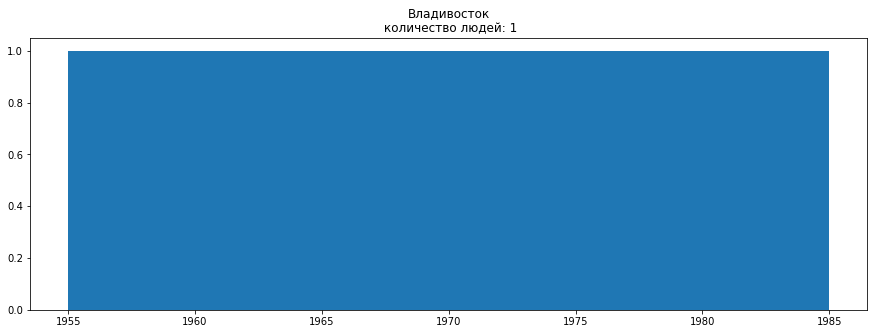

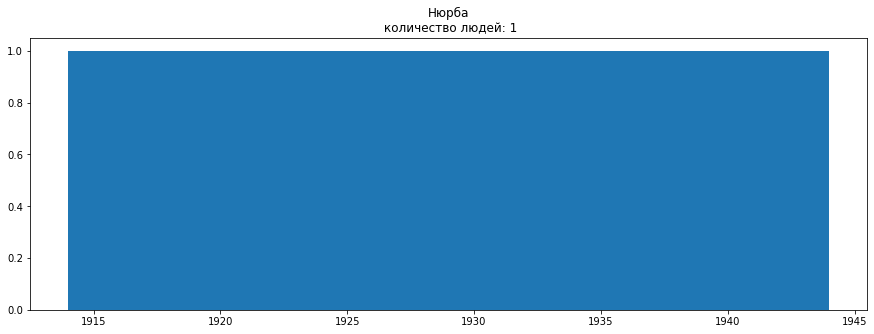

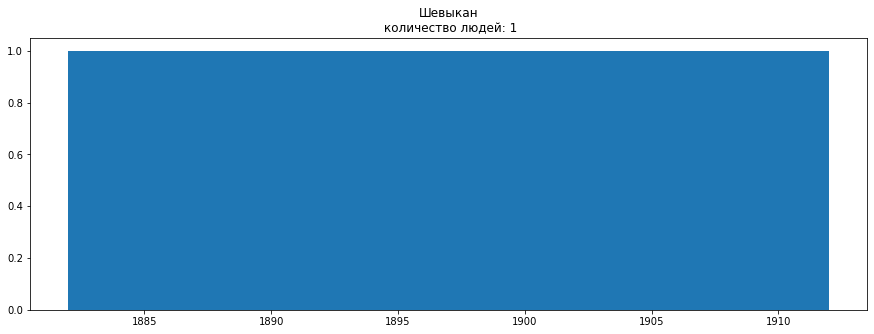

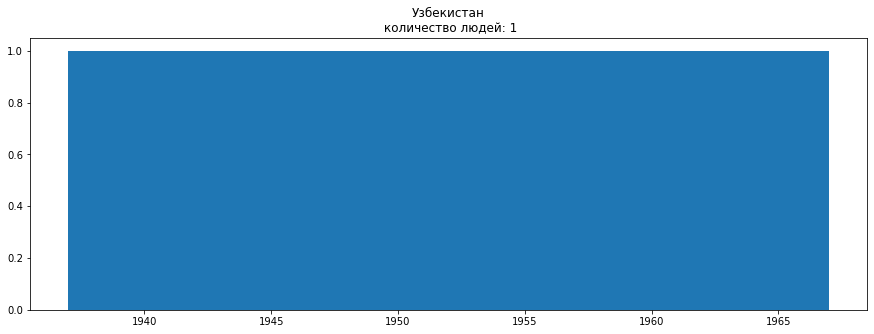

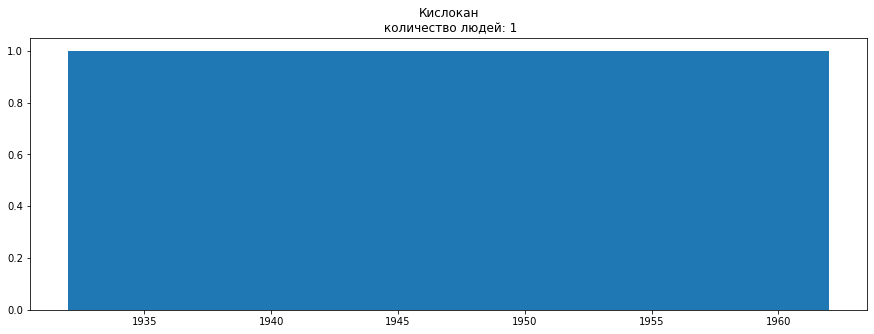

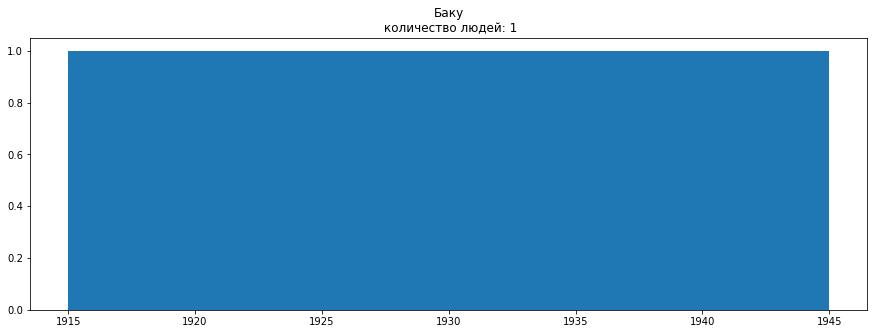

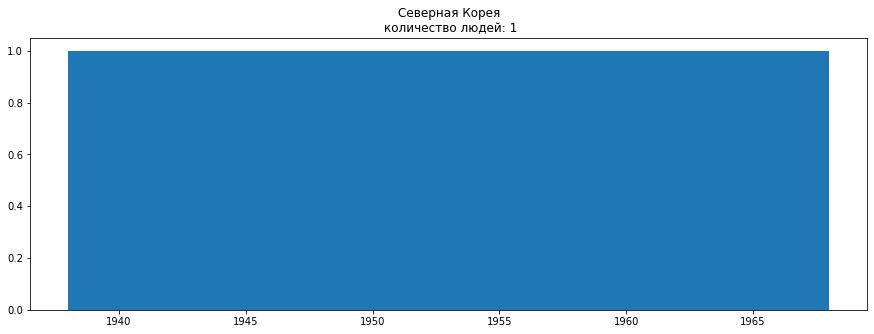

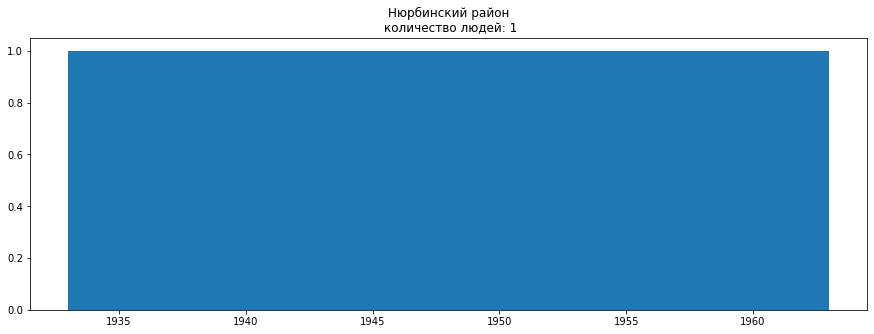

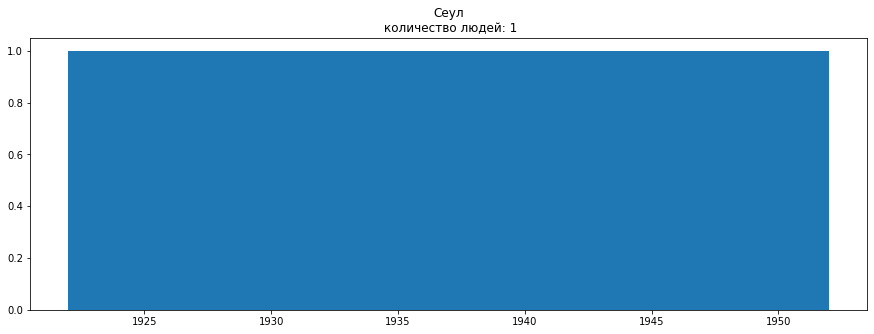

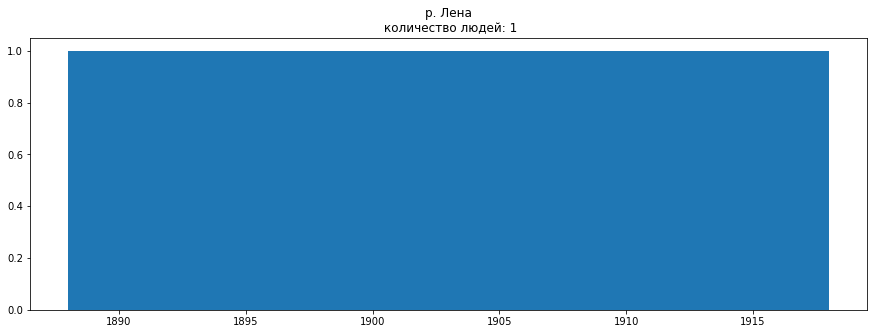

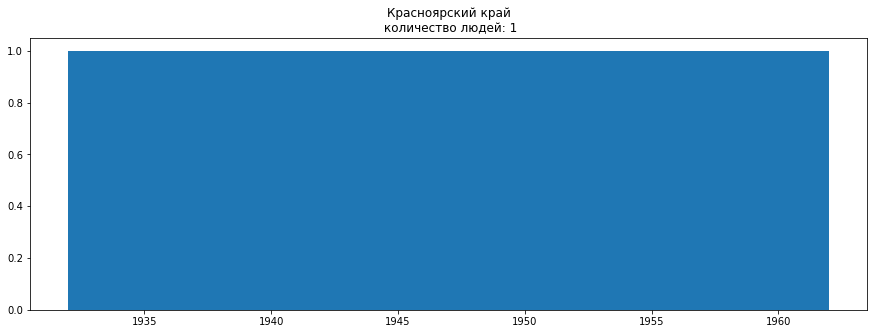

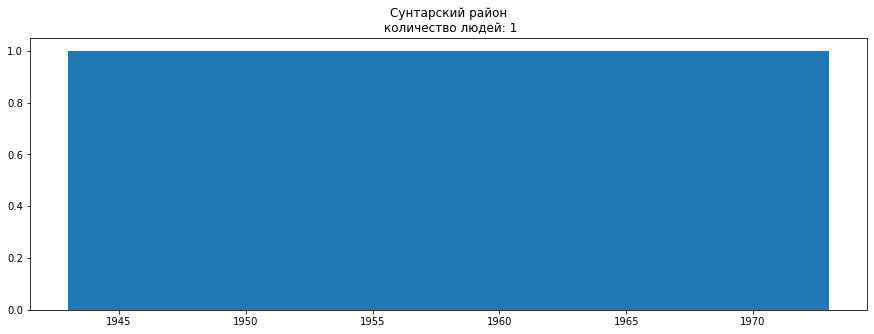

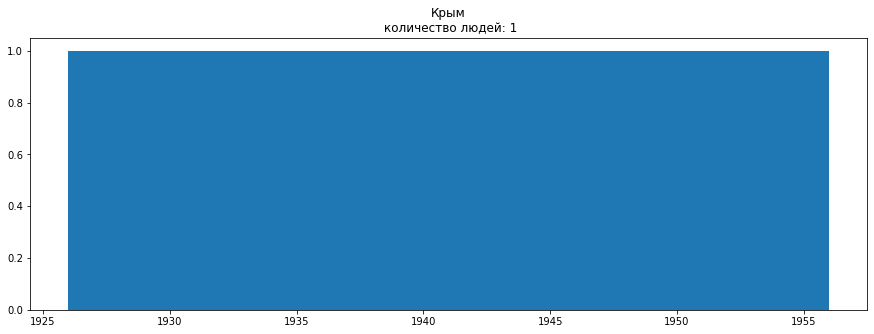

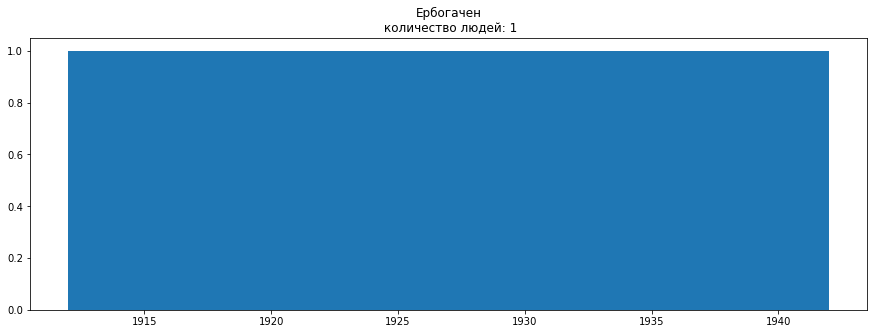

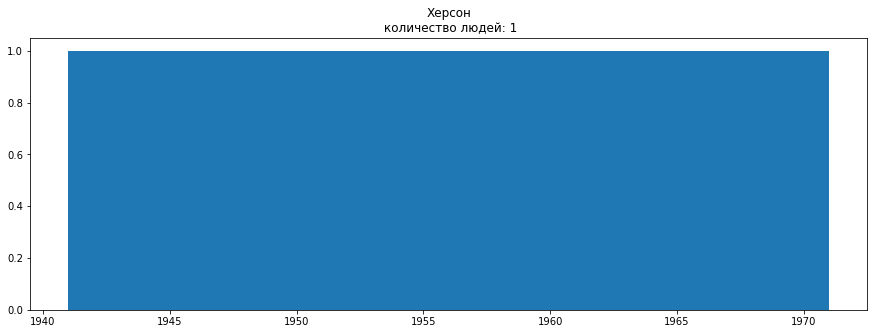

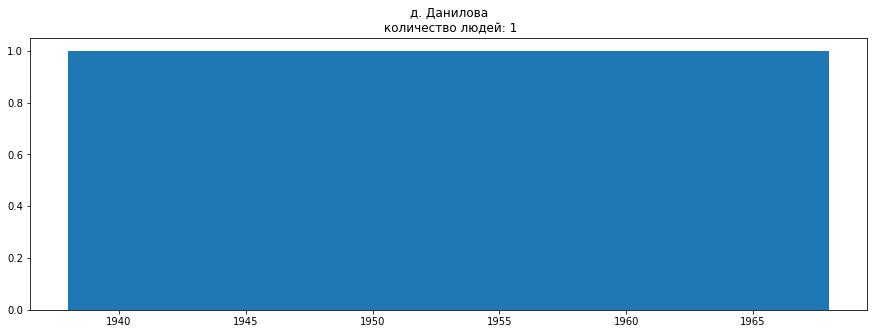

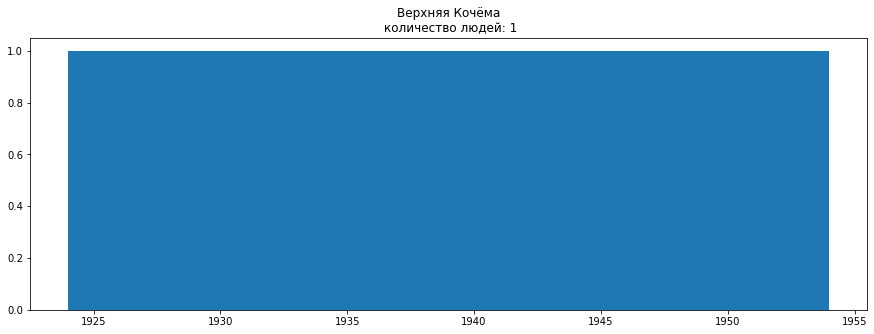

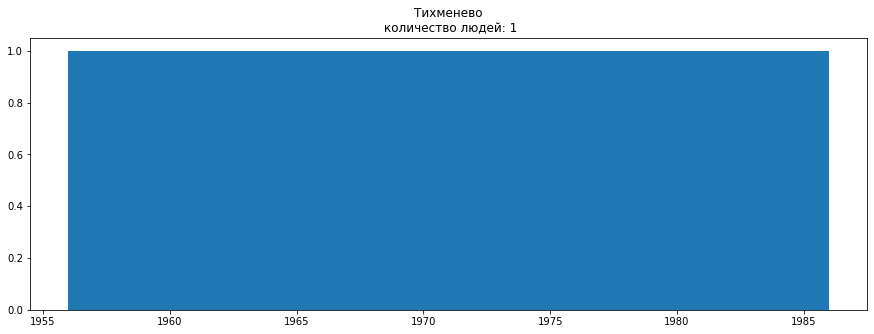

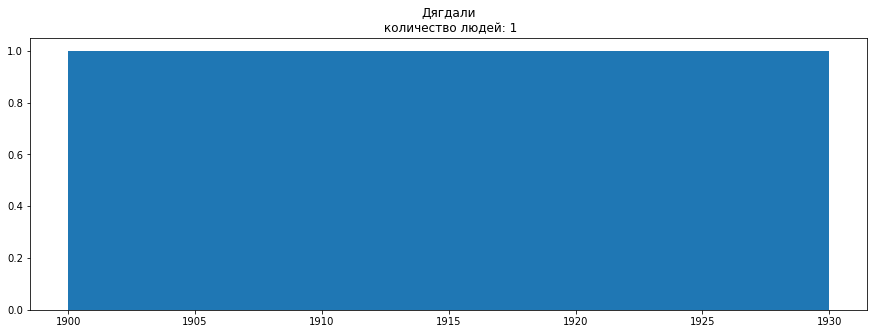

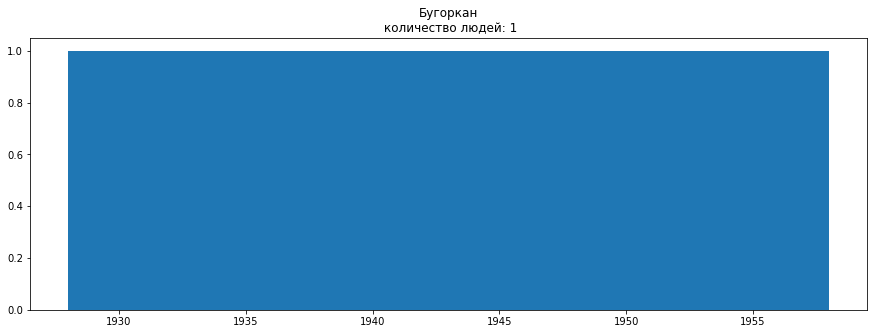

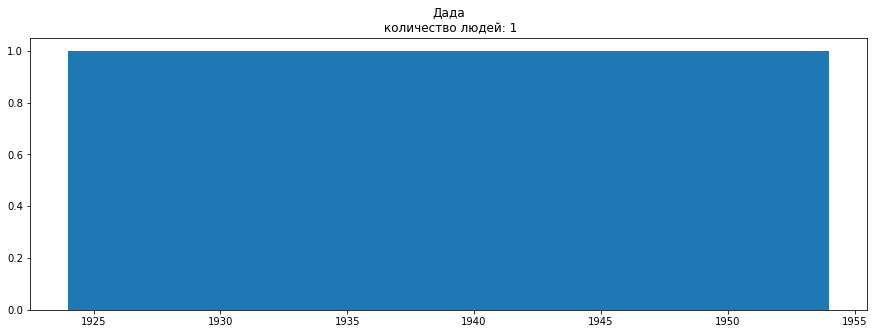

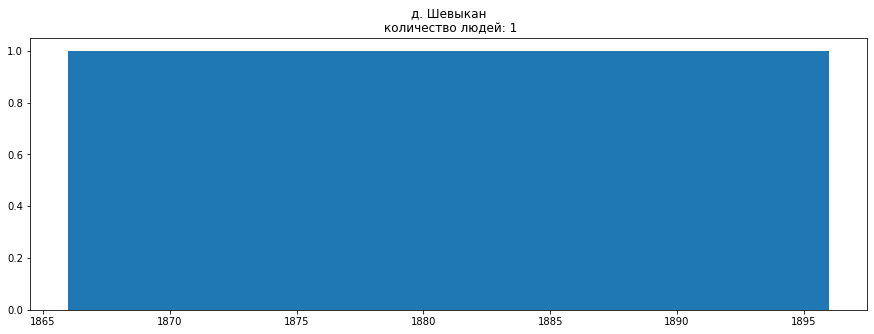

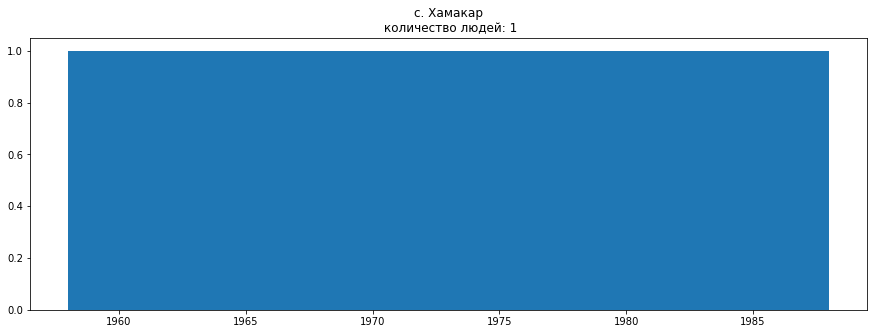

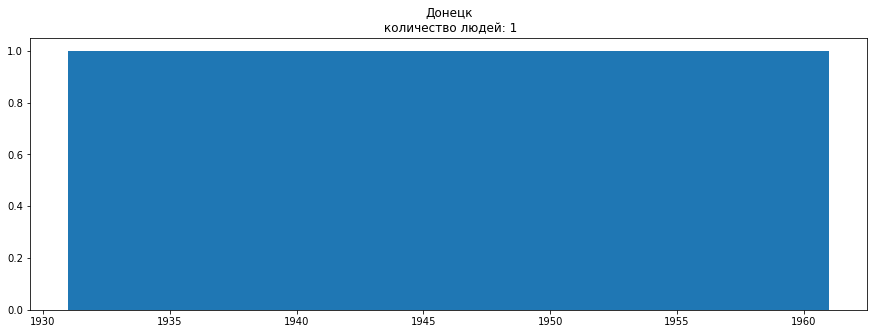

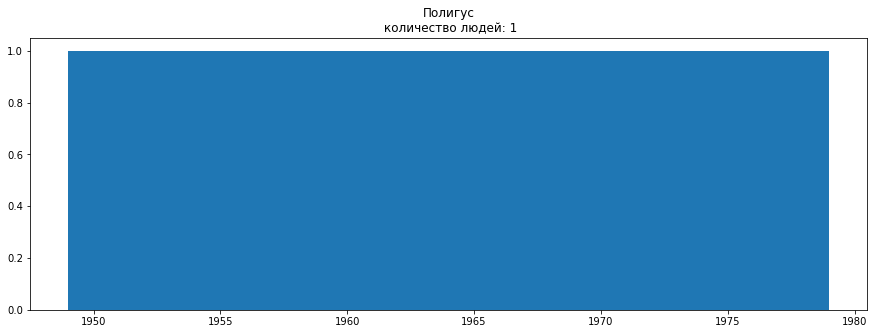

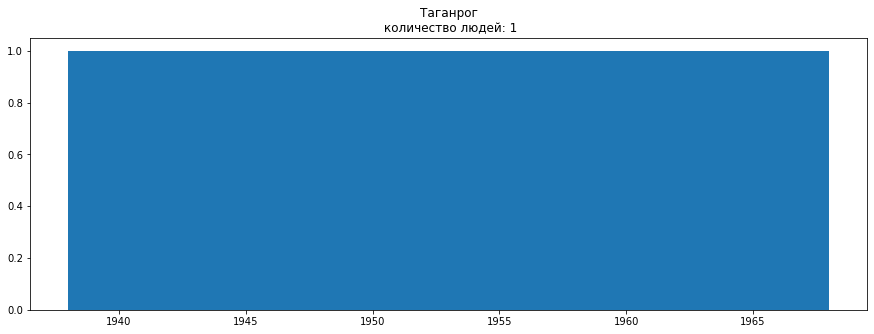

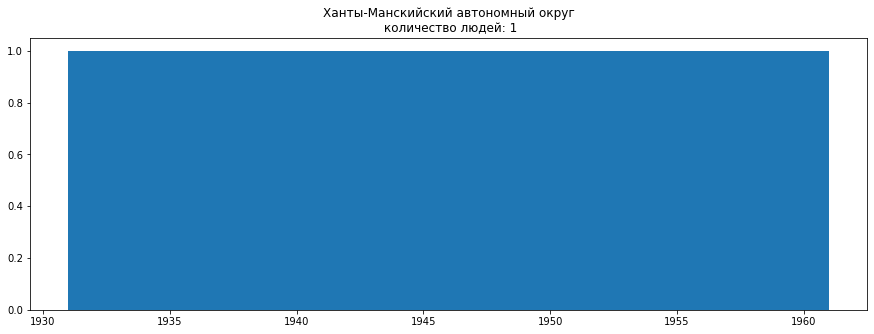

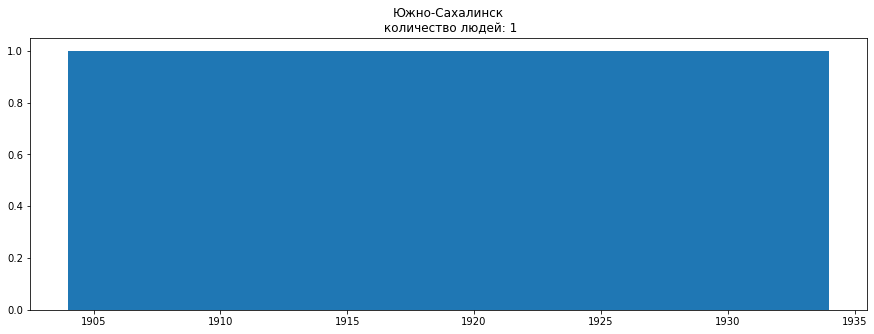

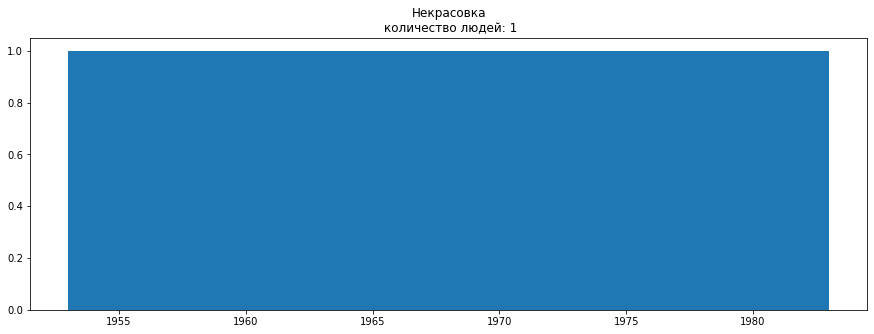

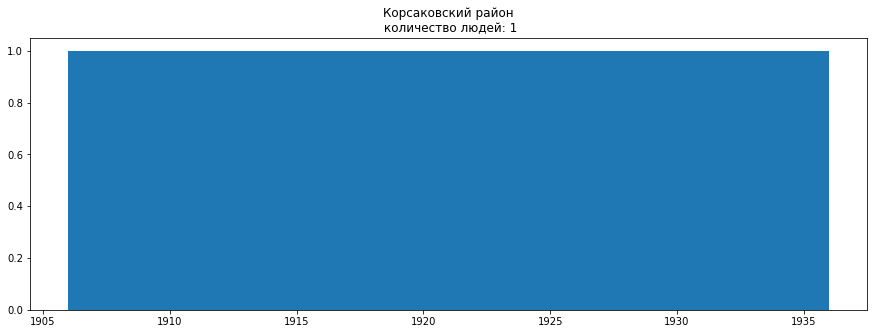

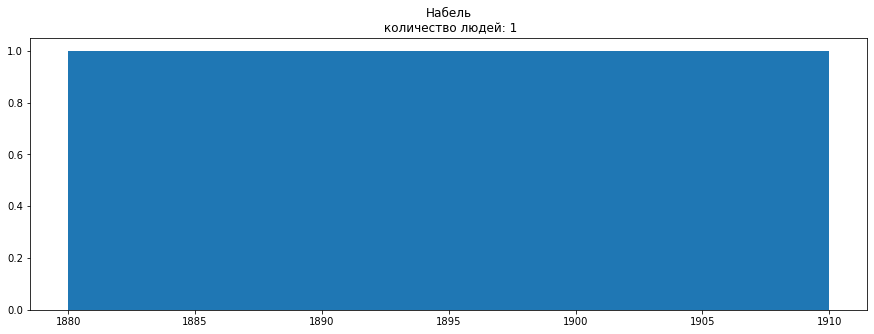

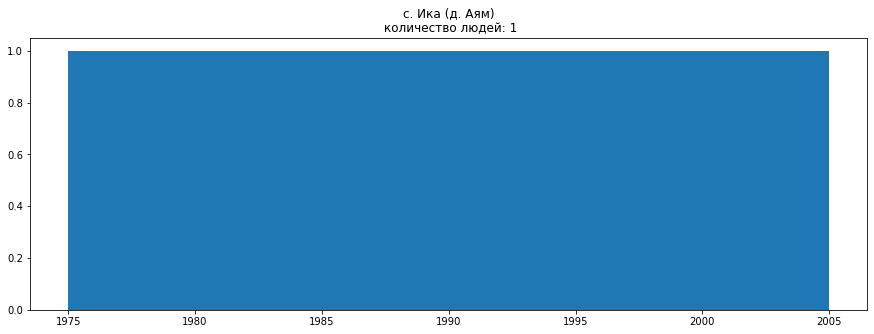

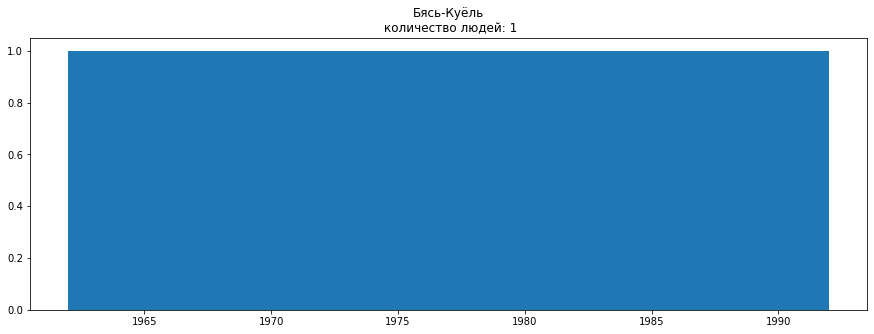

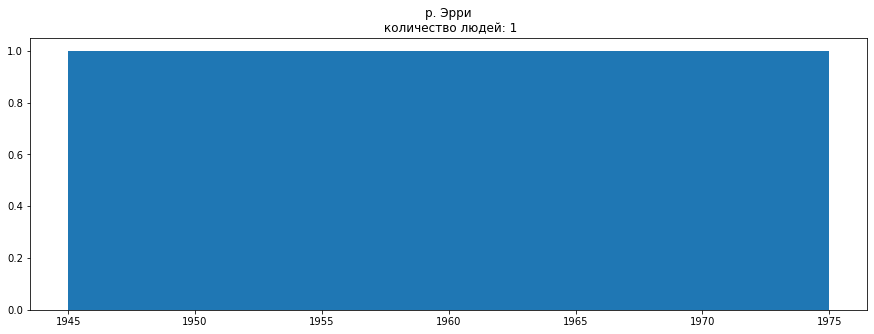

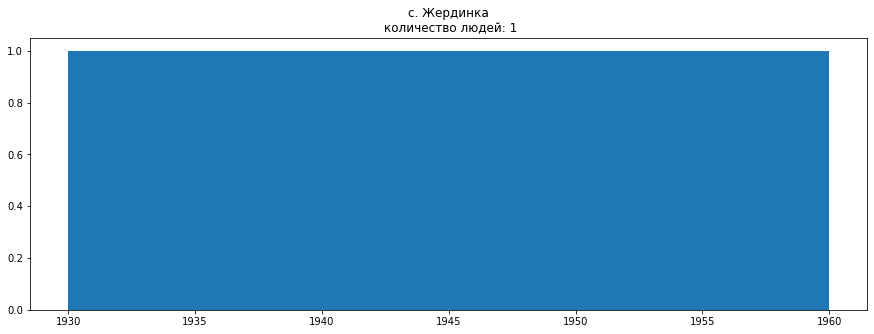

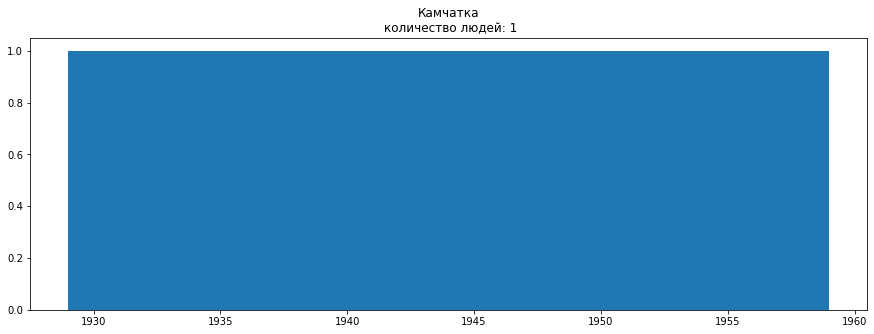

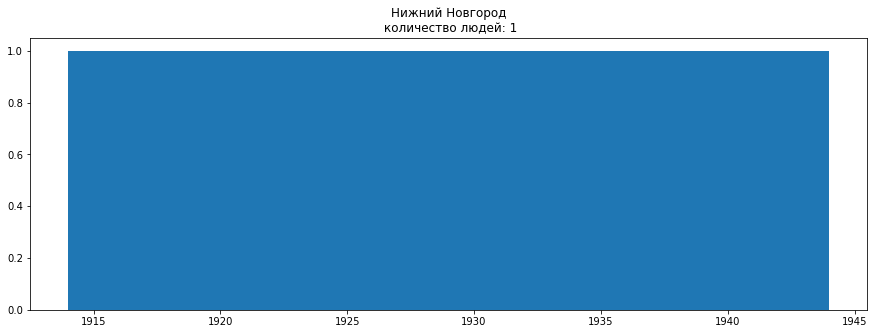

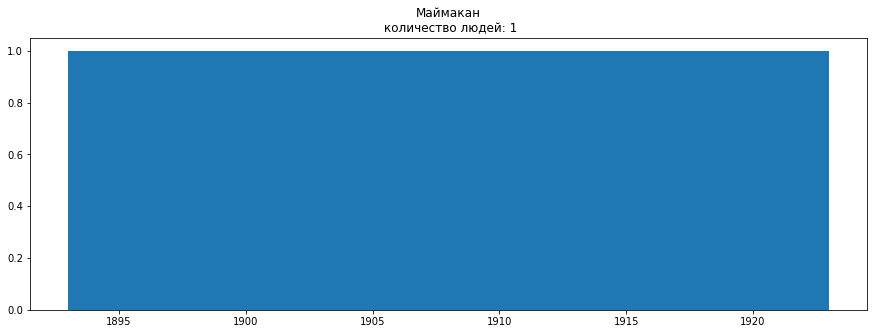

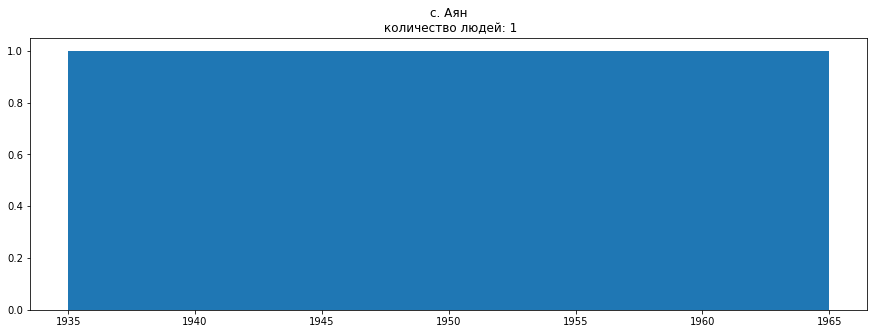

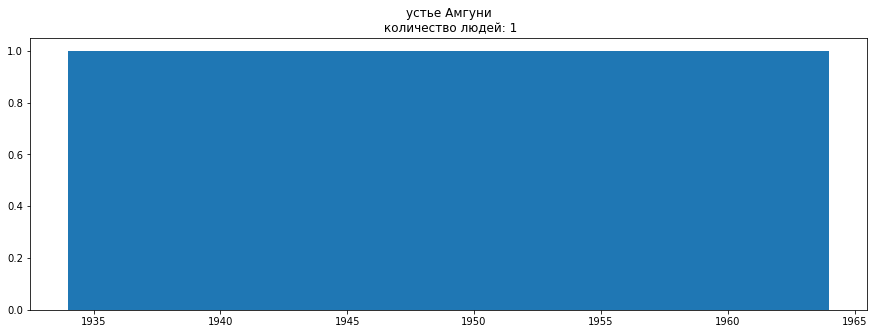

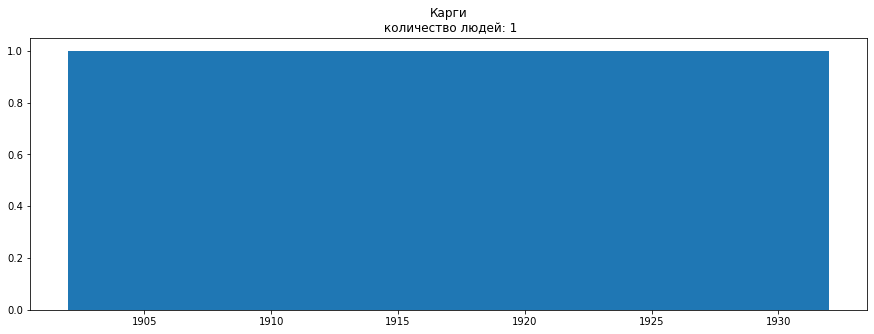

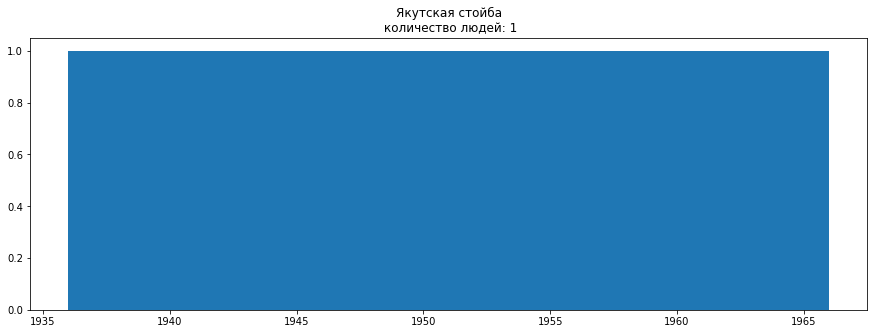

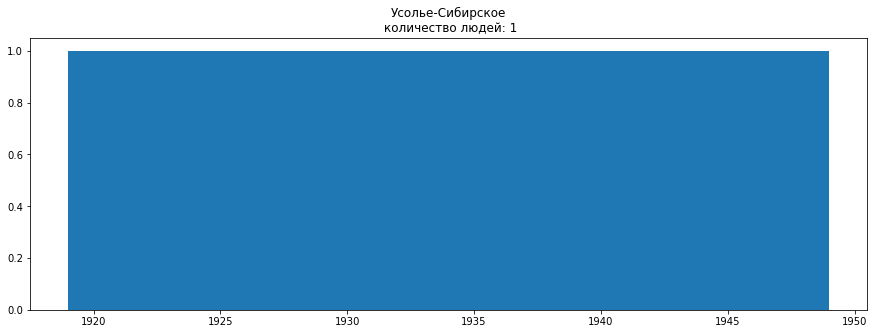

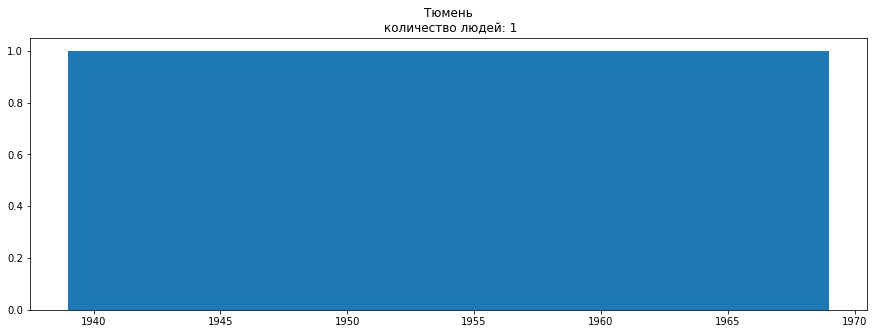

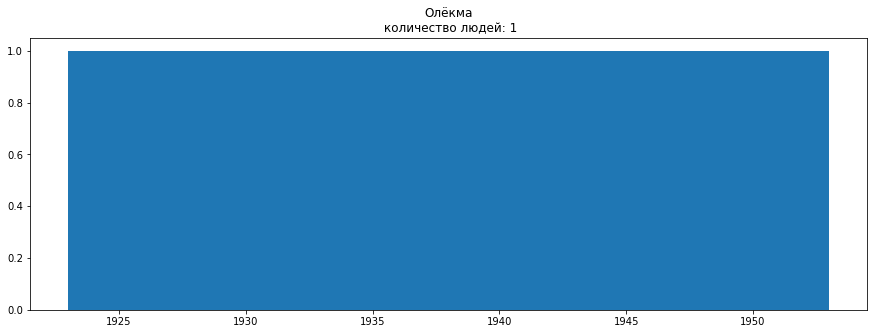

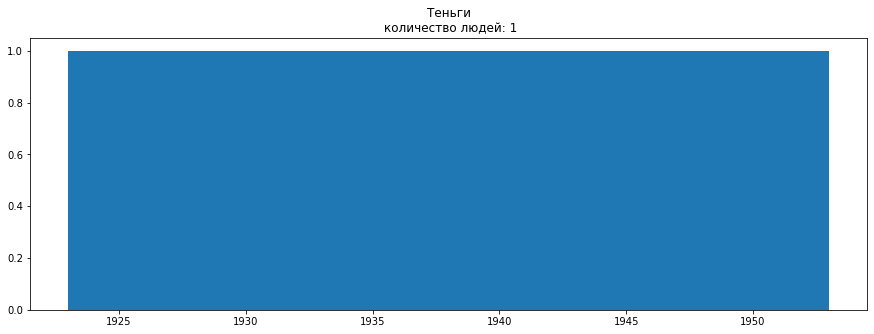

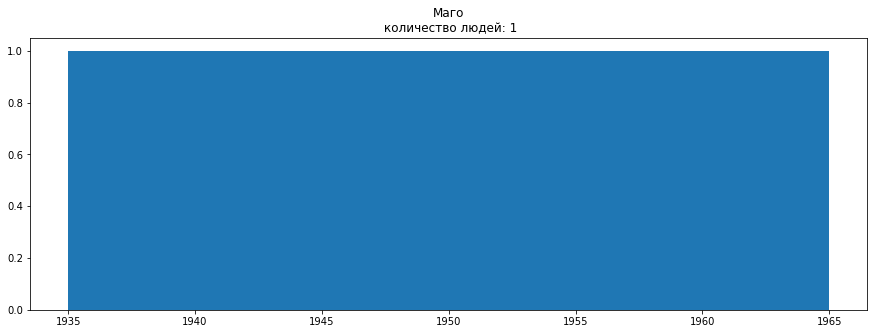

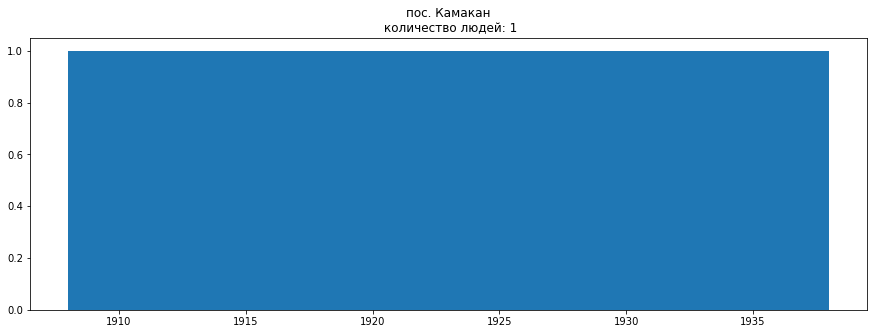

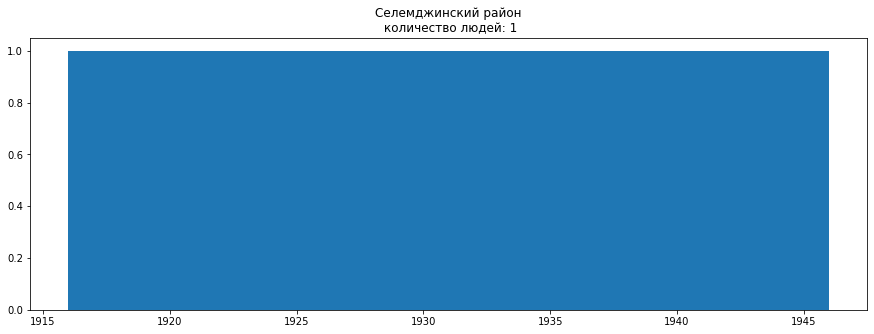

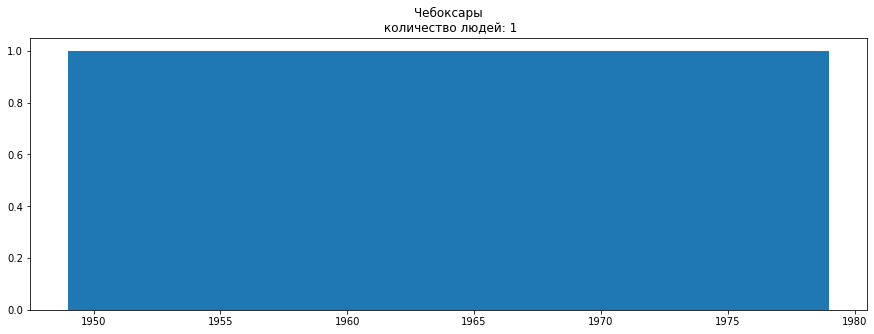

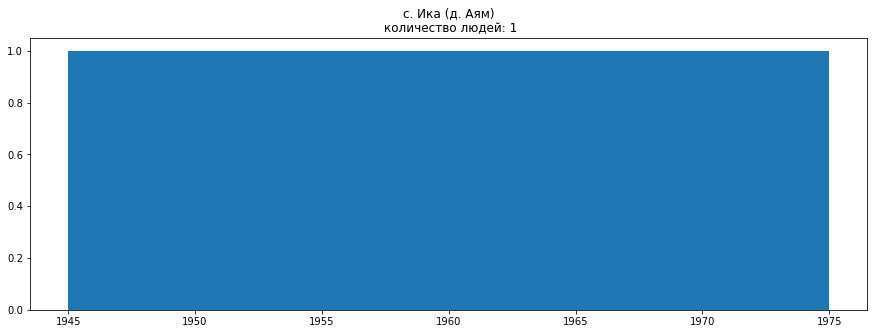

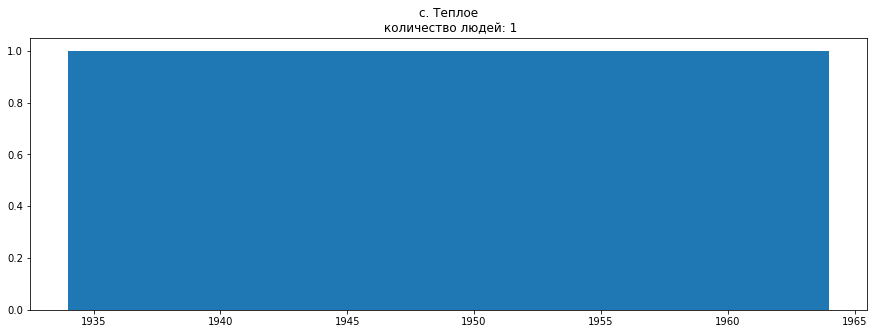

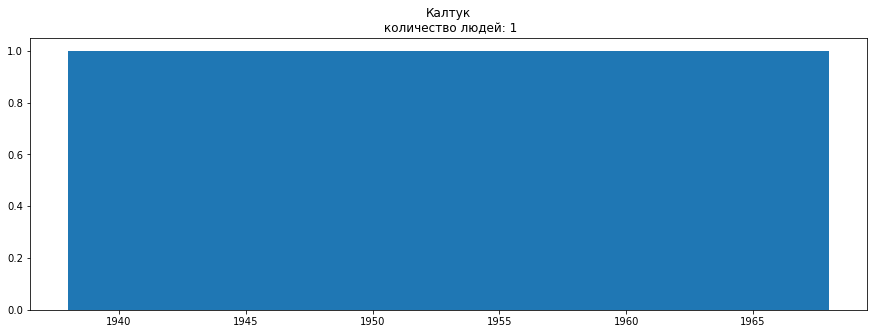

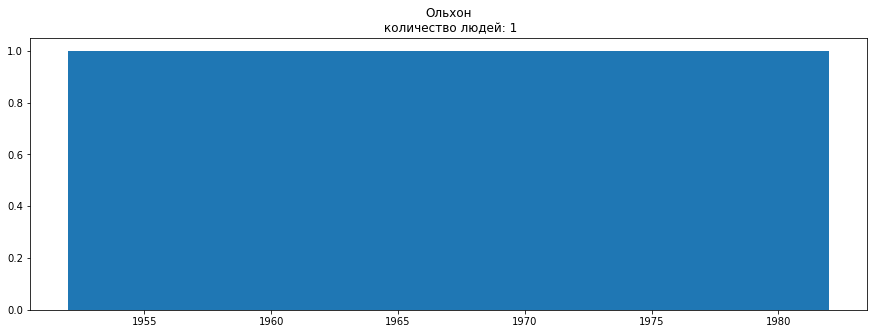

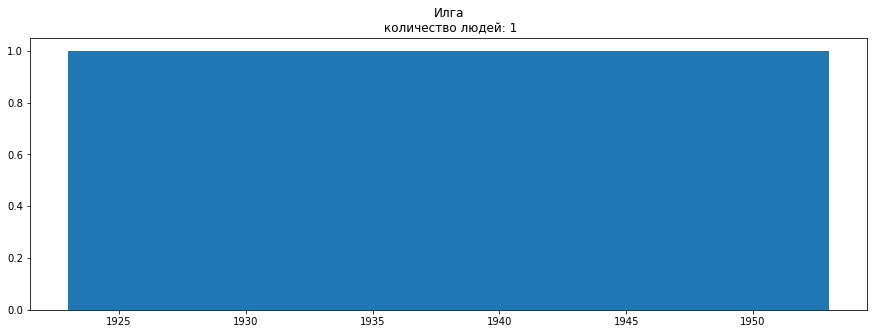

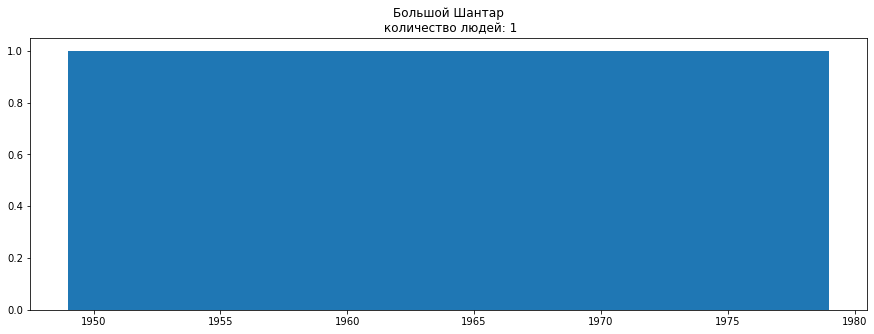

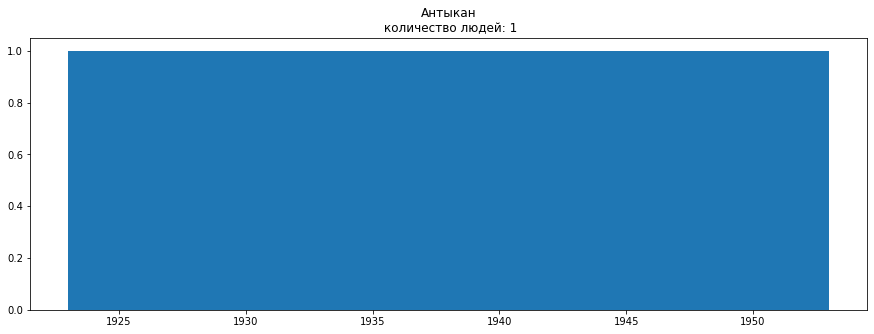

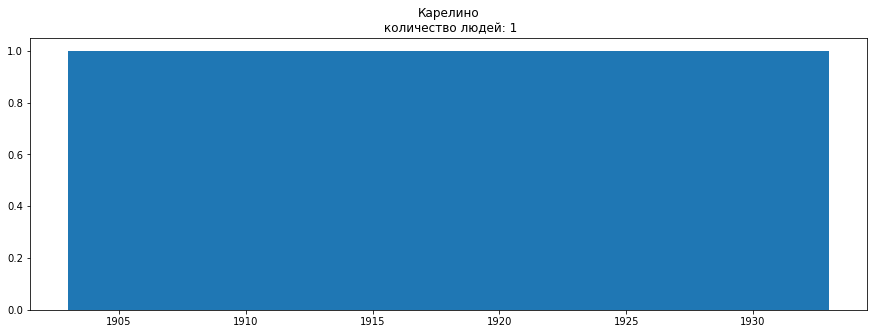

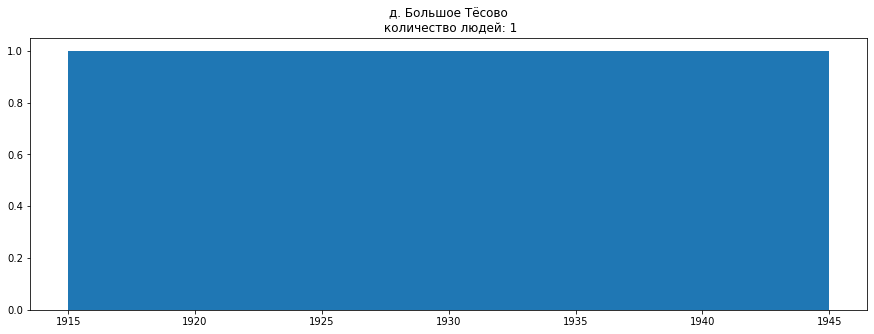

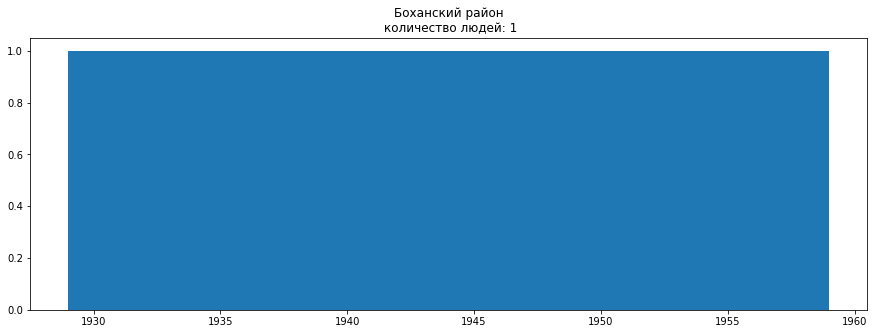

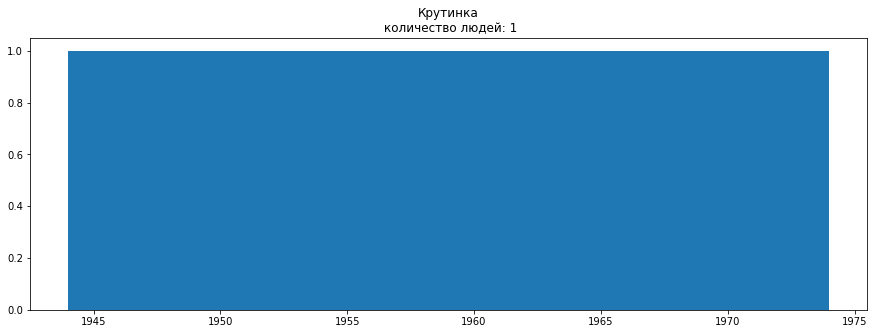

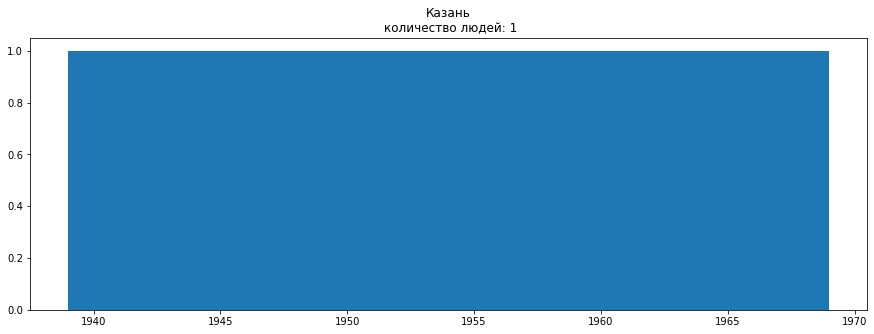

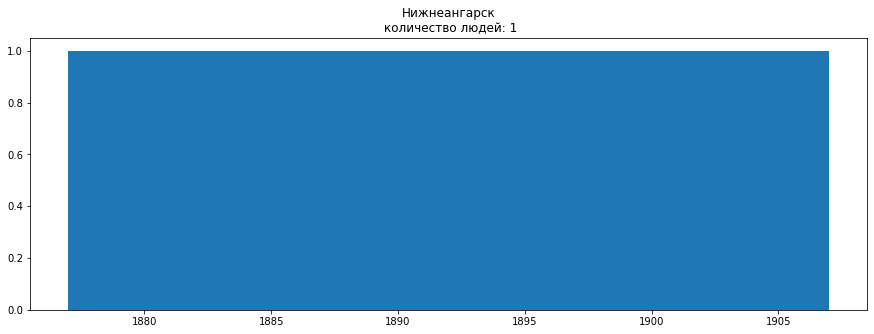

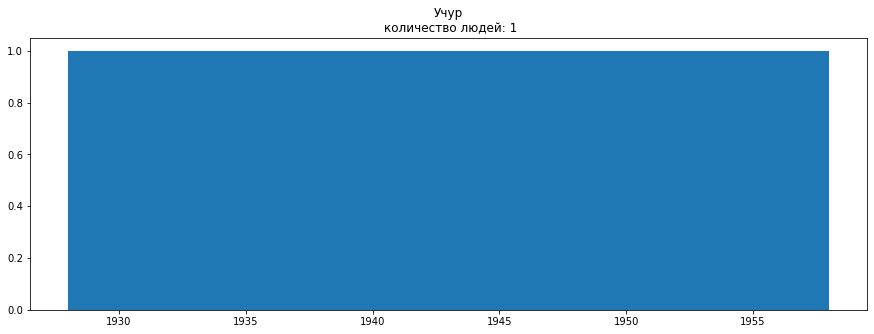

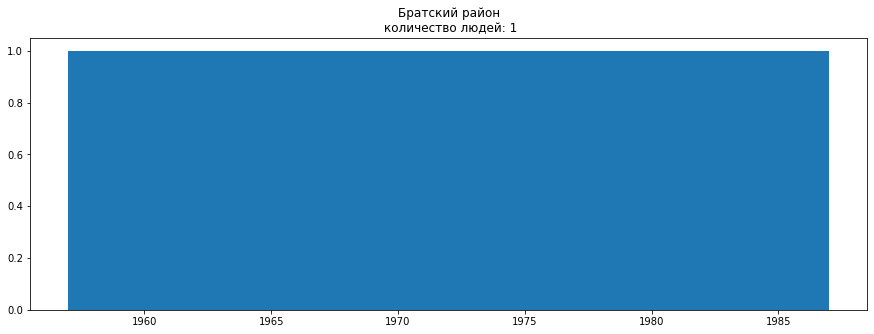

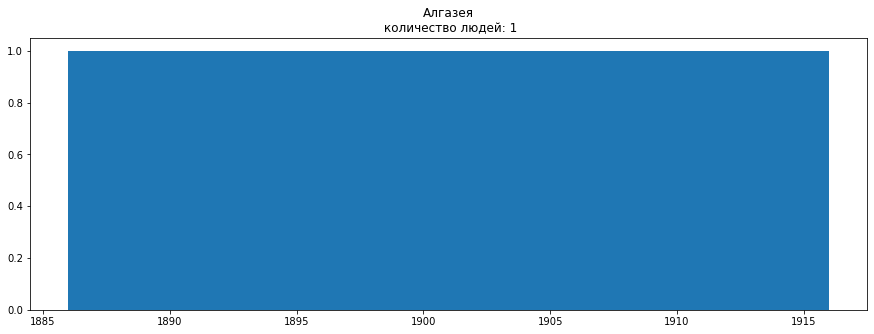

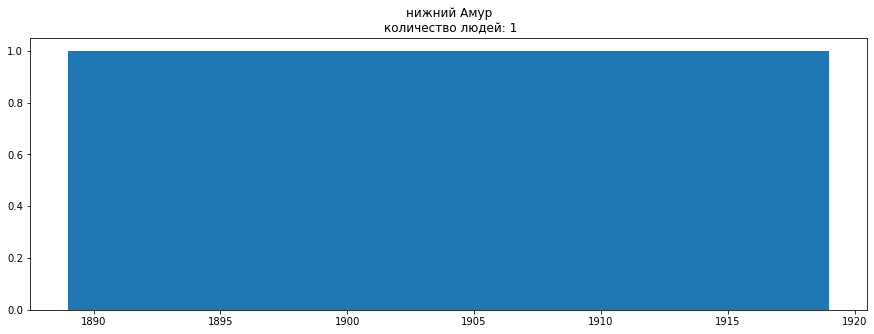

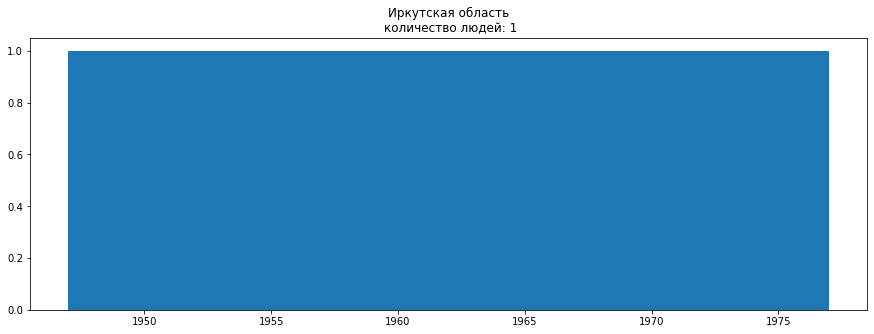

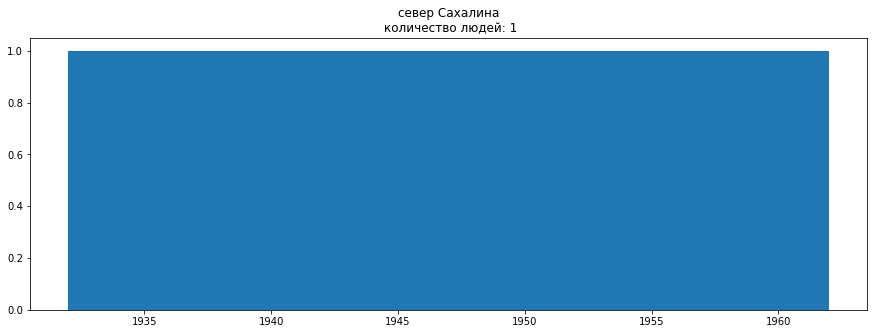

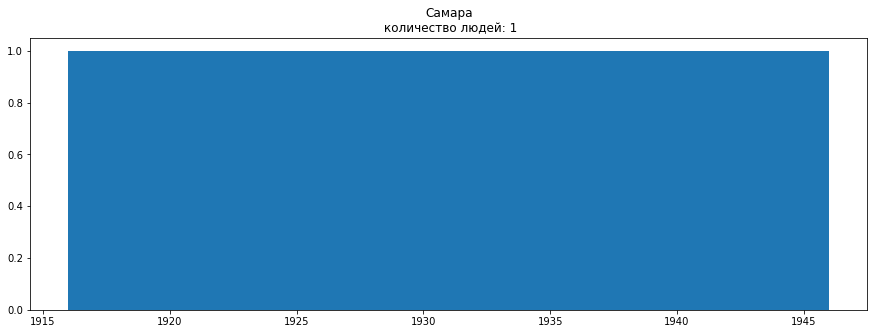

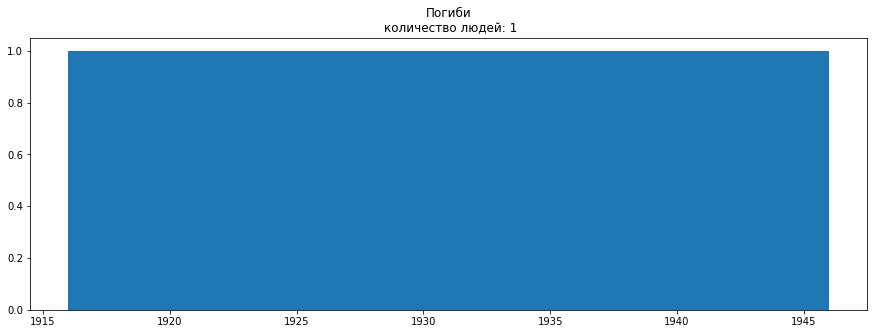

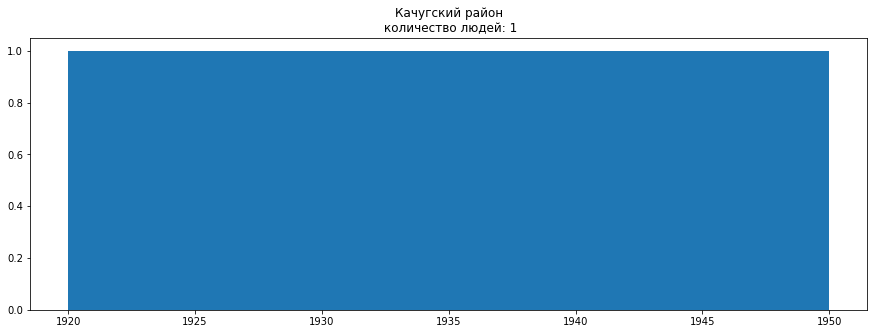

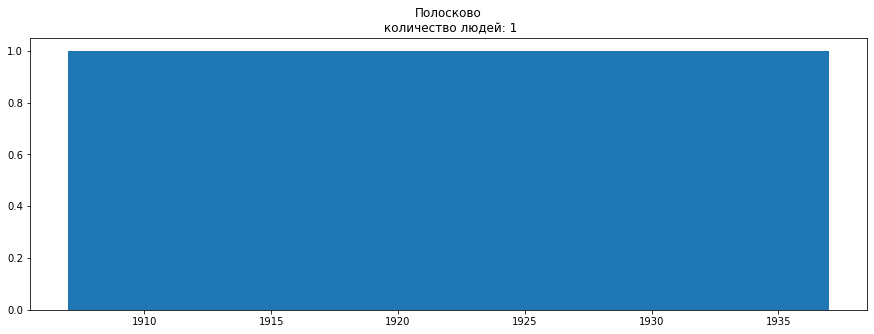

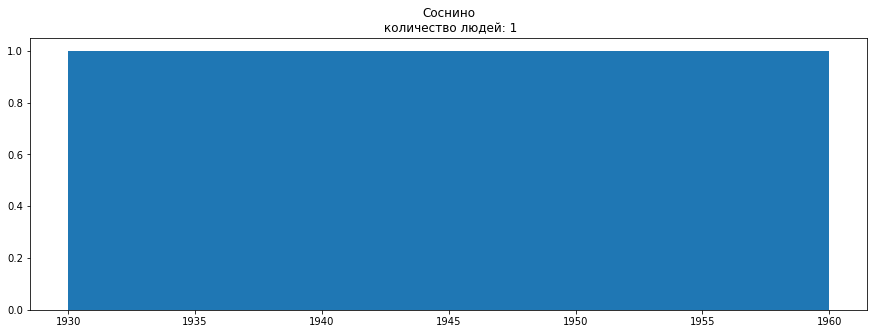

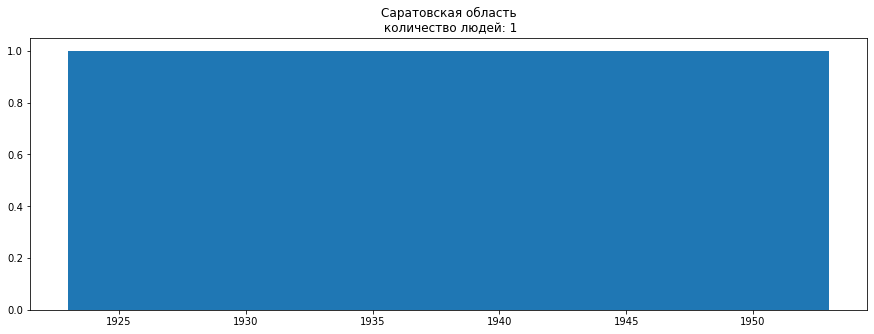

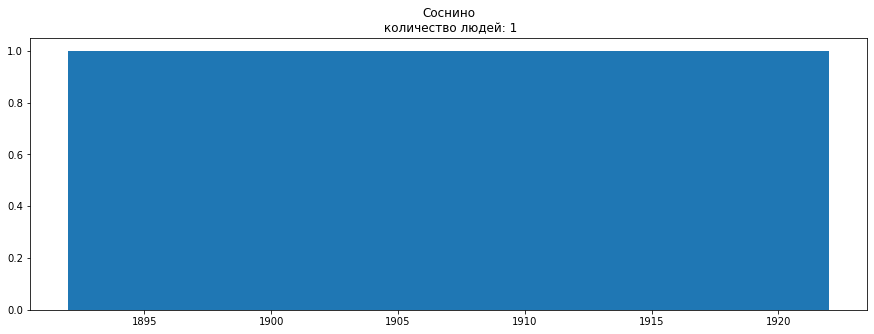

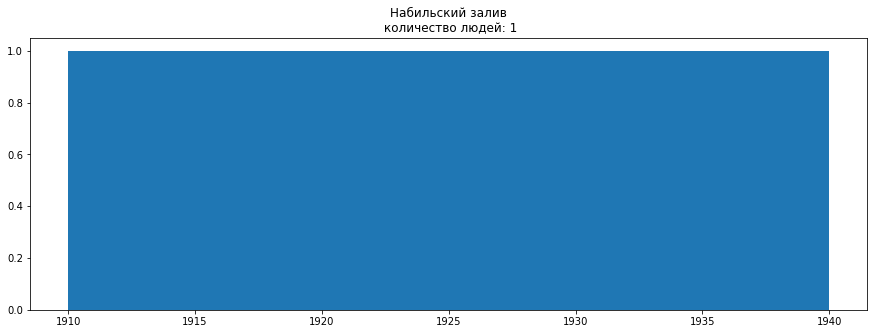

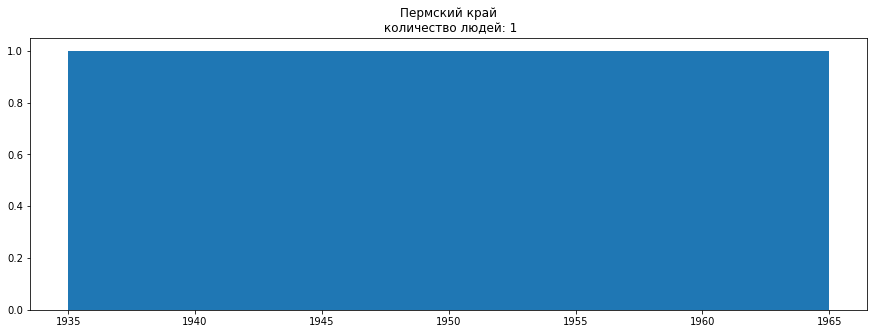

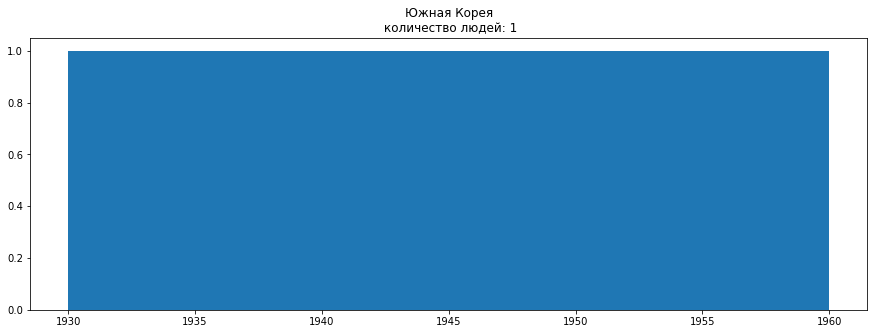

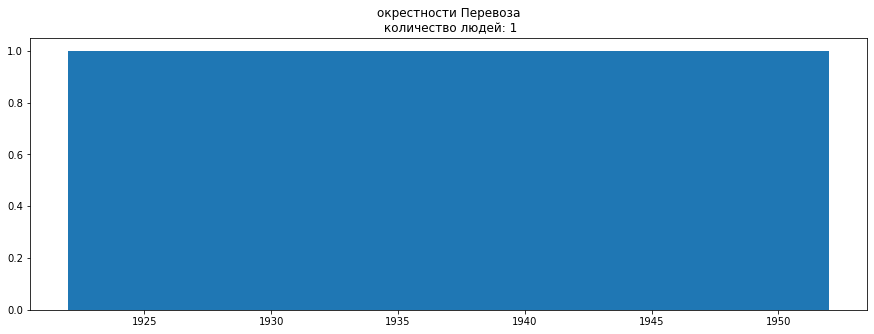

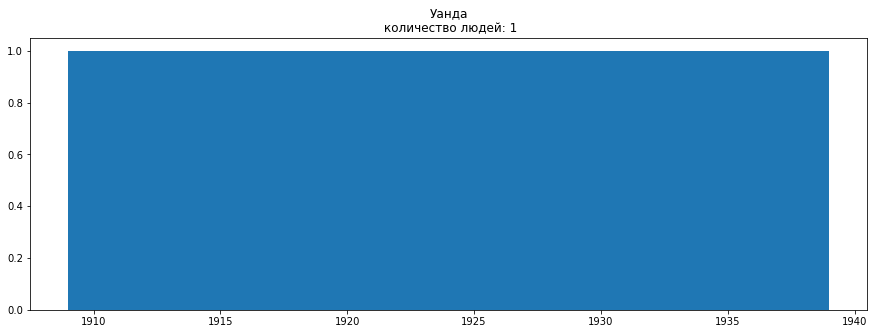

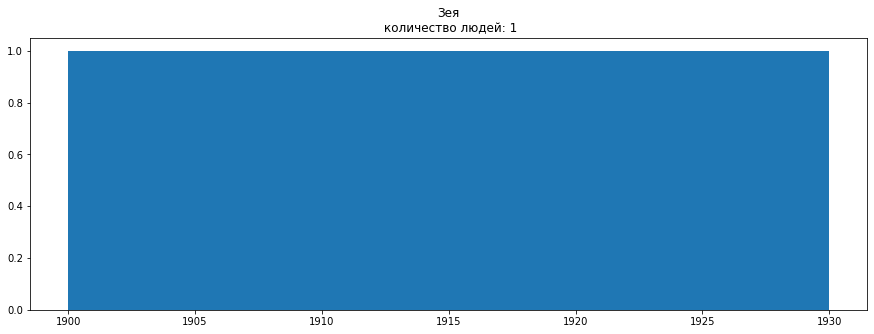

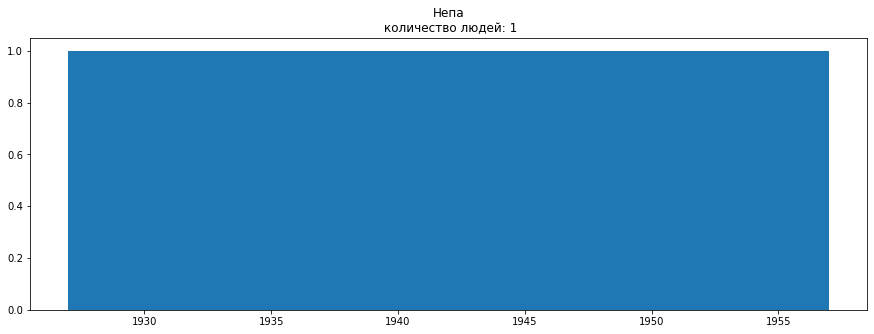

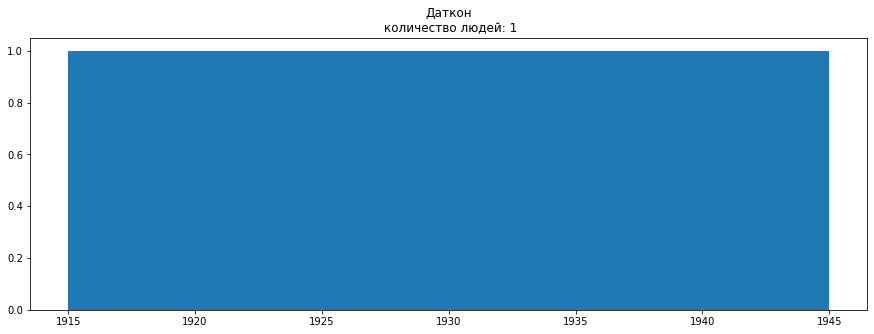

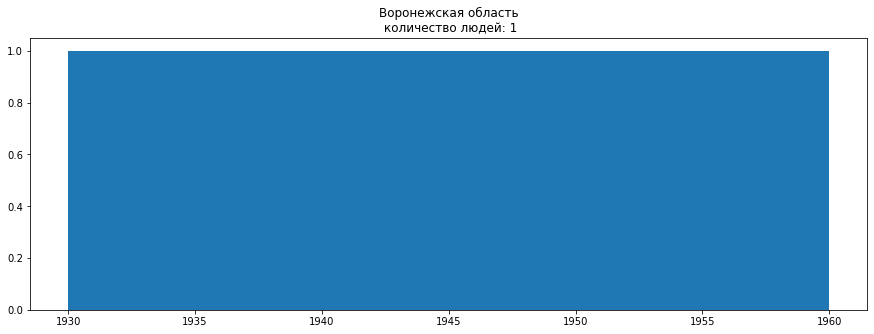

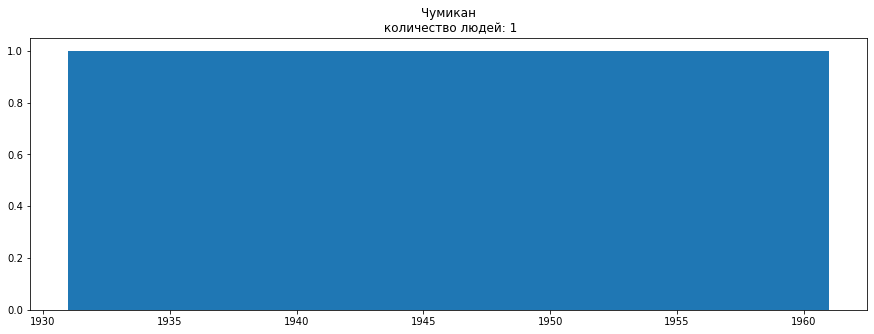

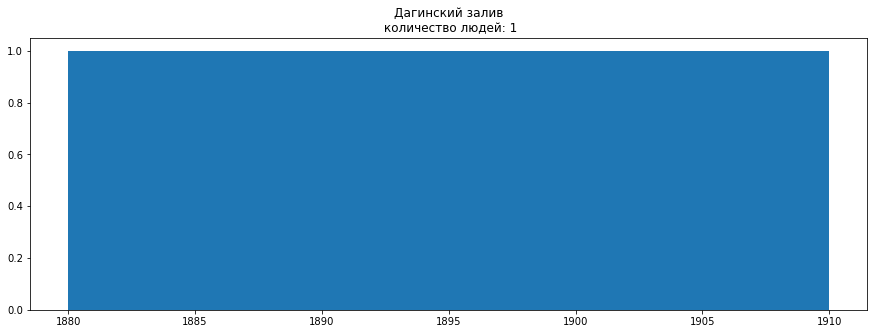

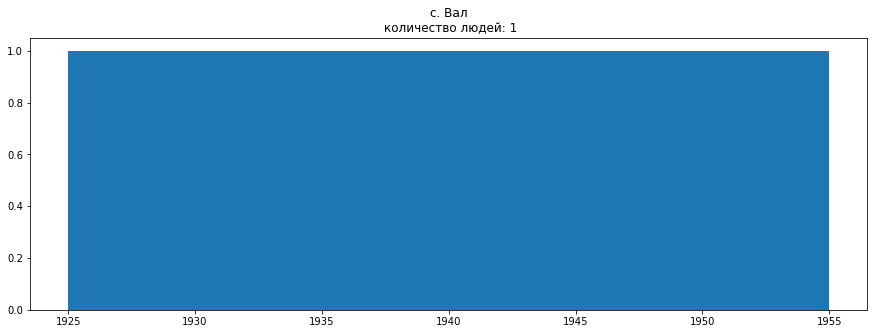

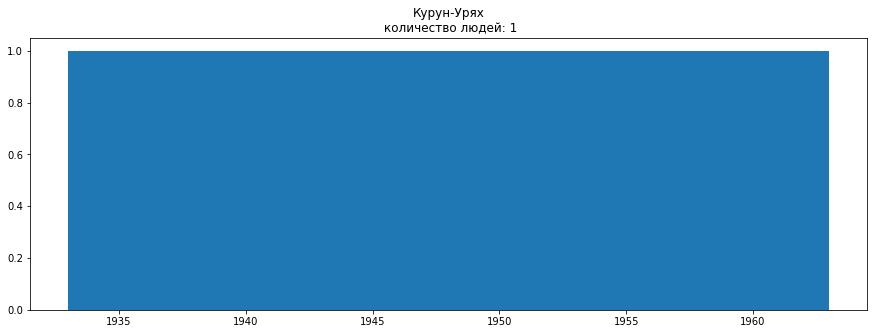

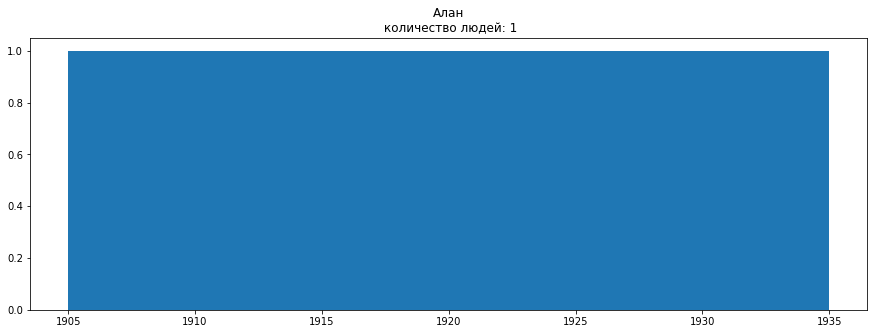

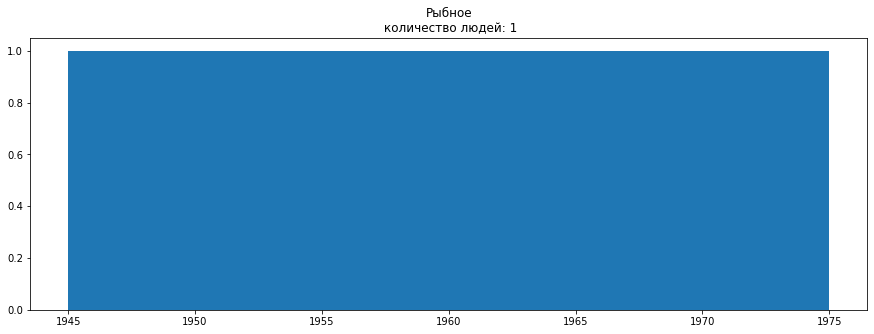

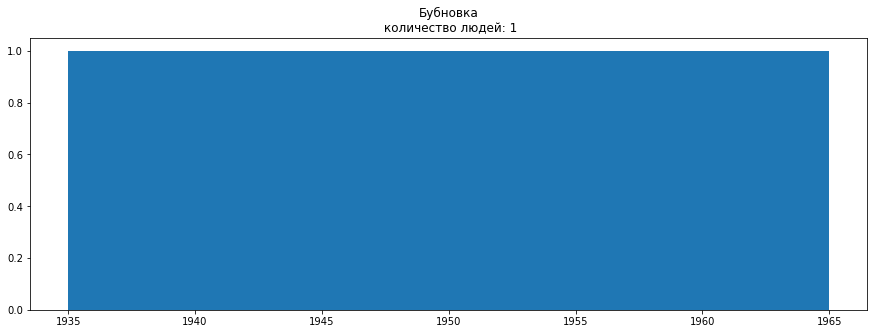

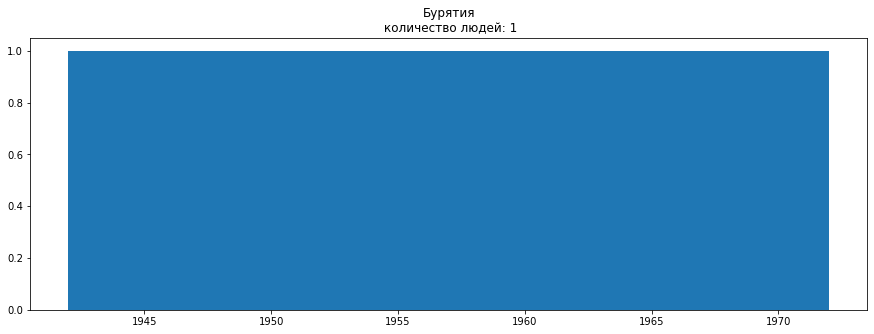

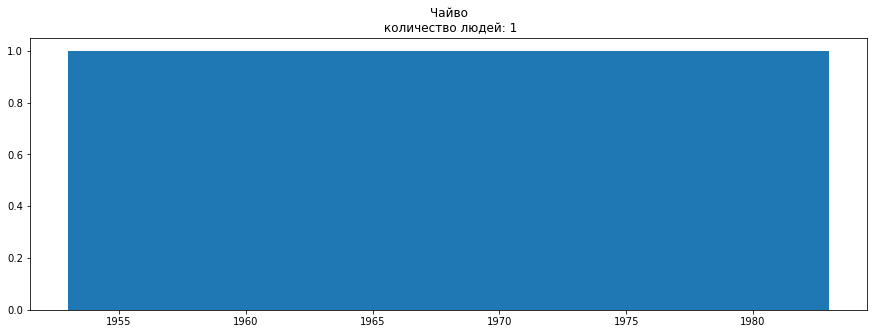

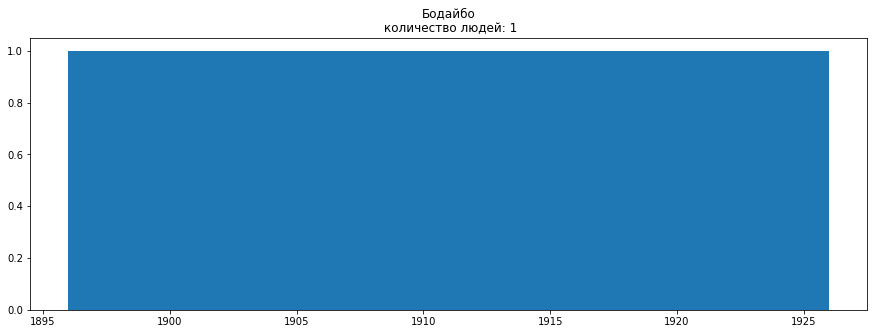

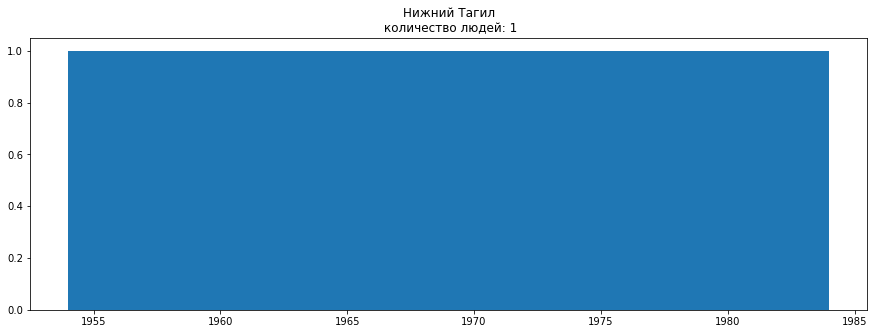

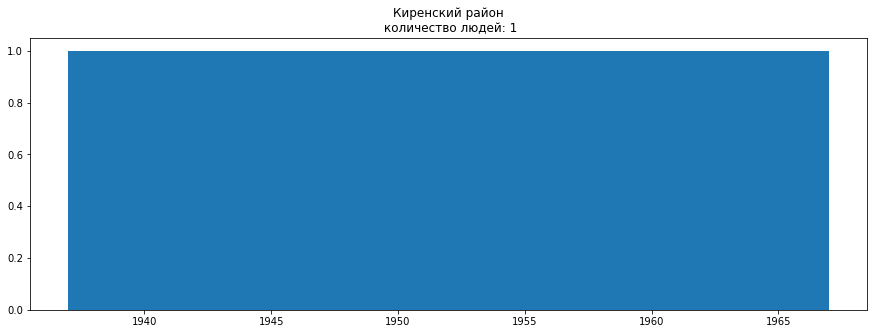

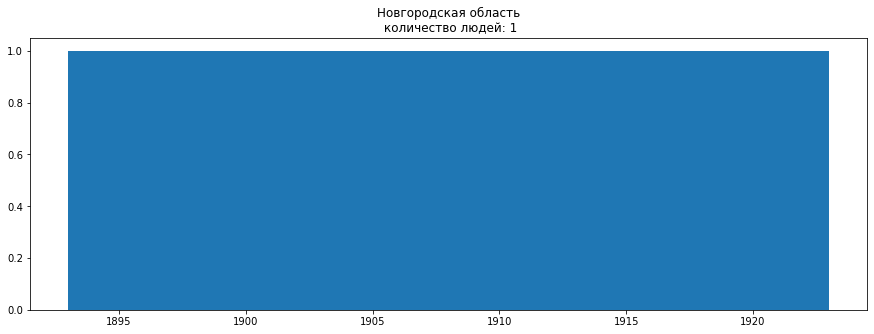

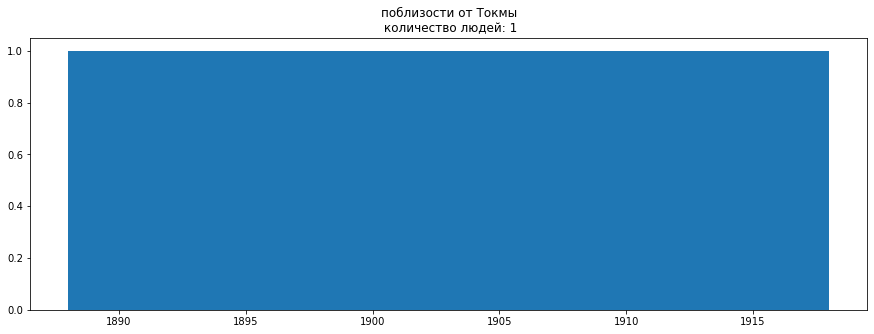

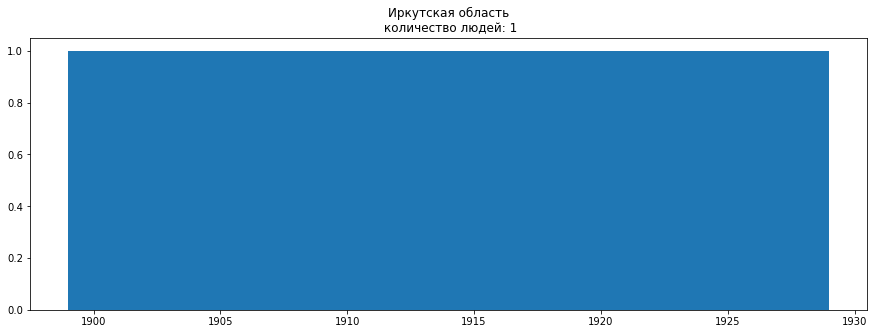

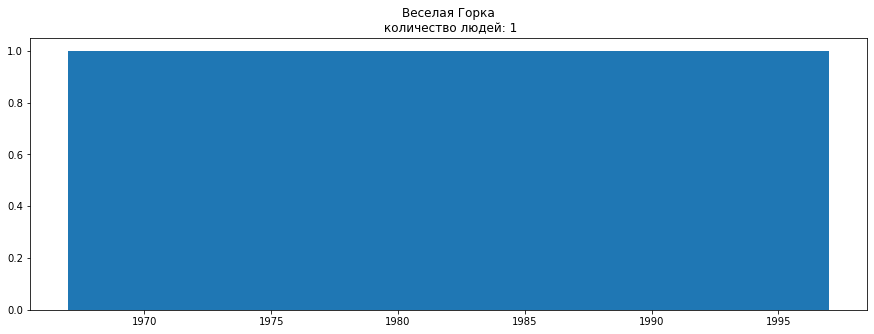

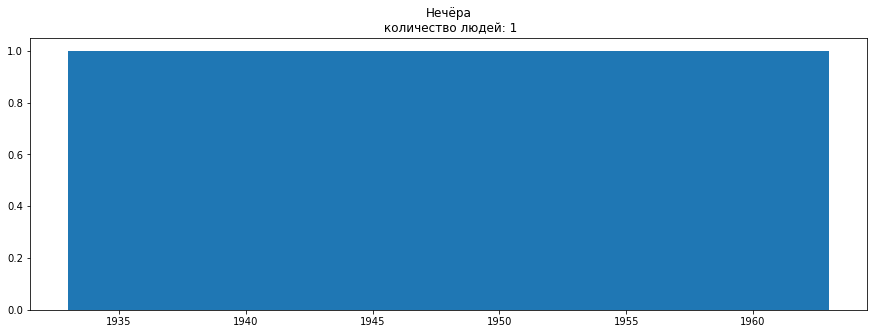

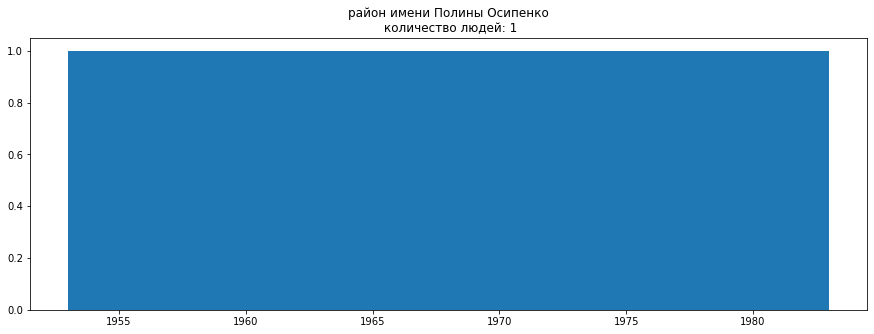

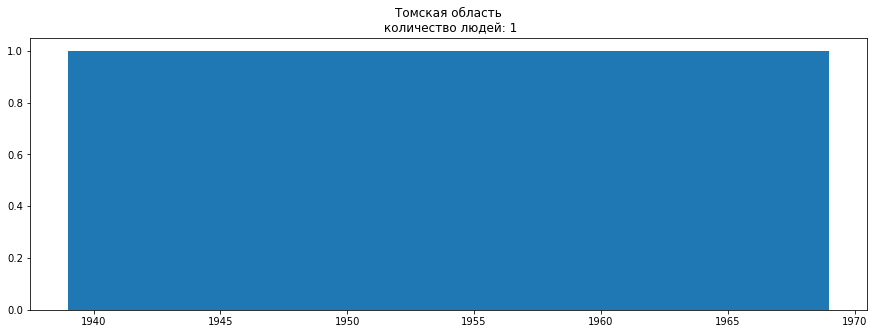

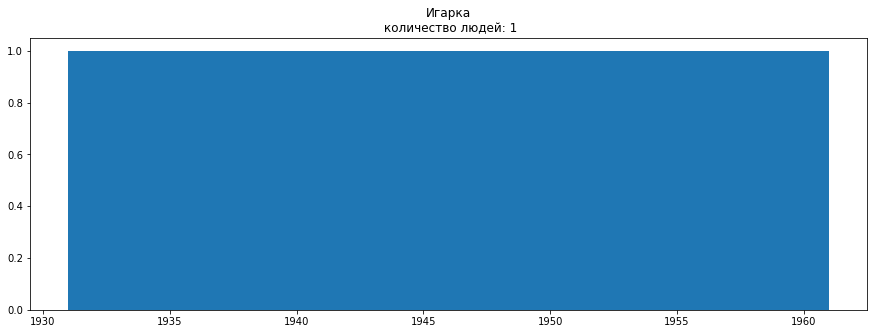

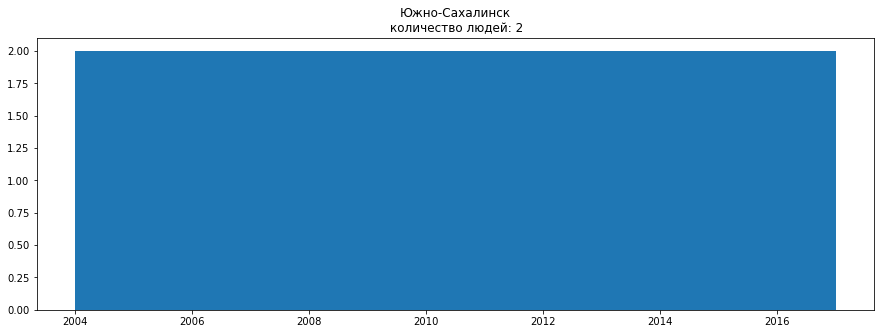

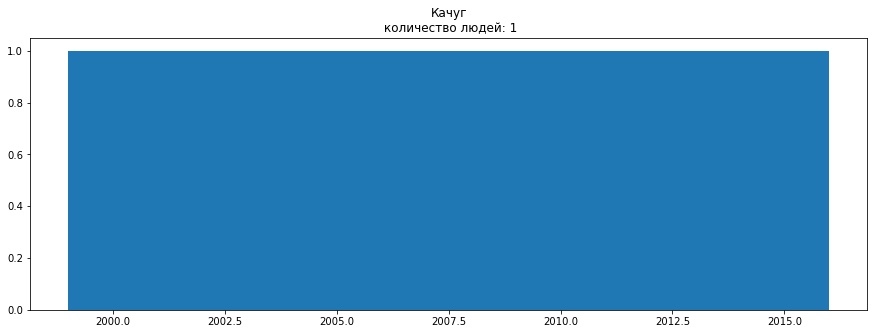

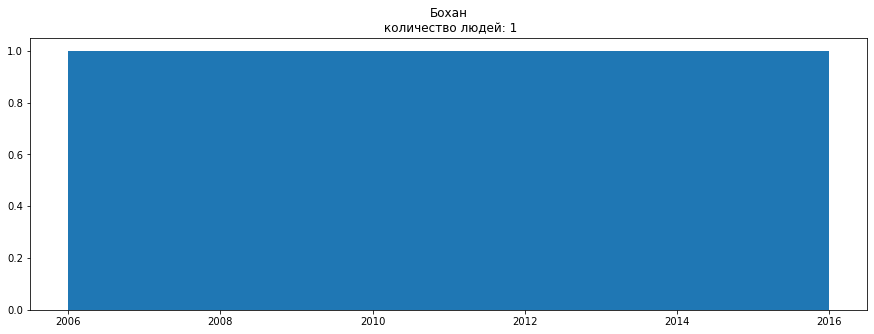

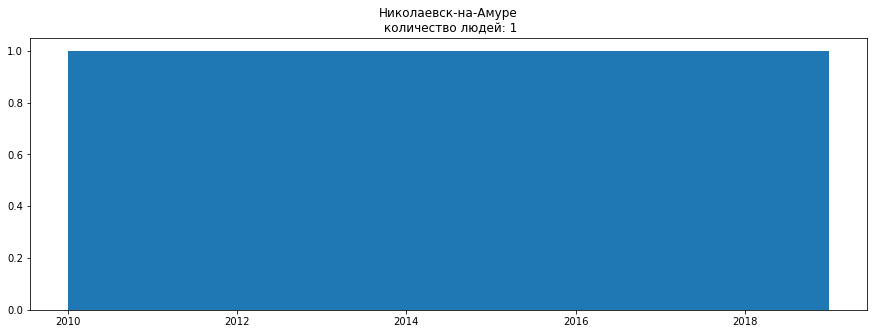

In [6]:
from_df = df[['from_place', 'from_place_name', 'from_latitude', 'from_longitude', 'from_year', 'to_year']]
years_all = []
for num, row in from_df.iterrows():
    years = explode_func(row['from_year'], row['to_year'])
    years_all.append(years)
from_df['year'] = years_all
from_df = from_df.explode('year')
agg_from_df = from_df.groupby(['from_latitude', 'from_longitude']).count().sort_values('year', ascending=False)
latitude_longitude = agg_from_df.index.tolist()
for latitude, longitude in latitude_longitude:
    graph = from_df[(from_df['from_latitude']  == latitude)&(from_df['from_longitude']  == longitude)]
    place_name = ', '.join(graph['from_place_name'].unique().tolist())
    years = sorted(graph['year'].tolist())
    number_of_people = df[(df['from_latitude'] == latitude)&
        (df['from_longitude'] == longitude)].shape[0]
    plt.figure(figsize=(15,5))
    plt.hist(years, bins=(max(years)-min(years) + 1))
    plt.title(place_name + '\n количество людей: ' + str(number_of_people))
    plt.show()

Заметно, что приток в целом формирует более крупные узлы.

Построим интерактиыные карты.

In [7]:
df_draw = df[(df['from_latitude'].isna() == False)
            &(df['to_latitude'].isna() == False)]
all_years = []
for num, row in df_draw.iterrows():
    years = []
    for i in range(row['from_year'], row['to_year'] + 1):
        years.append(i)
    all_years.append(years)
df_draw['year'] = all_years
df_draw = df_draw.explode('year')
df_draw.reset_index(drop=True, inplace=True)

<ipython-input-7-7244e52f38ab>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_draw['year'] = all_years


In [8]:
m = folium.Map(location=[63.899, 95.889],
              zoom_start=3)
for num, row in coordinates.iterrows():
    folium.Circle(
                location=[row['latitude'], row['longitude']],
                radius=100,
                tooltip=row['name']).add_to(m)

# вот тут менять условия для периода, данные дедуплицируются следующей строчкой
draw = df_draw[(df_draw['year'] >= 1959)&(df_draw['year'] < 1979)]
draw = draw[['person', 'from_latitude', 'from_longitude', 'to_latitude', 'to_longitude', 'year']]
draw = draw.drop_duplicates(['person', 'from_latitude', 'from_longitude', 'to_latitude', 'to_longitude'])
draw = draw.groupby(['from_latitude', 'from_longitude', 'to_latitude', 'to_longitude']).count()
draw.reset_index(inplace=True)

for num, row in draw.iterrows():
    folium.plugins.AntPath(
        locations=[(row['from_latitude'], row['from_longitude']),
                    (row['to_latitude'], row['to_longitude'])],
        weight=row['year']
    ).add_to(m)

In [ ]:
# чтобы карта не мерцала, лучше открыть html файл или запускать тетрадку через Firefox, а не Chrome
m

In [10]:
m.save('1959_1979.html')

Соберем агрегированную за 5 лет информацию. Будем считать общее количество потенциально переезжающих людей, количество новых людей, по сравнению с предыдущим периодом, количество рожденных в этот год людей.

In [7]:
df_draw['year'].min()

1866

In [8]:
df_draw['year'].max()

2019

In [19]:
graph = pd.DataFrame(columns=['start', 
                              'end', 
                              'period', 
                              'total', 
                              'total_normalized', 
                              'new', 
                              'new_normalized', 
                              'born',
                              'born_normalized'
                             ])
start = 1866
old_data = df_draw[df_draw['year'] < 1] # 0 rows
for end in range(1866 + 5, 2019 + 5, 5):
    data = df_draw[(df_draw['year'] >= start)&(df_draw['year'] < end)].drop_duplicates(
    ['person', 'from_latitude', 'from_longitude', 'to_latitude', 'to_longitude'])
    total = data.shape[0]
    new = data[~data['person'].isin(old_data['person'].unique().tolist())]['person'].unique().shape[0]
    if end < 2019:
        period = end - start
    else:
        period = 2020 - start
        end = 2019
    total_normalized = total / period
    new_normalized = new / period
    born = people_year_born[(people_year_born['year_born'] >= start)&(people_year_born['year_born'] < end)].shape[0]
    born_normalized = born / period
    graph.loc[graph.shape[0]] = [int(start), 
                                 int(end), 
                                 int(period), 
                                 int(total), 
                                 float(total_normalized), 
                                 int(new), 
                                 float(new_normalized),
                                 int(born),
                                 float(born_normalized)
                                ]
    start = end
    old_data = data
graph = graph.astype({'start': 'int64', 
              'end': 'int64', 
              'period': 'int64', 
              'total': 'int64', 
              'total_normalized': 'float64',
              'new': 'int64', 
              'new_normalized': 'float64',
              'born': 'int64',
              'born_normalized': 'float64'
                     })

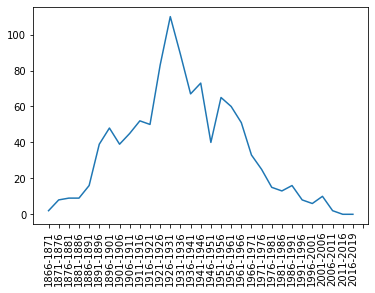

In [21]:
plt.plot(graph['new'])
labels = [str(i) + '-' + str(p) for i, p in zip(graph['start'].tolist(), graph['end'].tolist())]
ticks = [i for i in range(0, len(labels) + 1)]
plt.xticks(ticks, labels=labels, rotation=90)
plt.show()

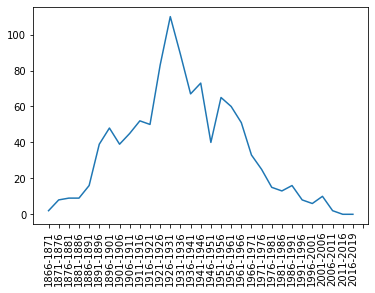

In [22]:
plt.plot(graph['born'])
labels = [str(i) + '-' + str(p) for i, p in zip(graph['start'].tolist(), graph['end'].tolist())]
ticks = [i for i in range(0, len(labels) + 1)]
plt.xticks(ticks, labels=labels, rotation=90)
plt.show()

Графики появления новых людей и рождаемости ожидаемо совпадают.

Посмотрим на ту же метрику, но нормированную общим количеством человек. В начале есть сильные пики, так как количество респондентов еще небольшое. После виден пик в 20-30 годы.

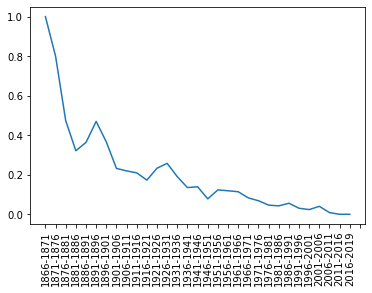

In [31]:
plt.plot(graph['new'] / graph['total'])
labels = [str(i) + '-' + str(p) for i, p in zip(graph['start'].tolist(), graph['end'].tolist())]
ticks = [i for i in range(0, len(labels) + 1)]
plt.xticks(ticks, labels=labels, rotation=90)
plt.show()